In [1]:
import datetime as dt
import time

import numpy as np
import pandas as pd

import pylab as pl
import seaborn as sns

import annoy as ann

import tqdm as tq

%pylab inline

import sklearn.decomposition as sd
import sklearn.manifold as sm
import sklearn.cluster as sc

import operator

Populating the interactive namespace from numpy and matplotlib


In [2]:
df_activity = pd.read_csv(
    '/Users/anokhin/Desktop/activities.tsv', 
    sep='\t', 
    header=None,
    index_col=0,
    names=[
        "vid",
        "n_sessions",
        "n_hits",
        "n_days",
        "hits_per_session_mean",
        "hits_per_session_std",
        "domains_per_session_mean",
        "domains_per_session_std",
        "interval_between_hits_mean",
        "interval_between_hits_std",
        "len_of_session_mean",
        "len_of_session_std",
        "interval_between_sessions_mean",
        "interval_between_sessions_std",
        "sessions_per_day_mean",
        "sessions_per_day_std",
        "displays_per_session_stats",
        "clicks_per_session_stats",
        "nVids",
        "nOkids",
        "nEmails",
        "nVkids"
    ]
)
df_activity.describe()

/usr/local/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


n_sessions        n_hits        n_days  hits_per_session_mean  \
count  1.392128e+06  1.392128e+06  1.392128e+06           1.238027e+06   
mean   4.209879e+00  5.816674e+01  1.535296e+00           1.585757e+01   
std    6.324299e+00  6.252850e+03  1.034429e+00           6.628431e+03   
min    0.000000e+00  0.000000e+00  0.000000e+00           1.000000e+00   
25%    1.000000e+00  1.000000e+00  1.000000e+00                    NaN   
50%    1.000000e+00  6.000000e+00  1.000000e+00                    NaN   
75%    5.000000e+00  3.300000e+01  2.000000e+00                    NaN   
max    1.350000e+02  7.358225e+06  4.000000e+00           7.358225e+06   

       hits_per_session_std  domains_per_session_mean  \
count          1.238027e+06              1.238027e+06   
mean           6.291290e+00              1.843422e+00   
std            2.352527e+01              4.993251e+01   
min            0.000000e+00              1.000000e+00   
25%                     NaN                       NaN   
50%                     NaN                       NaN   
75%                     NaN                       NaN   
max            7.903740e+03              5.426700e+04   

       domains_per_session_std  interval_between_hits_mean  \
count             1.238027e+06               999926.000000   
mean              5.872756e-01                   88.306448   
std               1.600156e+00                  113.003147   
min               0.000000e+00                    0.000000   
25%                        NaN                         NaN   
50%                        NaN                         NaN   
75%                        NaN                         NaN   
max               4.921460e+02                 1200.000000   

       interval_between_hits_std  len_of_session_mean      ...       \
count              999926.000000         1.238027e+06      ...        
mean                  109.352866         4.837877e+02      ...        
std                   108.882900         1.607675e+03      ...        
min                     0.000000         0.000000e+00      ...        
25%                          NaN                  NaN      ...        
50%                          NaN                  NaN      ...        
75%                          NaN                  NaN      ...        
max                   844.993000         2.591950e+05      ...        

       interval_between_sessions_mean  interval_between_sessions_std  \
count                   680451.000000                  680451.000000   
mean                     33006.396495                   20907.425925   
std                      35640.740425                   22897.164064   
min                       1201.000000                       0.000000   
25%                               NaN                            NaN   
50%                               NaN                            NaN   
75%                               NaN                            NaN   
max                     258783.000000                  178852.761000   

       sessions_per_day_mean  sessions_per_day_std  \
count           1.238027e+06          1.238027e+06   
mean            2.166125e+00          6.138912e-01   
std             1.943784e+00          1.165733e+00   
min             2.500000e-01          0.000000e+00   
25%                      NaN                   NaN   
50%                      NaN                   NaN   
75%                      NaN                   NaN   
max             4.500000e+01          2.002300e+01   

       displays_per_session_stats  clicks_per_session_stats         nVids  \
count                1.238027e+06              1.238027e+06  1.392128e+06   
mean                 1.423891e+00              7.041055e-03  7.704774e+00   
std                  2.668628e+02              8.631130e-01  2.796744e+02   
min                  0.000000e+00              0.000000e+00  0.000000e+00   
25%                           NaN                       NaN  0.000000e+00   
50%                           N

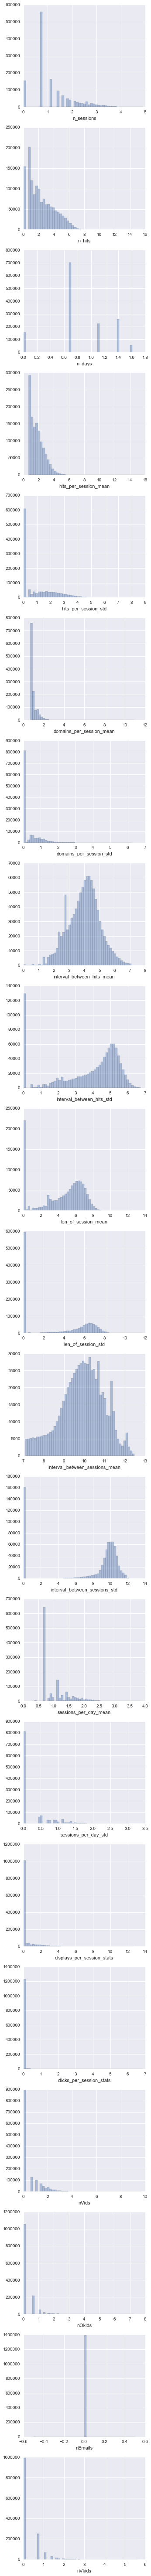

In [3]:
n_columns = len(df_activity.columns)

fig = pl.figure(figsize=(5, 5 * n_columns))

for i, col_i in enumerate(df_activity.columns):   
    ax = pl.subplot(n_columns, 1, i + 1)
    
    c = df_activity[col_i]    
    sns.distplot(np.log1p(c[~np.isnan(c)]), kde=False, bins=50)    

pl.show()

In [5]:
df_activity_sample = df_activity.sample(10000, random_state=42)
df_activity_sample_norm = (df_activity_sample - df_activity_sample.mean()) / df_activity_sample.std()
df_activity_sample_norm.fillna(0, inplace=True)
df_activity_sample_norm.describe()

n_sessions        n_hits        n_days  hits_per_session_mean  \
count  1.000000e+04  1.000000e+04  1.000000e+04           1.000000e+04   
mean  -4.050094e-17 -1.136868e-17  9.929835e-17           8.910206e-16   
std    1.000000e+00  1.000000e+00  1.000000e+00           9.425438e-01   
min   -6.632177e-01 -3.414229e-01 -1.483527e+00          -5.305415e-01   
25%   -5.071481e-01 -3.348192e-01 -5.210104e-01          -4.609785e-01   
50%   -5.071481e-01 -3.018003e-01 -5.210104e-01          -2.538545e-01   
75%    1.171302e-01 -1.168947e-01  4.415065e-01           0.000000e+00   
max    9.481305e+00  3.405102e+01  2.366540e+00           1.574721e+01   

       hits_per_session_std  domains_per_session_mean  \
count          1.000000e+04              1.000000e+04   
mean           9.928058e-16              1.925571e-16   
std            9.425438e-01              9.425438e-01   
min           -3.976861e-01             -4.675318e-01   
25%           -3.976861e-01             -4.675318e-01   
50%           -3.175922e-01             -3.489102e-01   
75%            0.000000e+00              1.502891e-01   
max            3.463777e+01              2.115620e+01   

       domains_per_session_std  interval_between_hits_mean  \
count             1.000000e+04                1.000000e+04   
mean             -2.680167e-15               -2.776446e-15   
std               9.425438e-01                8.453824e-01   
min              -3.976057e-01               -7.748168e-01   
25%              -3.976057e-01               -4.516750e-01   
50%              -3.976057e-01                0.000000e+00   
75%               0.000000e+00                0.000000e+00   
max               4.311331e+01                9.415436e+00   

       interval_between_hits_std  len_of_session_mean      ...       \
count               1.000000e+04         1.000000e+04      ...        
mean                1.950795e-15         4.277467e-16      ...        
std                 8.453824e-01         9.425438e-01      ...        
min                -1.007725e+00        -5.682904e-01      ...        
25%                -6.638963e-01        -5.400835e-01      ...        
50%                 0.000000e+00        -2.369411e-01      ...        
75%                 2.356991e-01         9.518453e-02      ...        
max                 6.011019e+00         3.439107e+01      ...        

       interval_between_sessions_mean  interval_between_sessions_std  \
count                    1.000000e+04                   1.000000e+04   
mean                     3.467449e-16                   2.882139e-16   
std                      6.991058e-01                   6.991058e-01   
min                     -8.899236e-01                  -9.101240e-01   
25%                     -3.172613e-01                  -1.922094e-01   
50%                      0.000000e+00                   0.000000e+00   
75%                      0.000000e+00                   0.000000e+00   
max                      6.148279e+00                   6.260083e+00   

       sessions_per_day_mean  sessions_per_day_std  \
count           1.000000e+04          1.000000e+04   
mean           -1.041656e-15         -9.485390e-15   
std             9.425438e-01          9.425438e-01   
min            -8.513947e-01         -5.259009e-01   
25%            -5.967728e-01         -5.259009e-01   
50%            -3.421509e-01         -5.259009e-01   
75%             8.204919e-02          6.731678e-02   
max             9.927769e+00          9.560478e+00   

       displays_per_session_stats  clicks_per_session_stats         nVids  \
count                1.000000e+04              1.000000e+04  1.000000e+04   
mean                -4.156675e-17             -1.847411e-17 -3.197442e-18   
std                  9.425438e-01              9.425438e-01  1.000000e+00   
min                 -1.195183e-01             -7.579065e-02 -2.735898e-02   
25%                 -1.195183e-01             -7.579065e-02 -2.735898e-02   
50%                 -1.195183e-

In [7]:
pca = sd.PCA(n_components=None)
X = pca.fit_transform(df_activity_sample_norm.values)
print "Explained variance: \n " + "\n ".join([str(v * 100) for v in pca.explained_variance_ratio_.cumsum()])
Y = X[:, :11]

Explained variance: 
 29.5093212795
 41.6877288007
 52.7291343453
 59.2911711764
 65.0904778969
 70.5206630896
 75.3850055025
 79.8563470757
 84.1996486139
 87.1855271395
 89.6013169661
 91.8209055048
 93.5275443104
 95.1607949481
 96.5817538674
 97.6932830544
 98.7800311421
 99.3261298889
 99.8335558164
 100.0
 100.0


In [8]:
tsne = sm.TSNE(
    n_components=2, 
    n_iter=1000, 
    perplexity=30, 
    early_exaggeration=10.0, 
    min_grad_norm=1e-10, 
    n_iter_without_progress=100, 
    learning_rate=2000, 
    random_state=42, 
    verbose=2,
#     metric='correlation'    
)
Z = tsne.fit_transform(Y)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] Iteration 25: error = 1.2972610, gradient norm = 0.0075582
[t-SNE] Iteration 50: error = 1.2786640, gradient norm = 0.0045788
[t-SNE] Iteration 75: error = 1.1897267, gradient norm = 0.0022560
[t-SNE] Iteration

In [9]:
dbscan = sc.DBSCAN(eps=0.5, min_samples=5)
cls = dbscan.fit_predict(Z)

In [10]:
kmeans = sc.KMeans(n_clusters=50, n_init=100, max_iter=1000, verbose=0)
cls = kmeans.fit_predict(Y)

In [11]:
n_clusters = len(np.unique(cls))
print "%d clusters found" % n_clusters
cluster_sizes = sorted([(c, (cls == c).sum()) for c in xrange(n_clusters)], key=operator.itemgetter(1), reverse=True)
cluster_sizes

50 clusters found


[(8, 1861),
 (19, 1608),
 (13, 1052),
 (0, 538),
 (14, 423),
 (35, 415),
 (29, 396),
 (40, 360),
 (26, 322),
 (44, 315),
 (42, 273),
 (12, 235),
 (36, 194),
 (2, 189),
 (3, 187),
 (25, 187),
 (23, 151),
 (4, 137),
 (17, 124),
 (9, 107),
 (16, 107),
 (37, 107),
 (30, 85),
 (47, 74),
 (38, 67),
 (45, 67),
 (7, 66),
 (43, 56),
 (27, 47),
 (41, 39),
 (1, 37),
 (18, 30),
 (48, 30),
 (39, 26),
 (49, 18),
 (10, 12),
 (33, 11),
 (15, 8),
 (22, 7),
 (32, 7),
 (6, 6),
 (28, 5),
 (31, 3),
 (5, 2),
 (20, 2),
 (34, 2),
 (46, 2),
 (11, 1),
 (21, 1),
 (24, 1)]

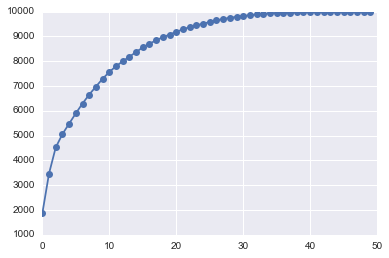

In [12]:
pl.plot(range(n_clusters), np.cumsum(map(lambda cs: cs[1], cluster_sizes)), "o-")
pl.show()

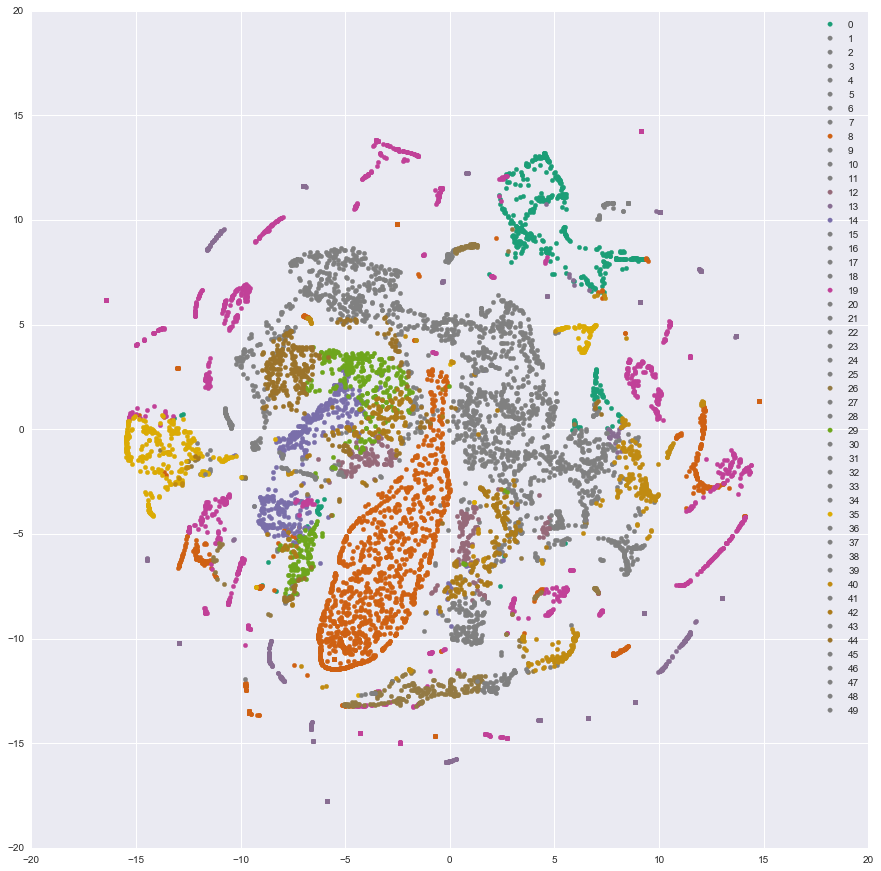

In [13]:
N_TOP_CLUSTERS = 12
top_clusters = map(lambda cs: cs[0], cluster_sizes)[:N_TOP_CLUSTERS]

cm = pl.cm.Dark2

pl.figure(figsize=(15, 15))
for c in xrange(n_clusters):    
    pl.scatter(Z[cls == c, 0], Z[cls == c, 1], color=cm(int(1.0 * c / n_clusters * 256)) if c in top_clusters else 'gray', label="%d" % c)
    
pl.legend()
pl.show()

In [14]:
df_activity_sample_cls = df_activity_sample.copy()
df_activity_sample_cls["cls"] = cls
df_activity_sample_cls.head()

n_sessions  n_hits  n_days  hits_per_session_mean  \
vid                                                            
3c0d1b67b           3       9       2                   3.00   
391dd2142           4     153       2                  38.25   
45c3f0a53           2      22       1                  11.00   
468a4c27c           2       8       1                   4.00   
39b406130           5      15       3                   3.00   

           hits_per_session_std  domains_per_session_mean  \
vid                                                         
3c0d1b67b                 1.732                       2.0   
391dd2142                29.182                       7.5   
45c3f0a53                 0.000                       1.0   
468a4c27c                 0.000                       1.0   
39b406130                 3.391                       1.0   

           domains_per_session_std  interval_between_hits_mean  \
vid                                                              
3c0d1b67b                    1.000                      284.50   
391dd2142                    5.508                       36.98   
45c3f0a53                    0.000                       19.95   
468a4c27c                    0.000                        6.50   
39b406130                    0.000                      146.60   

           interval_between_hits_std  len_of_session_mean ...   \
vid                                                       ...    
3c0d1b67b                    404.690               570.00 ...    
391dd2142                     59.050              1380.75 ...    
45c3f0a53                     11.194               199.50 ...    
468a4c27c                      2.168                19.50 ...    
39b406130                    272.023               293.80 ...    

           interval_between_sessions_std  sessions_per_day_mean  \
vid                                                               
3c0d1b67b                     113970.764                  1.500   
391dd2142                      25466.591                  2.000   
45c3f0a53                          0.000                  2.000   
468a4c27c                          0.000                  2.000   
39b406130                      42346.979                  1.667   

           sessions_per_day_std  displays_per_session_stats  \
vid                                                           
3c0d1b67b                 0.707                         0.0   
391dd2142                 0.000                         0.5   
45c3f0a53                 0.000                         0.0   
468a4c27c                 0.000                         0.0   
39b406130                 1.155                         0.4   

           clicks_per_session_stats  nVids  nOkids  nEmails  nVkids  cls  
vid                                                                       
3c0d1b67b                       0.0      0       0        0       0   23  
391dd2142                       0.0      0       0        0       0    7  
45c3f0a53                       0.0      0       0        0       0    0  
468a4c27c                       0.0      0       0        0       0    0  
39b406130                       0.0      3       0        0       2   12  

[5 rows x 22 columns]

In [15]:
print top_clusters
df_stats = pd.concat([df_activity_sample_cls[df_activity_sample_cls.cls == c].describe().loc[["50%"]] for c in top_clusters]).fillna(0)
df_stats

[8, 19, 13, 0, 14, 35, 29, 40, 26, 44, 42, 12]


n_sessions  n_hits  n_days  hits_per_session_mean  hits_per_session_std  \
50%         1.0     1.0     1.0                  1.000                 0.000   
50%         1.0     3.0     1.0                  3.000                 0.000   
50%         0.0     0.0     0.0                  0.000                 0.000   
50%         2.0     7.0     1.0                  3.000                 1.414   
50%         4.0    13.0     3.0                  3.000                 2.000   
50%         2.0     6.0     2.0                  3.000                 1.414   
50%         8.0    36.0     3.0                  4.500                 3.787   
50%         2.0     7.0     1.0                  4.000                 0.000   
50%         1.0    17.0     1.0                 16.000                 0.000   
50%        14.0    91.0     3.0                  6.571                 6.373   
50%         5.0    49.0     3.0                  9.833                 9.564   
50%         6.0    19.0     3.0                  3.200                 2.302   

     domains_per_session_mean  domains_per_session_std  \
50%                     1.000                    0.000   
50%                     1.000                    0.000   
50%                     0.000                    0.000   
50%                     1.000                    0.000   
50%                     1.000                    0.000   
50%                     1.000                    0.000   
50%                     1.286                    0.500   
50%                     1.000                    0.000   
50%                     3.000                    0.000   
50%                     1.550                    0.888   
50%                     2.000                    1.000   
50%                     1.167                    0.408   

     interval_between_hits_mean  interval_between_hits_std  \
50%                      0.0000                     0.0000   
50%                     18.0000                     5.1600   
50%                      0.0000                     0.0000   
50%                      0.0000                     0.0000   
50%                      0.0000                     0.0000   
50%                      0.0000                     0.0000   
50%                      0.0000                     0.0000   
50%                    214.6285                   266.7030   
50%                     45.7270                    62.9345   
50%                     88.3800                   180.7470   
50%                     75.4870                   154.0210   
50%                    194.0000                   282.8210   

     len_of_session_mean  ...   interval_between_sessions_std  \
50%               0.0000  ...                           0.000   
50%              45.0000  ...                           0.000   
50%               0.0000  ...                           0.000   
50%              66.0000  ...                           0.000   
50%              72.5000  ...                       40702.014   
50%              99.0000  ...                           0.000   
50%             225.1250  ...                       23211.634   
50%             685.0000  ...                           0.000   
50%             688.6665  ...                           0.000   
50%             455.4000  ...                       17113.551   
50%             610.3330  ...                       40370.078   
50%             430.1430  ...                       33902.516   

     sessions_per_day_mean  sessions_per_day_std  displays_per_session_stats  \
50%                  1.000                 0.000                       0.000   
50%                  1.000                 0.000                       0.000   
50%                  0.000                 0.000                       0.000   
50%                  2.000                 0.000                       0.000   
50%                  1.667                 0.707                       0.000   
50%                  1.000                 0.000                       0.000

In [16]:
features = [
        "n_sessions", 
        "n_hits", 
        "n_days", 
        "hits_per_session_mean", 
        "hits_per_session_std", 
        "domains_per_session_mean", 
        "domains_per_session_std", 
        "interval_between_hits_mean", 
        "interval_between_hits_std", 
        "len_of_session_mean", 
        "len_of_session_std", 
        "interval_between_sessions_mean", 
        "interval_between_sessions_std", 
        "sessions_per_day_mean", 
        "sessions_per_day_std",
#         "displays_per_session_stats",
#         "clicks_per_session_stats"
    ]

df_stats_norm = df_stats[features].copy()
df_stats_norm = df_stats_norm / df_stats_norm.max()
df_stats_norm

n_sessions    n_hits    n_days  hits_per_session_mean  \
50%    0.071429  0.010989  0.333333               0.062500   
50%    0.071429  0.032967  0.333333               0.187500   
50%    0.000000  0.000000  0.000000               0.000000   
50%    0.142857  0.076923  0.333333               0.187500   
50%    0.285714  0.142857  1.000000               0.187500   
50%    0.142857  0.065934  0.666667               0.187500   
50%    0.571429  0.395604  1.000000               0.281250   
50%    0.142857  0.076923  0.333333               0.250000   
50%    0.071429  0.186813  0.333333               1.000000   
50%    1.000000  1.000000  1.000000               0.410688   
50%    0.357143  0.538462  1.000000               0.614563   
50%    0.428571  0.208791  1.000000               0.200000   

     hits_per_session_std  domains_per_session_mean  domains_per_session_std  \
50%              0.000000                  0.333333                    0.000   
50%              0.000000                  0.333333                    0.000   
50%              0.000000                  0.000000                    0.000   
50%              0.147846                  0.333333                    0.000   
50%              0.209118                  0.333333                    0.000   
50%              0.147846                  0.333333                    0.000   
50%              0.395964                  0.428667                    0.500   
50%              0.000000                  0.333333                    0.000   
50%              0.000000                  1.000000                    0.000   
50%              0.666353                  0.516667                    0.888   
50%              1.000000                  0.666667                    1.000   
50%              0.240694                  0.389000                    0.408   

     interval_between_hits_mean  interval_between_hits_std  \
50%                    0.000000                   0.000000   
50%                    0.083866                   0.018245   
50%                    0.000000                   0.000000   
50%                    0.000000                   0.000000   
50%                    0.000000                   0.000000   
50%                    0.000000                   0.000000   
50%                    0.000000                   0.000000   
50%                    1.000000                   0.943010   
50%                    0.213052                   0.222524   
50%                    0.411781                   0.639086   
50%                    0.351710                   0.544588   
50%                    0.903887                   1.000000   

     len_of_session_mean  len_of_session_std  interval_between_sessions_mean  \
50%             0.000000            0.000000                        0.000000   
50%             0.065344            0.000000                        0.000000   
50%             0.000000            0.000000                        0.000000   
50%             0.095837            0.077852                        0.071281   
50%             0.105276            0.129262                        0.464128   
50%             0.143756            0.106944                        1.000000   
50%             0.326900            0.408261                        0.233796   
50%             0.994676            0.063106                        0.000000   
50%             1.000000            0.000000                        0.000000   
50%             0.661278            0.848996                        0.149579   
50%             0.886253            1.000000                        0.375871   
50%             0.624603            0.801753                        0.319264   

     interval_between_sessions_std  sessions_per_day_mean  \
50%                       0.000000               0.214270   
50%                       0.000000               0.214270   
50%                       0.000000               0.000000   
50%                       0.000000               0.428541   
50% 

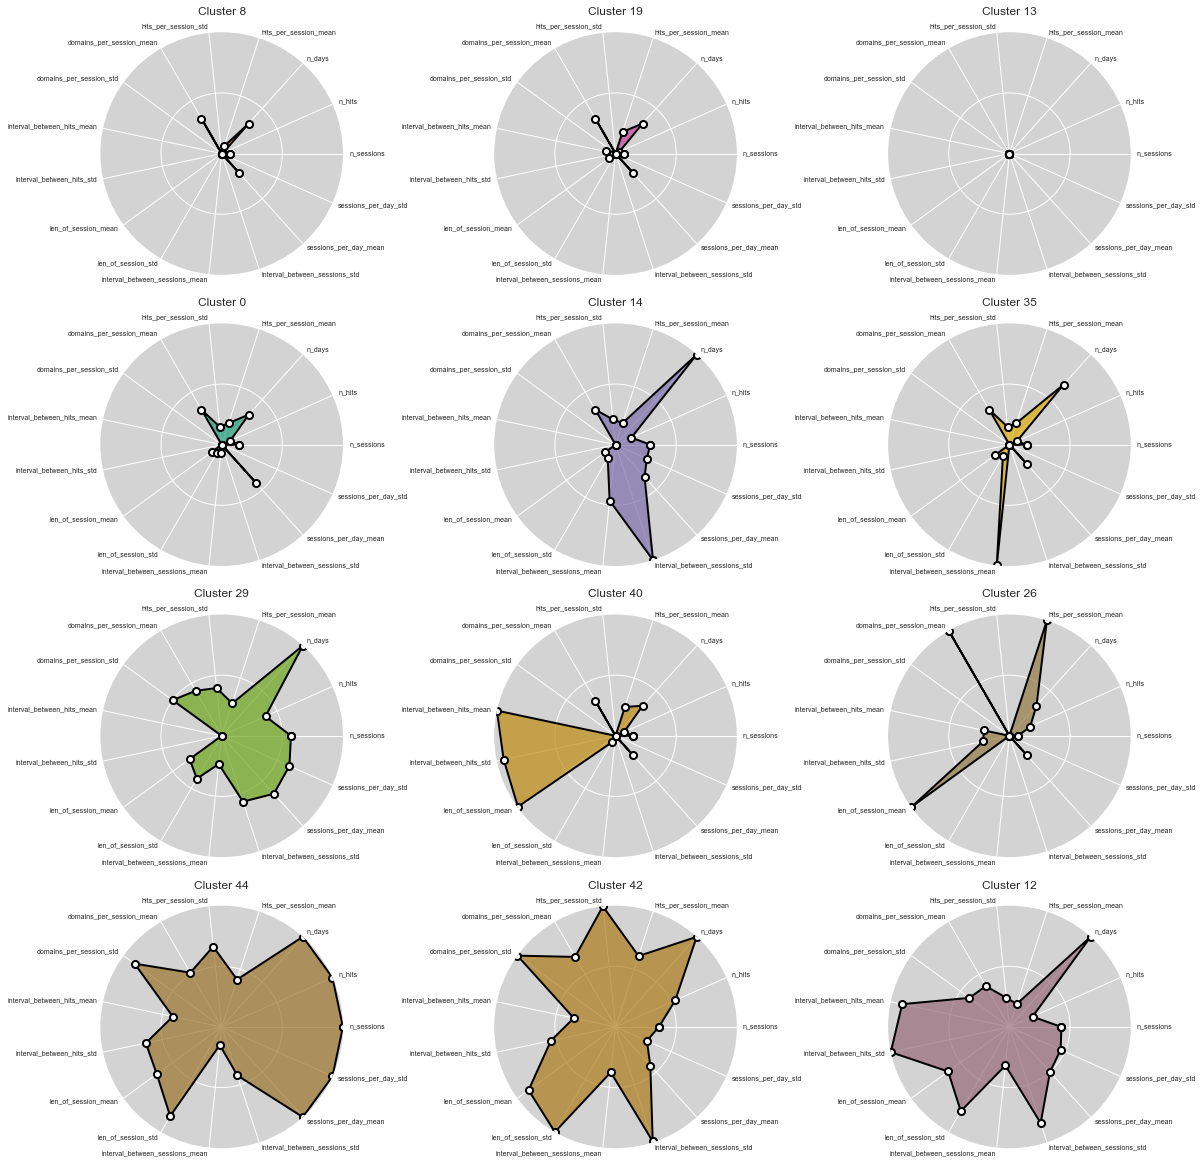

In [17]:
def radar(centroid, features, axes, color, ymax=1):
    # Set ticks to the number of features (in radians)
    t = np.arange(0, 2*np.pi, 2*np.pi/len(features))
    plt.xticks(t, [])

    # Set yticks from 0 to 1
    plt.yticks([0.5], [])

    # Draw polygon representing centroid
    points = [(x, y) for x, y in zip(t, centroid)]
    points.append(points[0])
    points = np.array(points)
    codes = [path.Path.MOVETO,] + [path.Path.LINETO,] * (len(centroid) - 1) + [ path.Path.CLOSEPOLY ]
    _path = path.Path(points, codes)
    _patch = patches.PathPatch(_path, fill=True, color=color, linewidth=0, alpha=.7)
    axes.add_patch(_patch)
    _patch = patches.PathPatch(_path, fill=False, linewidth = 2)
    axes.add_patch(_patch)

    # Draw circles at value points
    plt.scatter(points[:,0], points[:,1], linewidth=2, s=50, color='white', edgecolor='black', zorder=10)

    # Set axes limits
    plt.ylim(0, ymax)

    # Draw ytick labels to make sure they fit properly
    for i in range(len(features)):
        angle_rad = i/float(len(features))*2*np.pi
        angle_deg = i/float(len(features))*360
        ha = "right"
        if angle_rad < np.pi/2 or angle_rad > 3*np.pi/2: ha = "left"
        plt.text(angle_rad, ymax * 1.05, features[i], size=7, horizontalalignment=ha, verticalalignment="center")

# Some additiola imports
import matplotlib
import matplotlib.path as path
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Choose some nice colors
matplotlib.rc('axes', facecolor = 'lightgray')
# Make figure background the same colors as axes 
fig = plt.figure(figsize=(20, 20), facecolor='white')

cm = pl.cm.Dark2

for j, c in enumerate(top_clusters):        
    centroid = df_stats_norm[df_stats.cls == c].values.mean(axis=0)
    # Use a polar axes
    axes = plt.subplot(4, 3, j + 1, polar=True)
    radar(centroid, features, axes, cm(int(1.0 * c / n_clusters * 256)))
    pl.title("Cluster %d" % c)

plt.show()

In [19]:
with open("/Users/anokhin/Desktop/vids.txt", "w") as vf:
    for vid in df_activity_sample_cls.index.values:
        print >> vf, vid

## Individual users

In [20]:
vid_data = {}
with open("/Users/anokhin/Desktop/timeseries.txt", "r") as vf:
    for line in vf:
        vid, data = line.strip().split("\t")
        vid_data[vid] = {}
        
        for d in data.split(","):
            if not d:
                continue
                
            ts = int(d.split(":")[0])
            domain = d.split(":")[1]
            
            if domain not in vid_data[vid]:
                vid_data[vid][domain] = [ts]
            else:
                vid_data[vid][domain].append(ts)       
        
print vid_data.items()[2]

('35e7c4b58', {'hqq.tv': [1466457490, 1466502912, 1466632062, 1466632325, 1466632513, 1466713485, 1466713509]})


/usr/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/usr/local/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


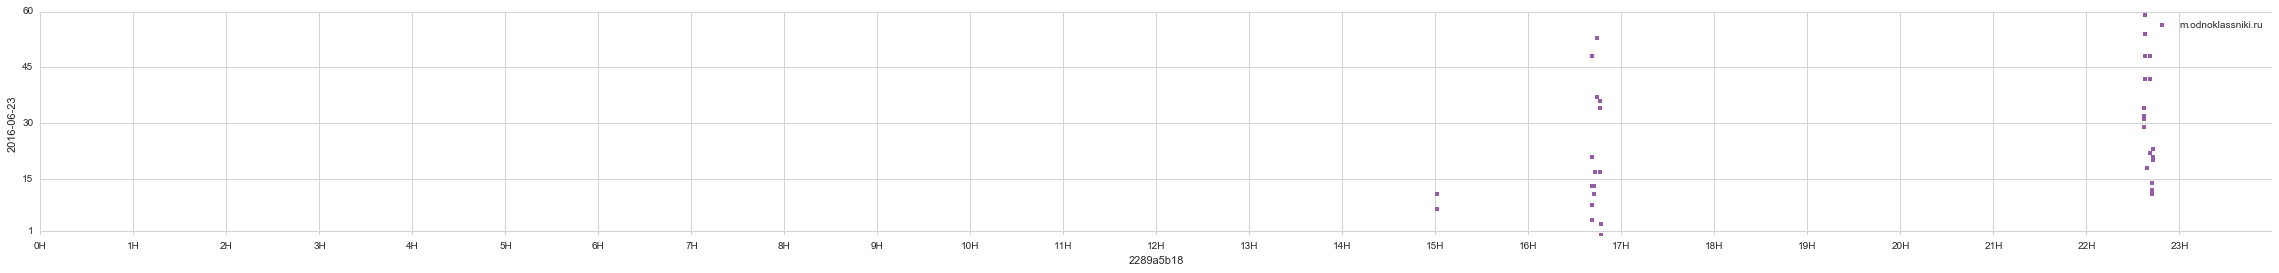

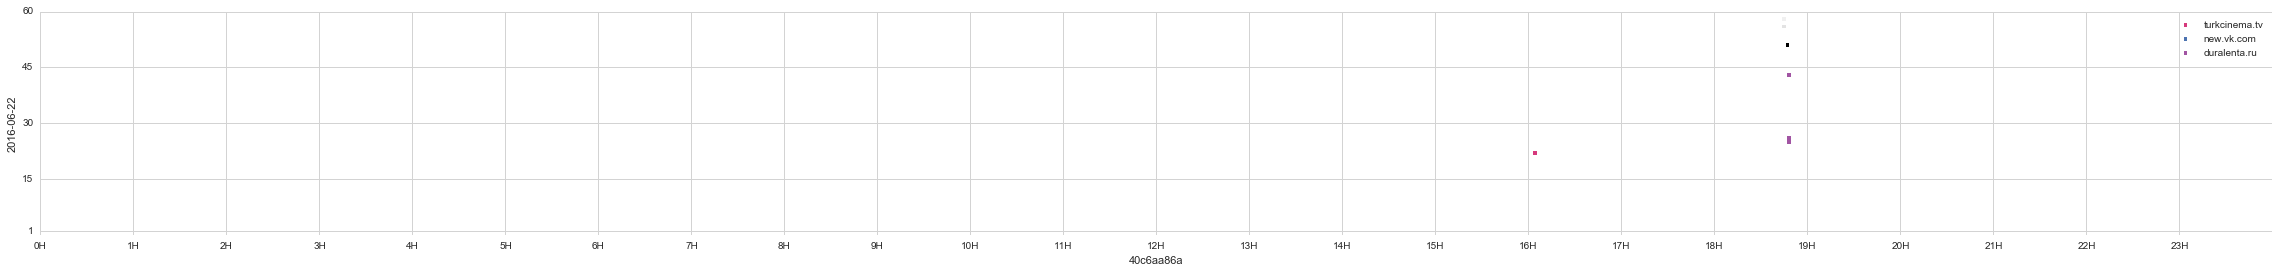

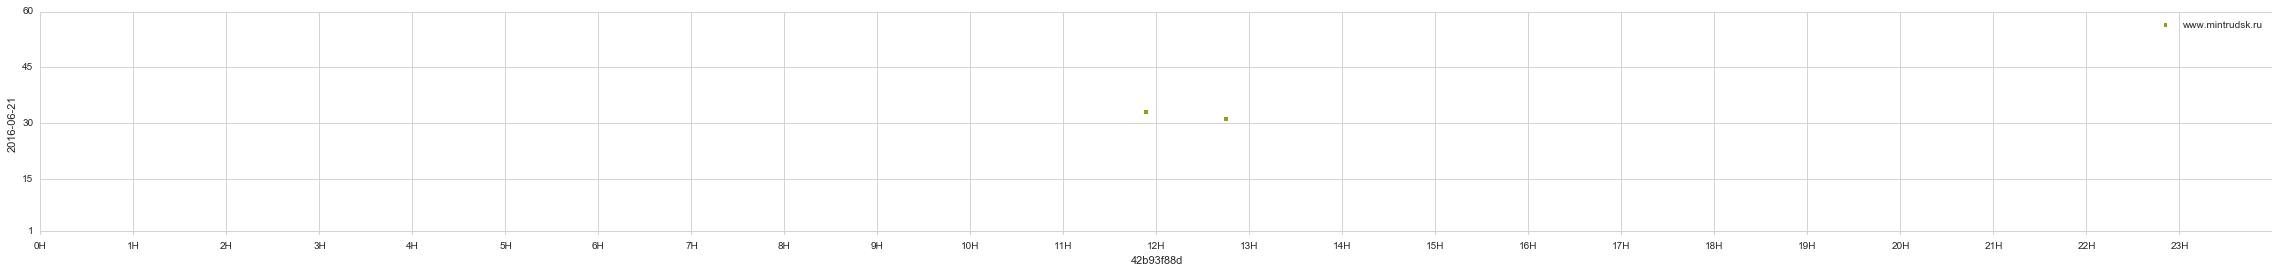

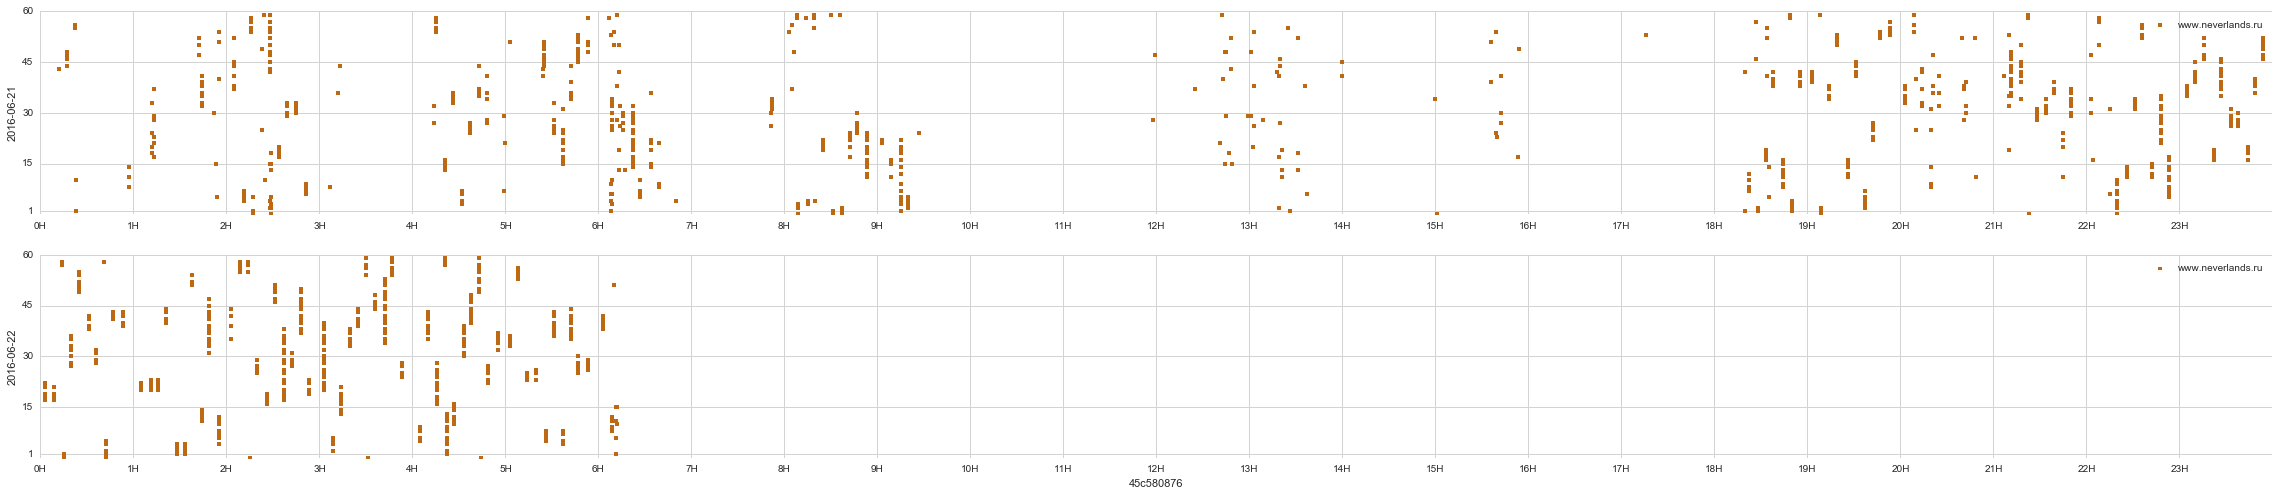

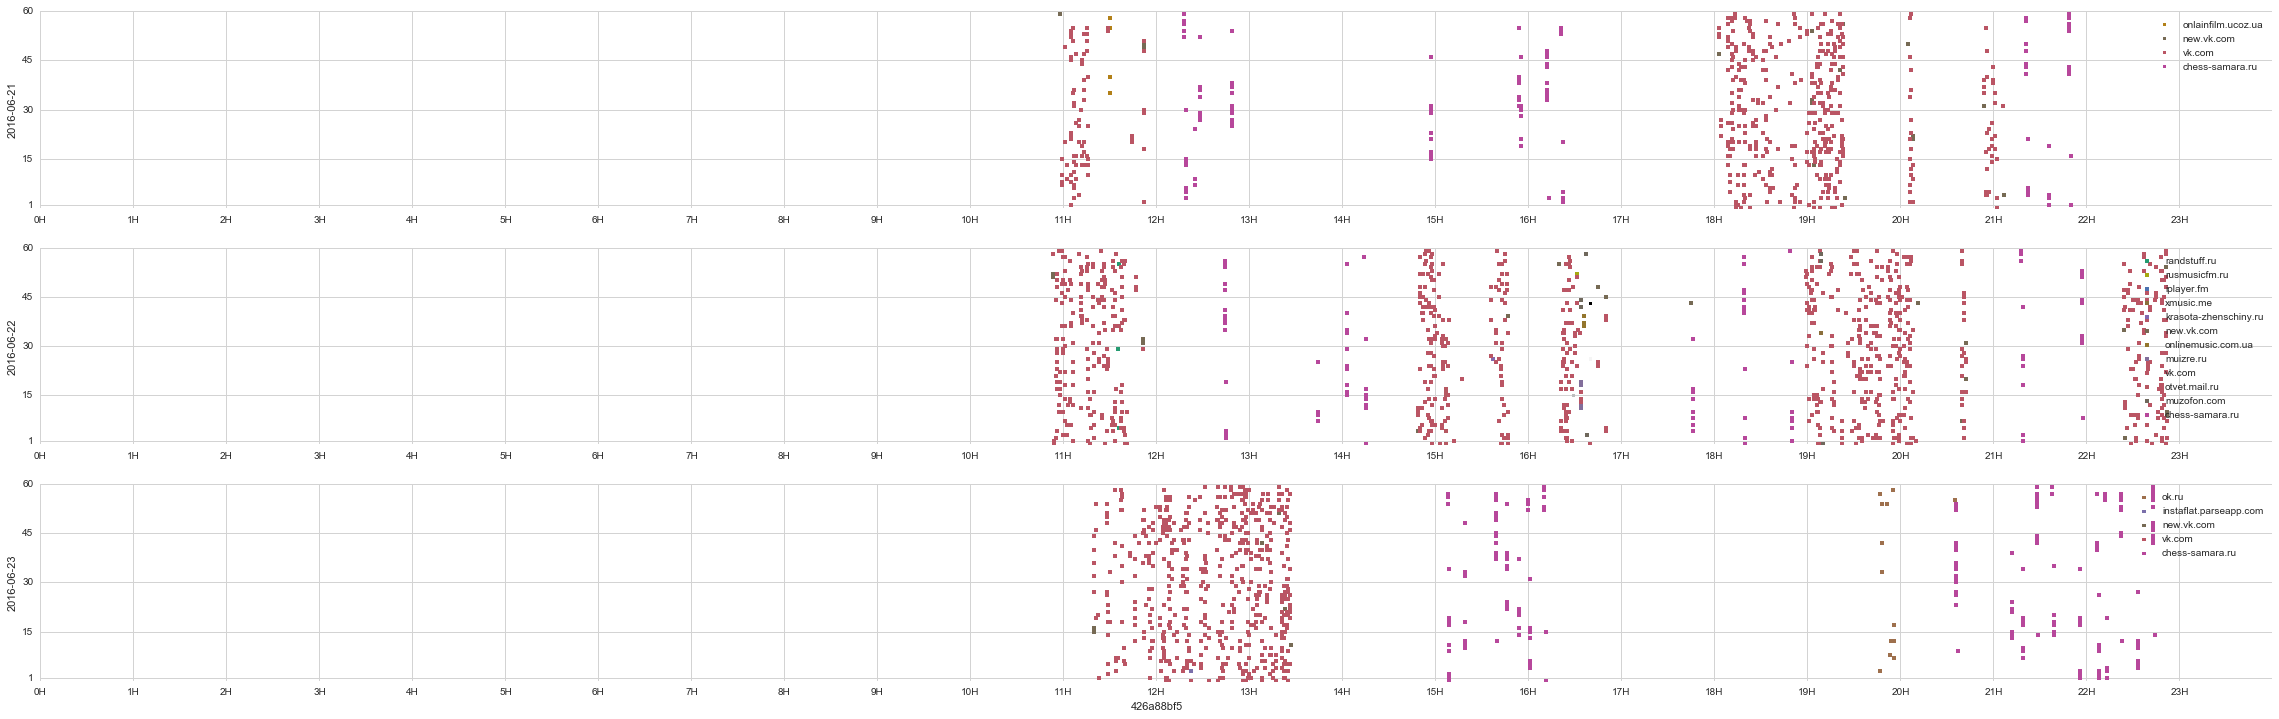

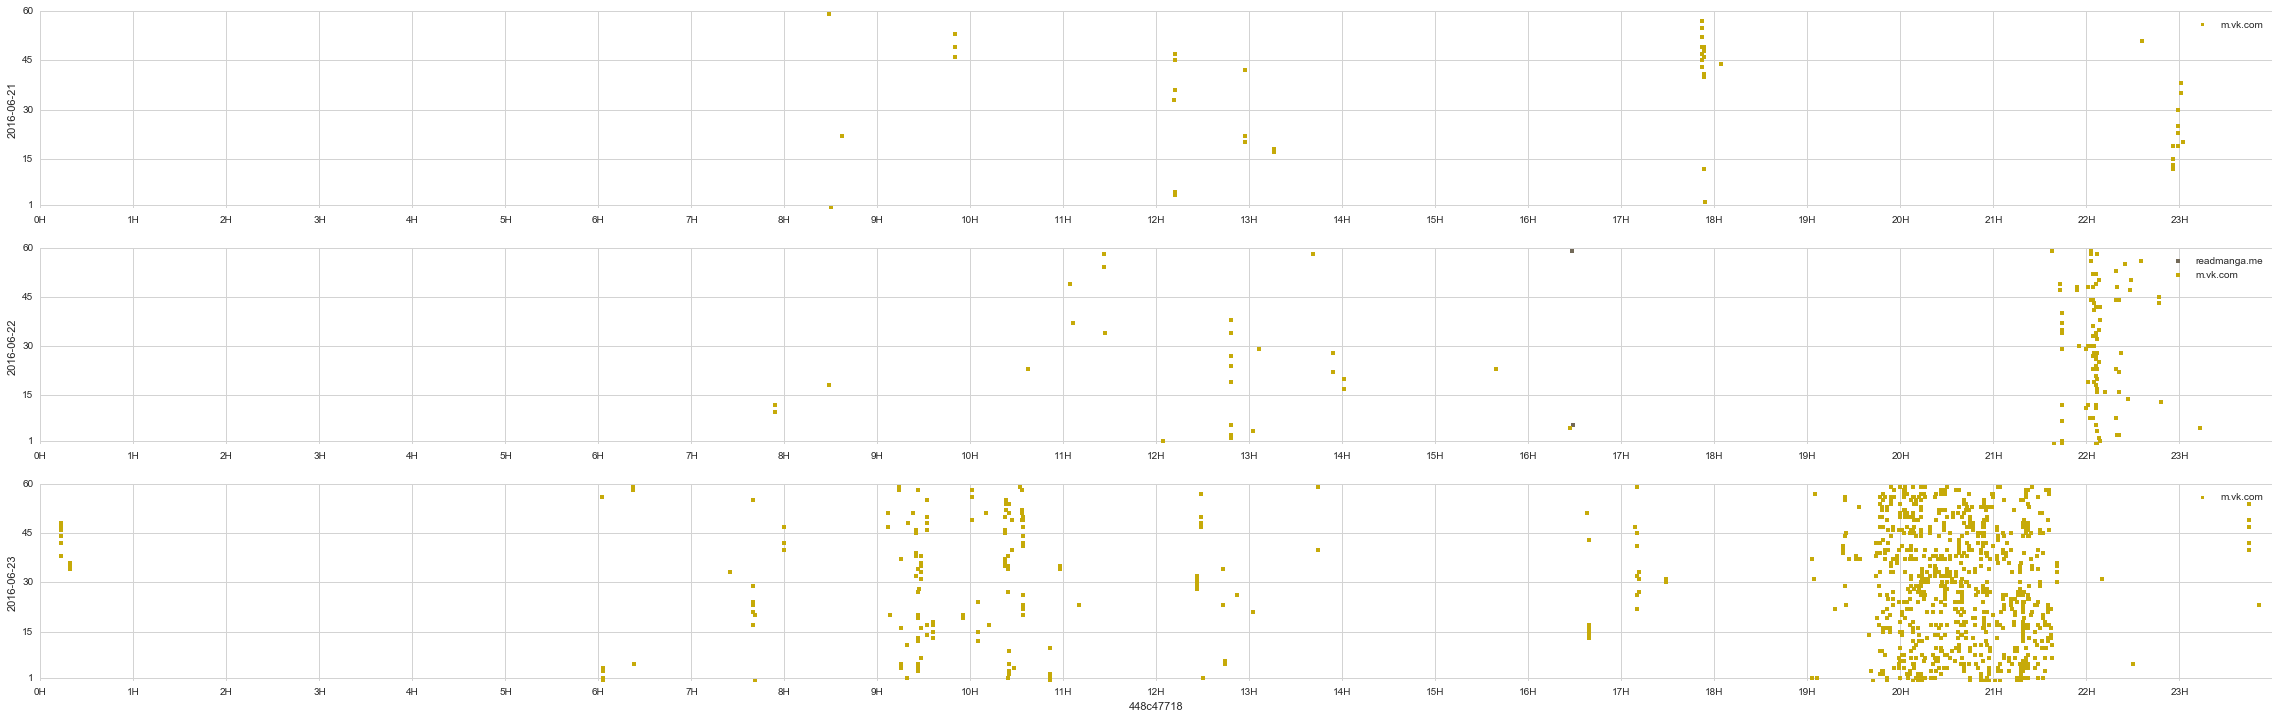

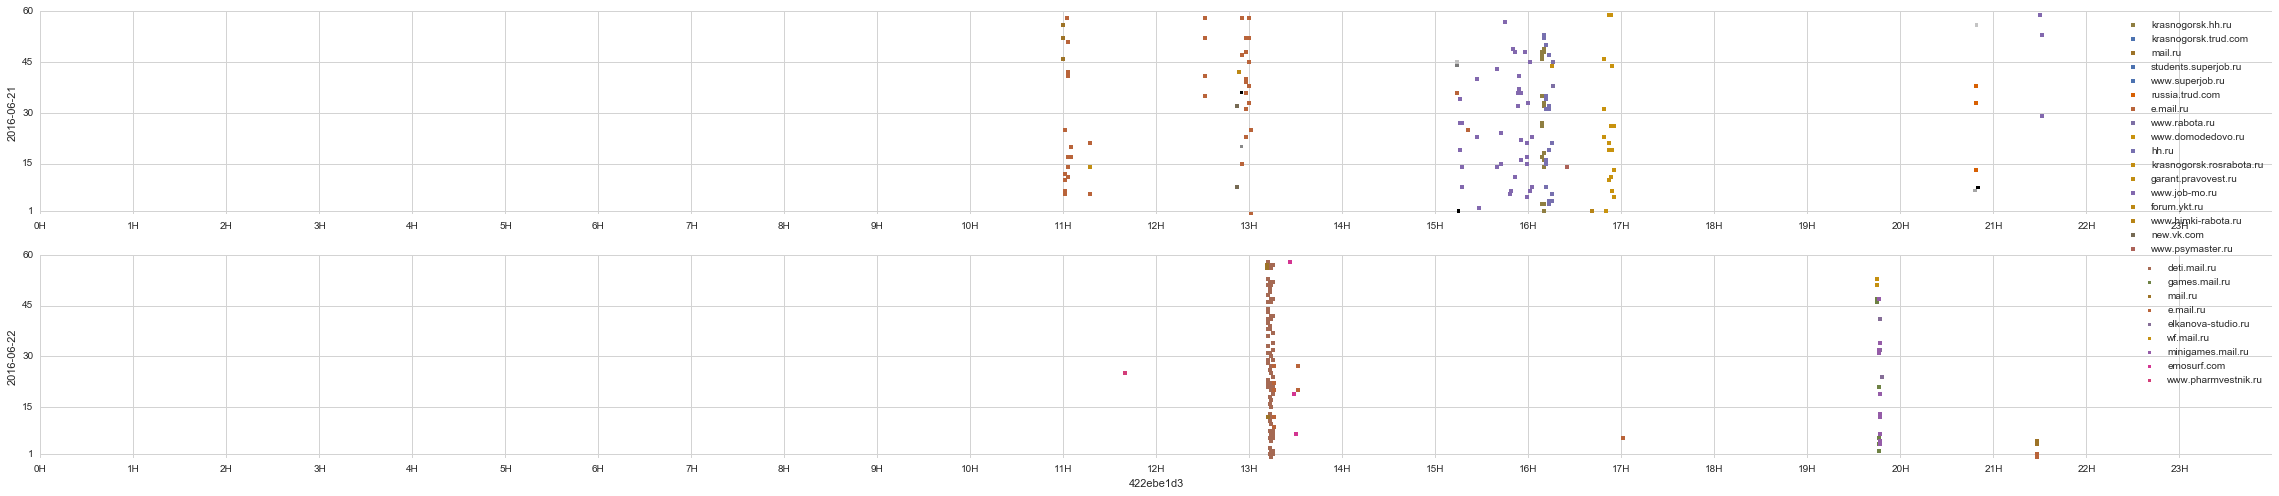

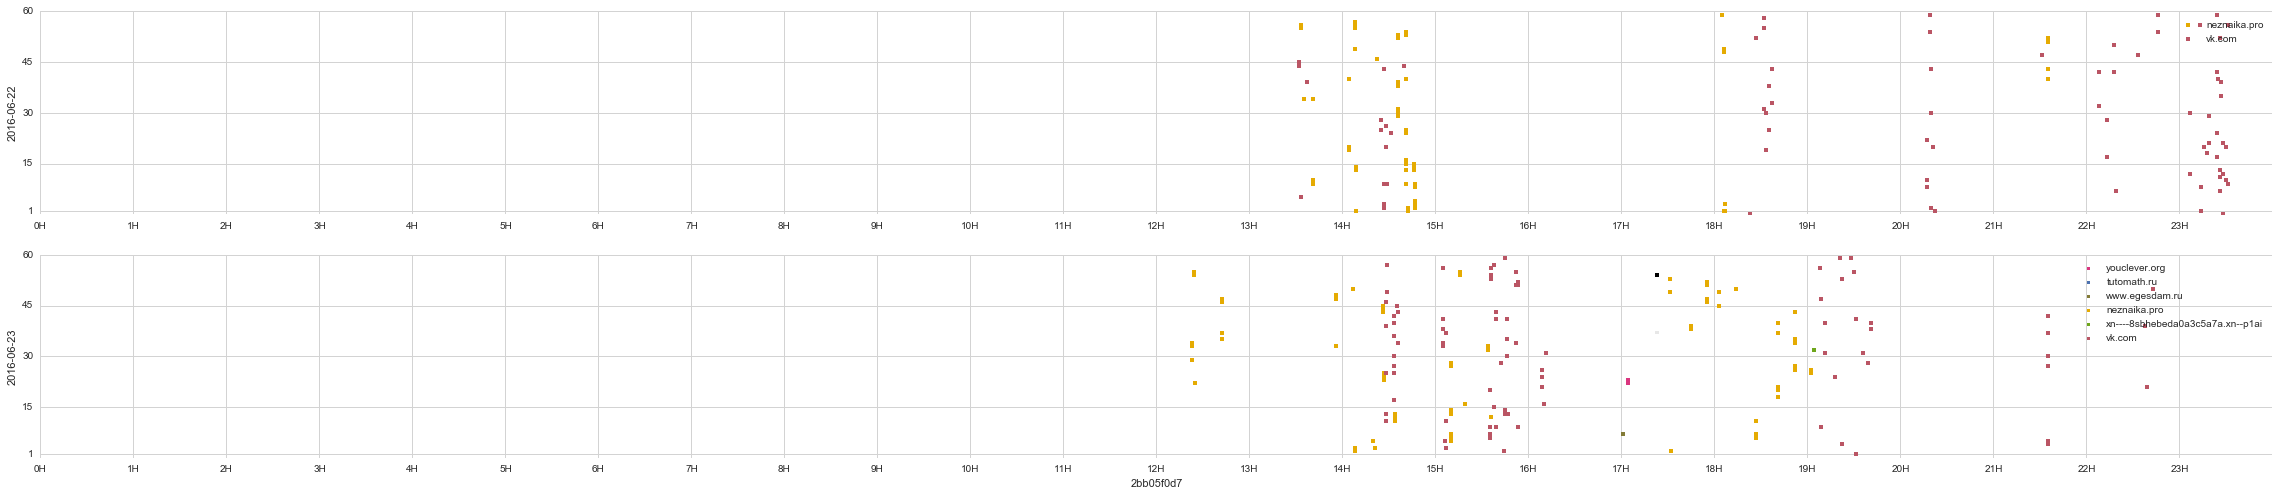

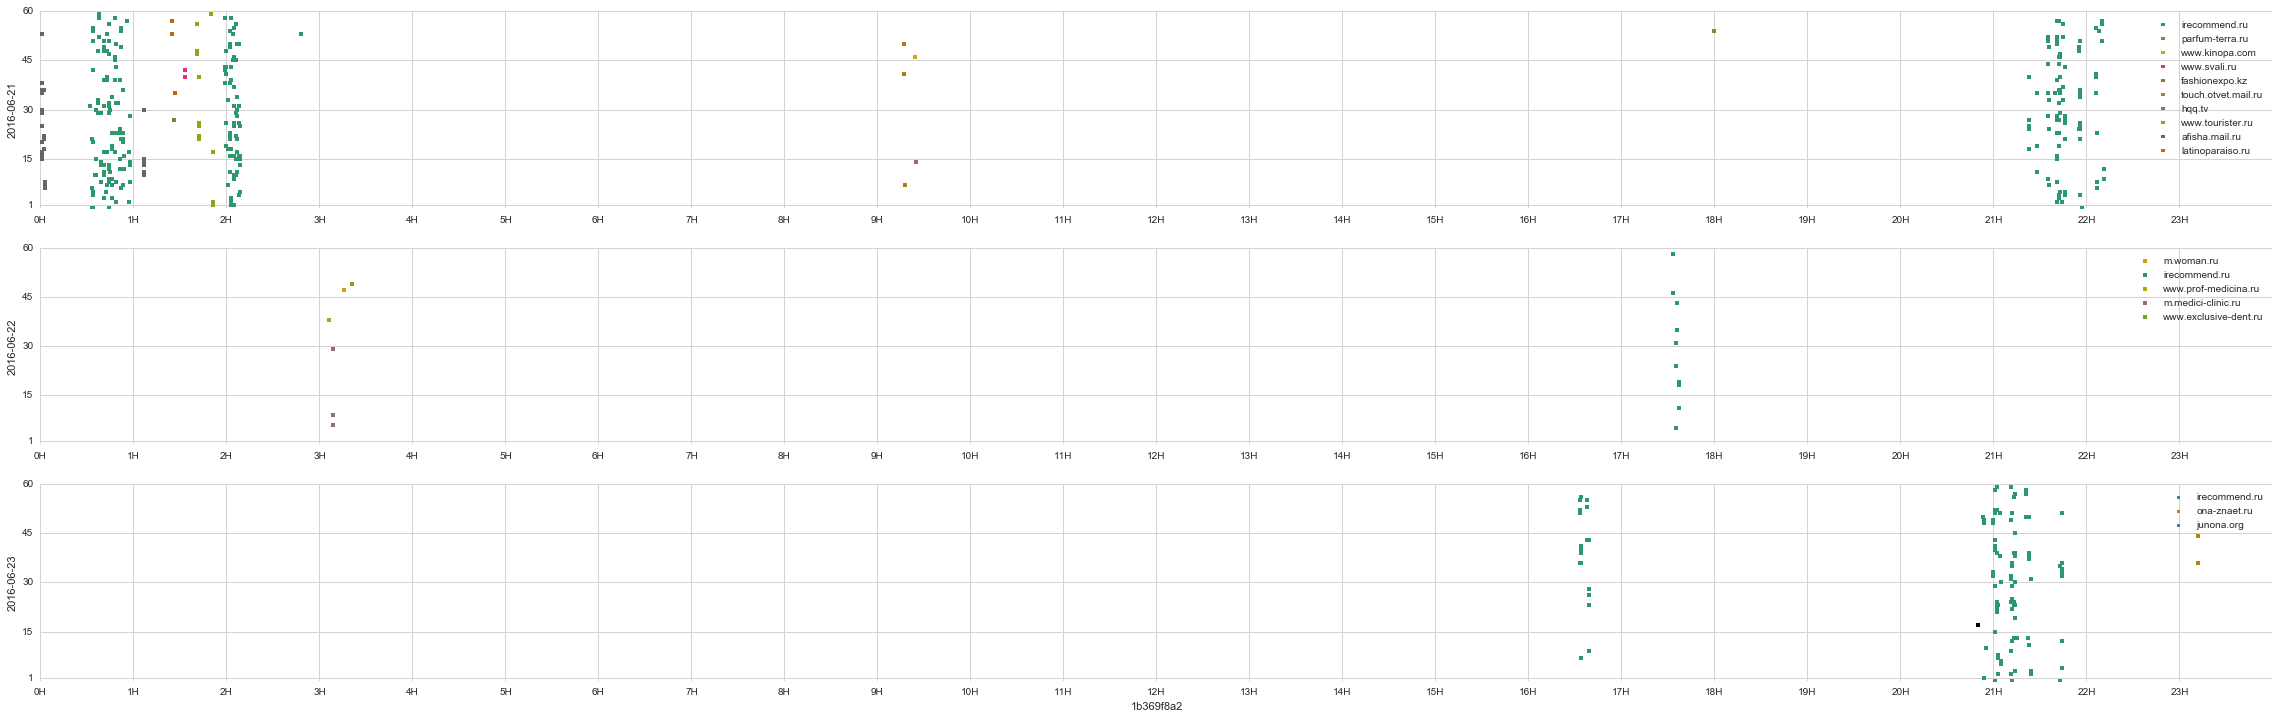

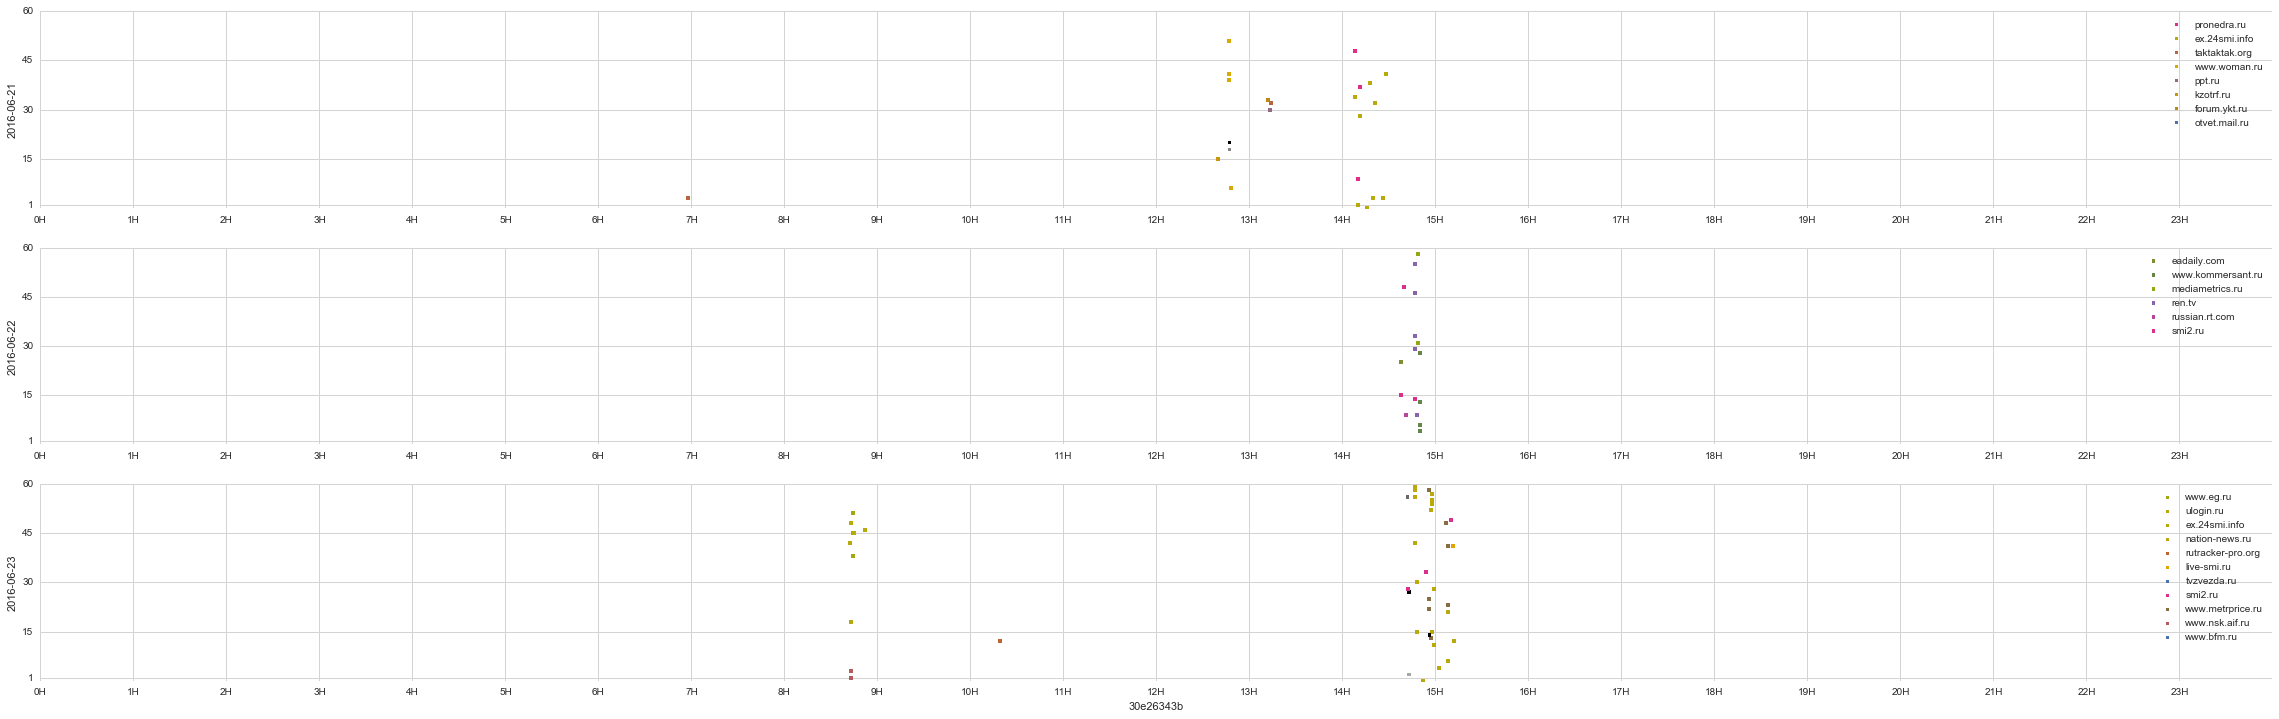

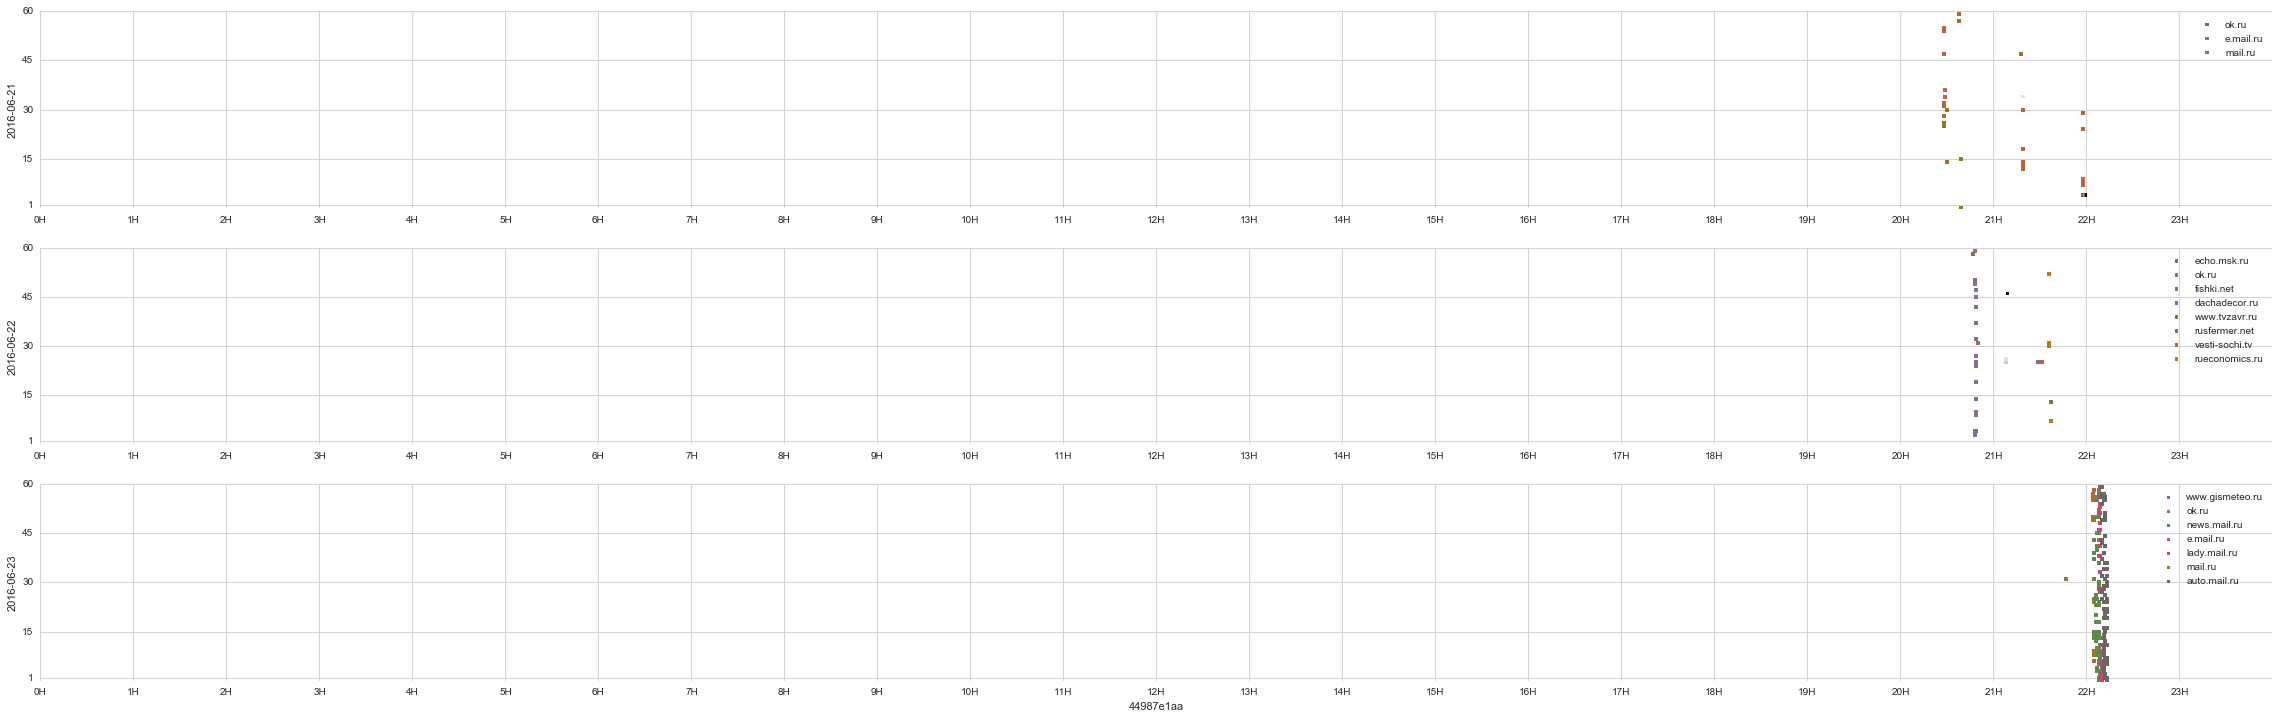

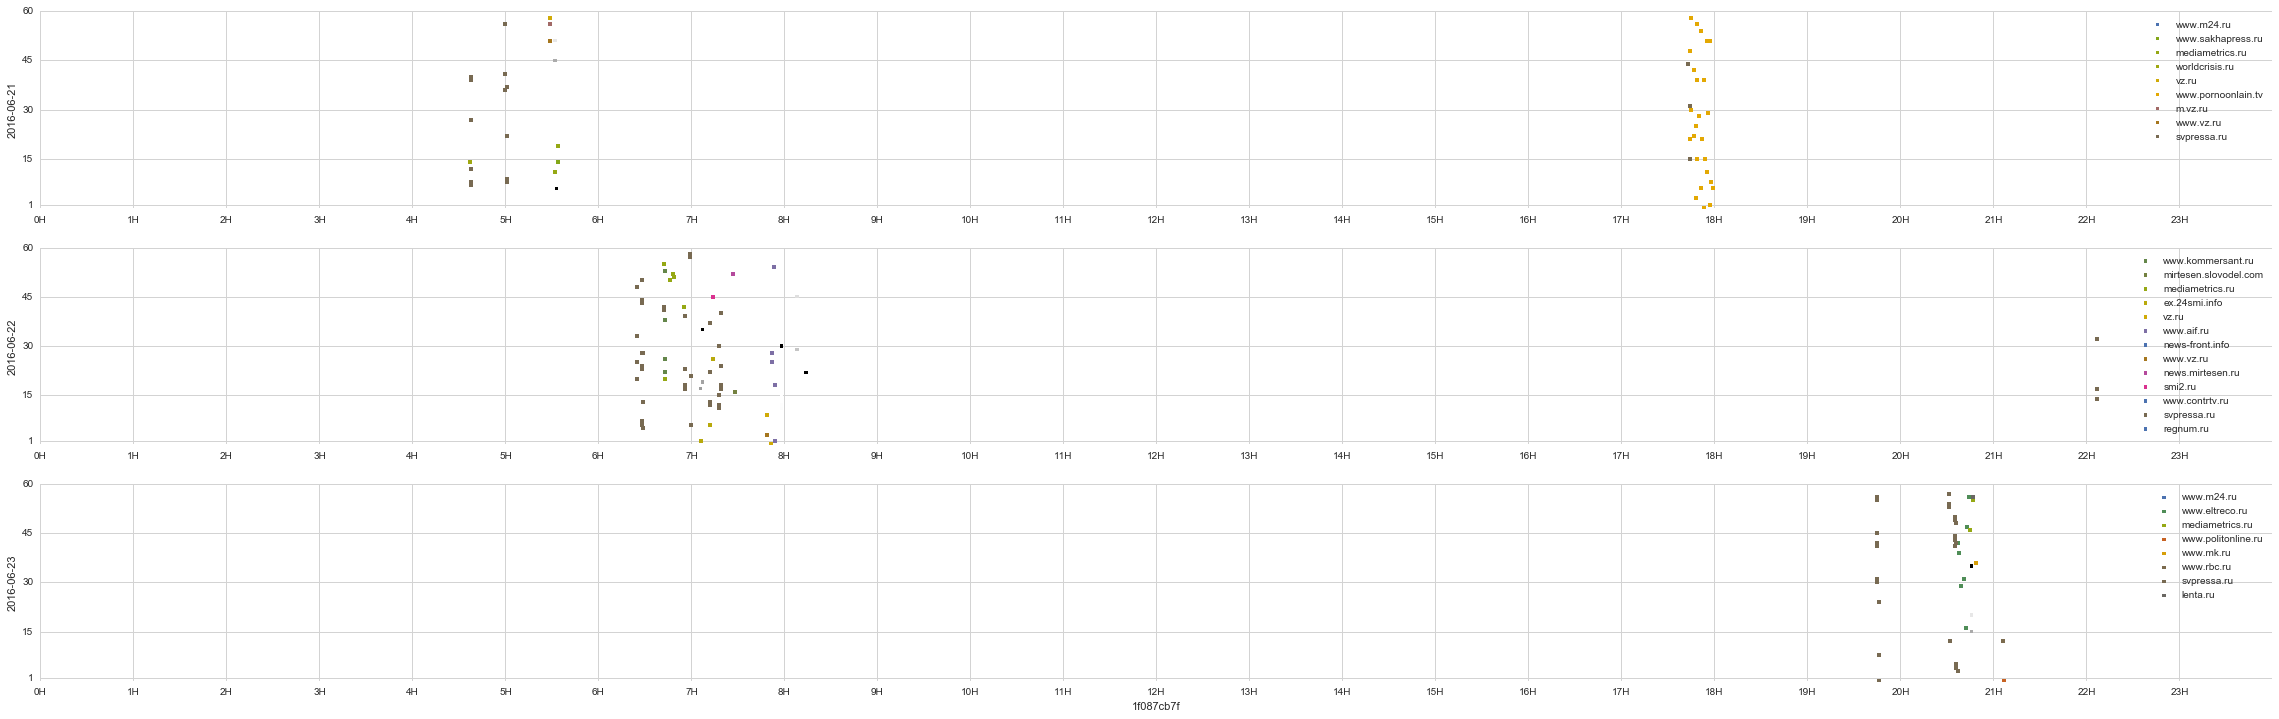

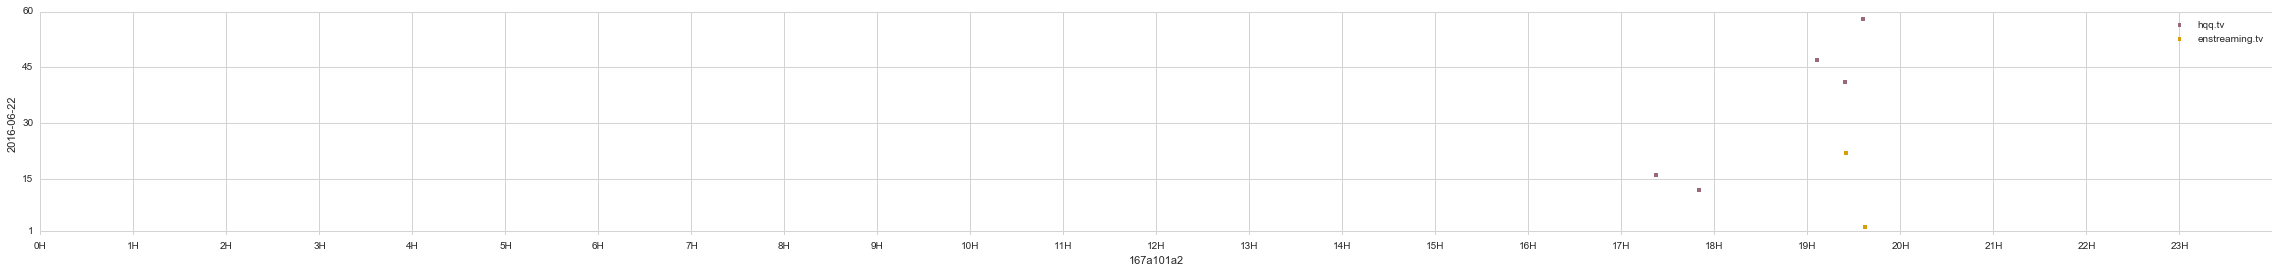

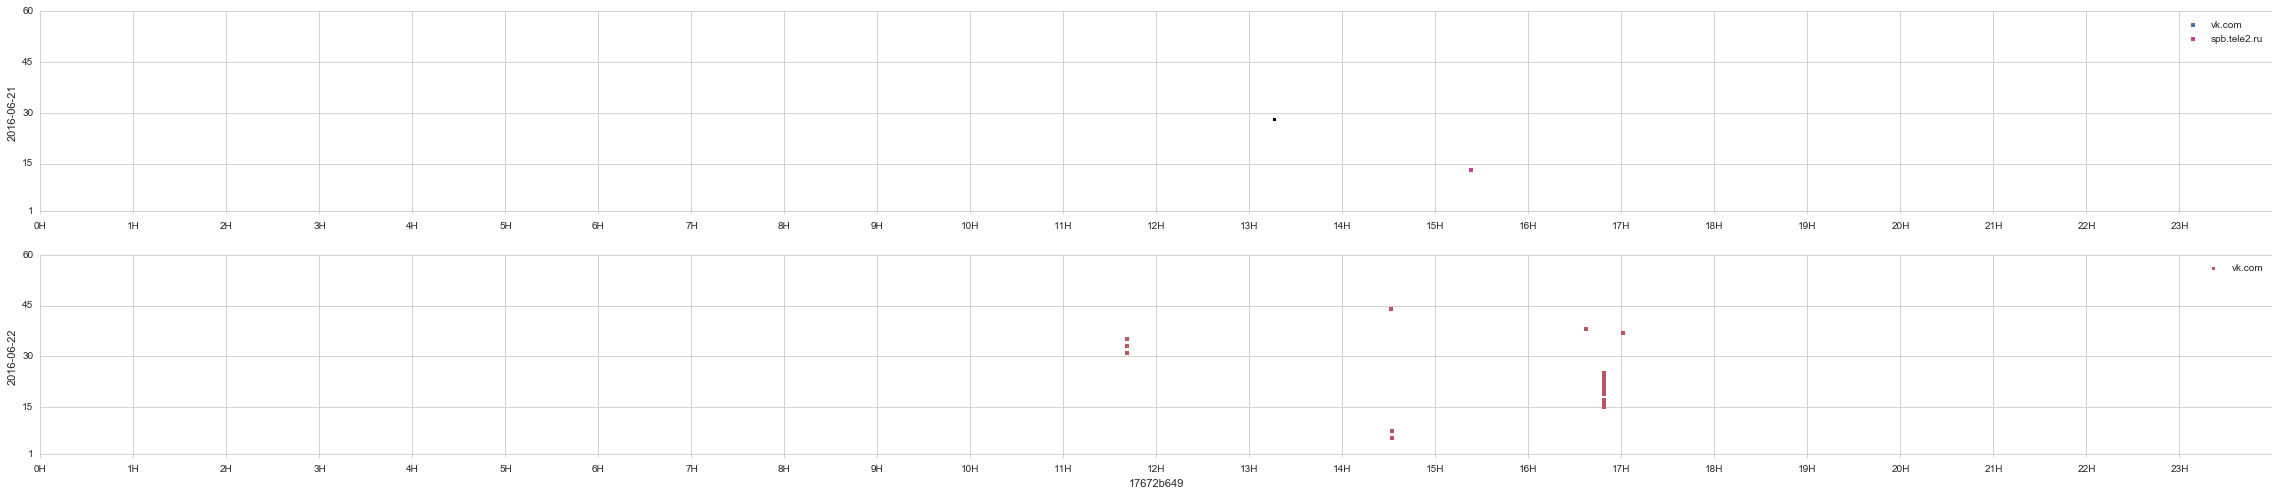

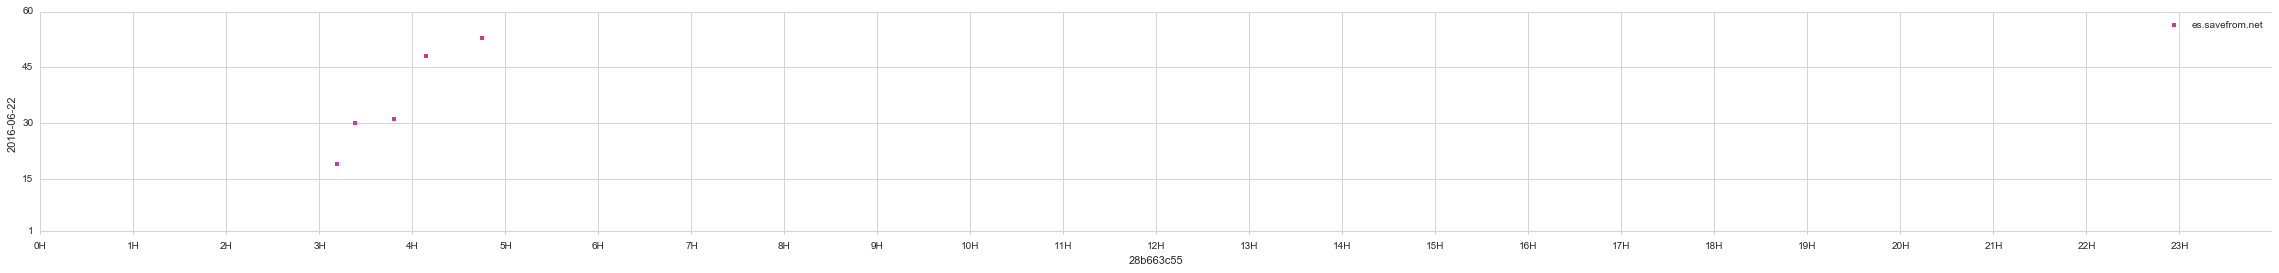

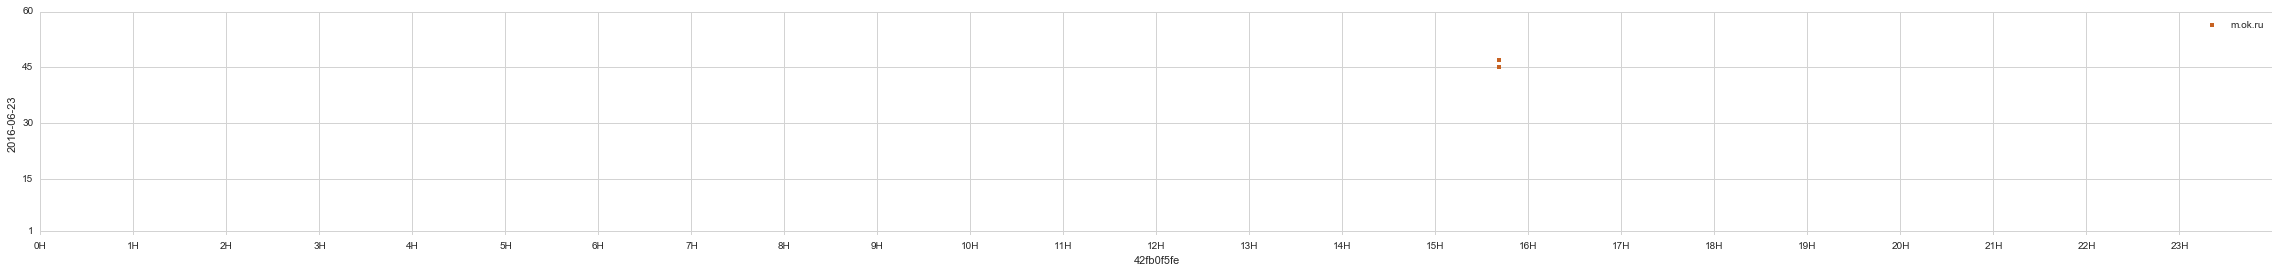

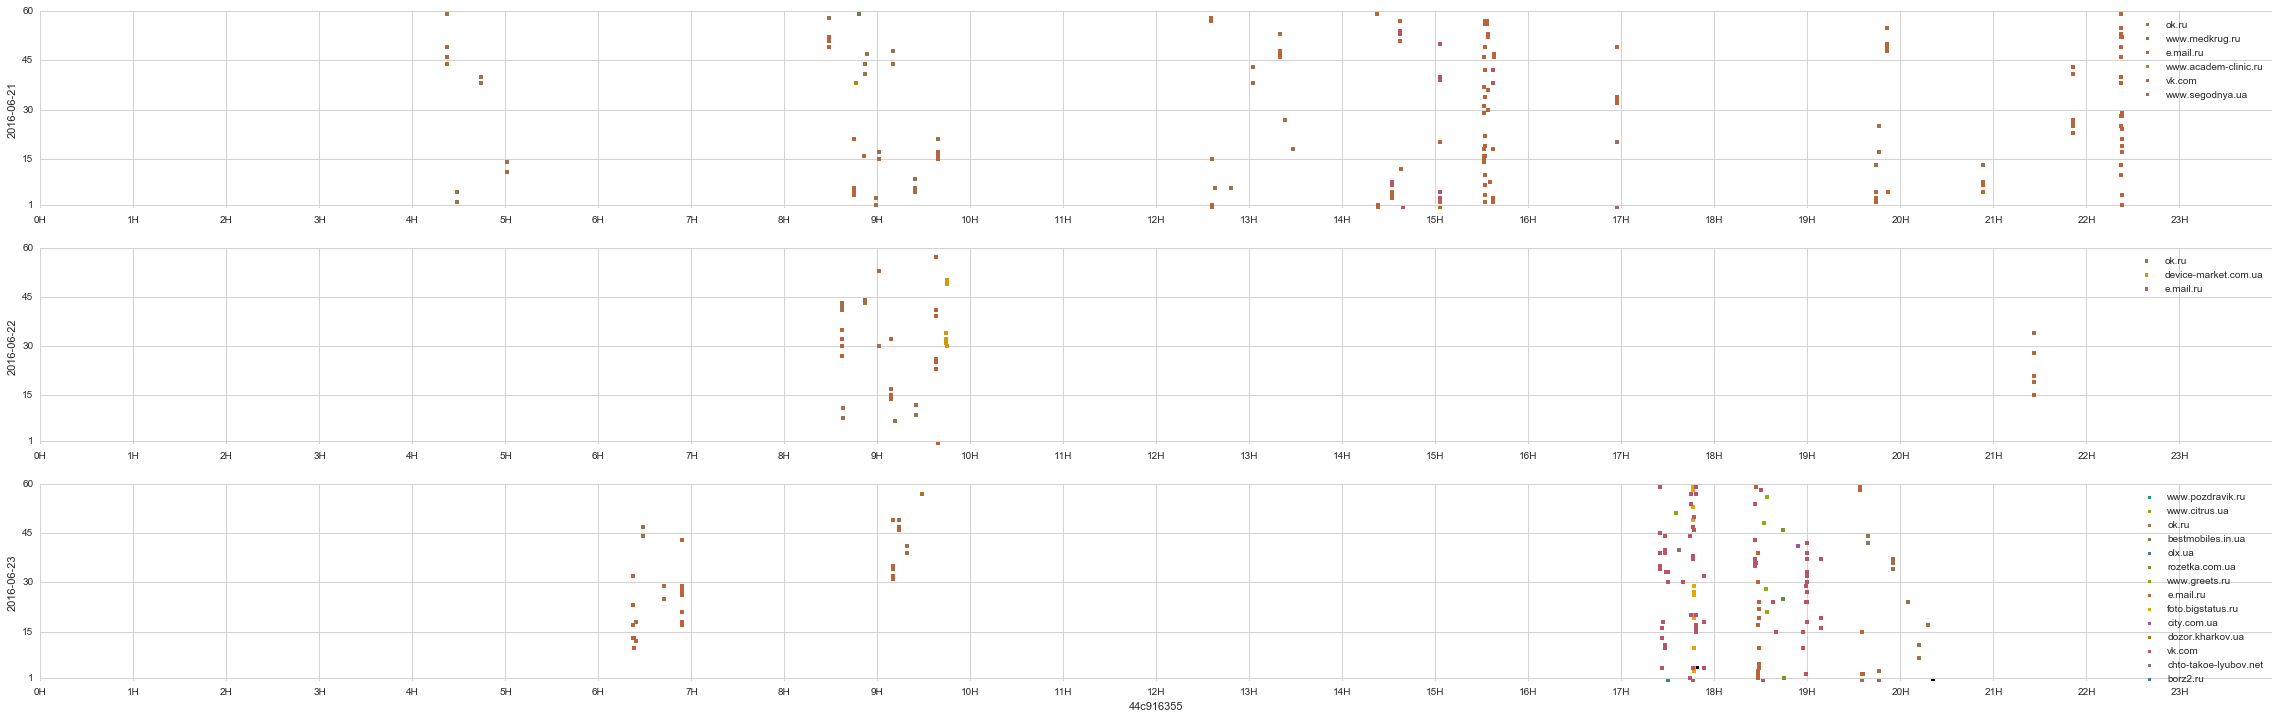

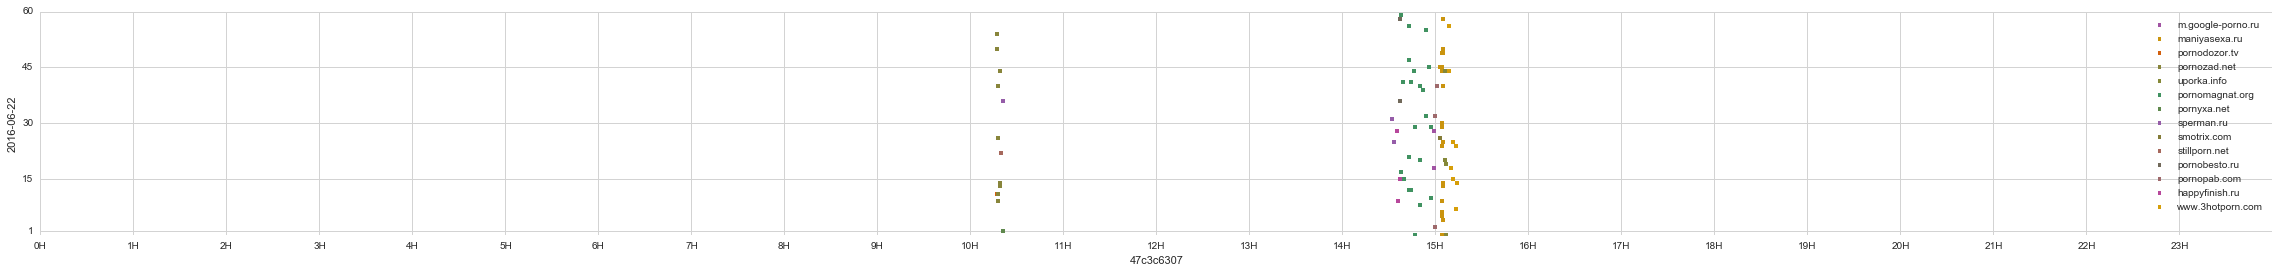

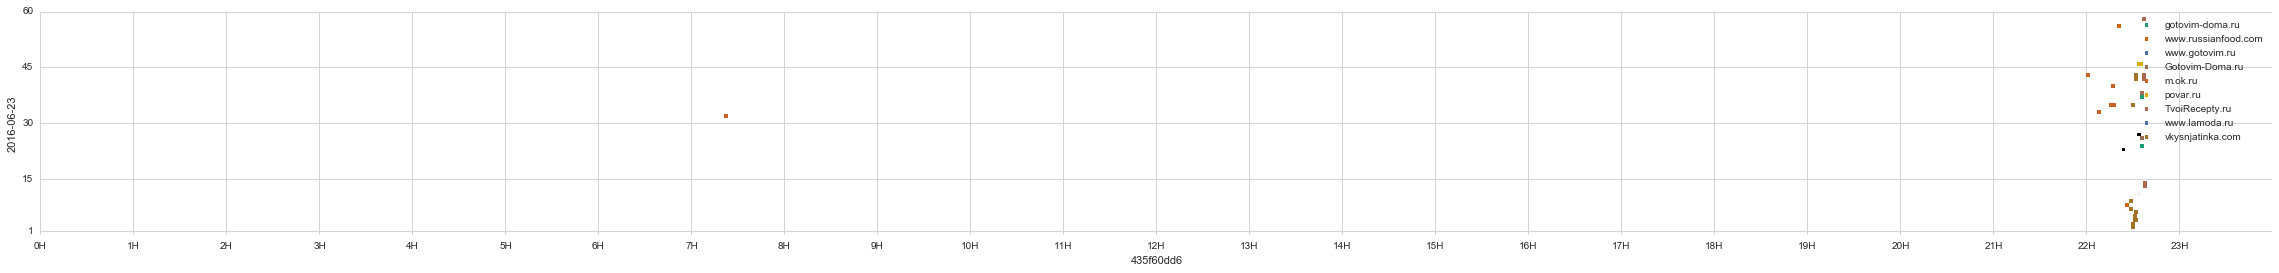

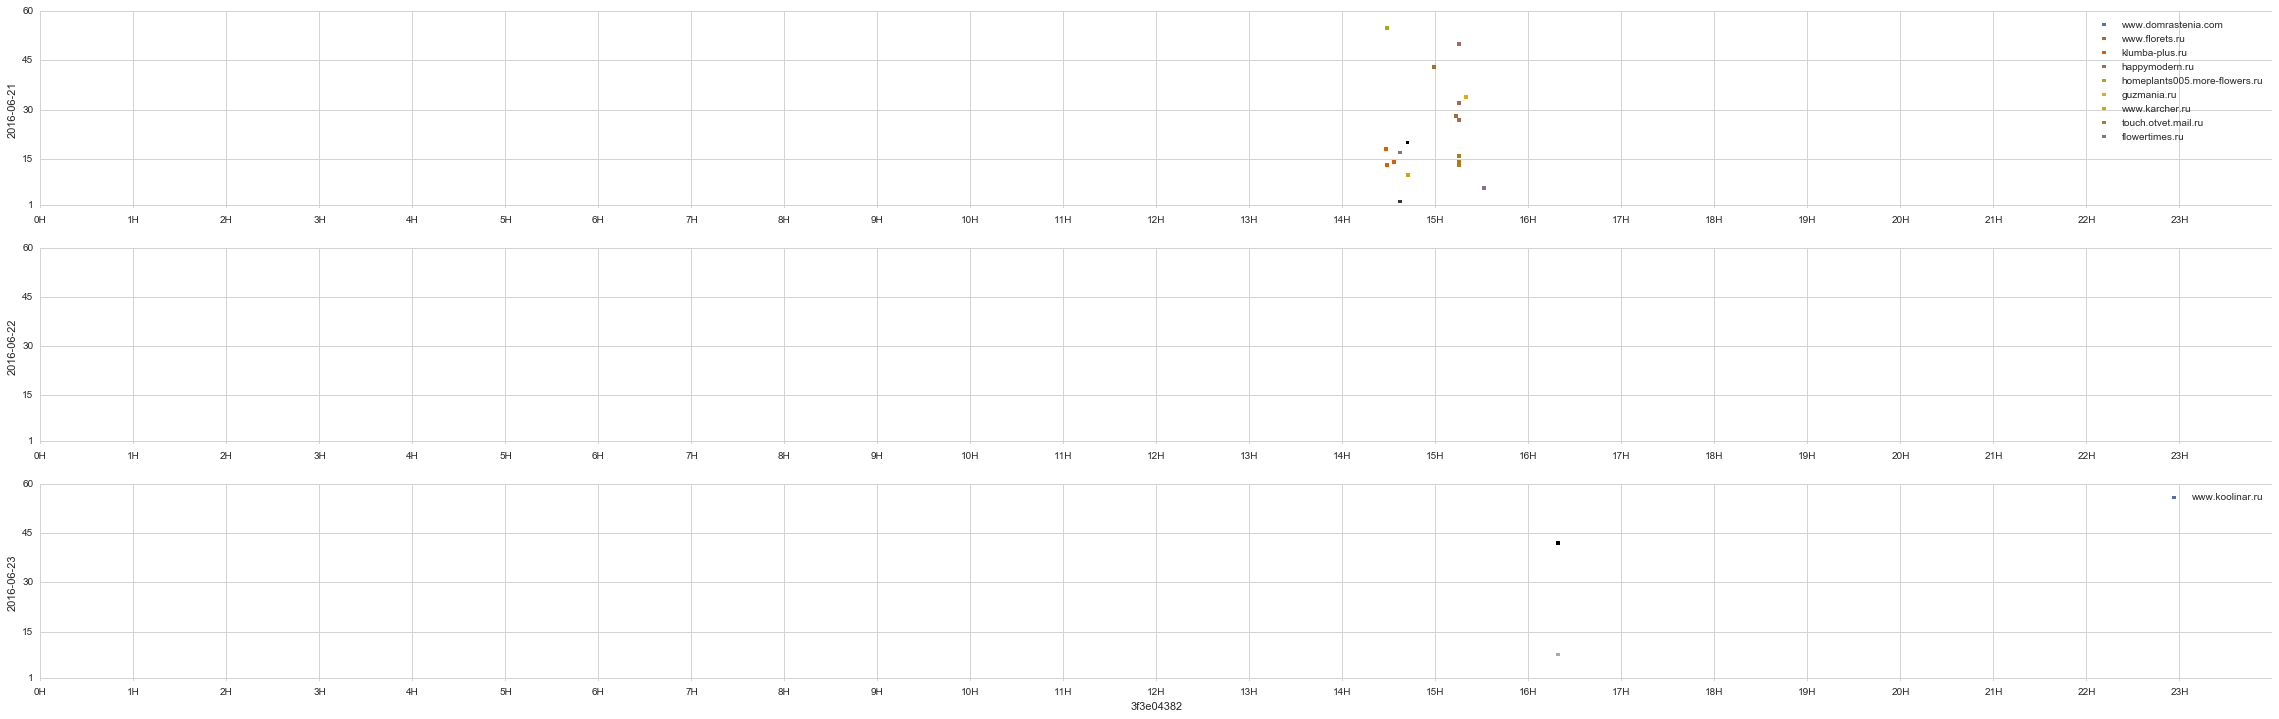

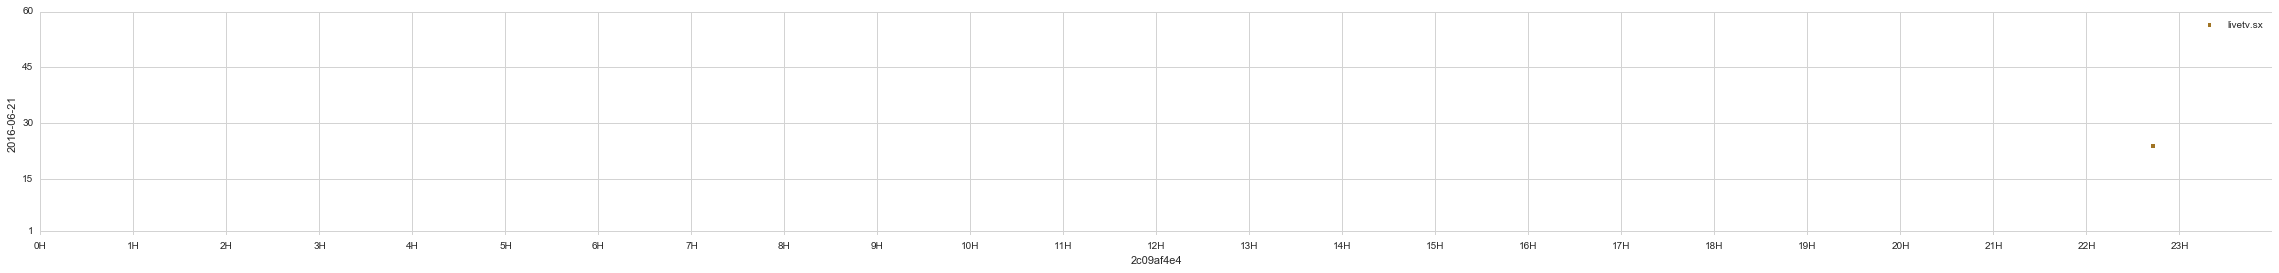

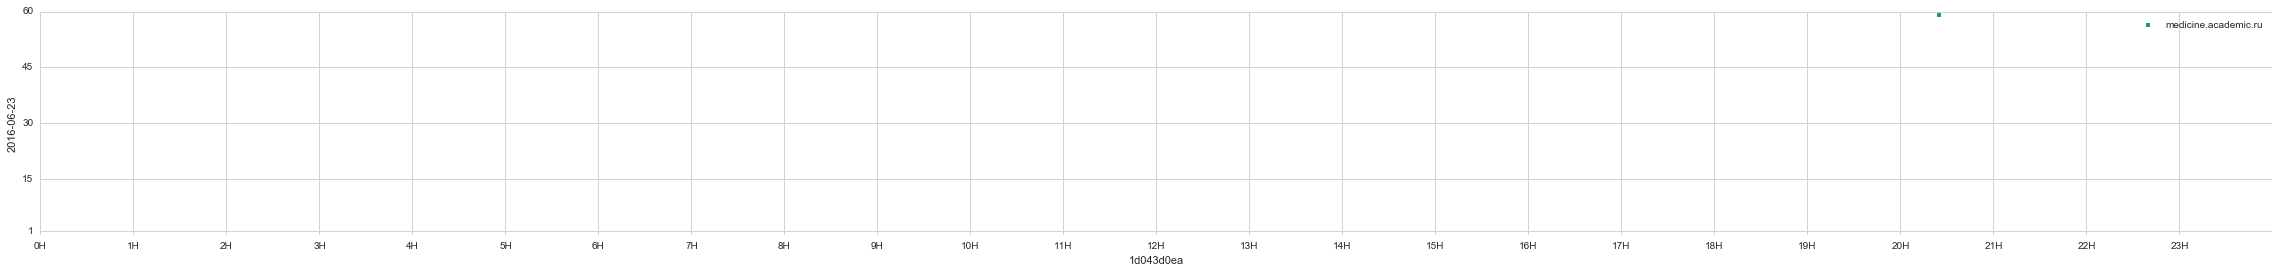

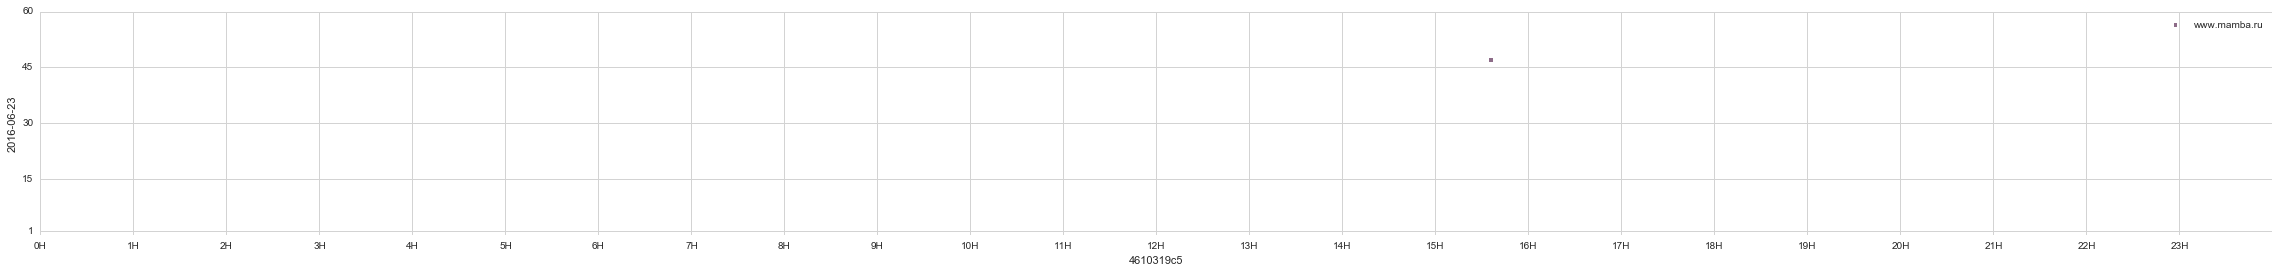

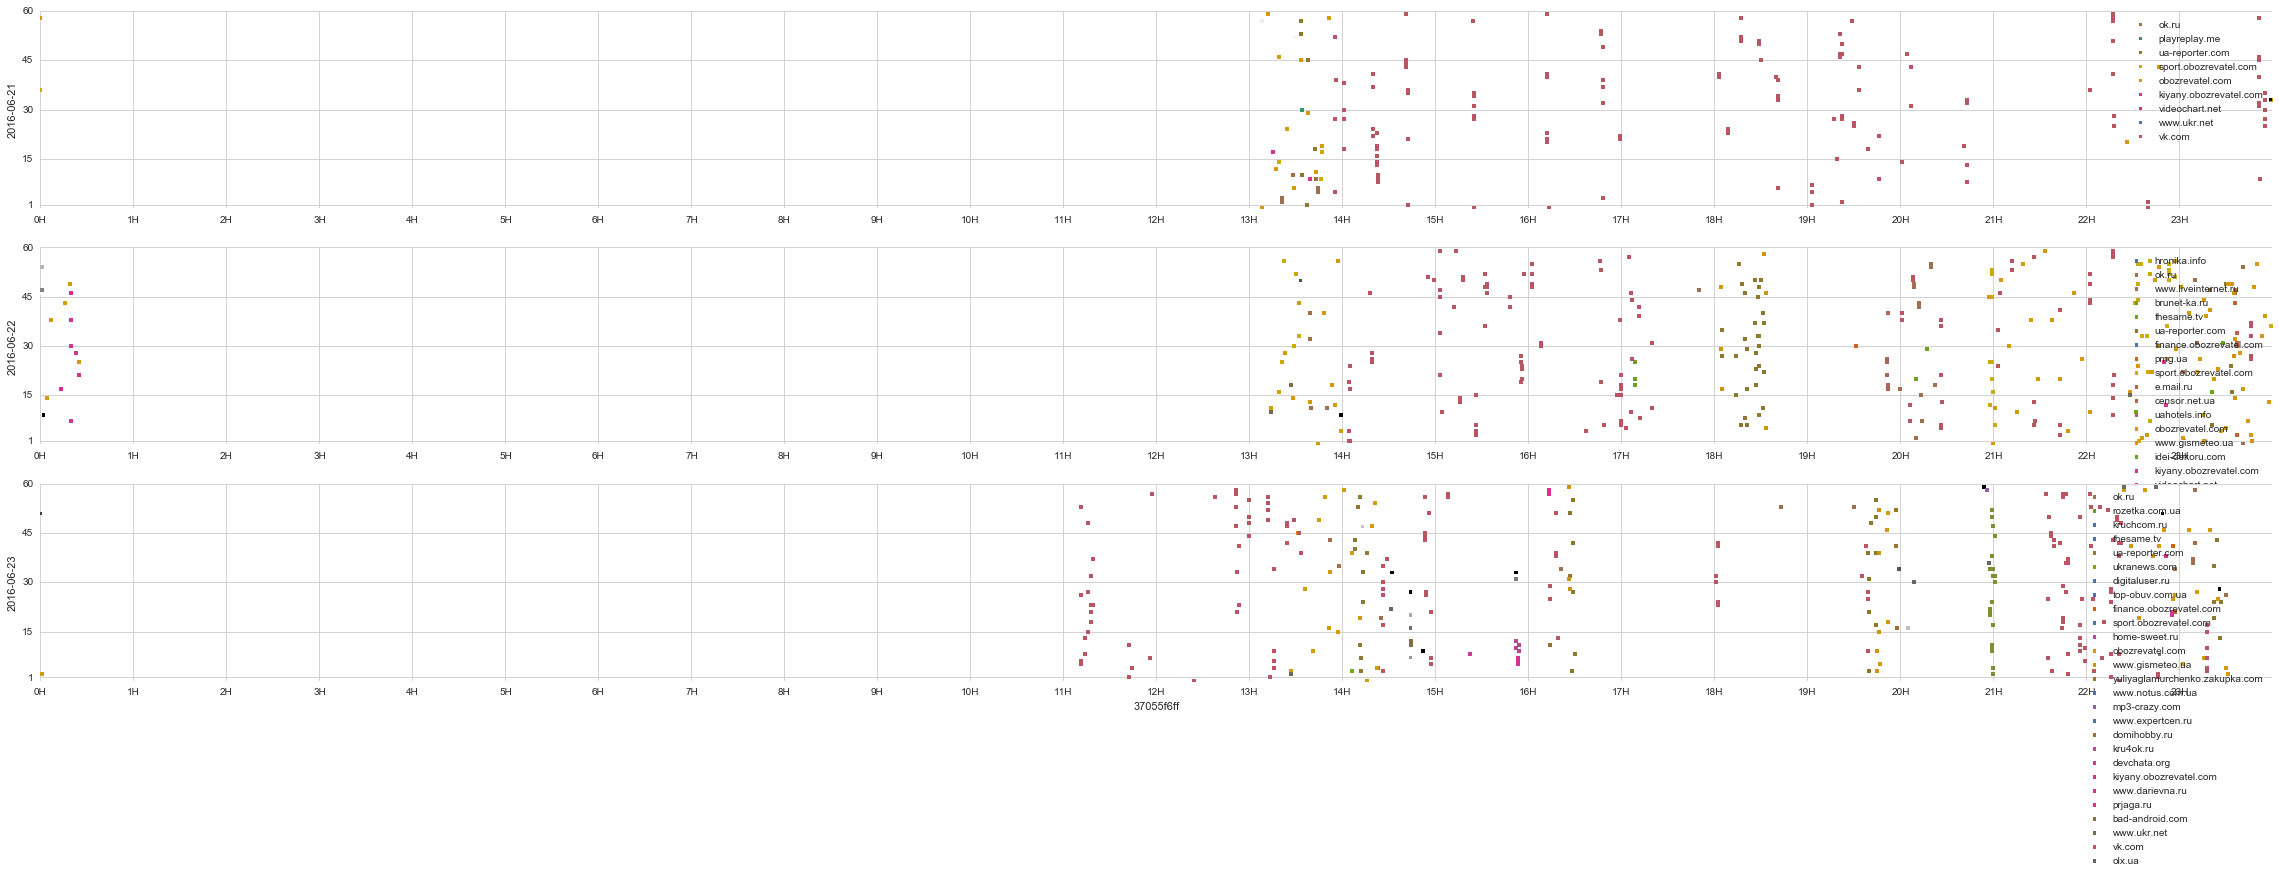

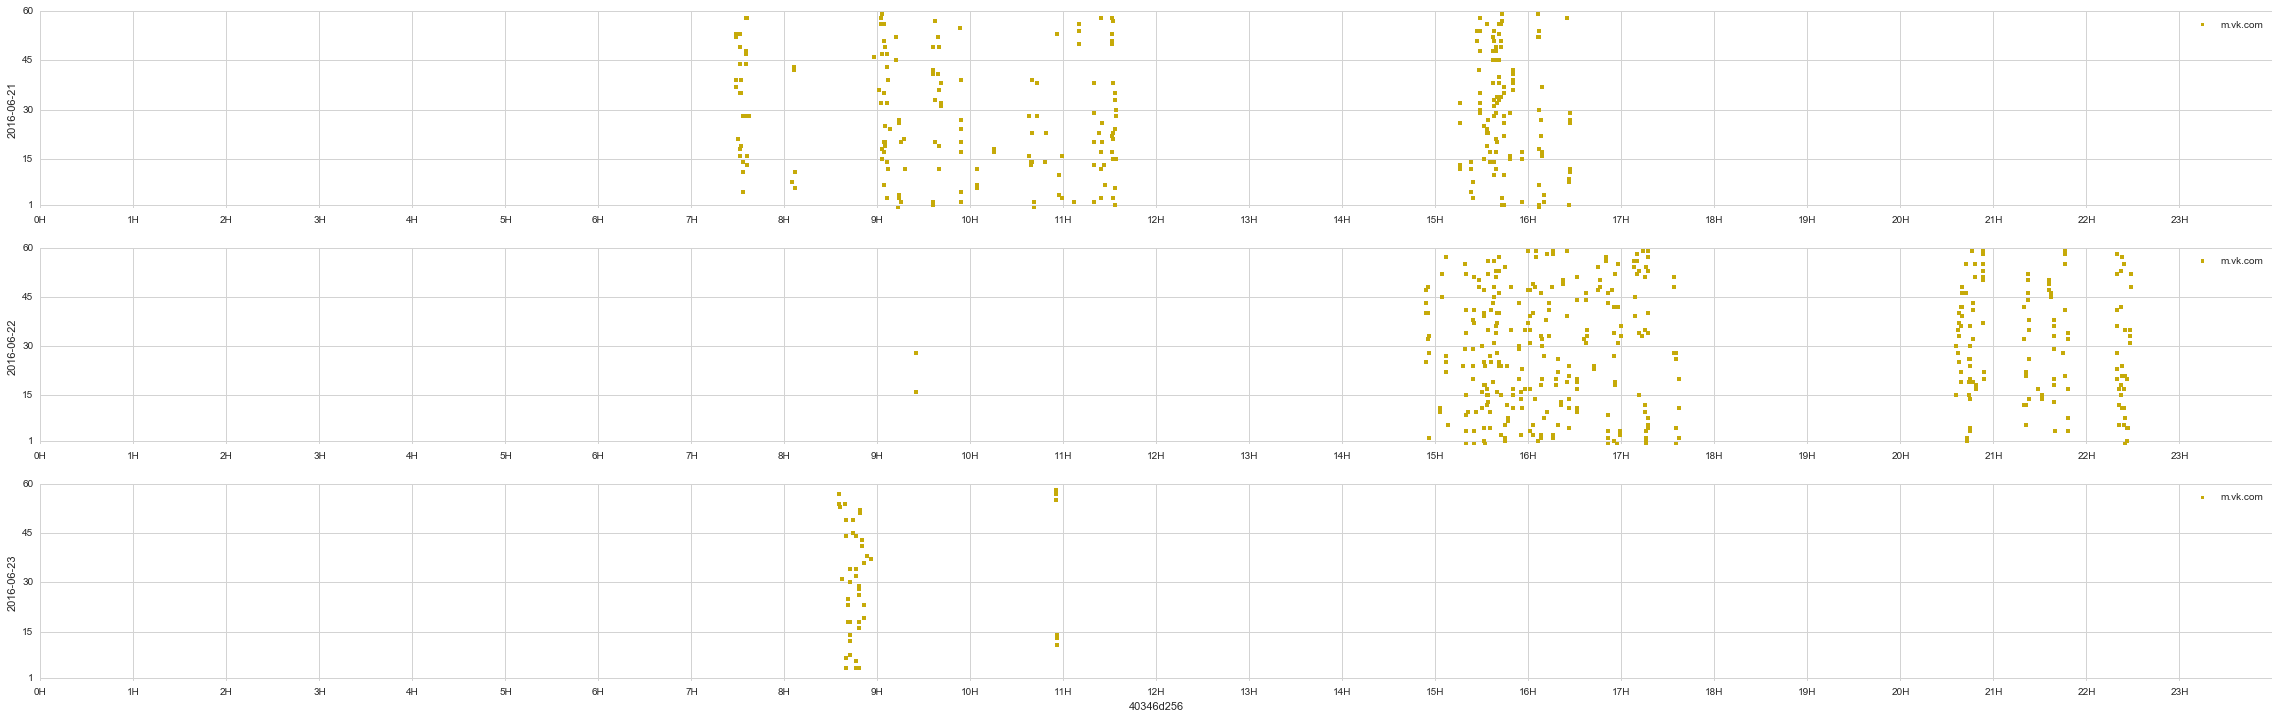

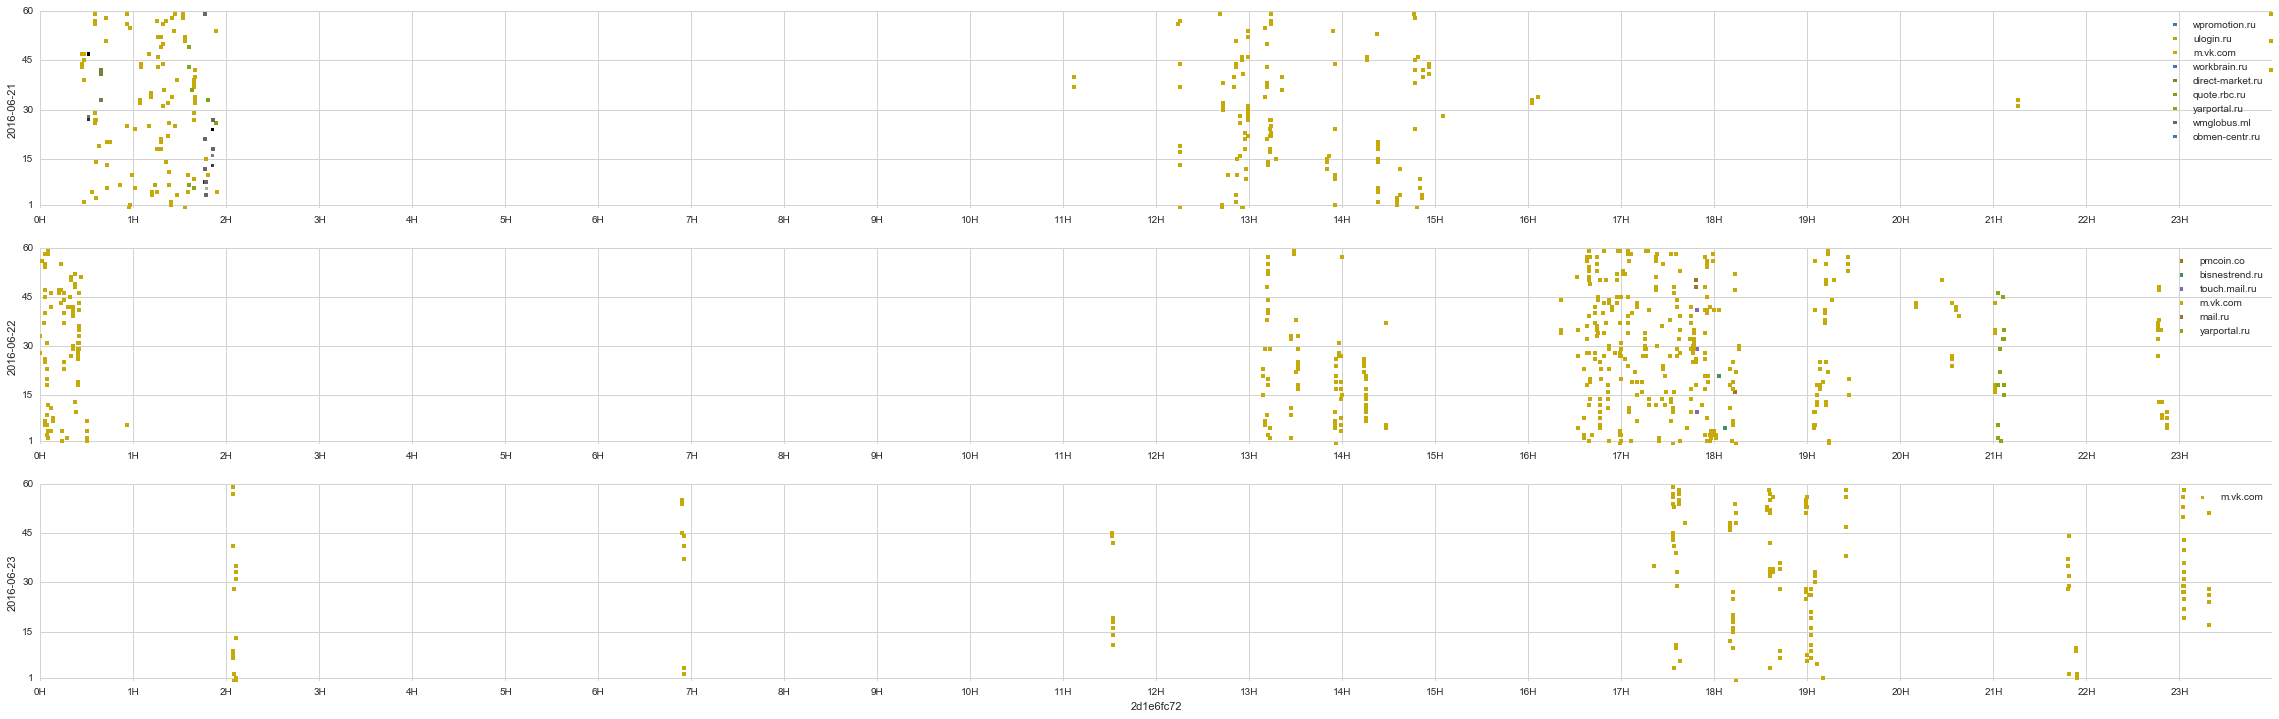

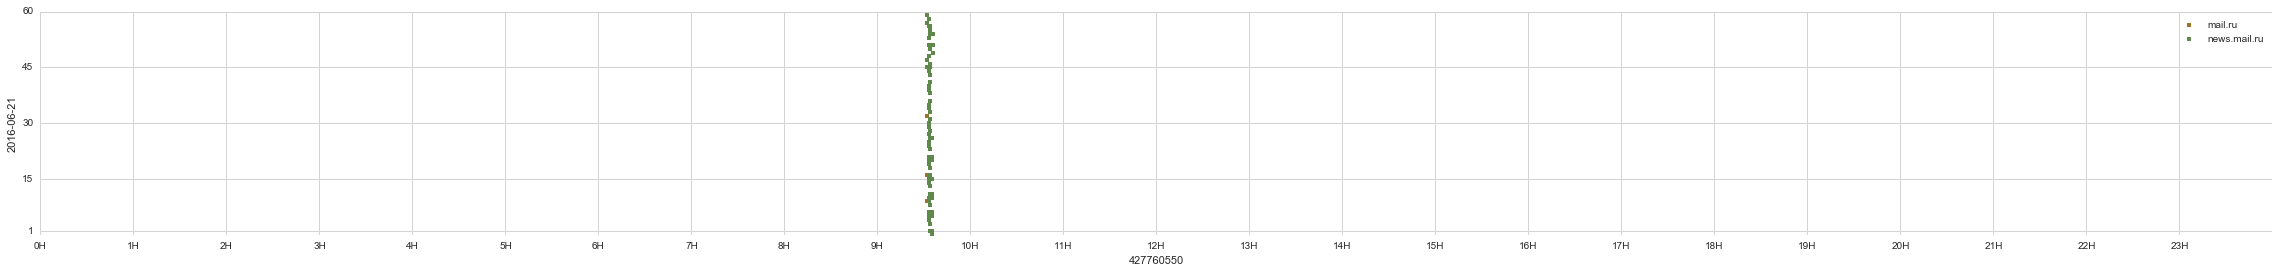

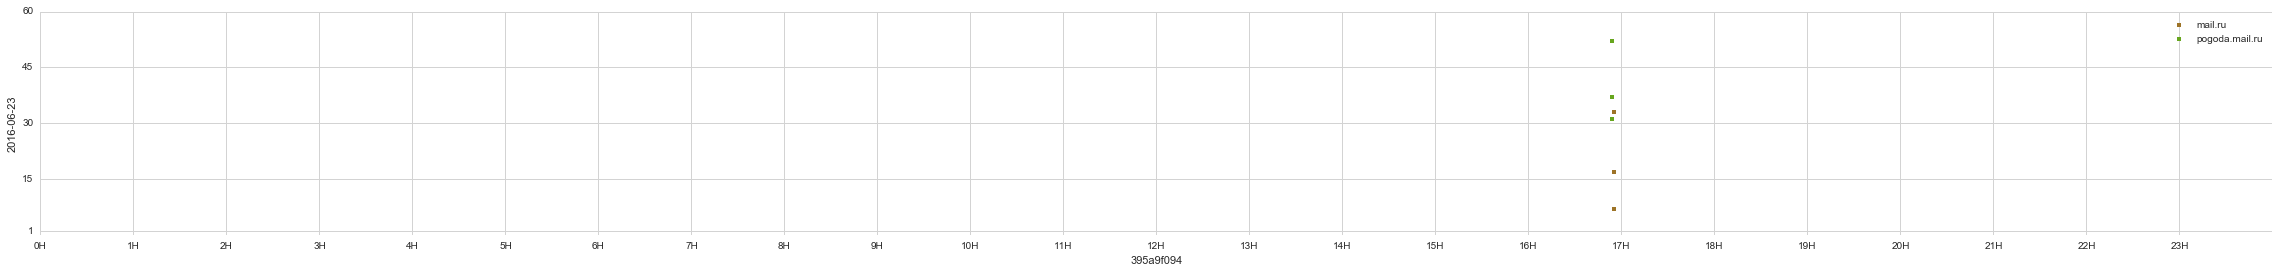

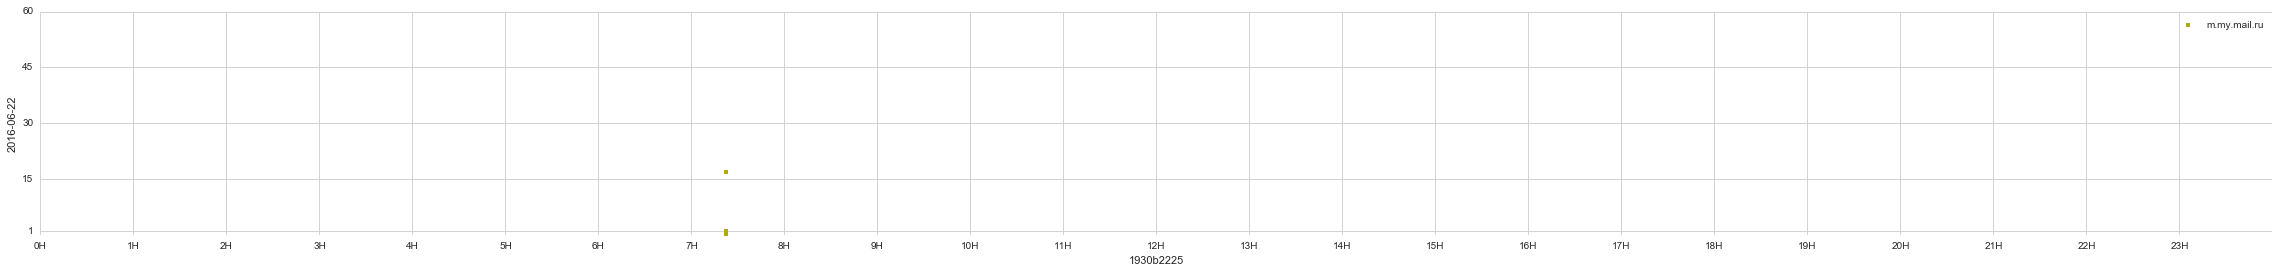

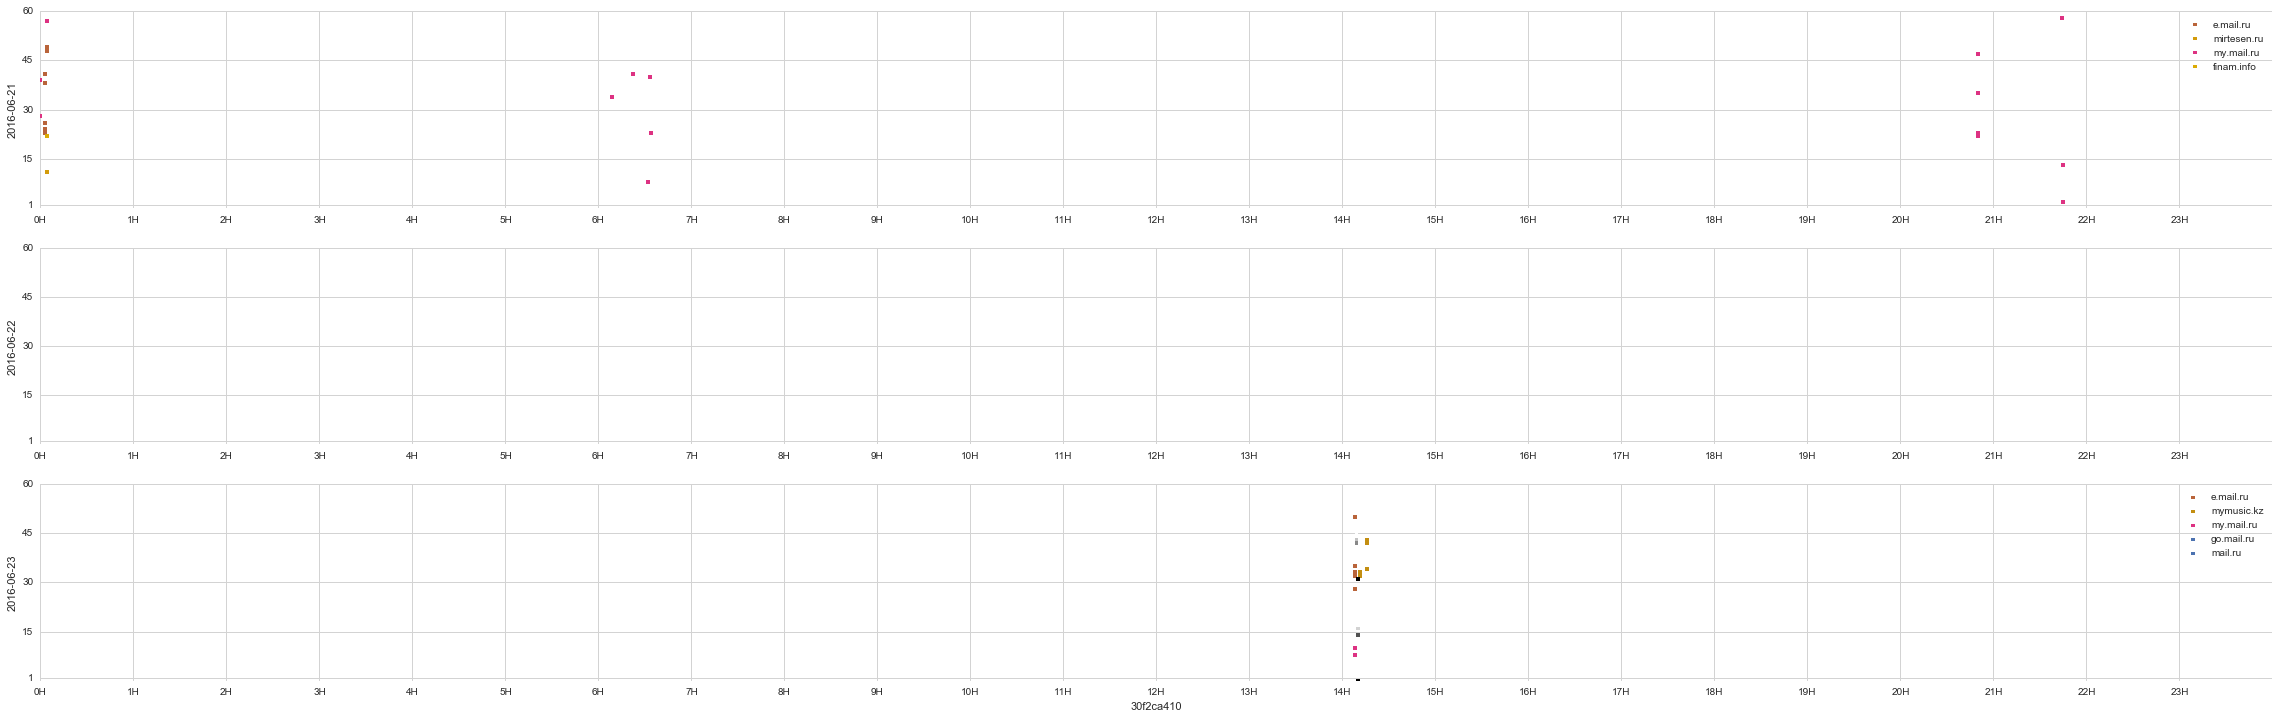

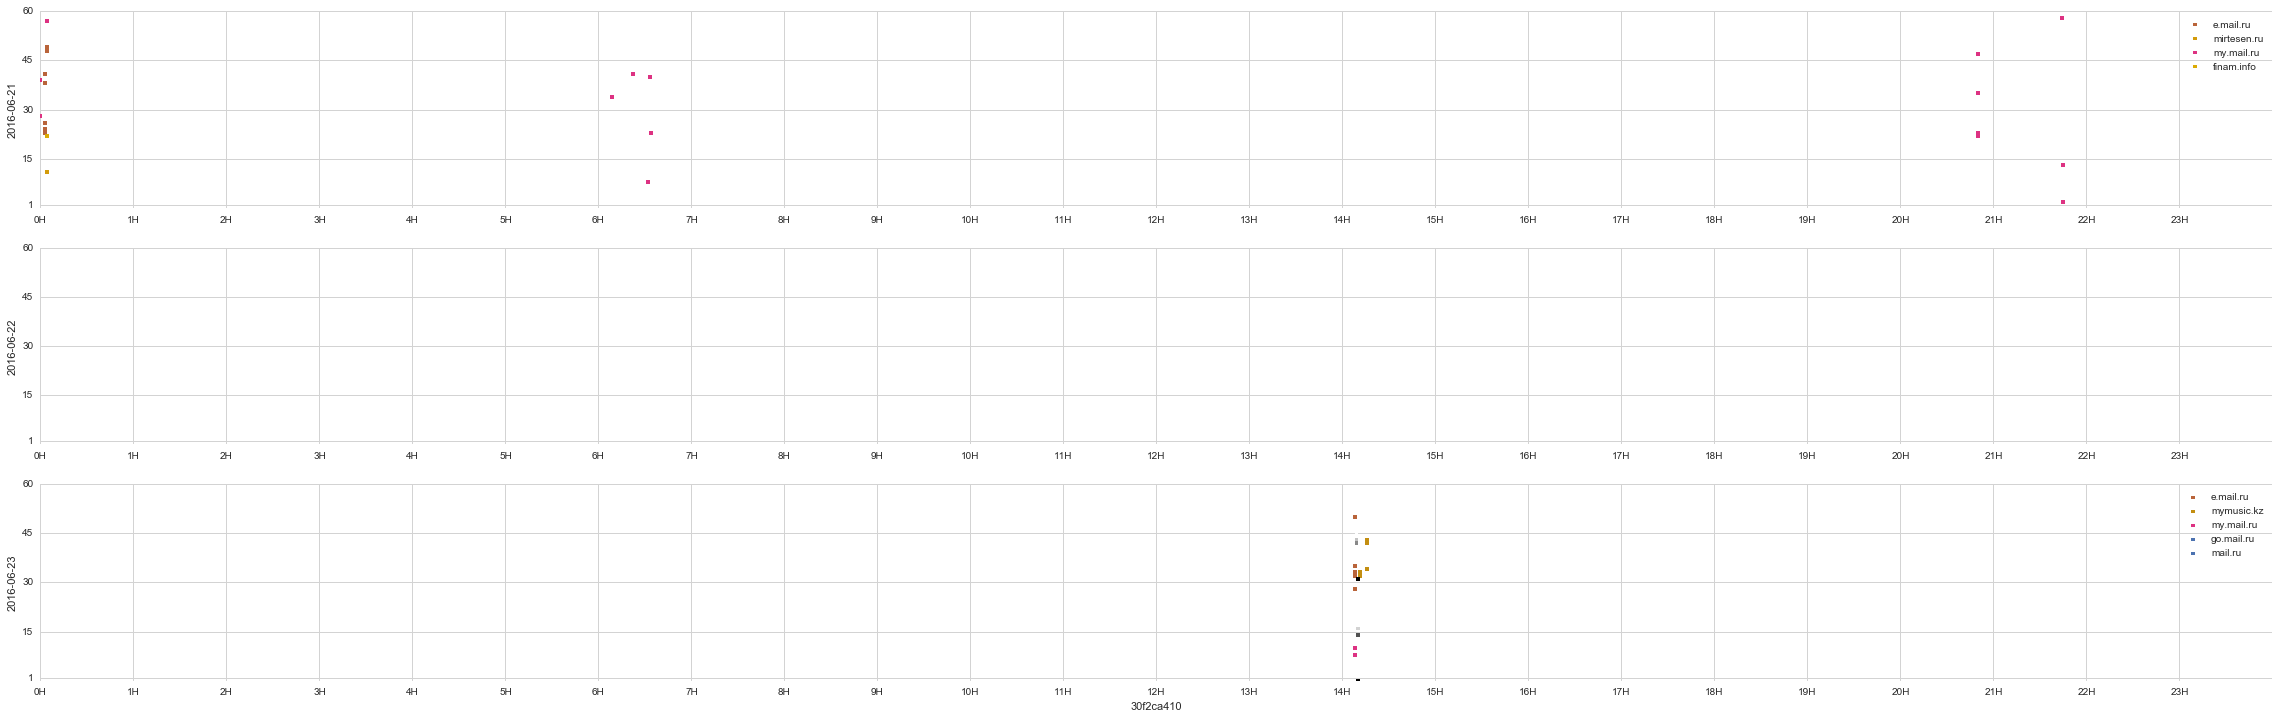

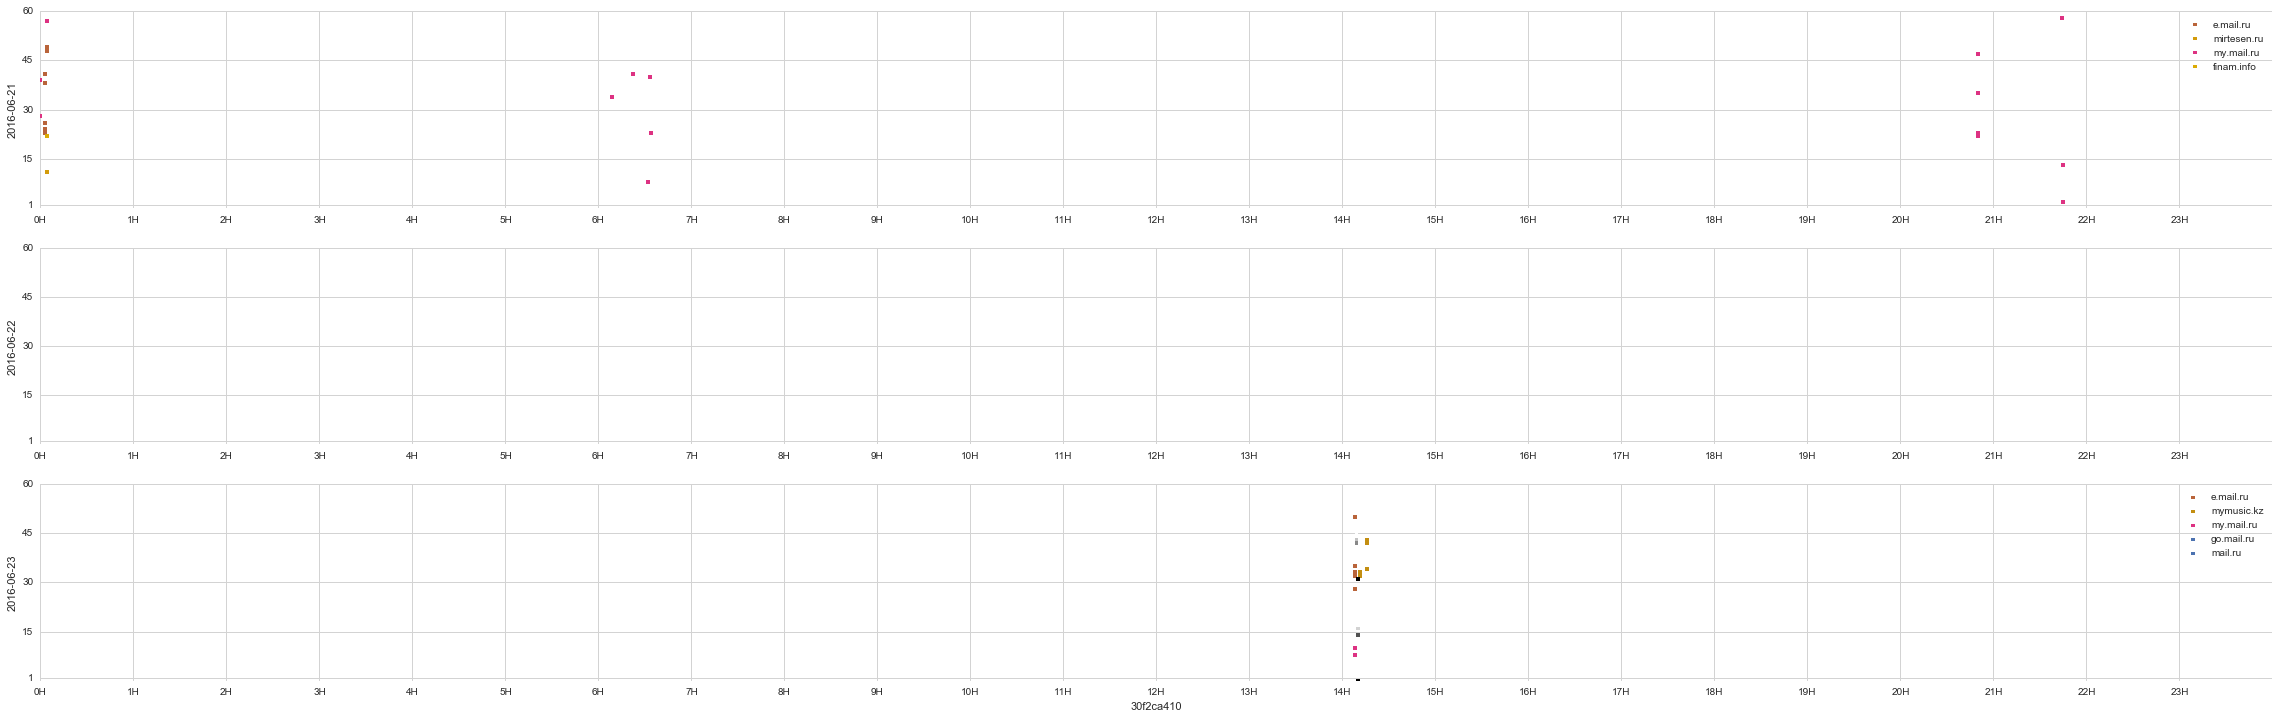

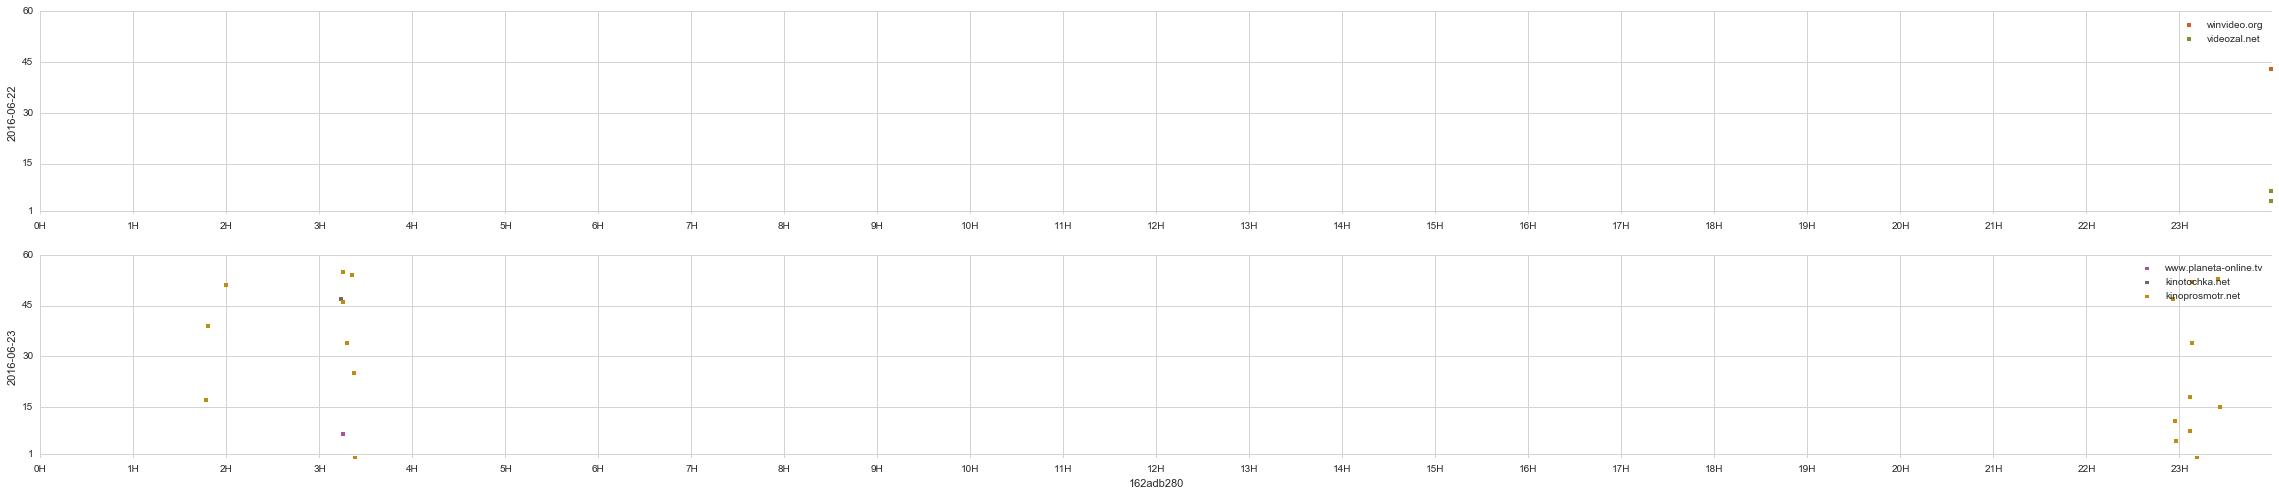

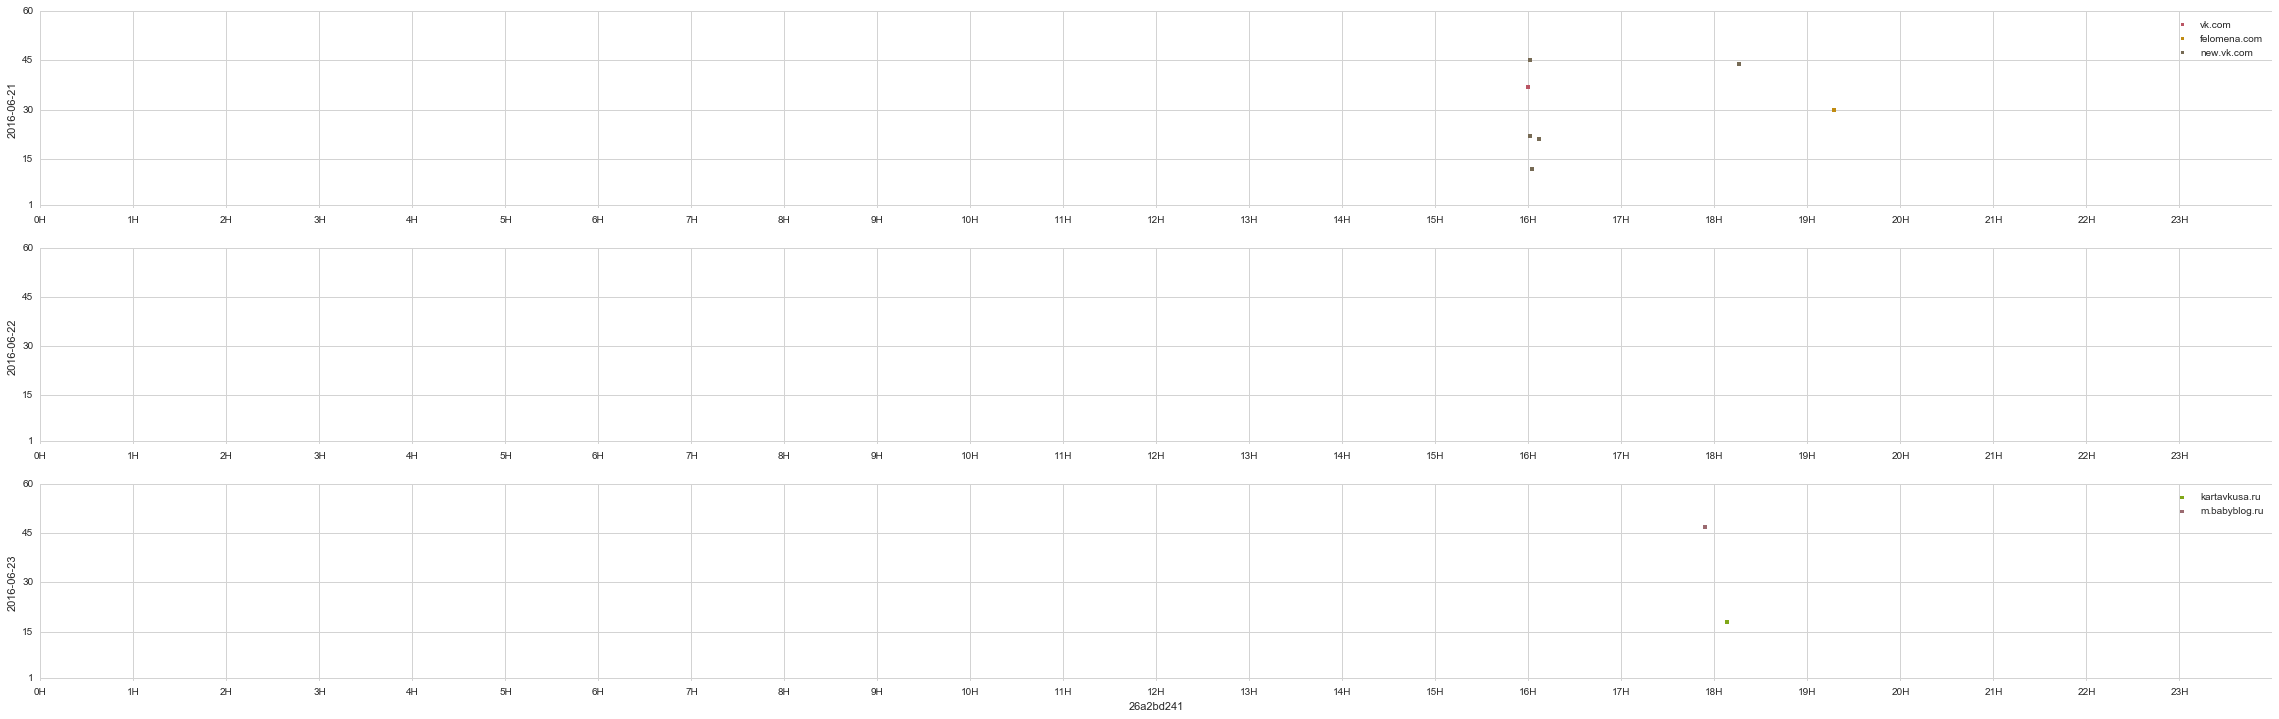

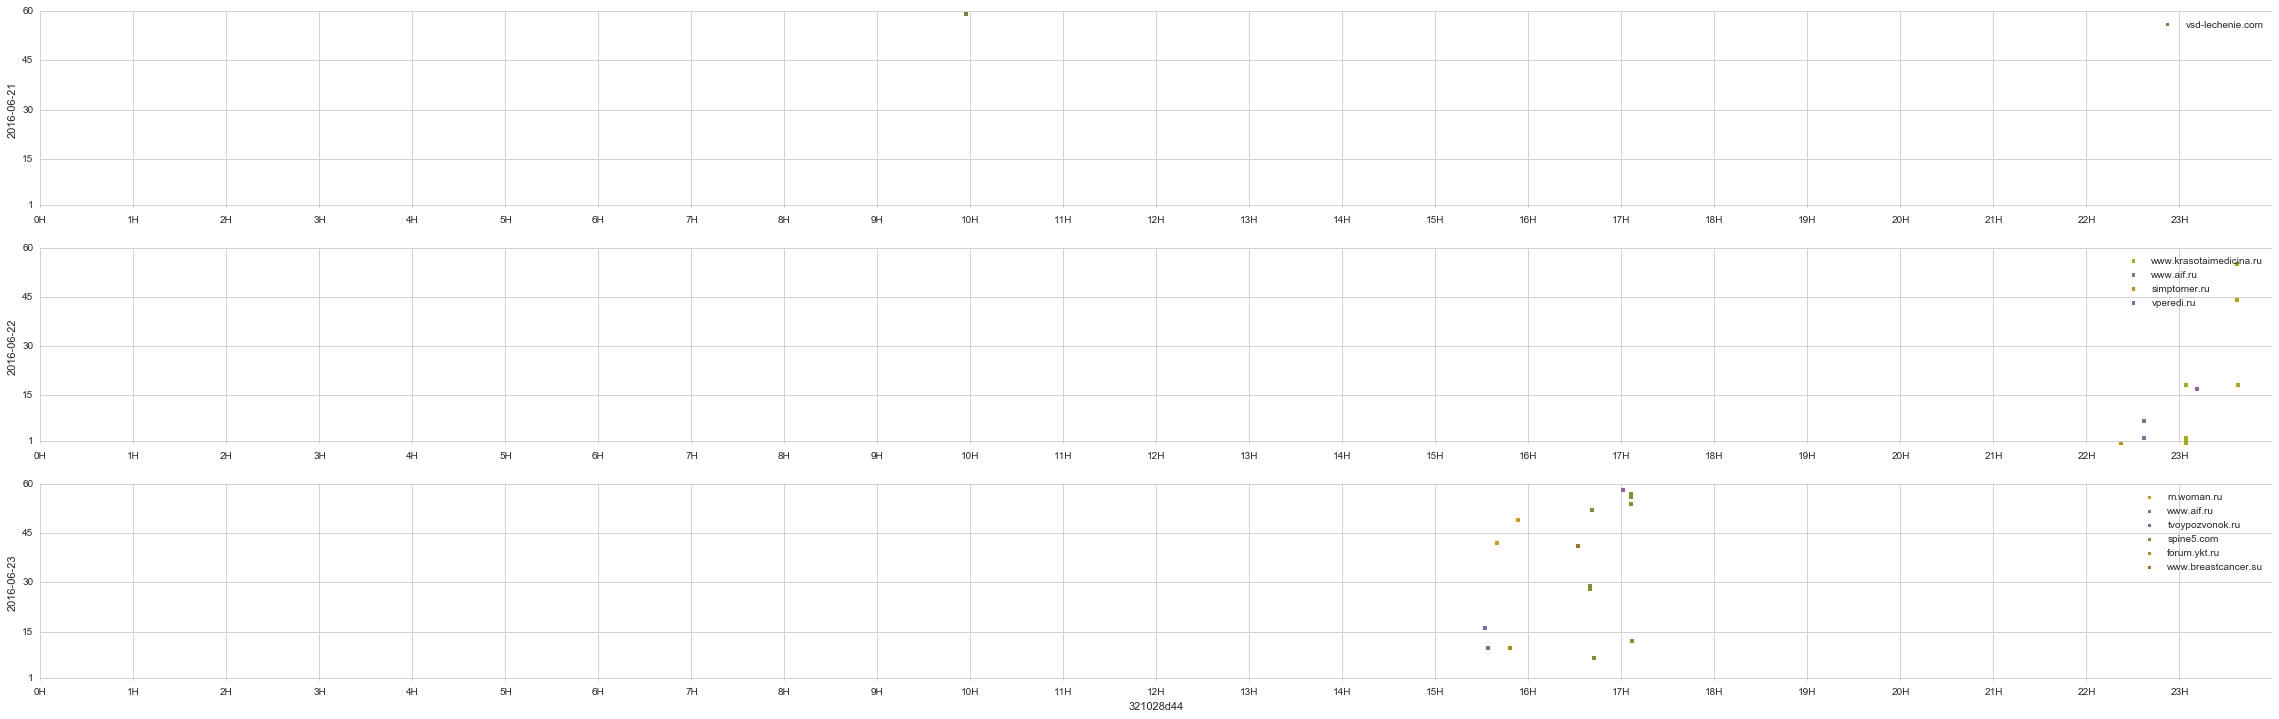

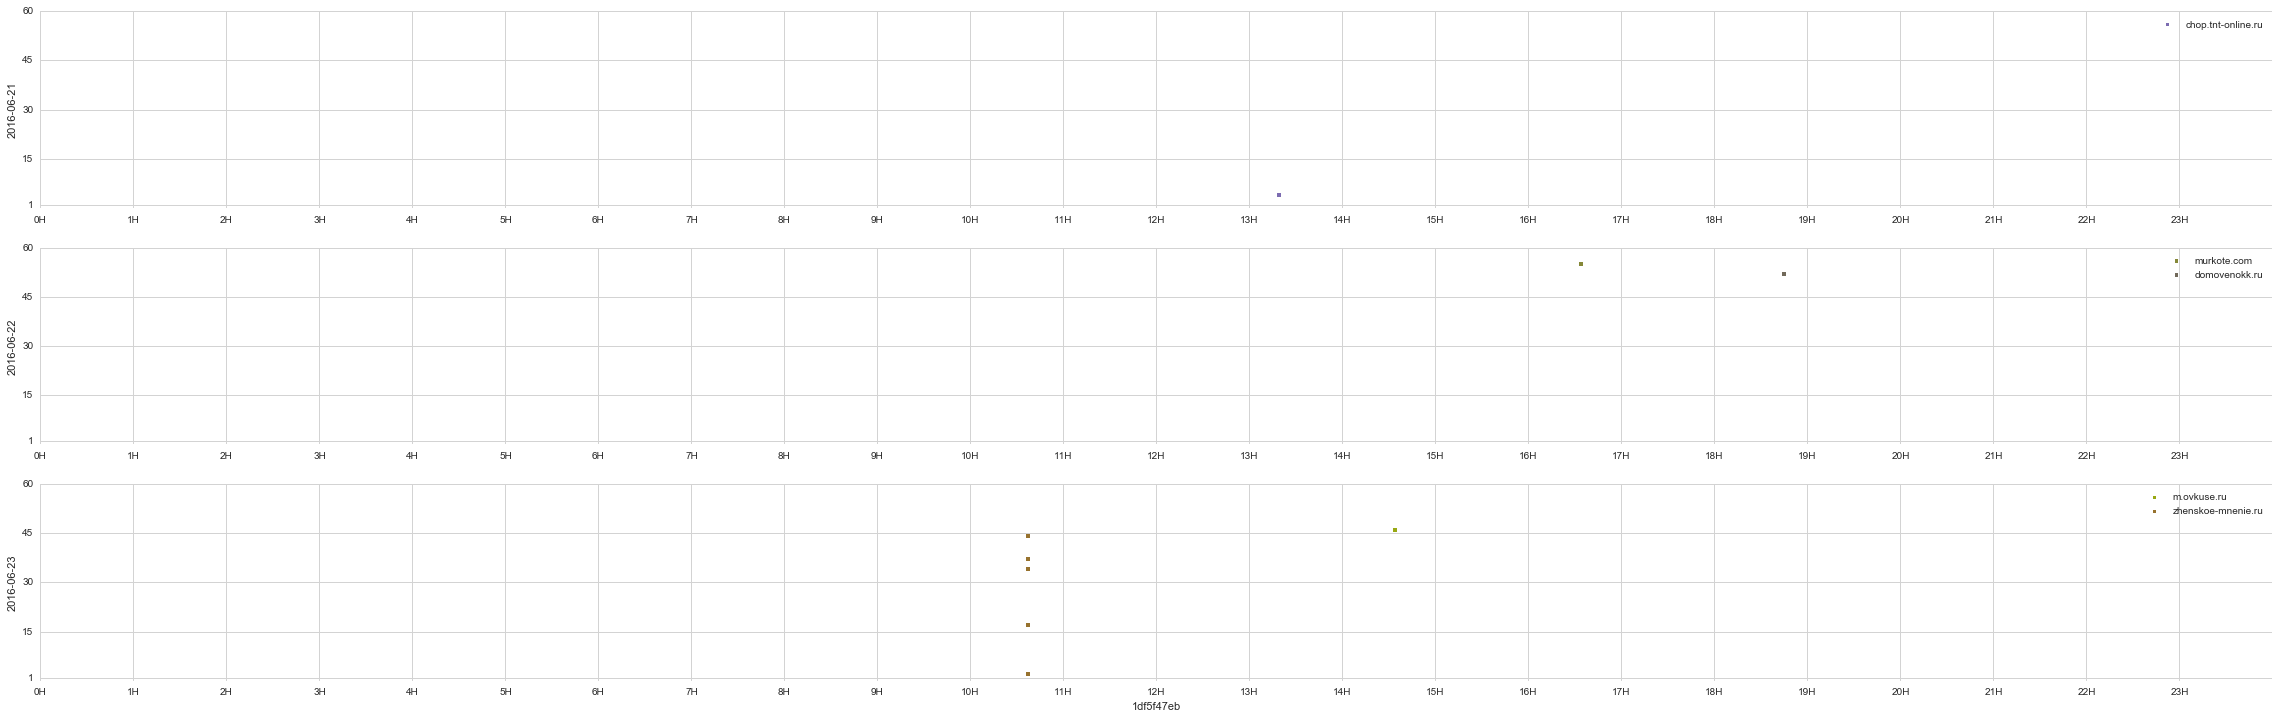

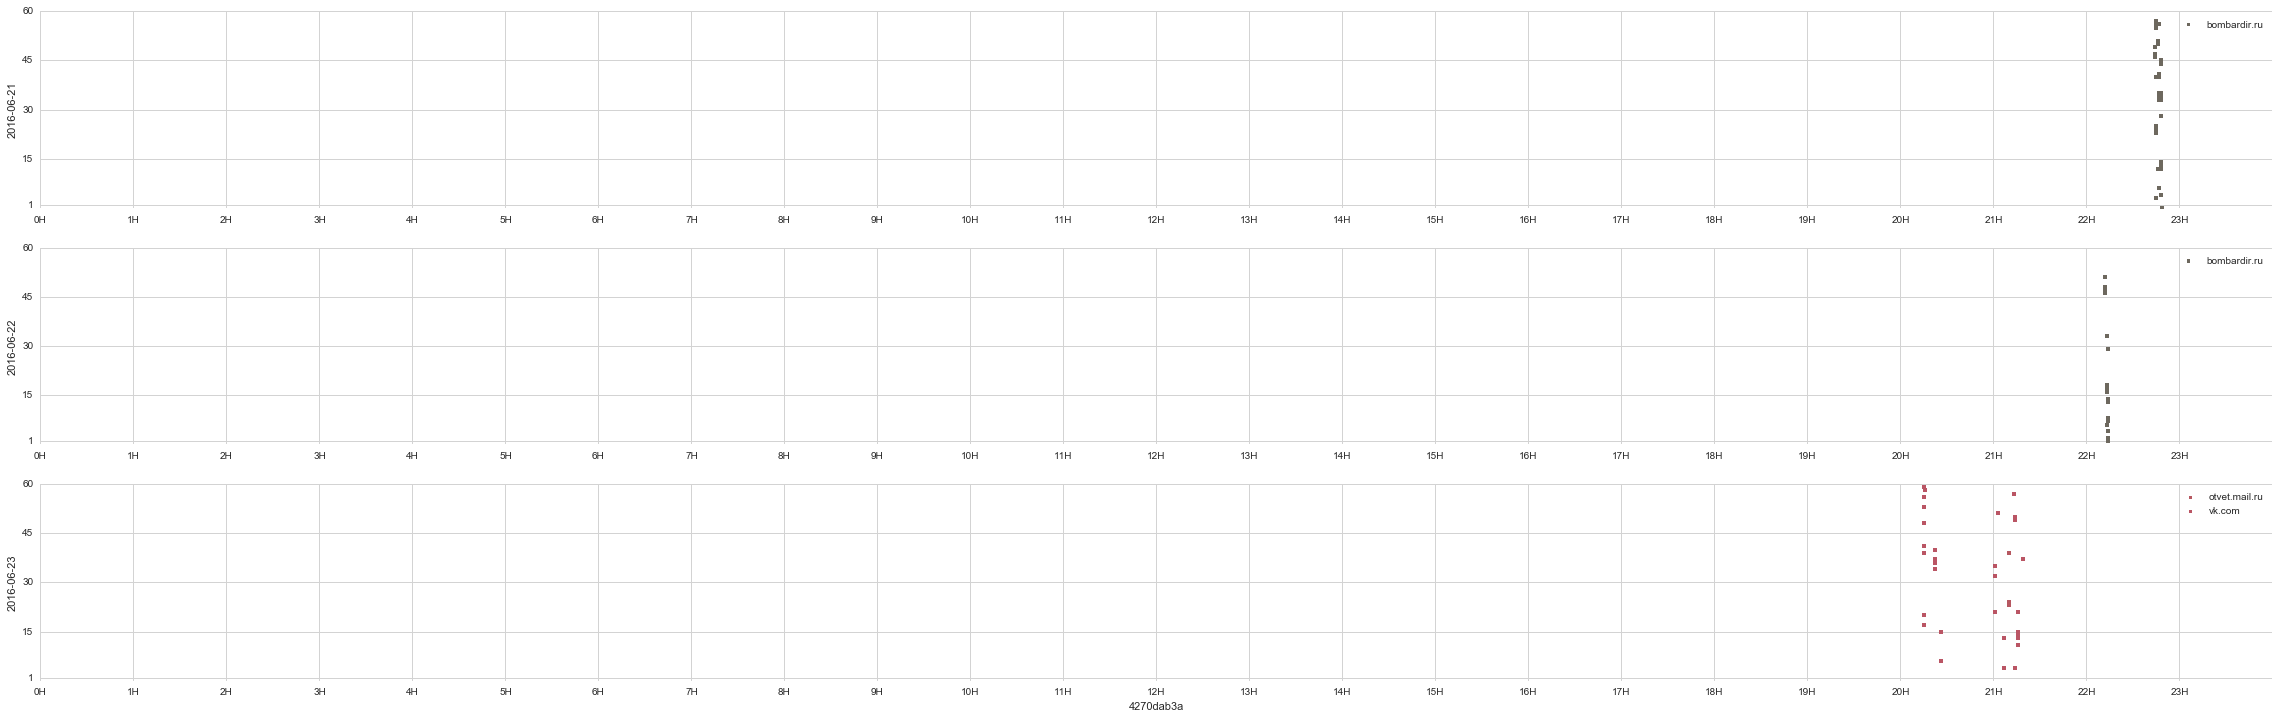

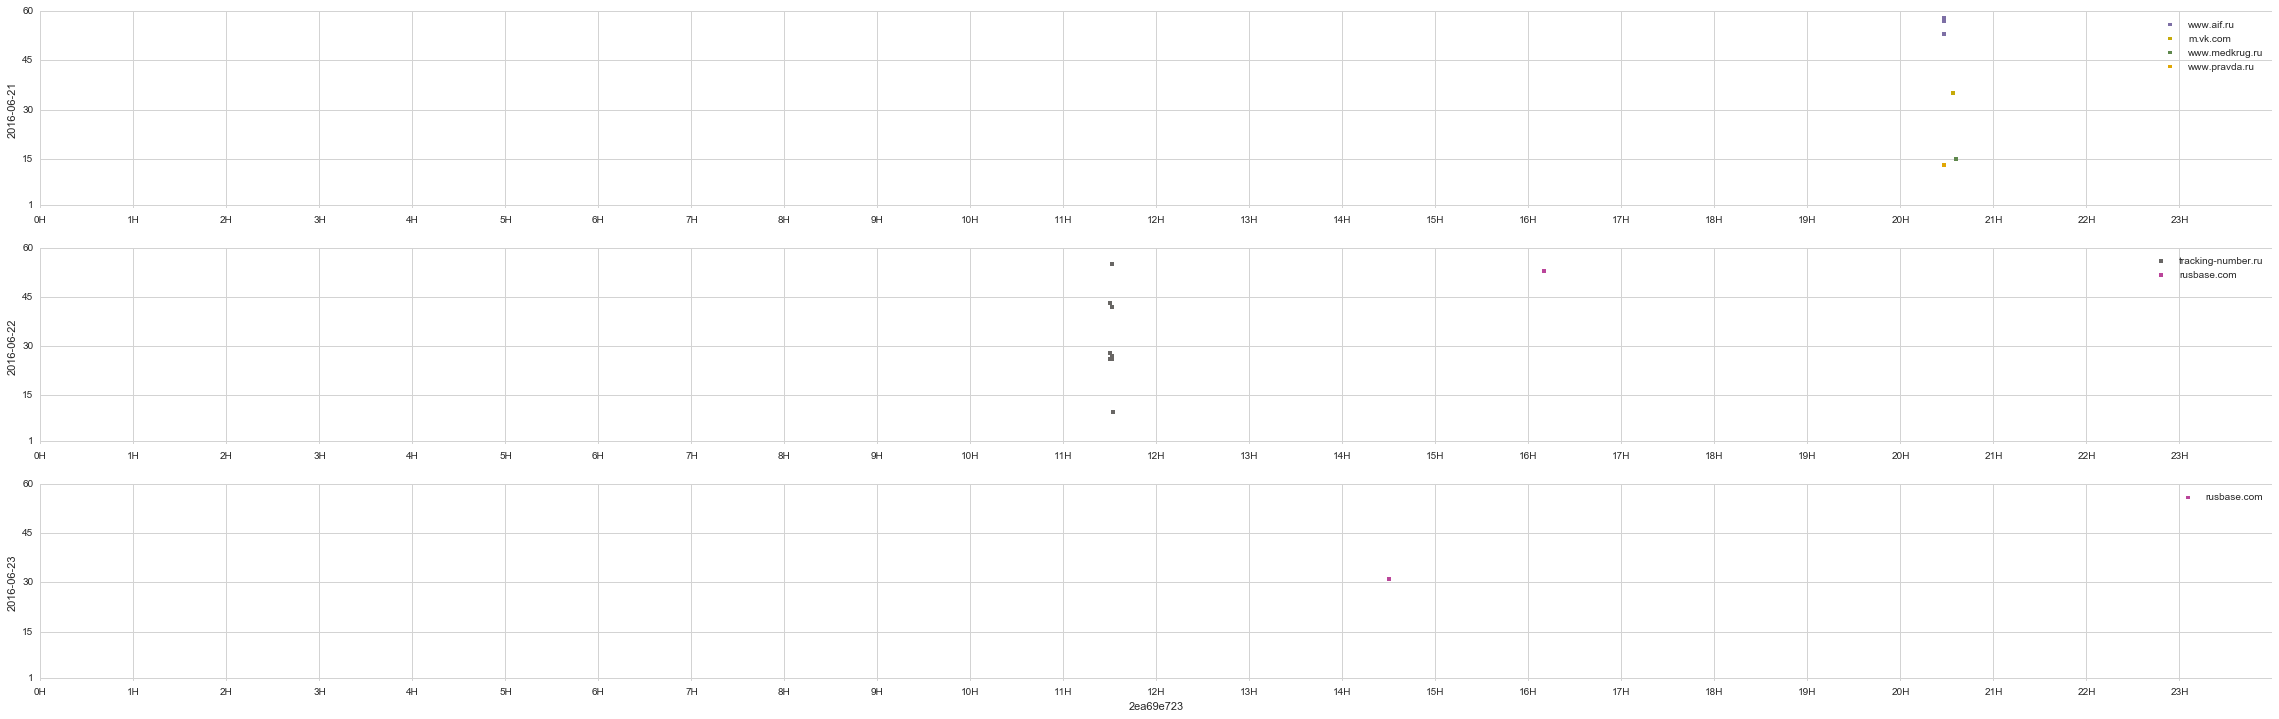

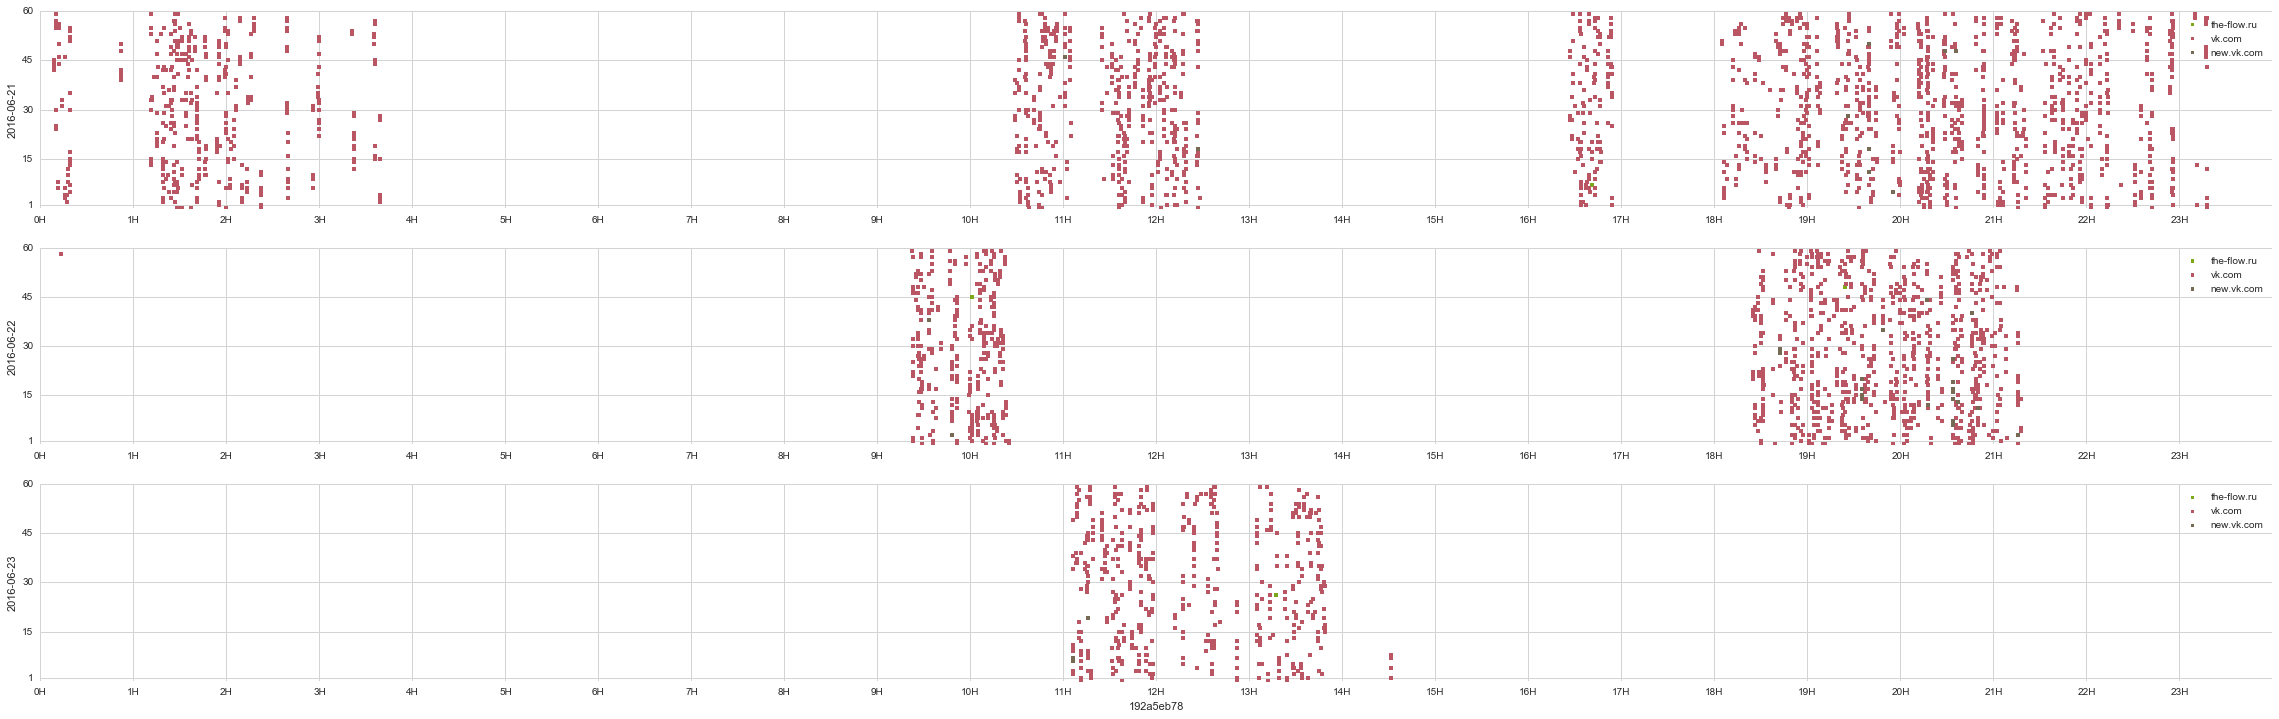

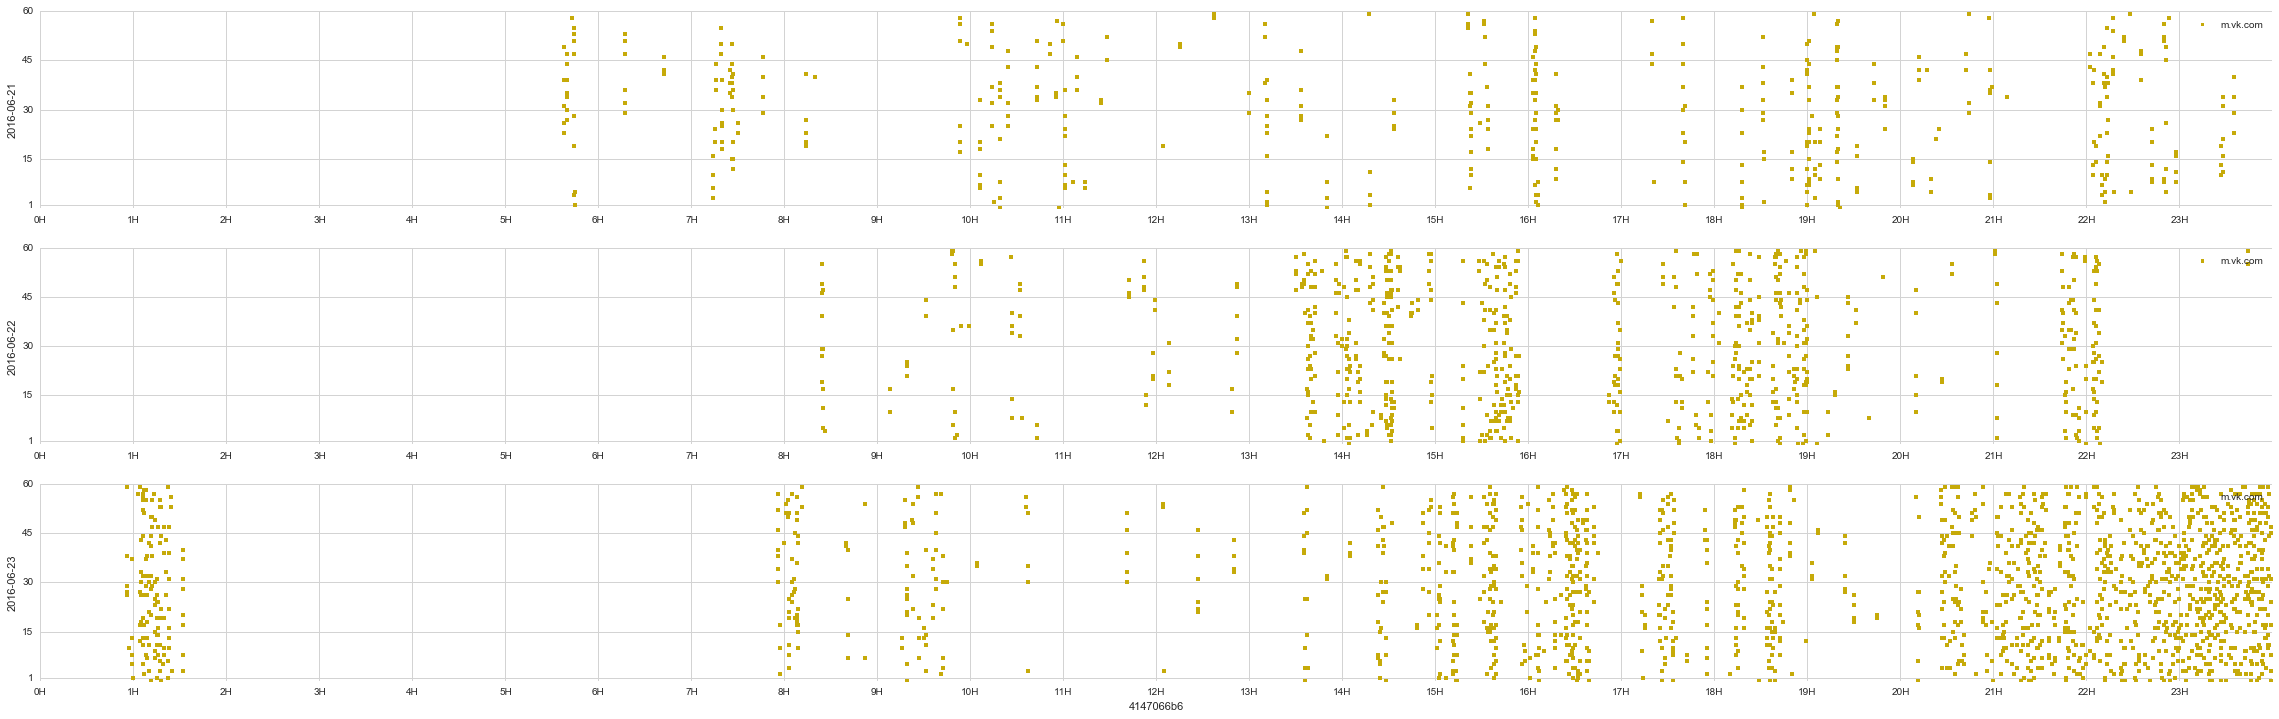

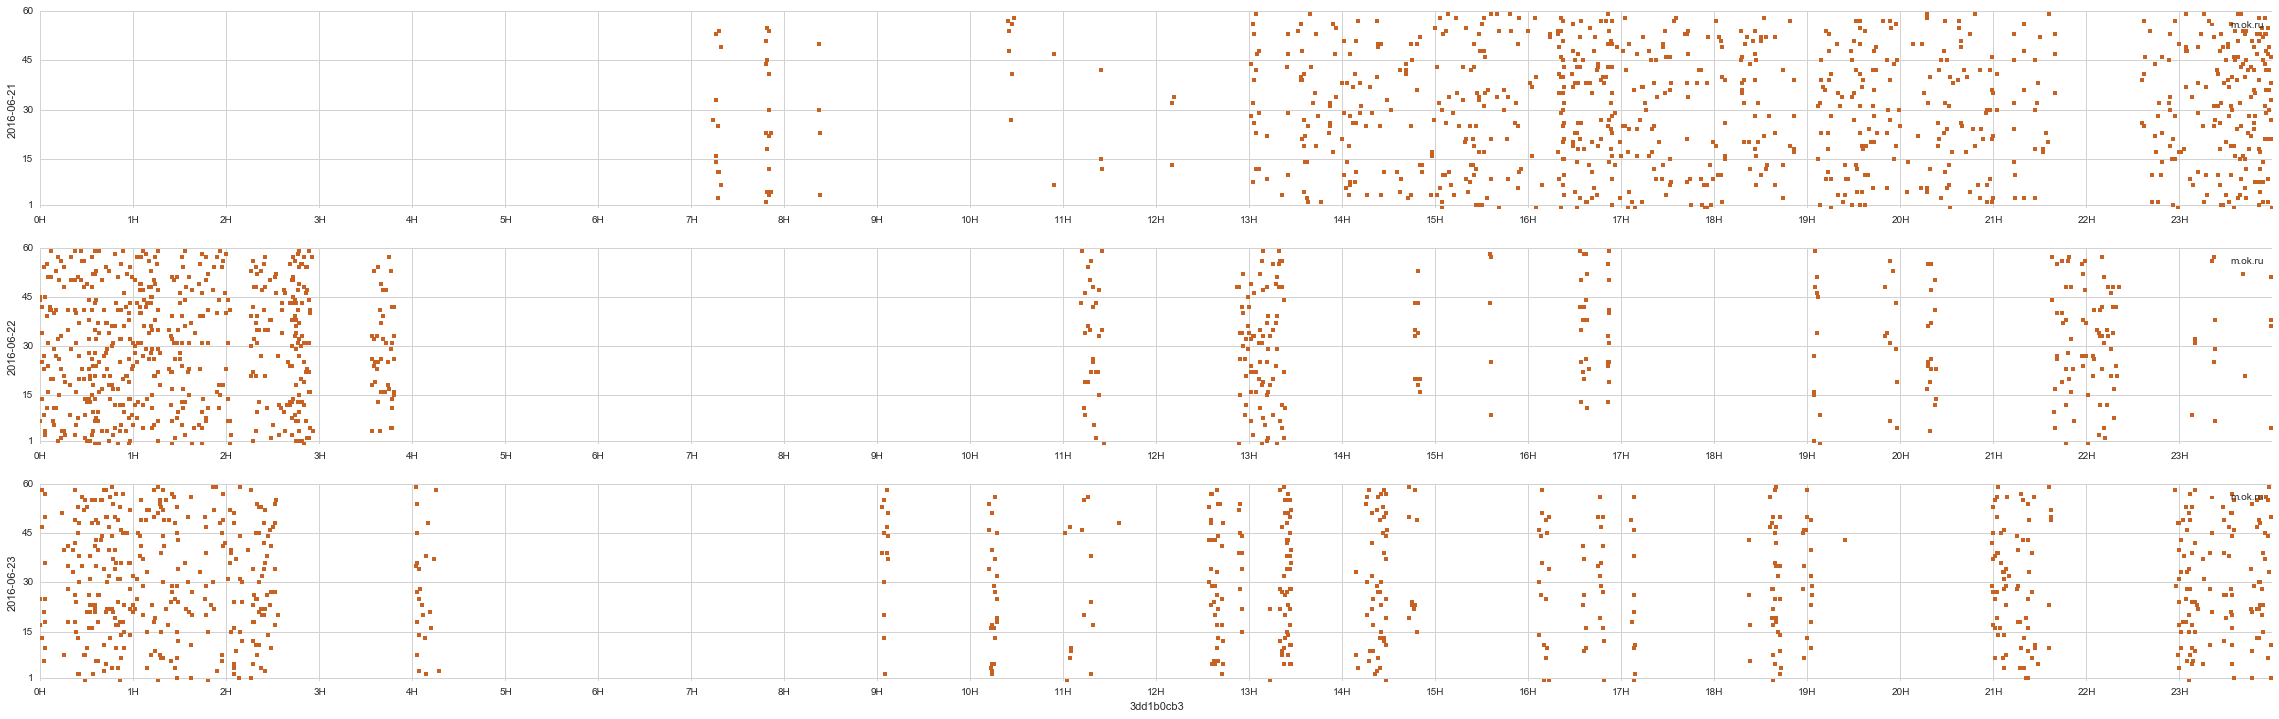

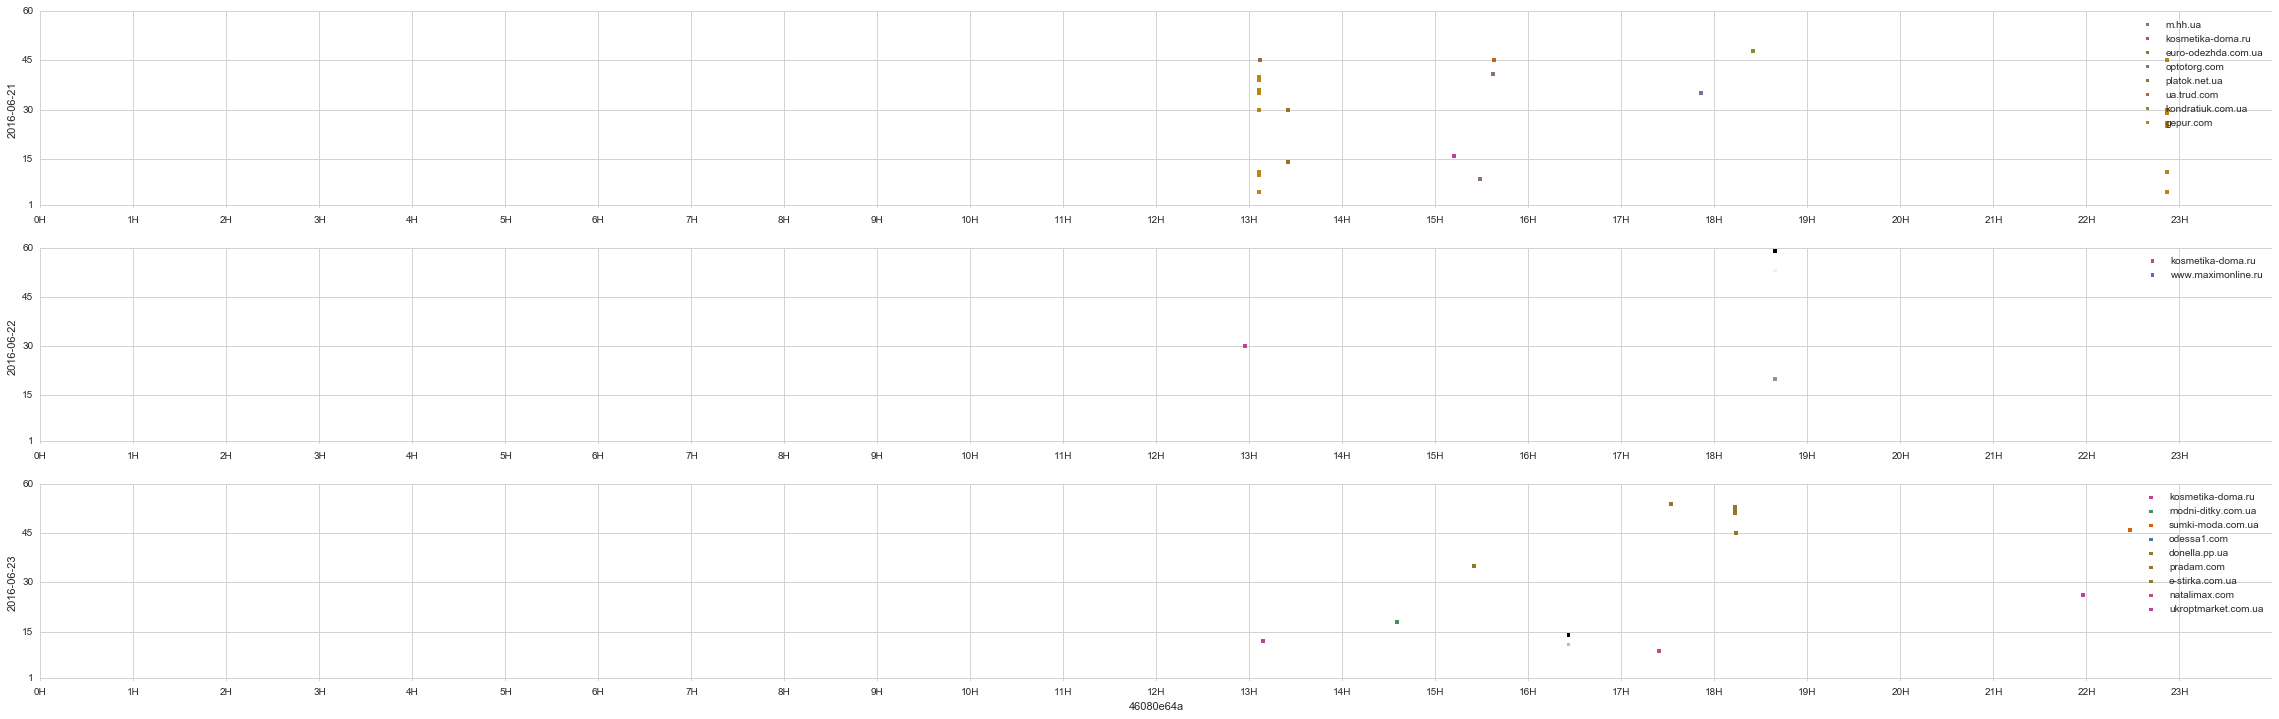

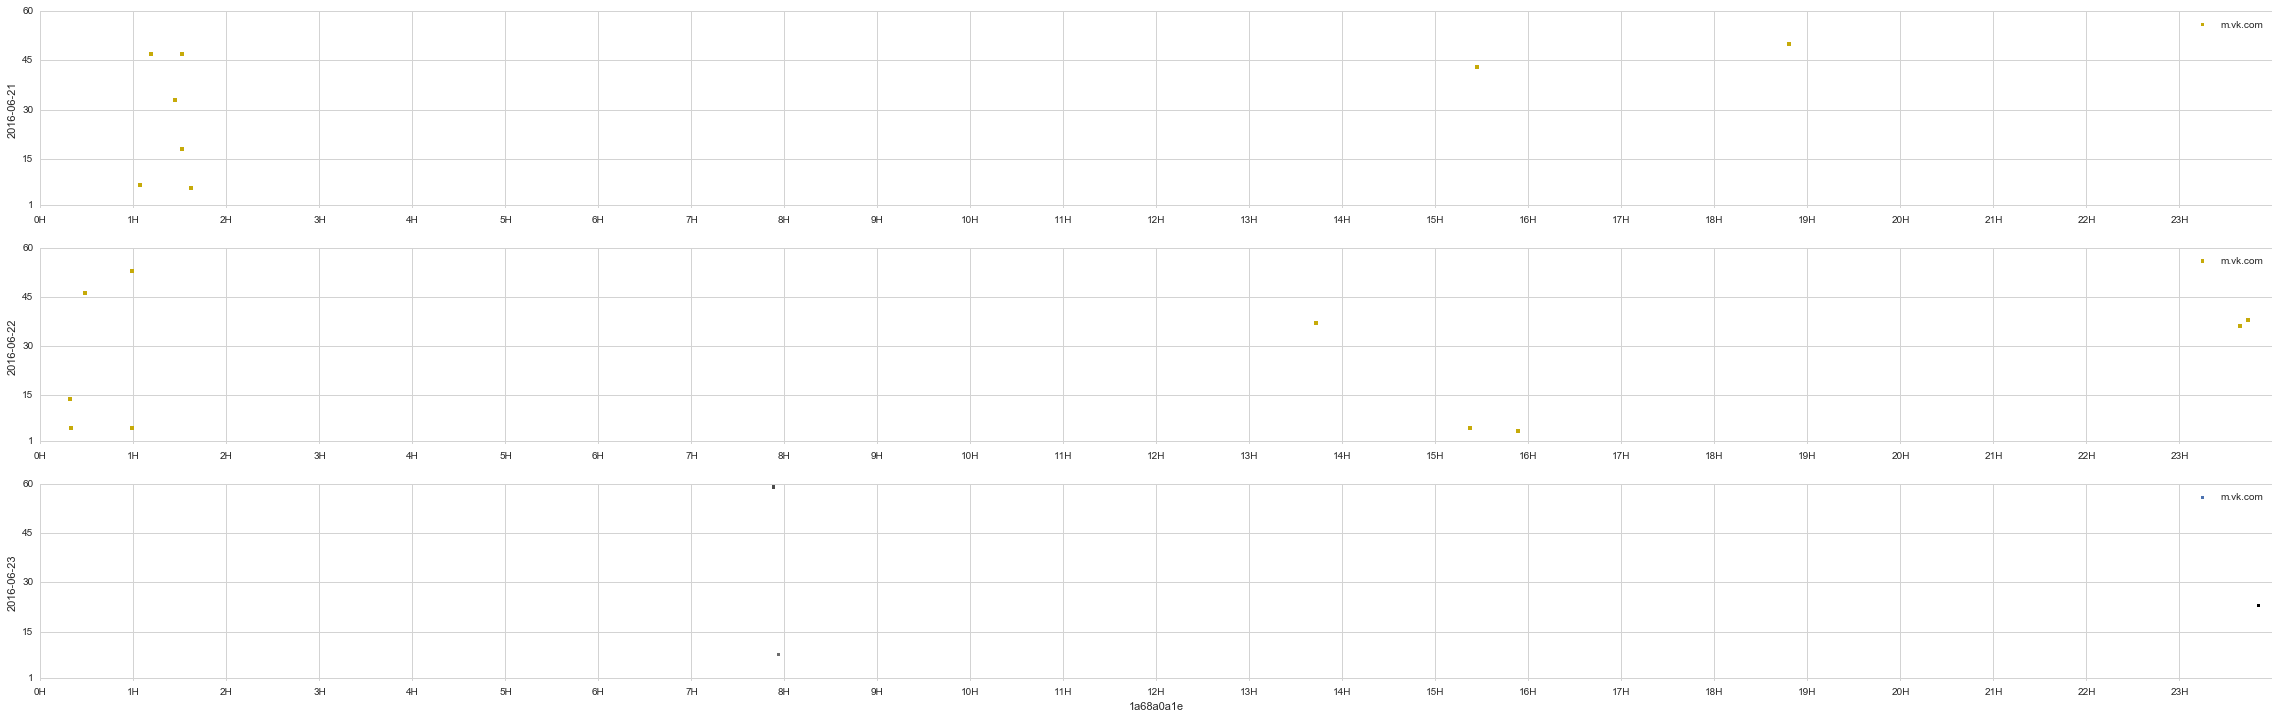

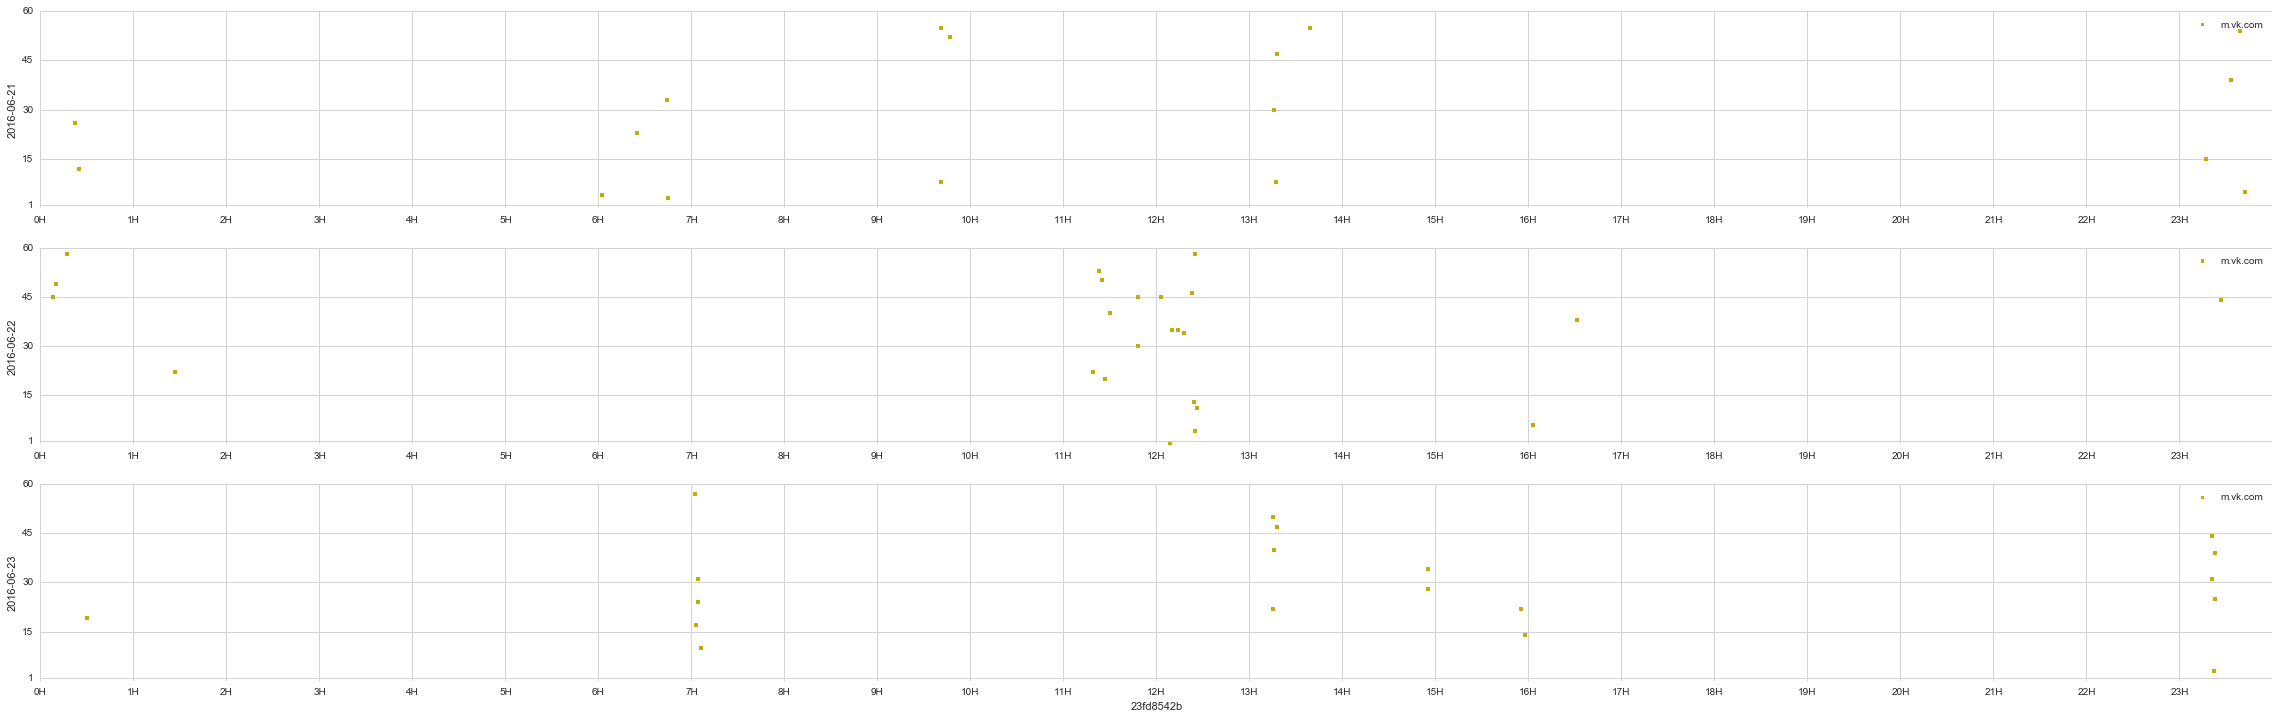

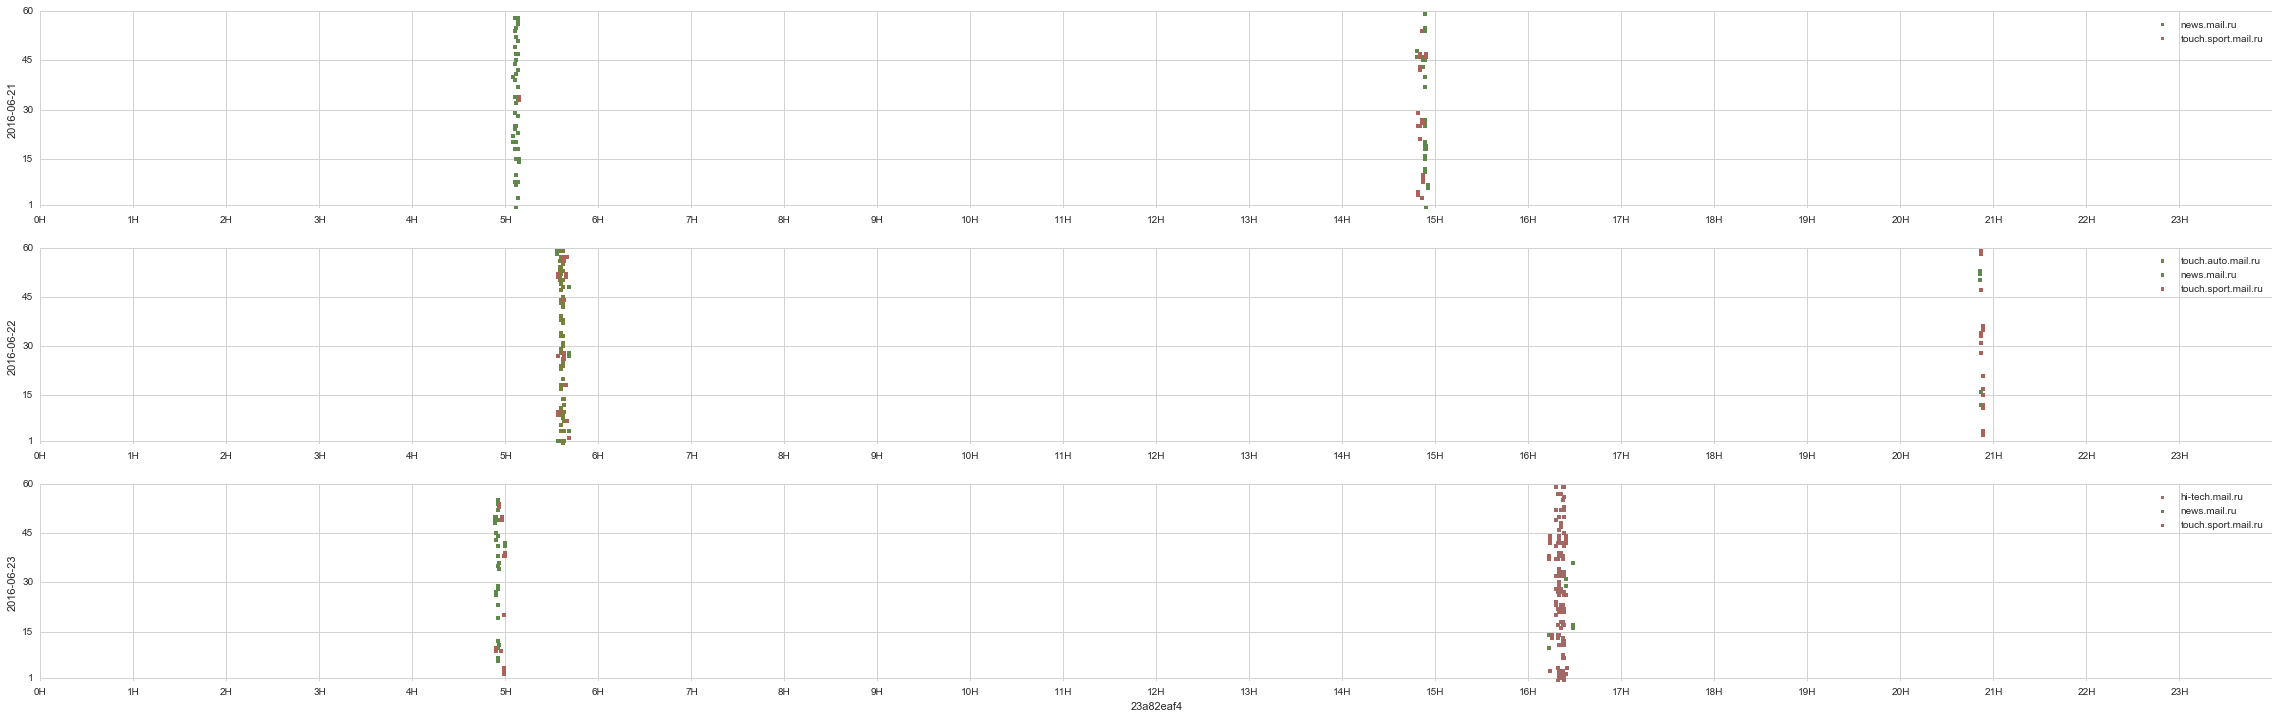

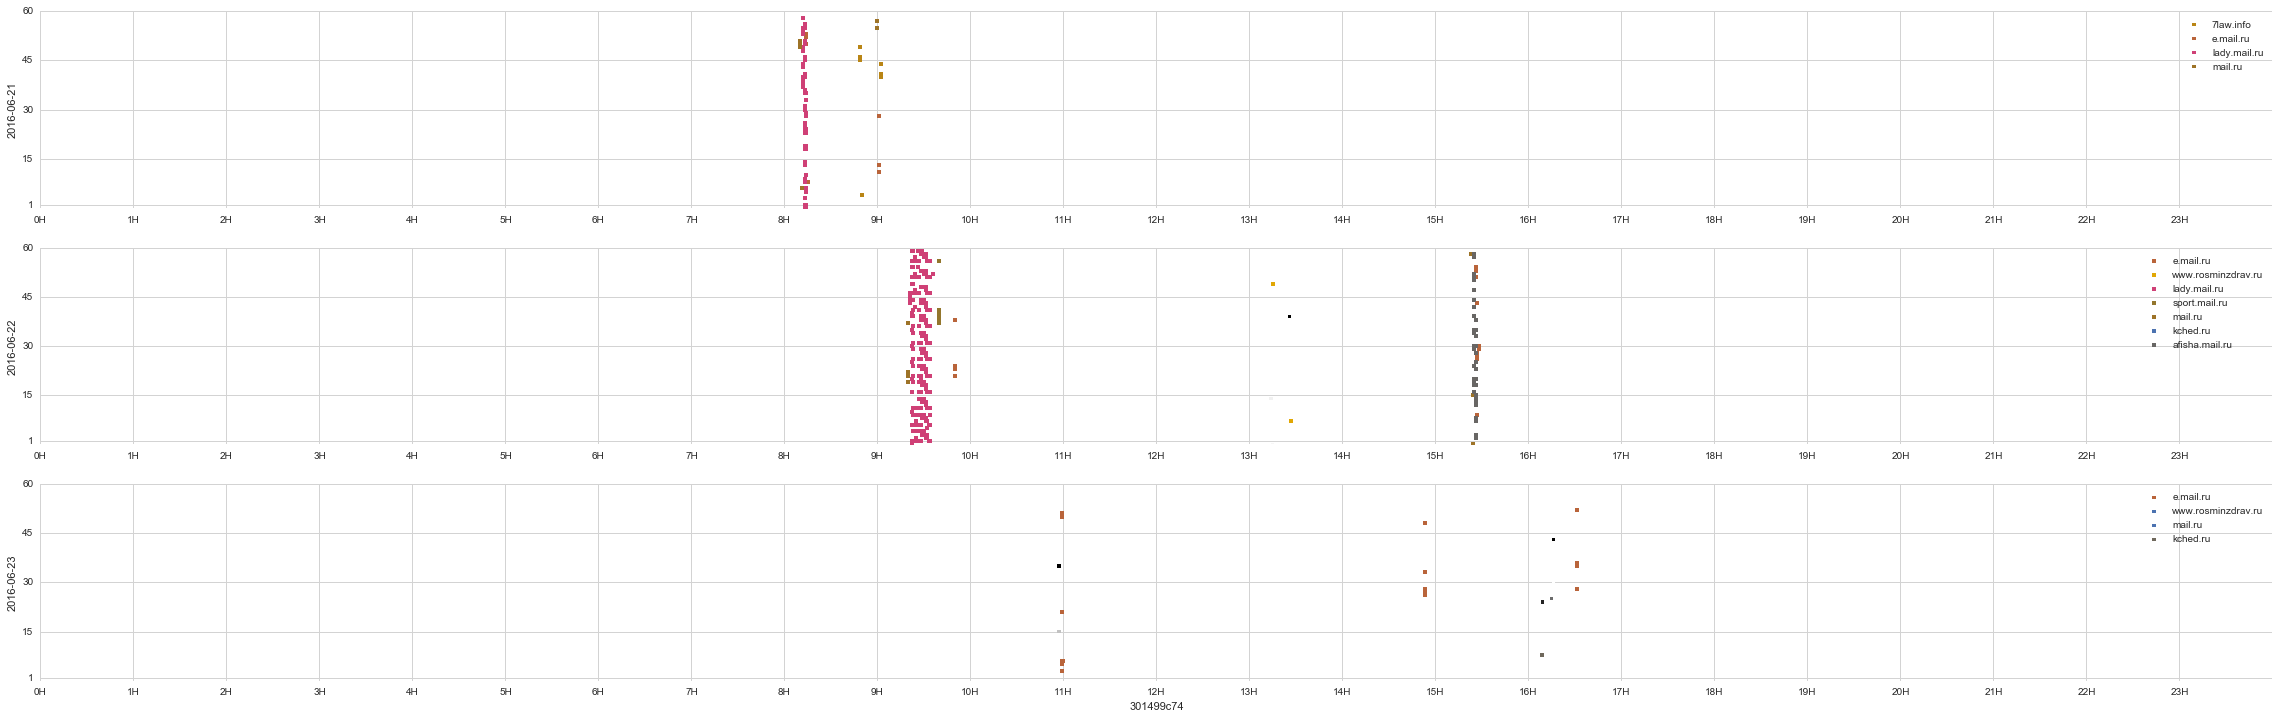

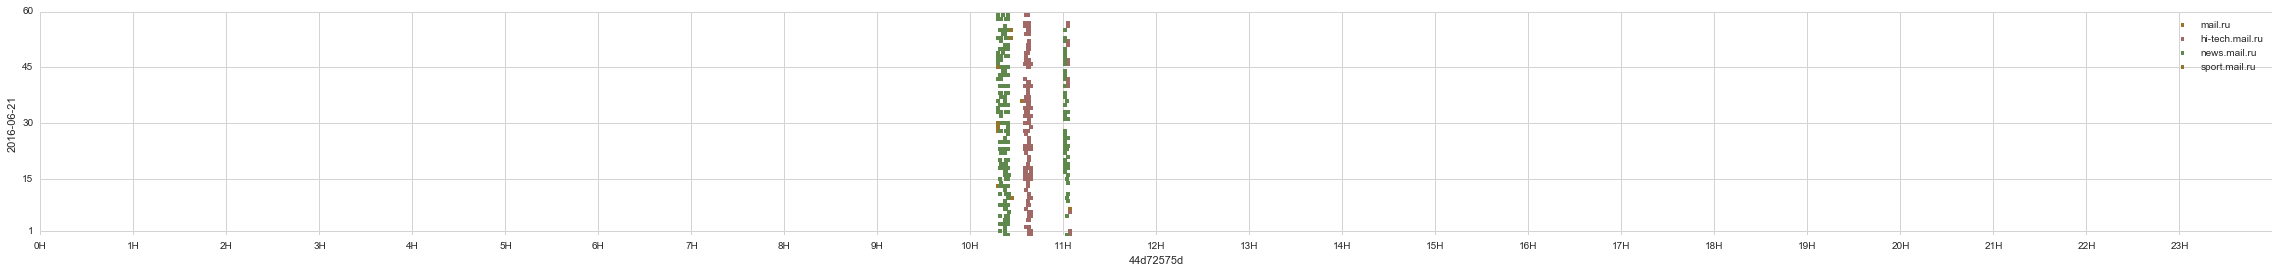

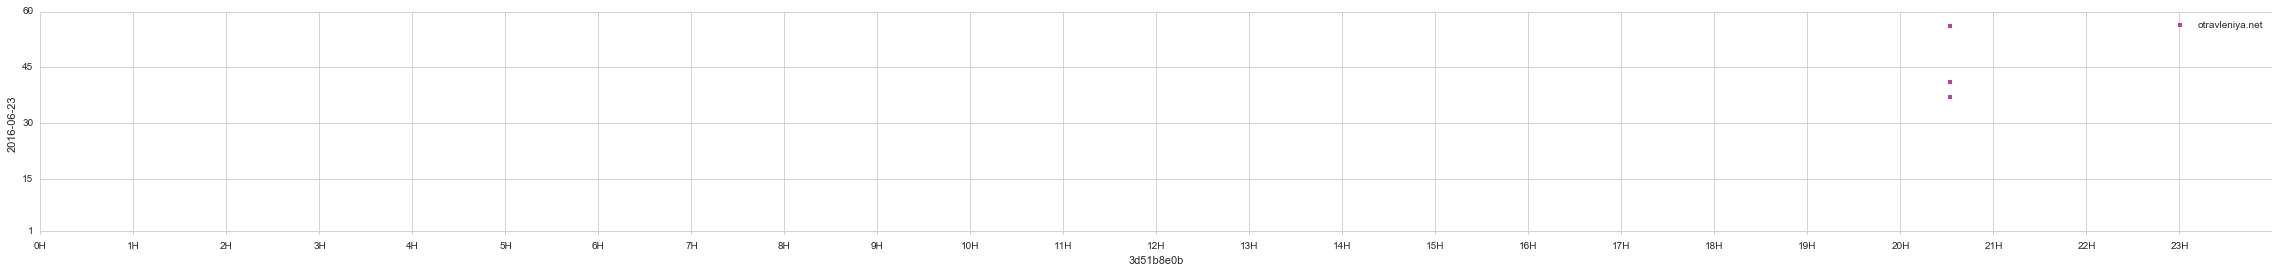

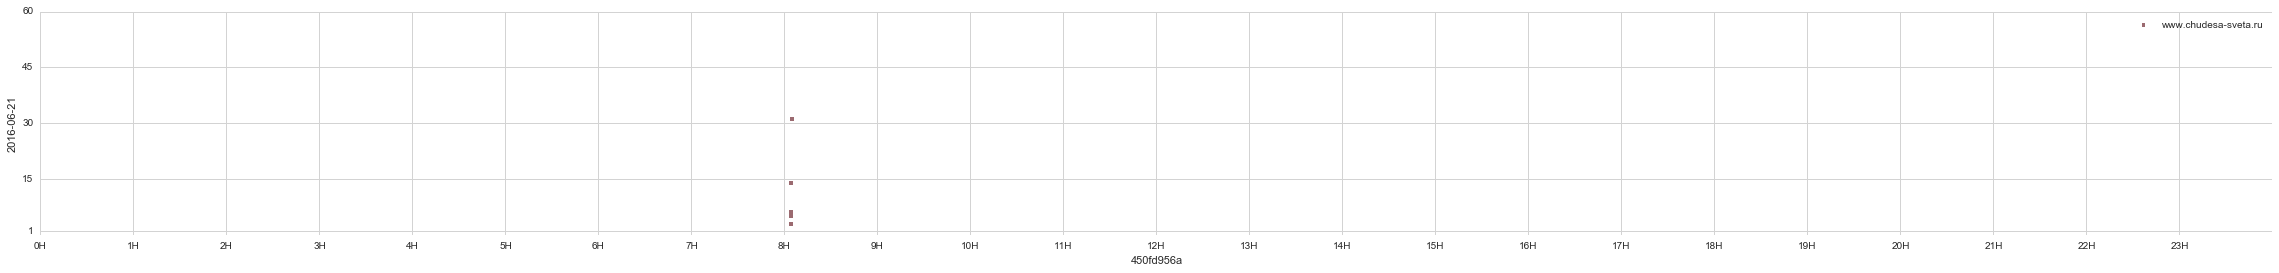

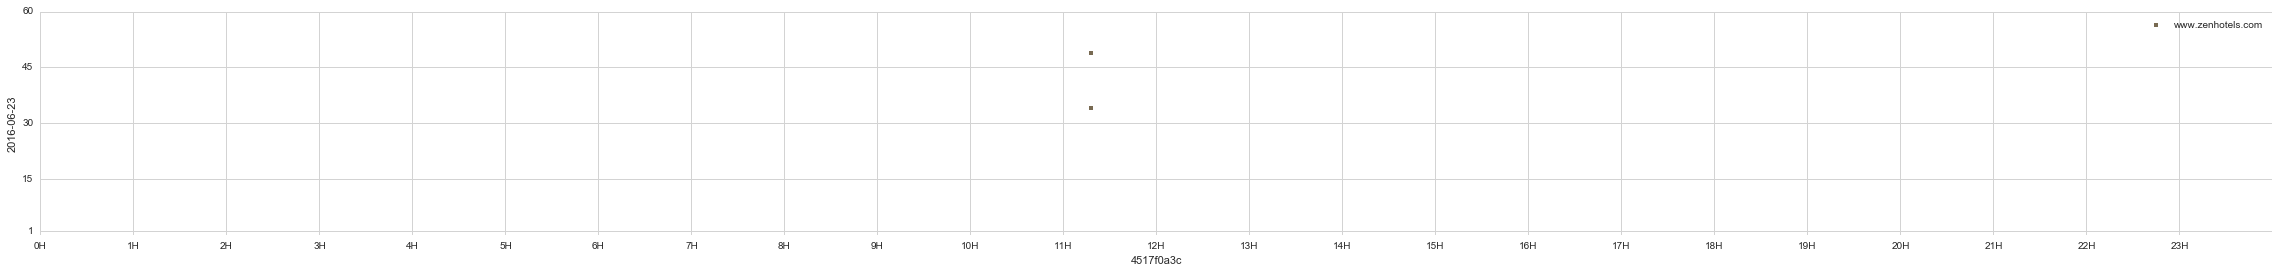

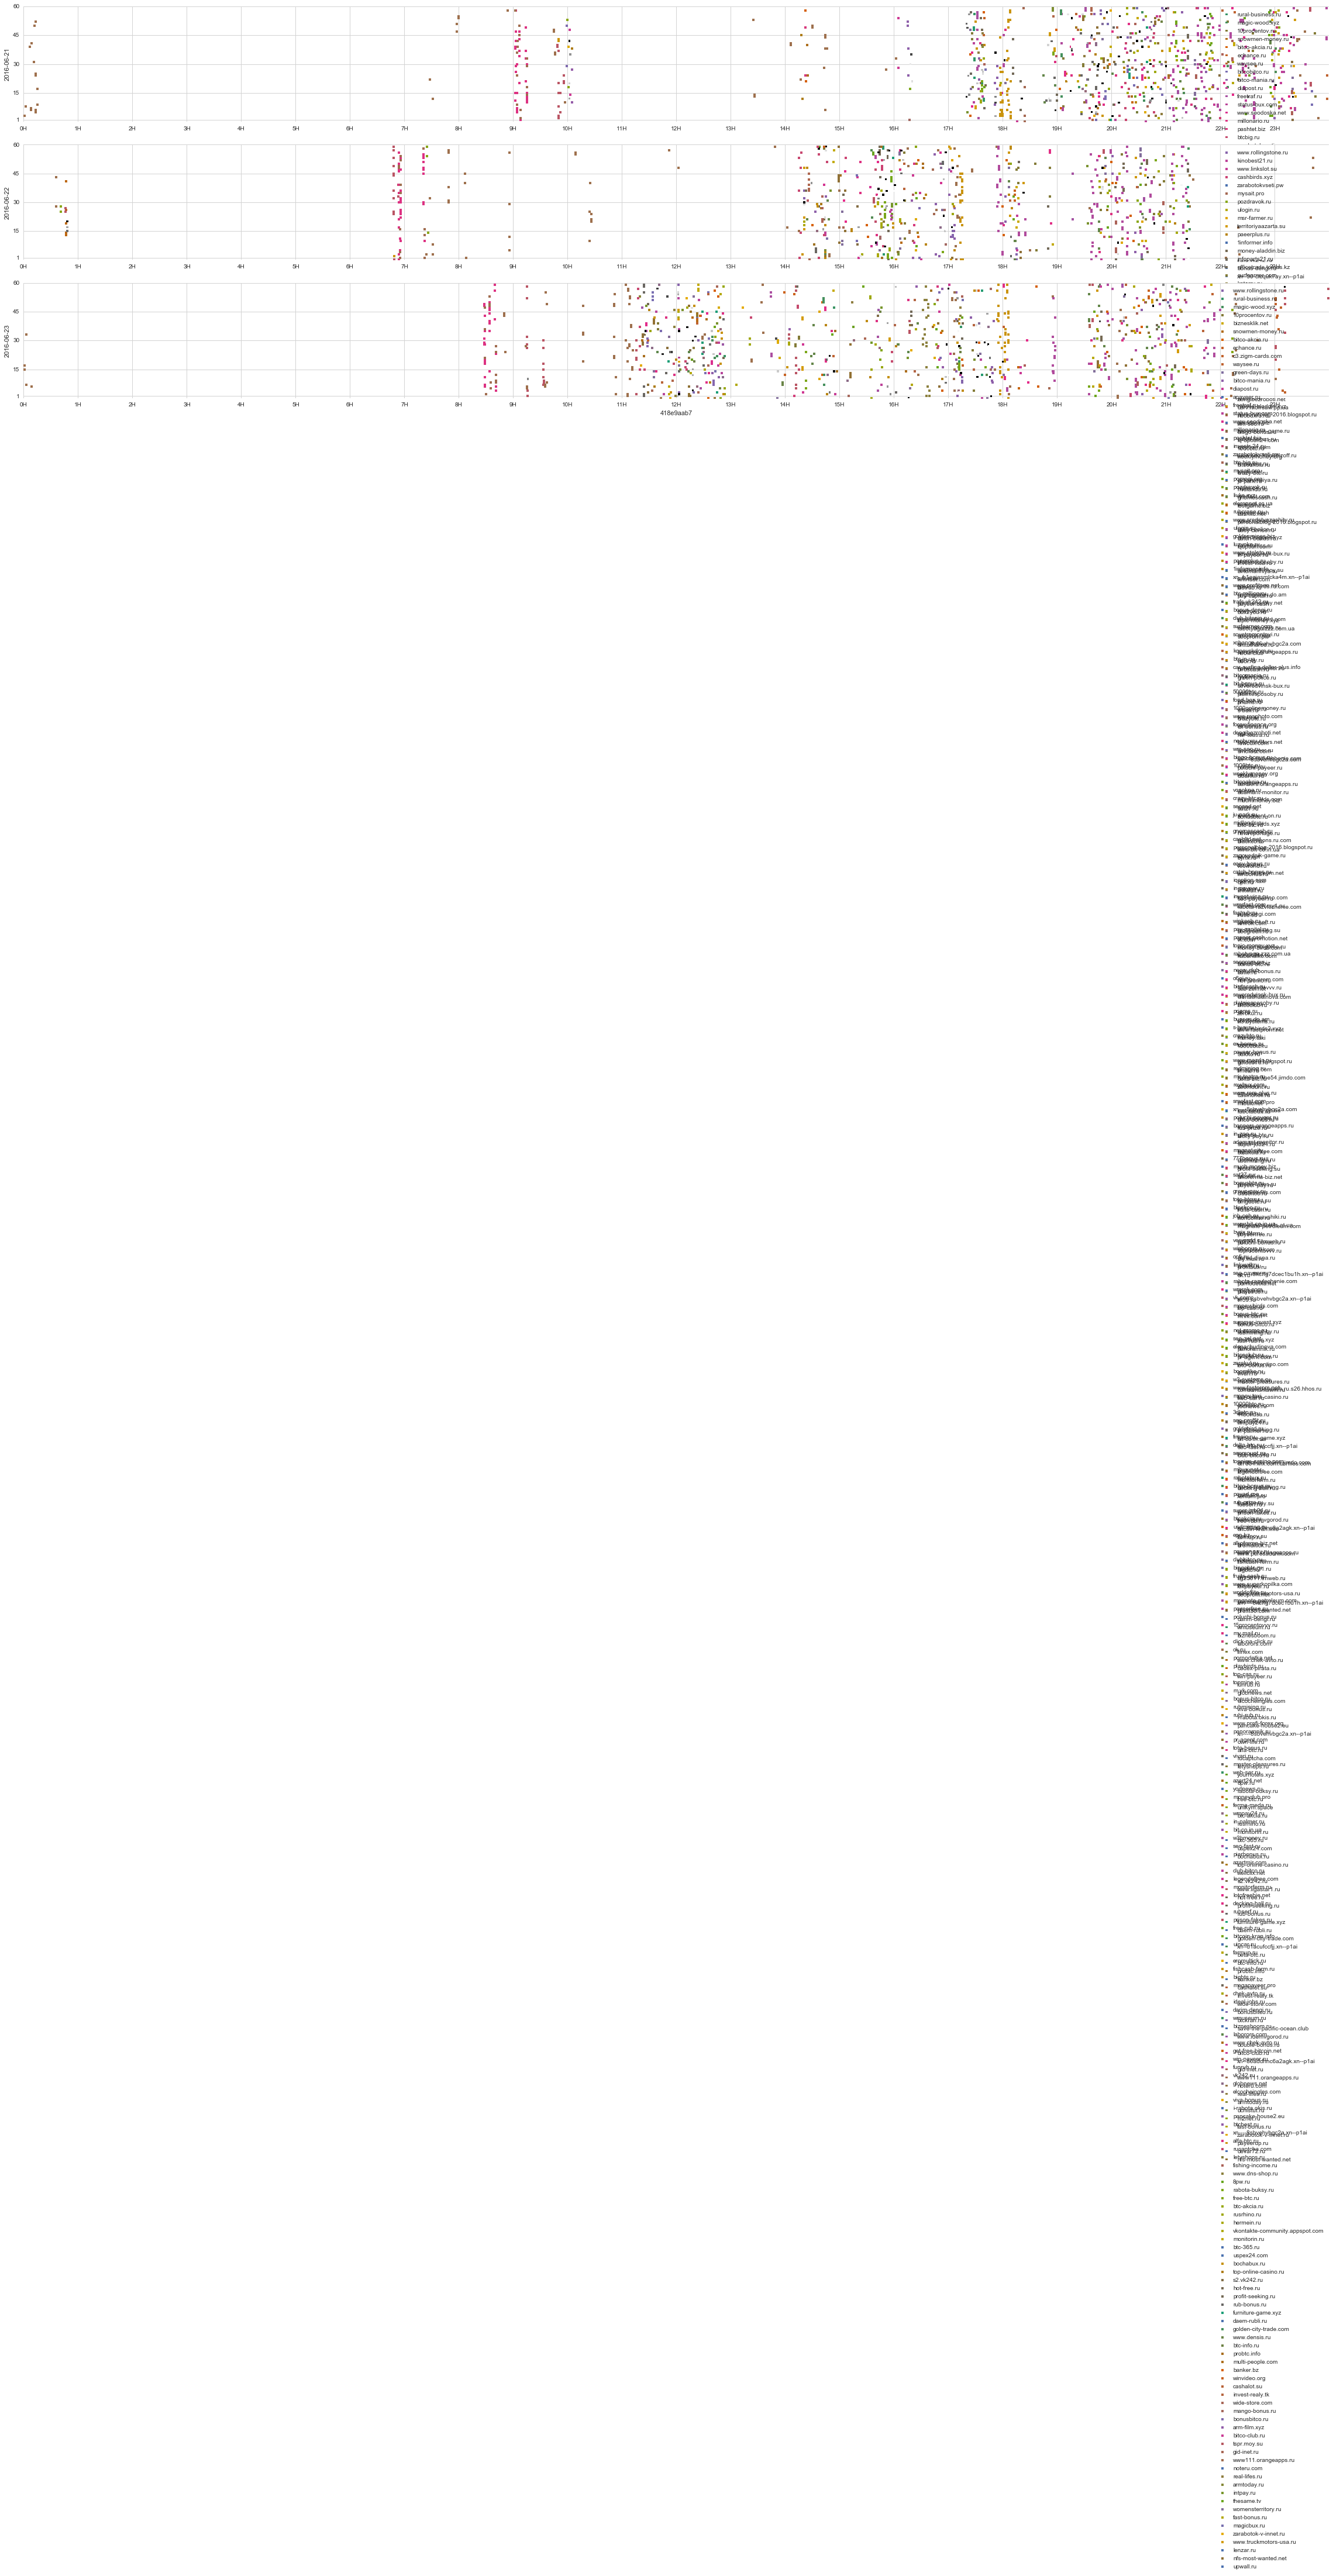

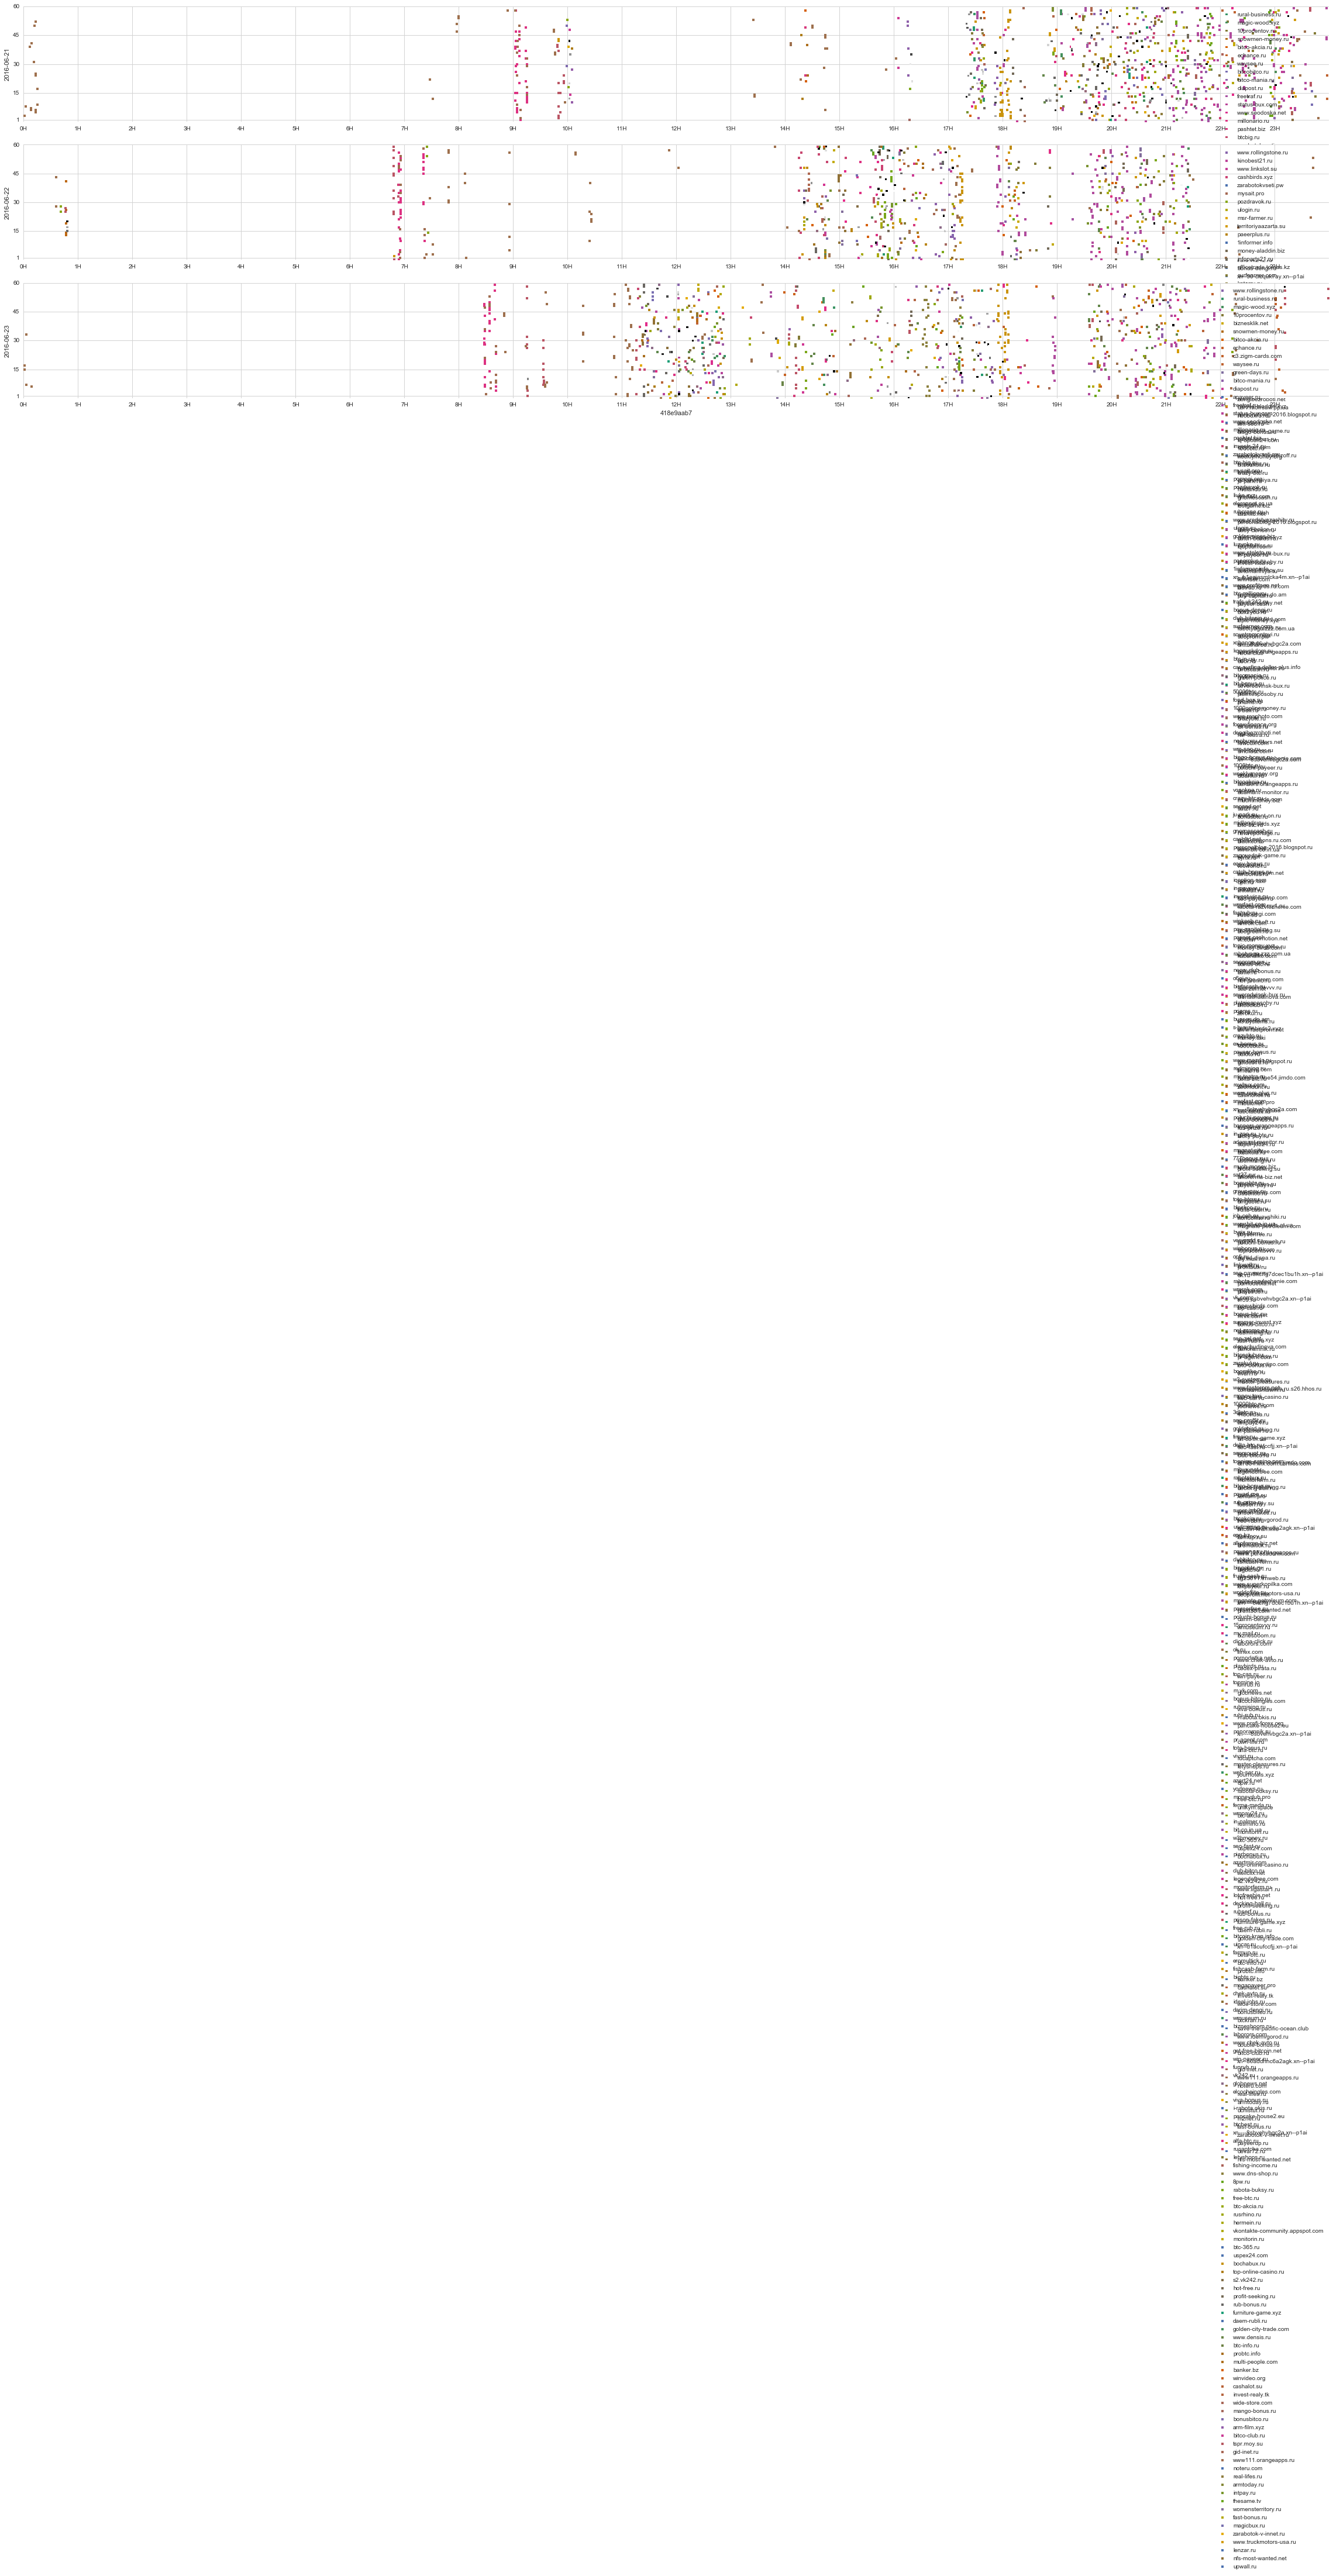

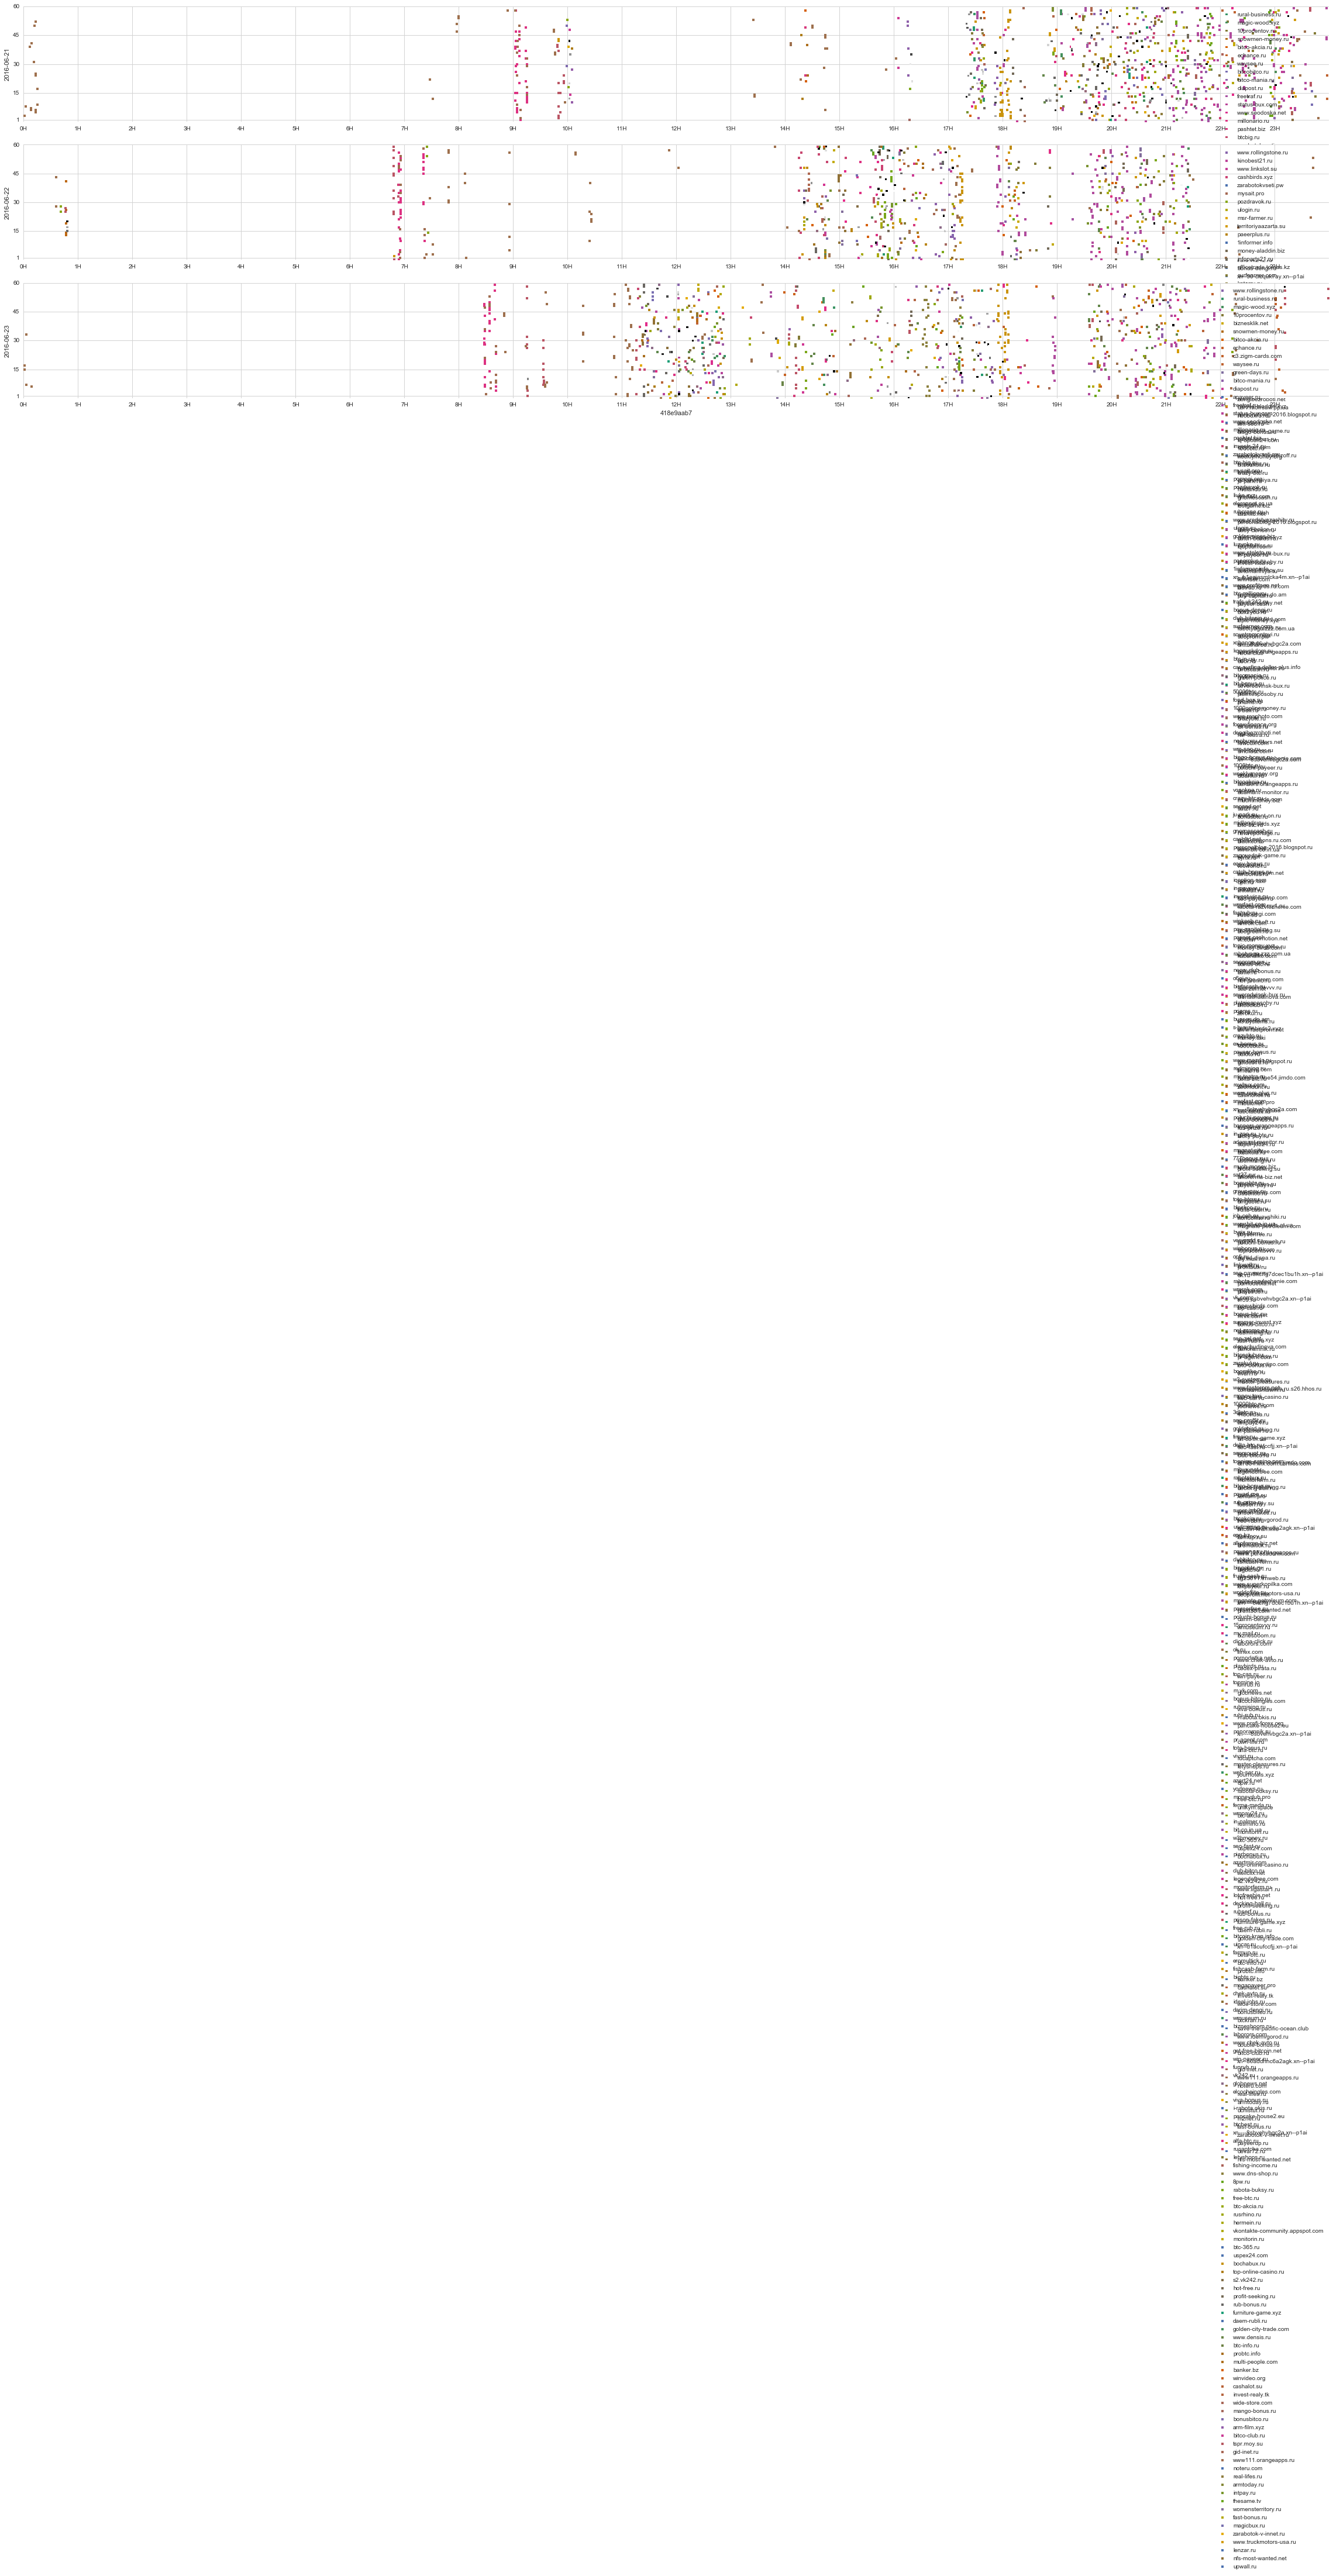

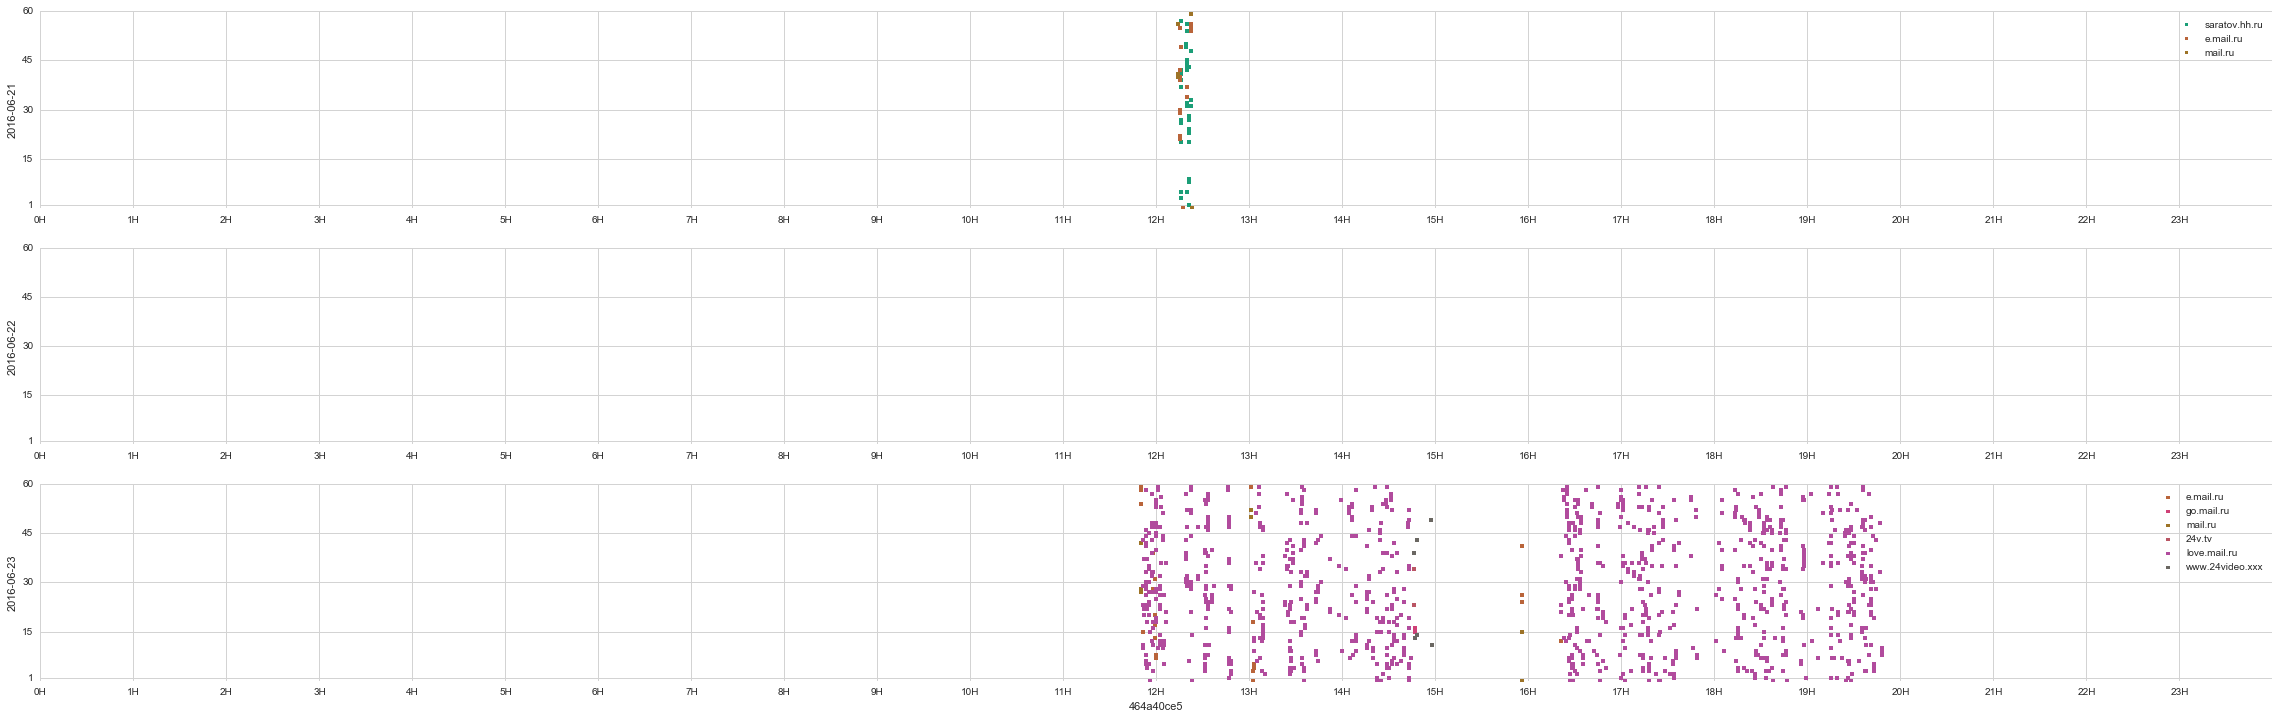

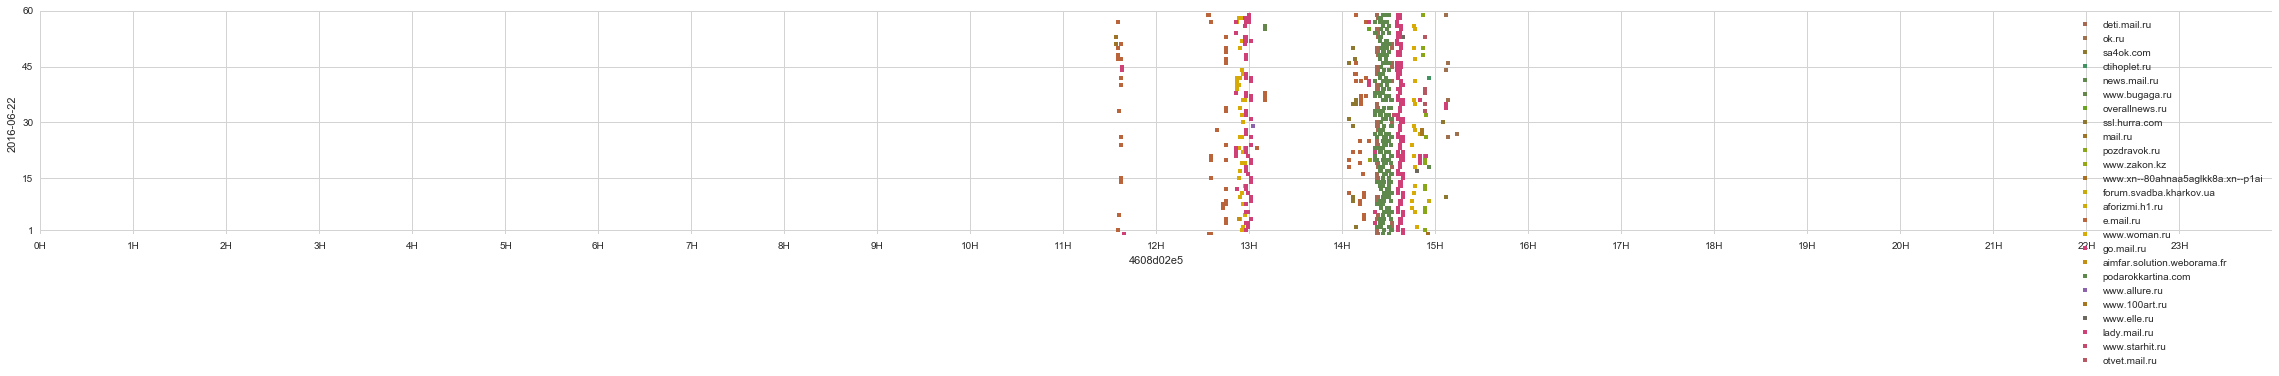

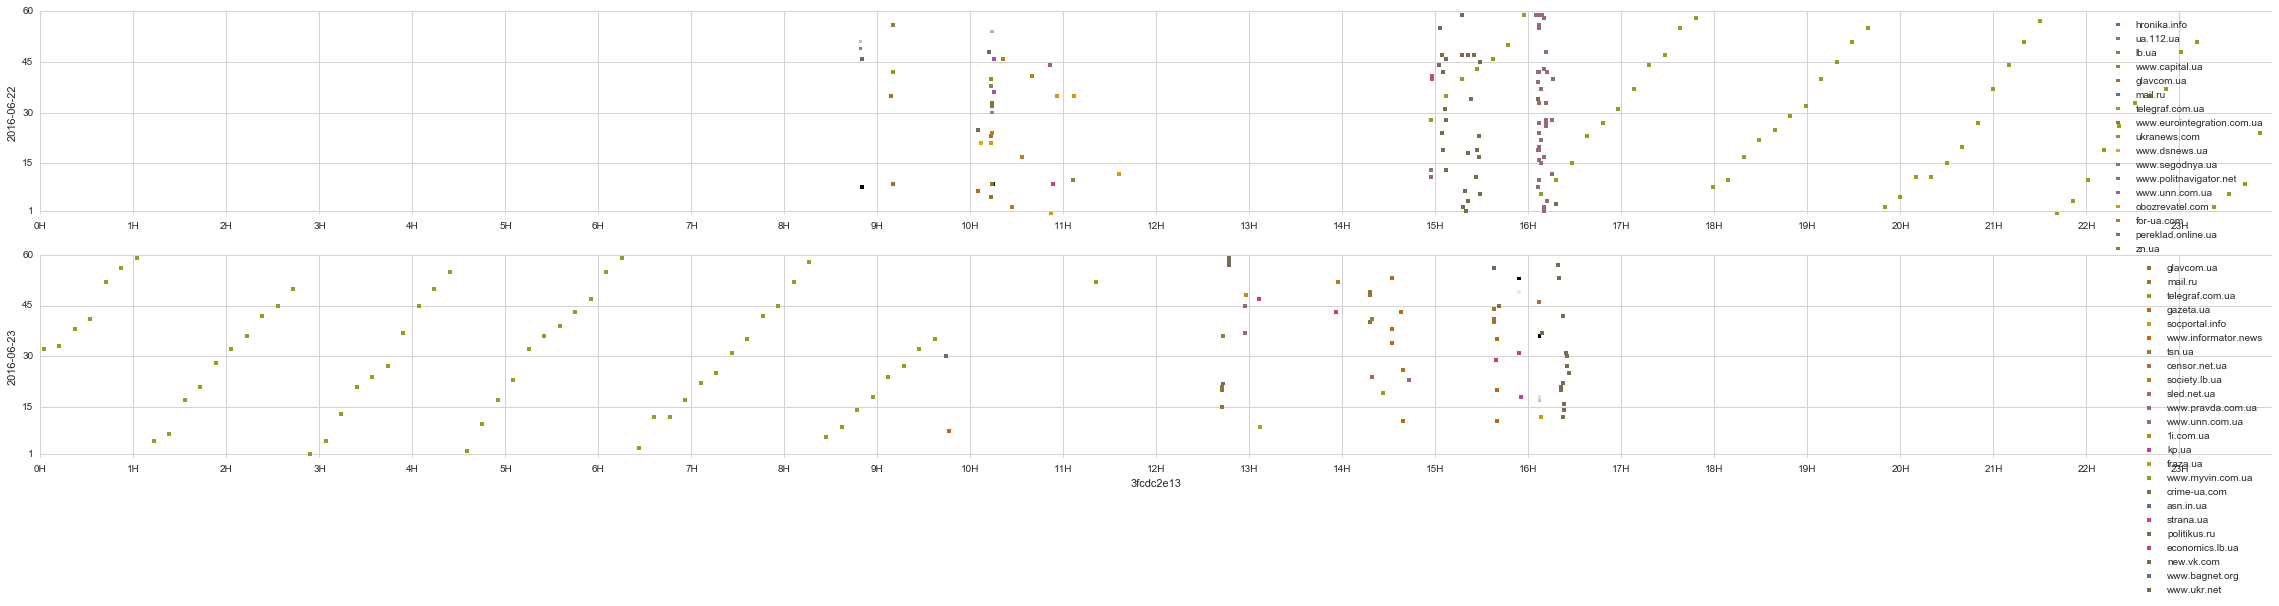

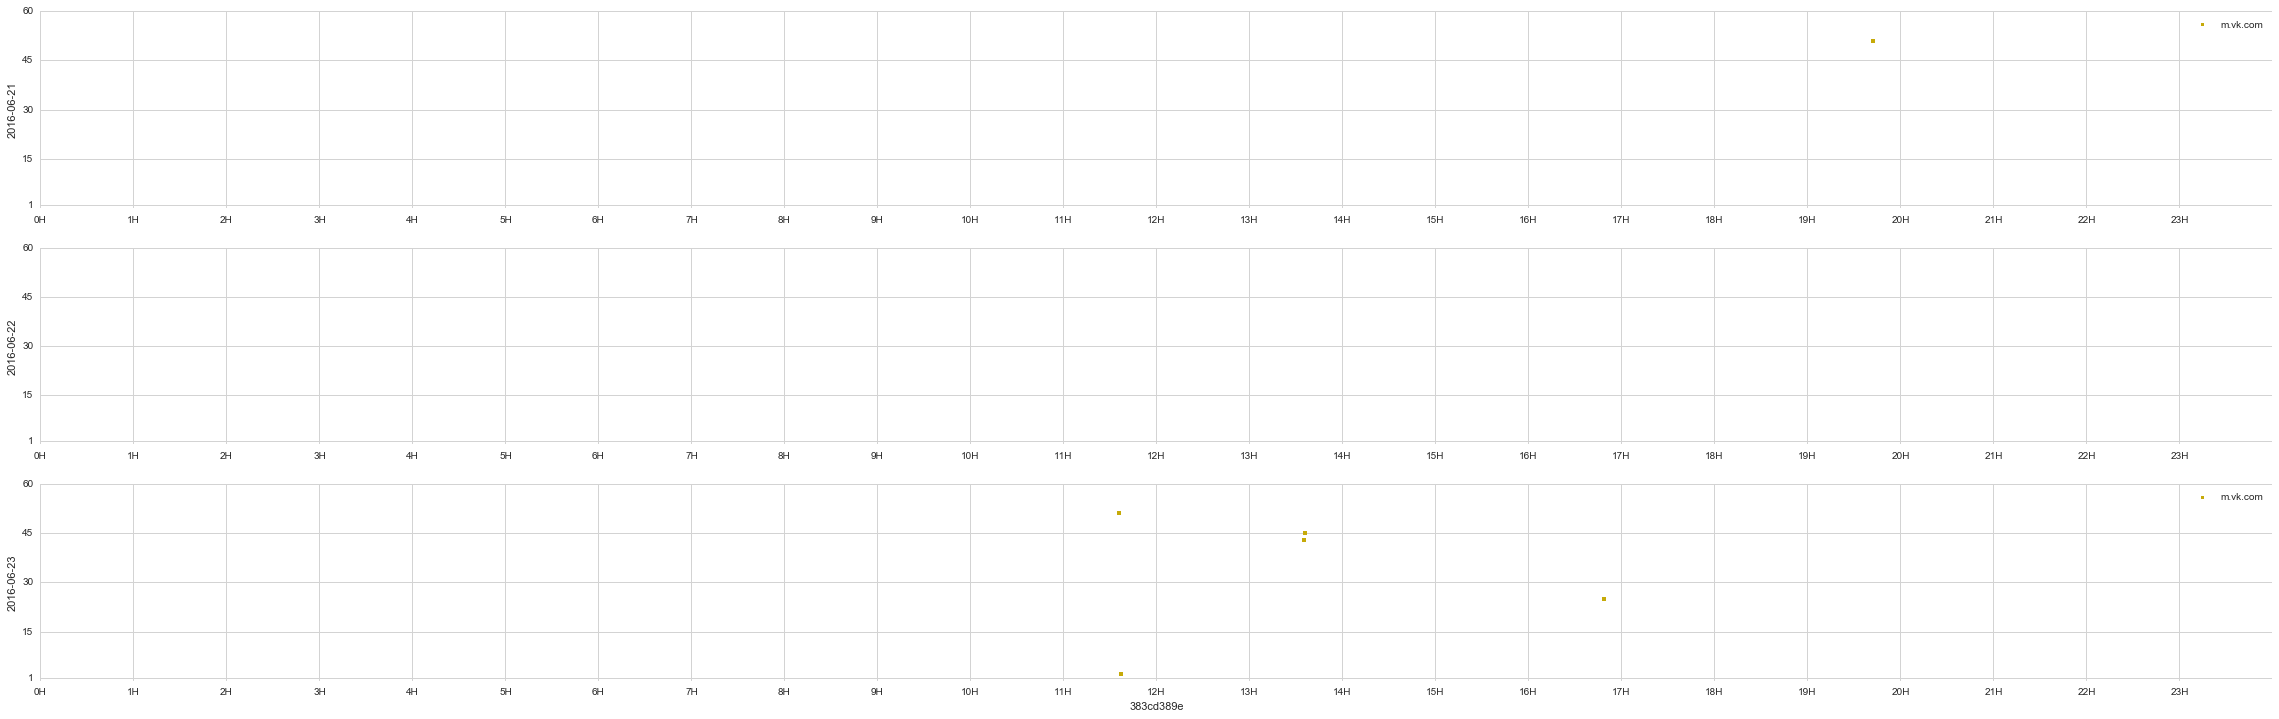

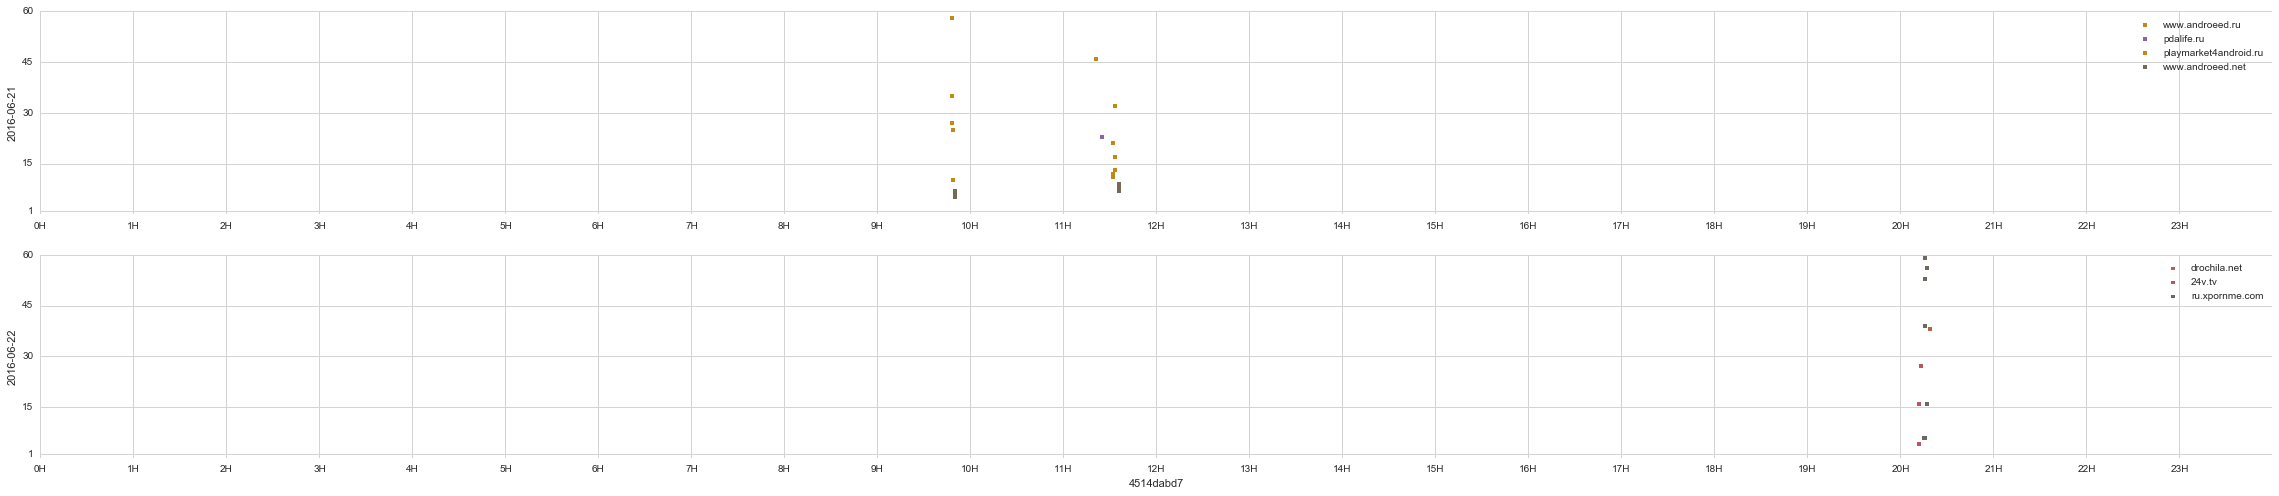

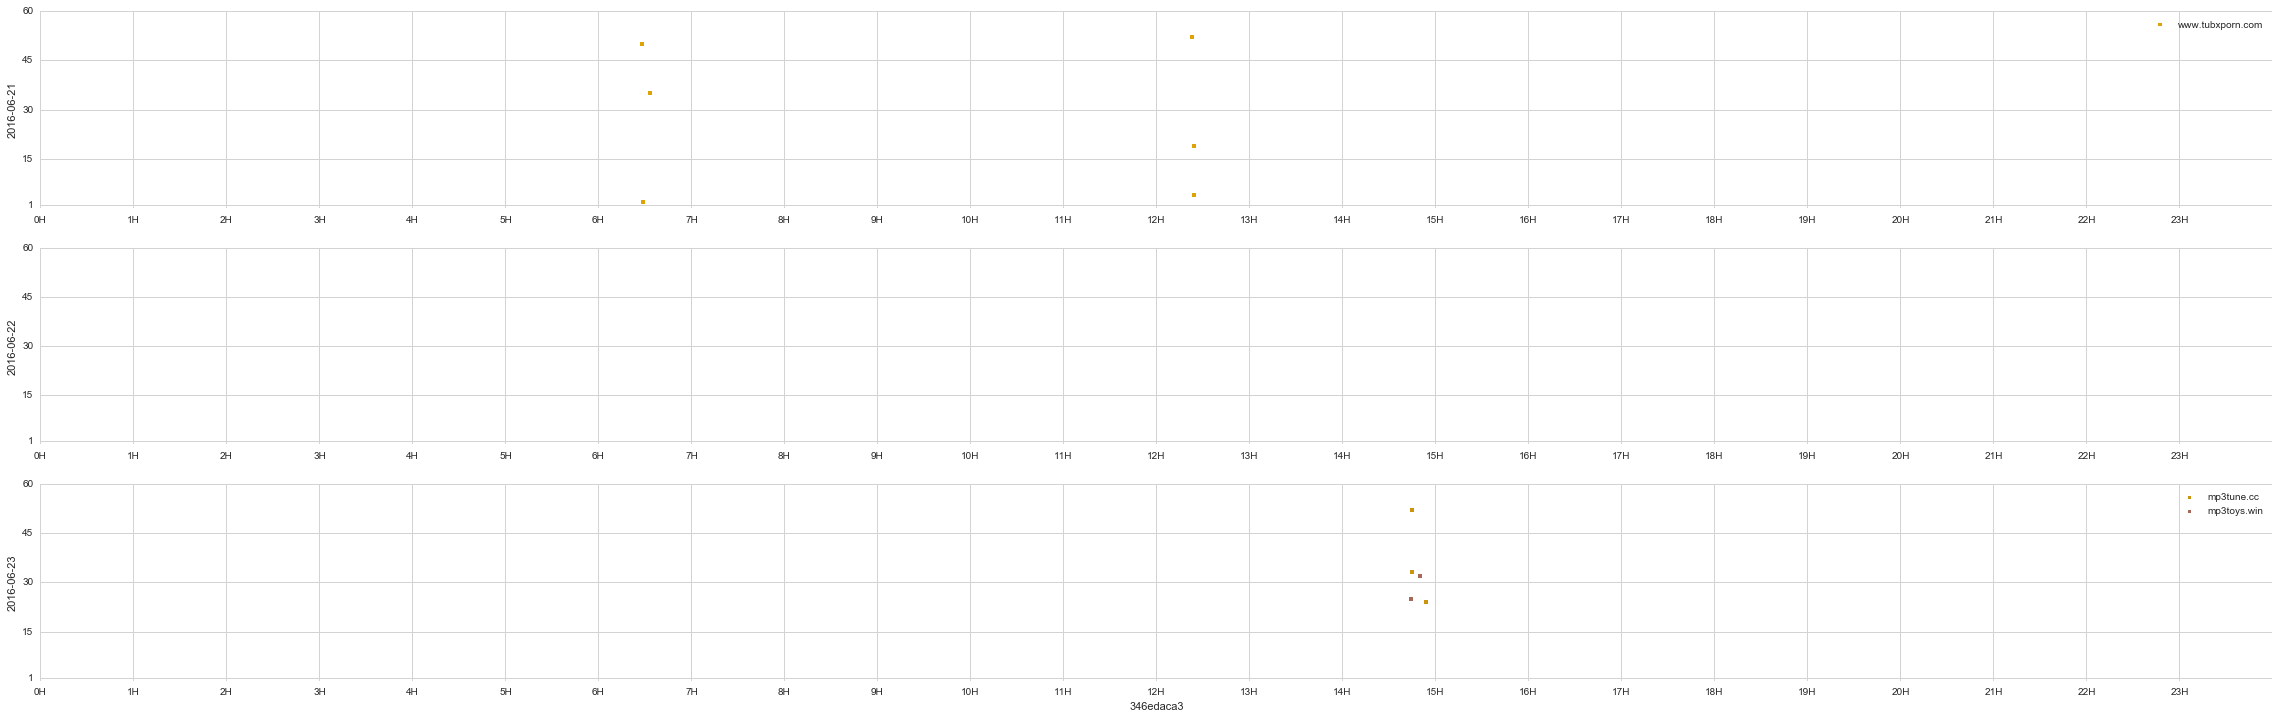

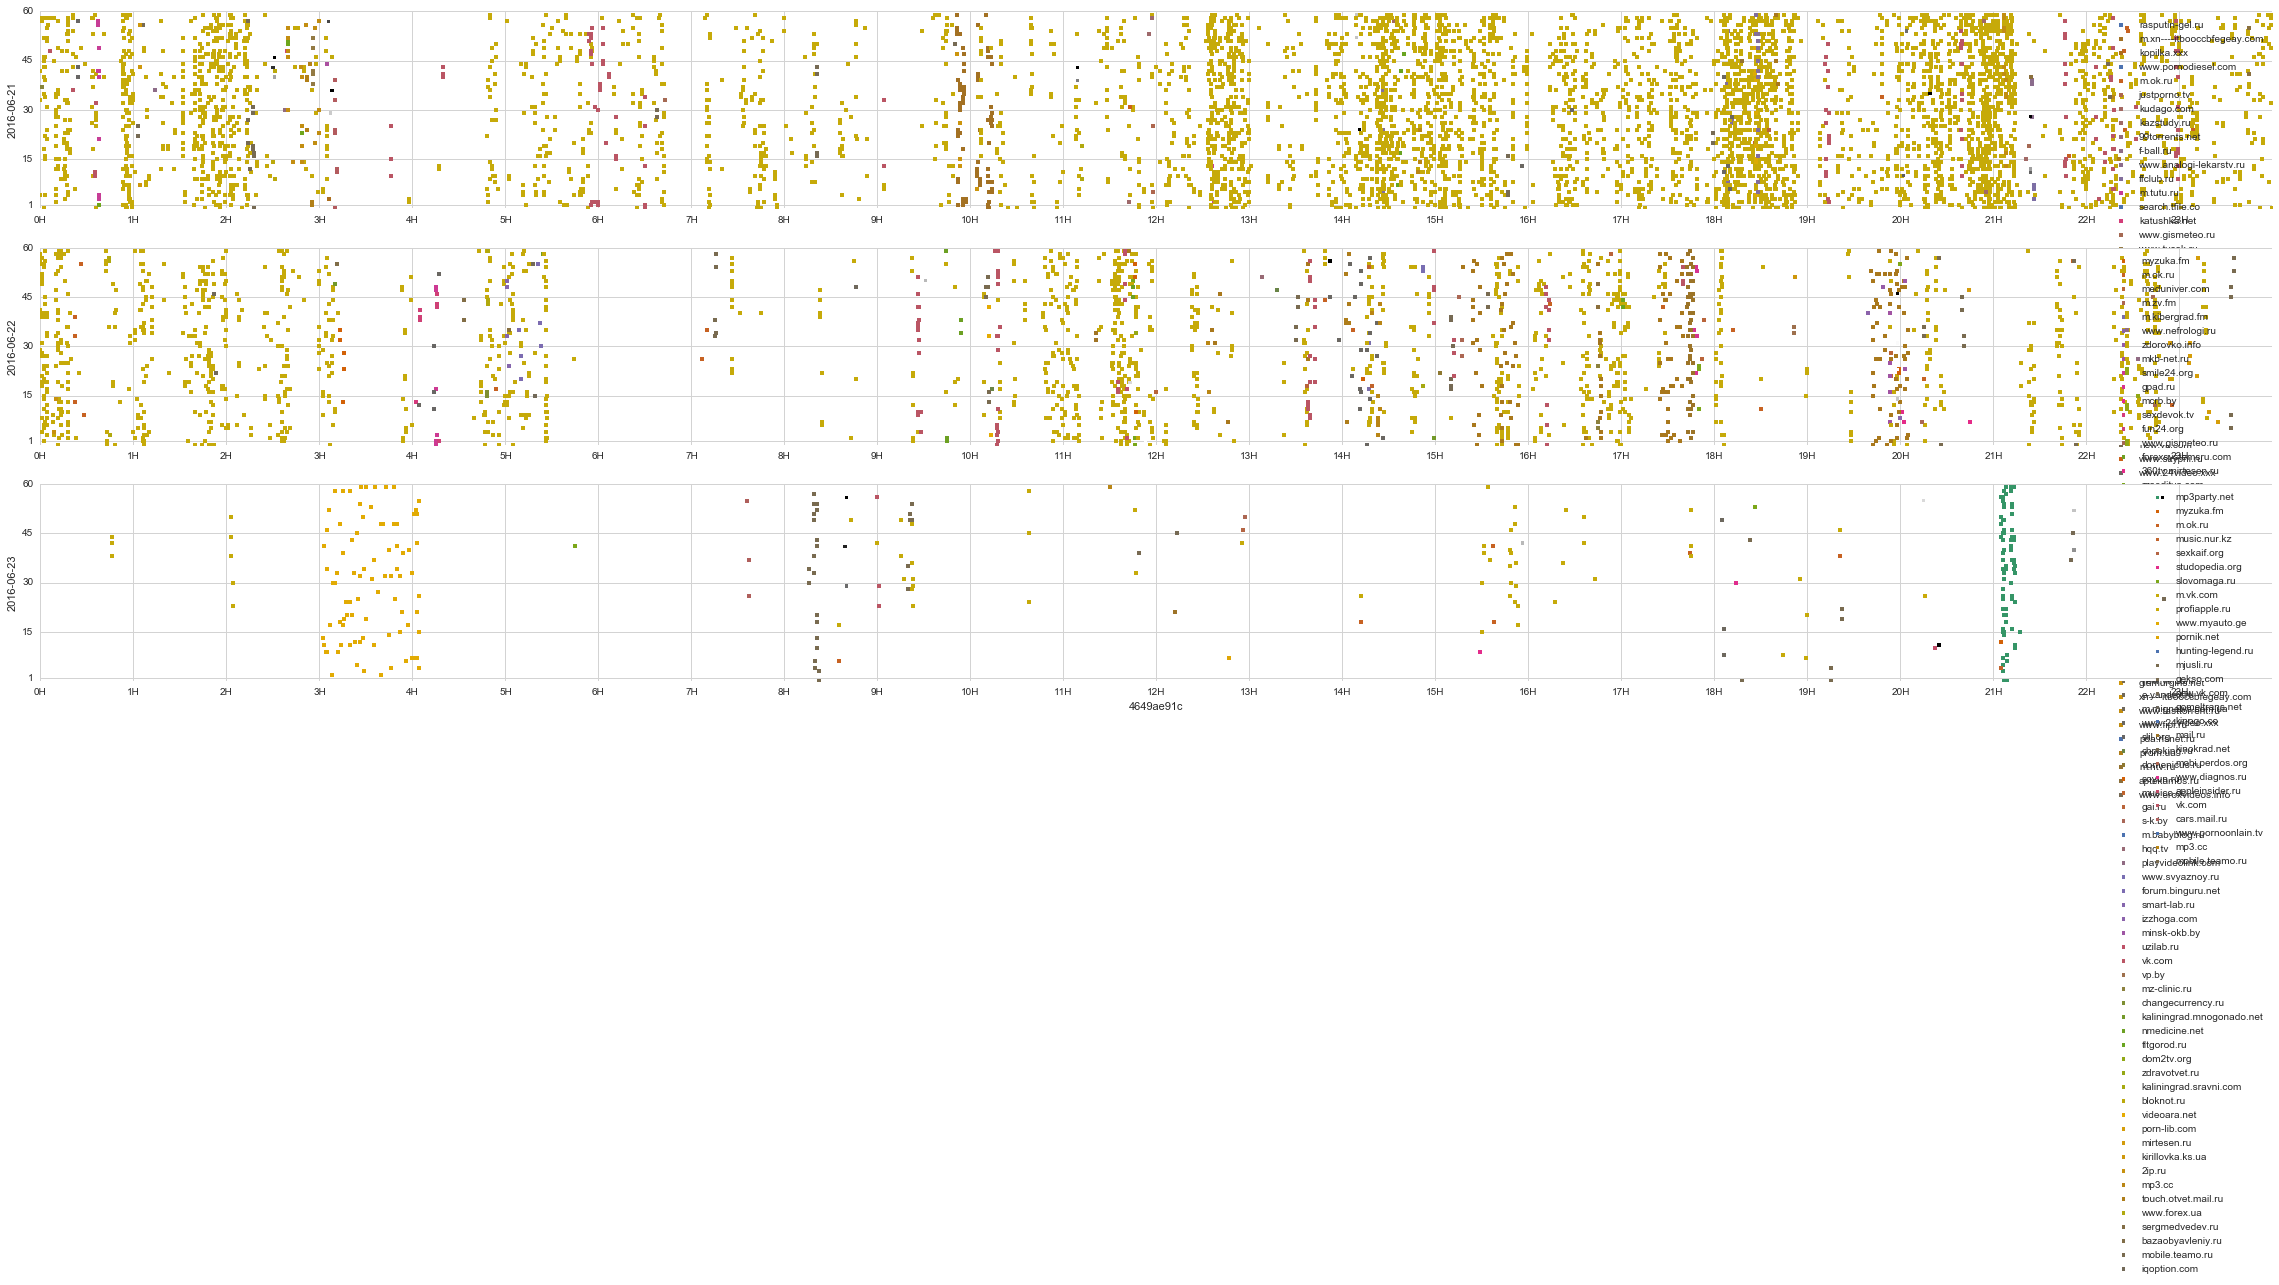

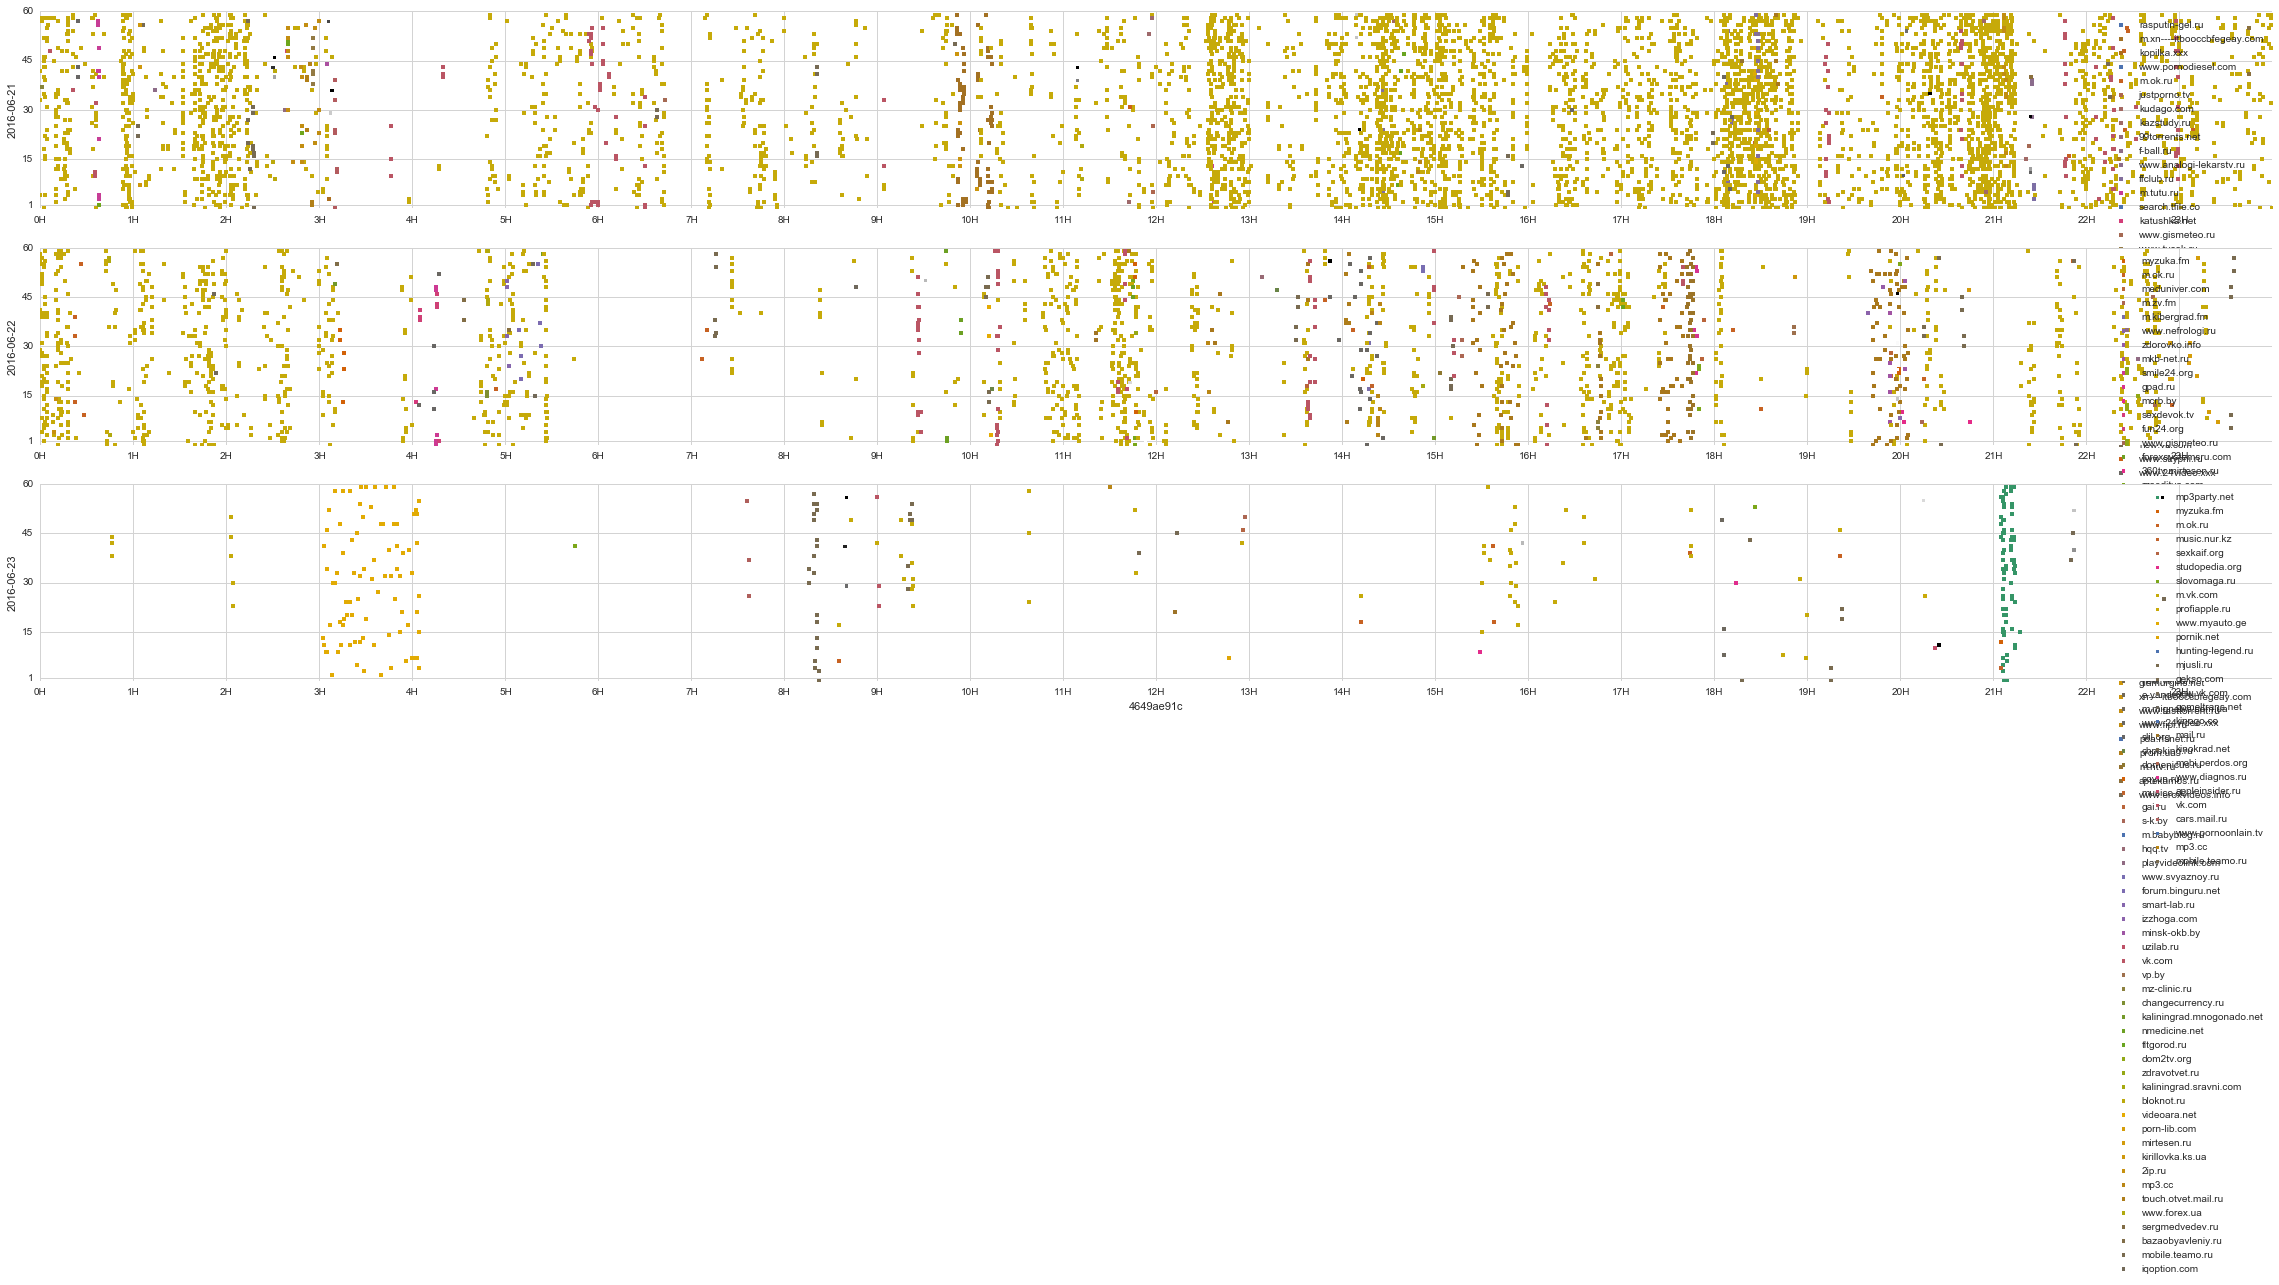

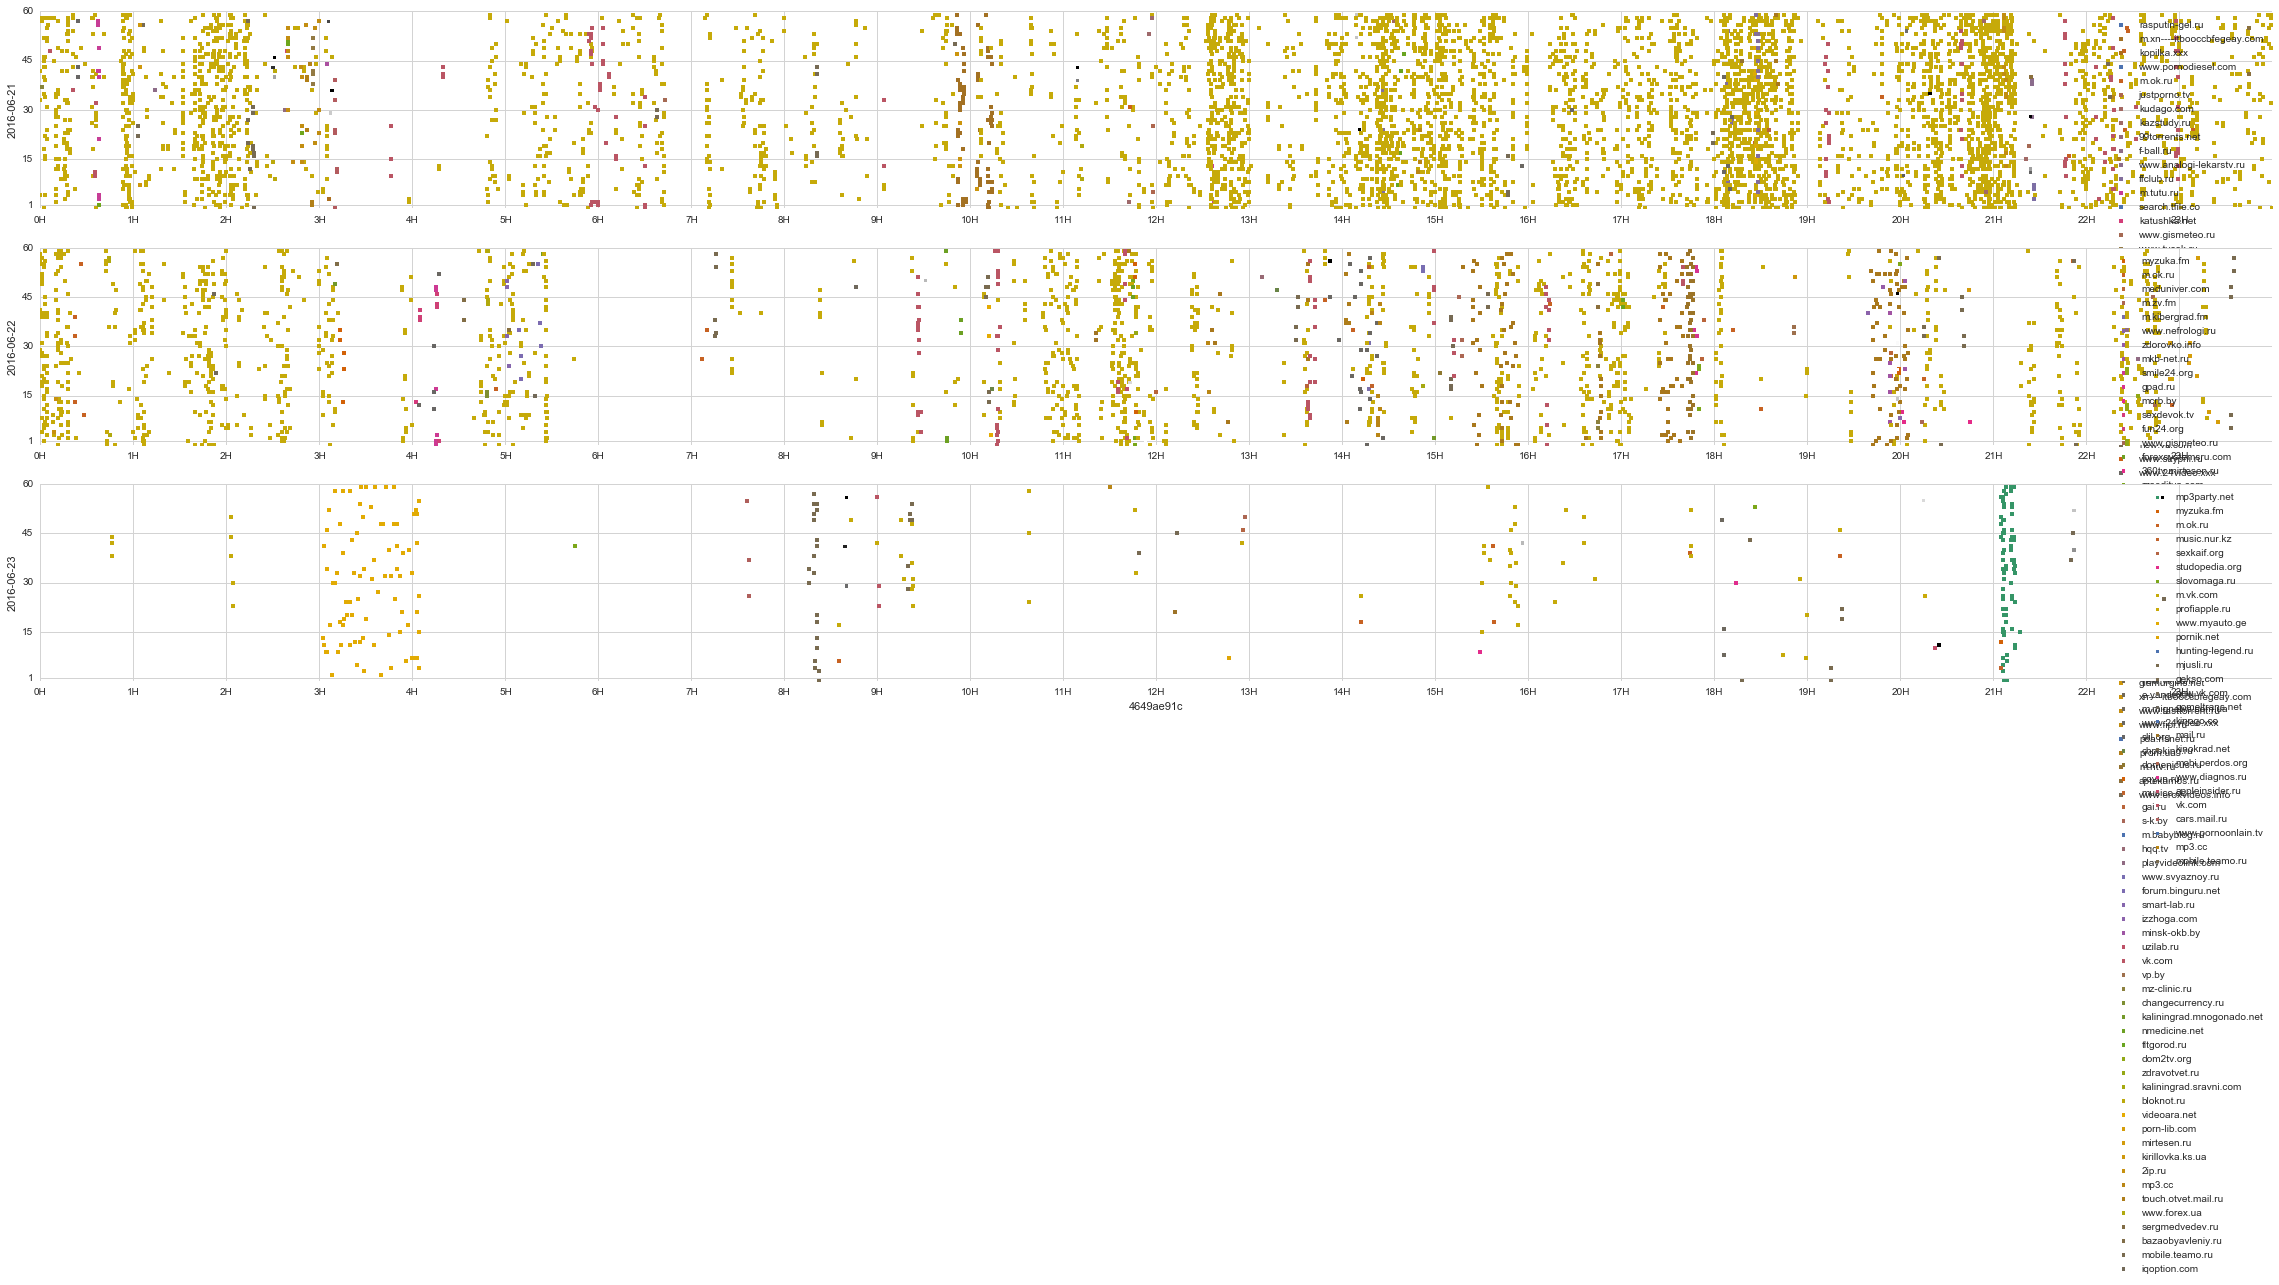

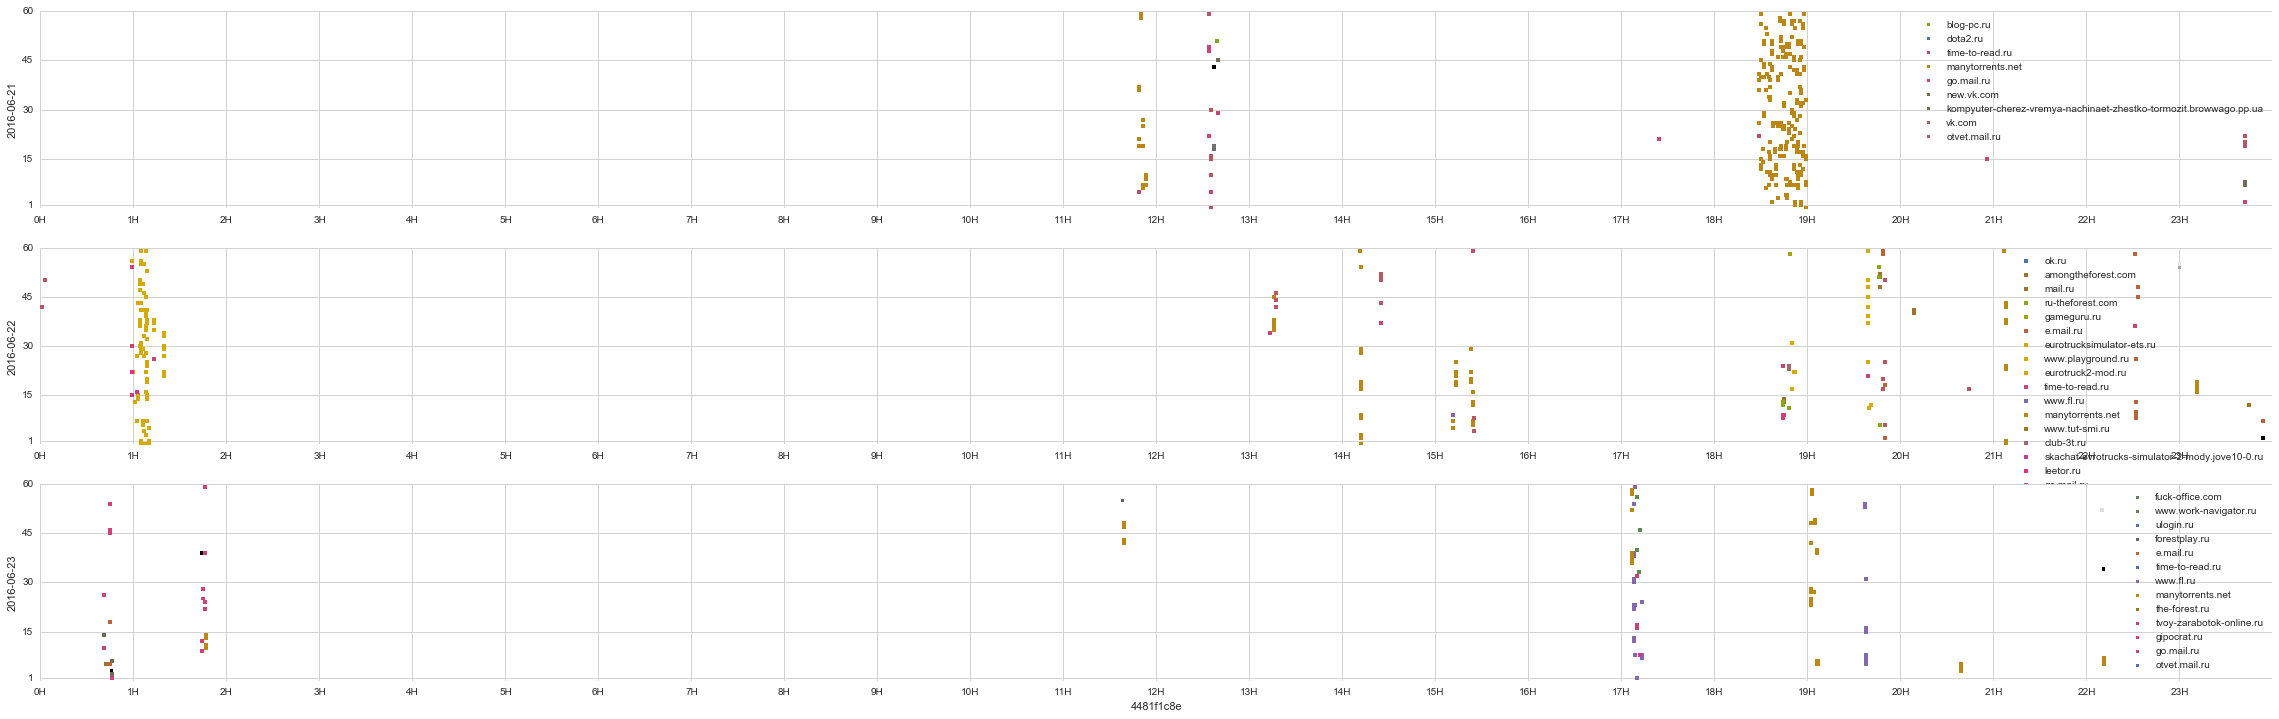

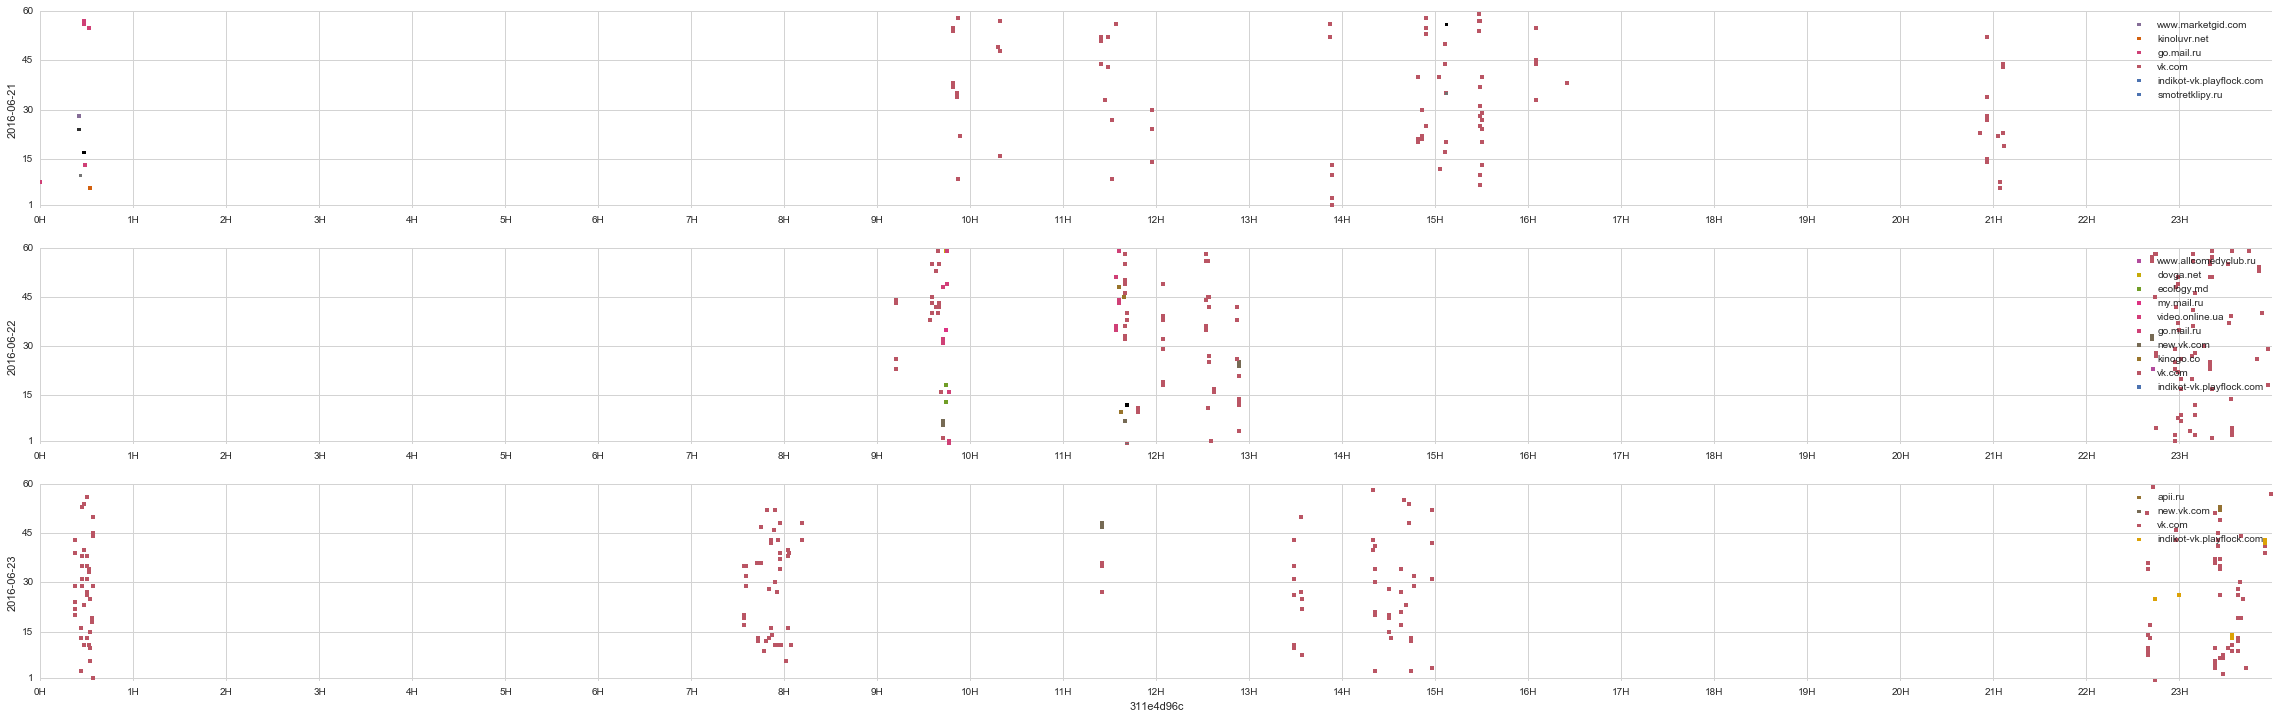

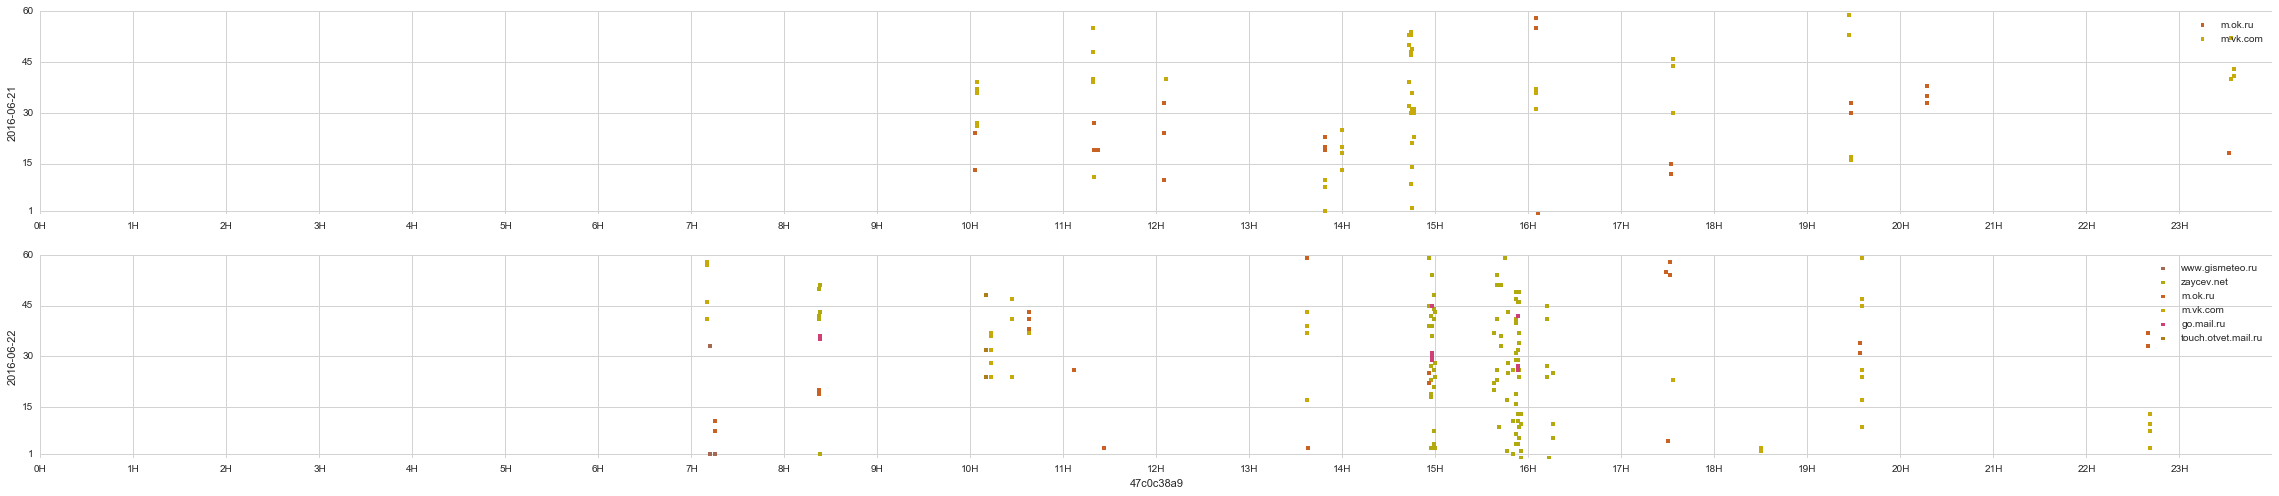

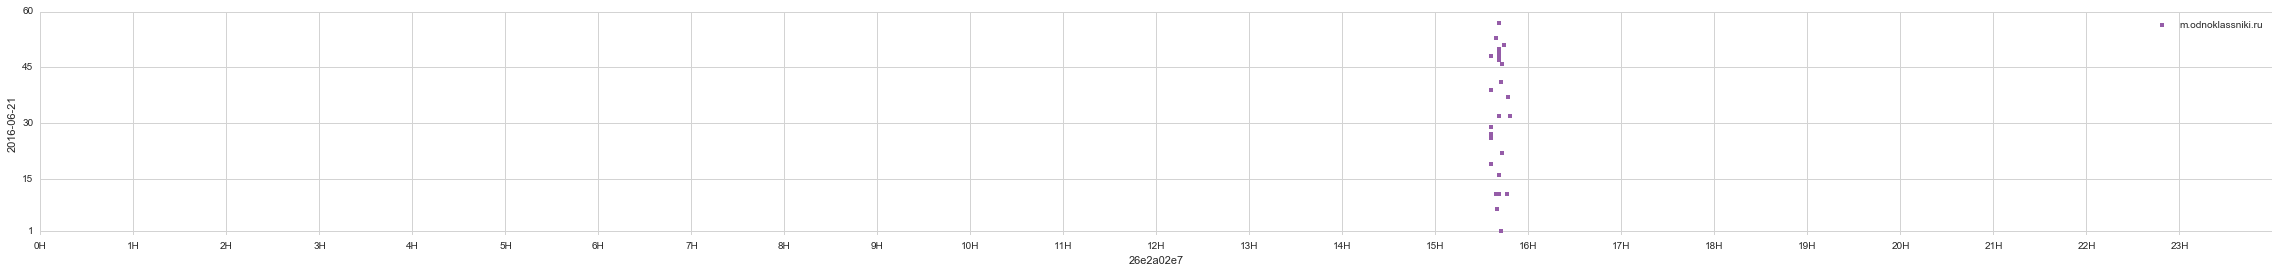

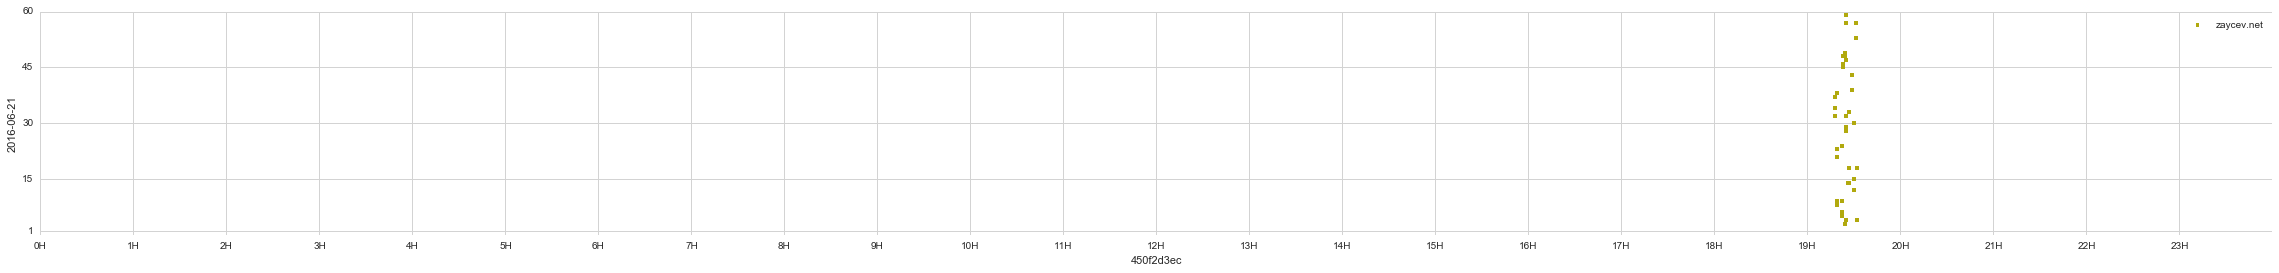

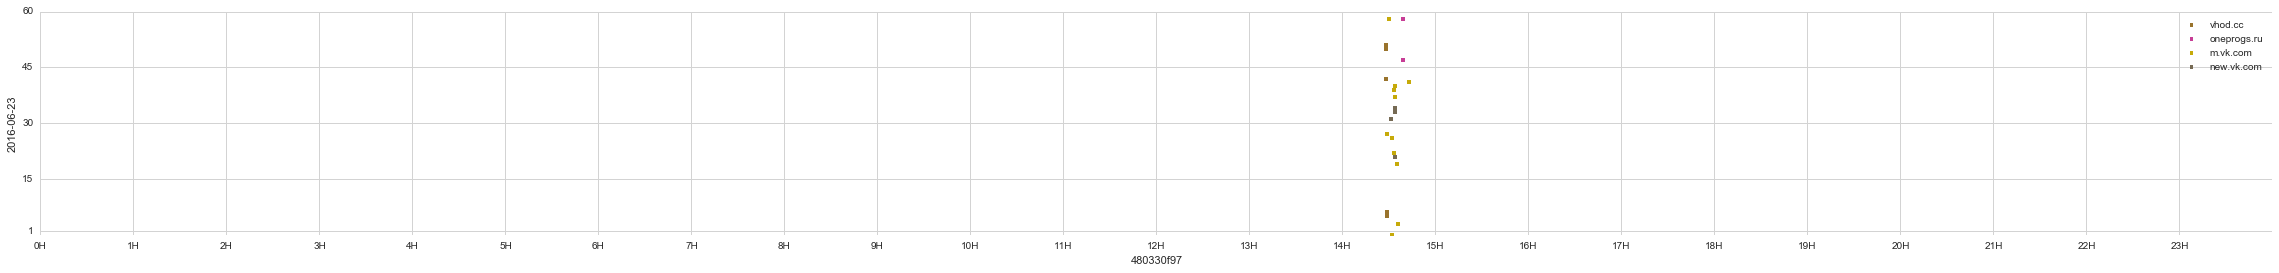

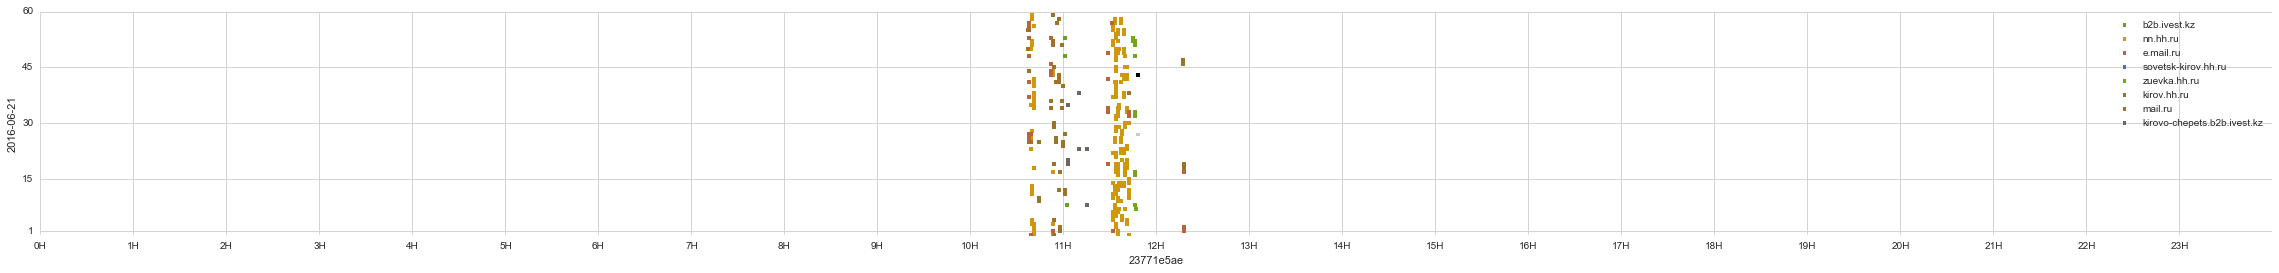

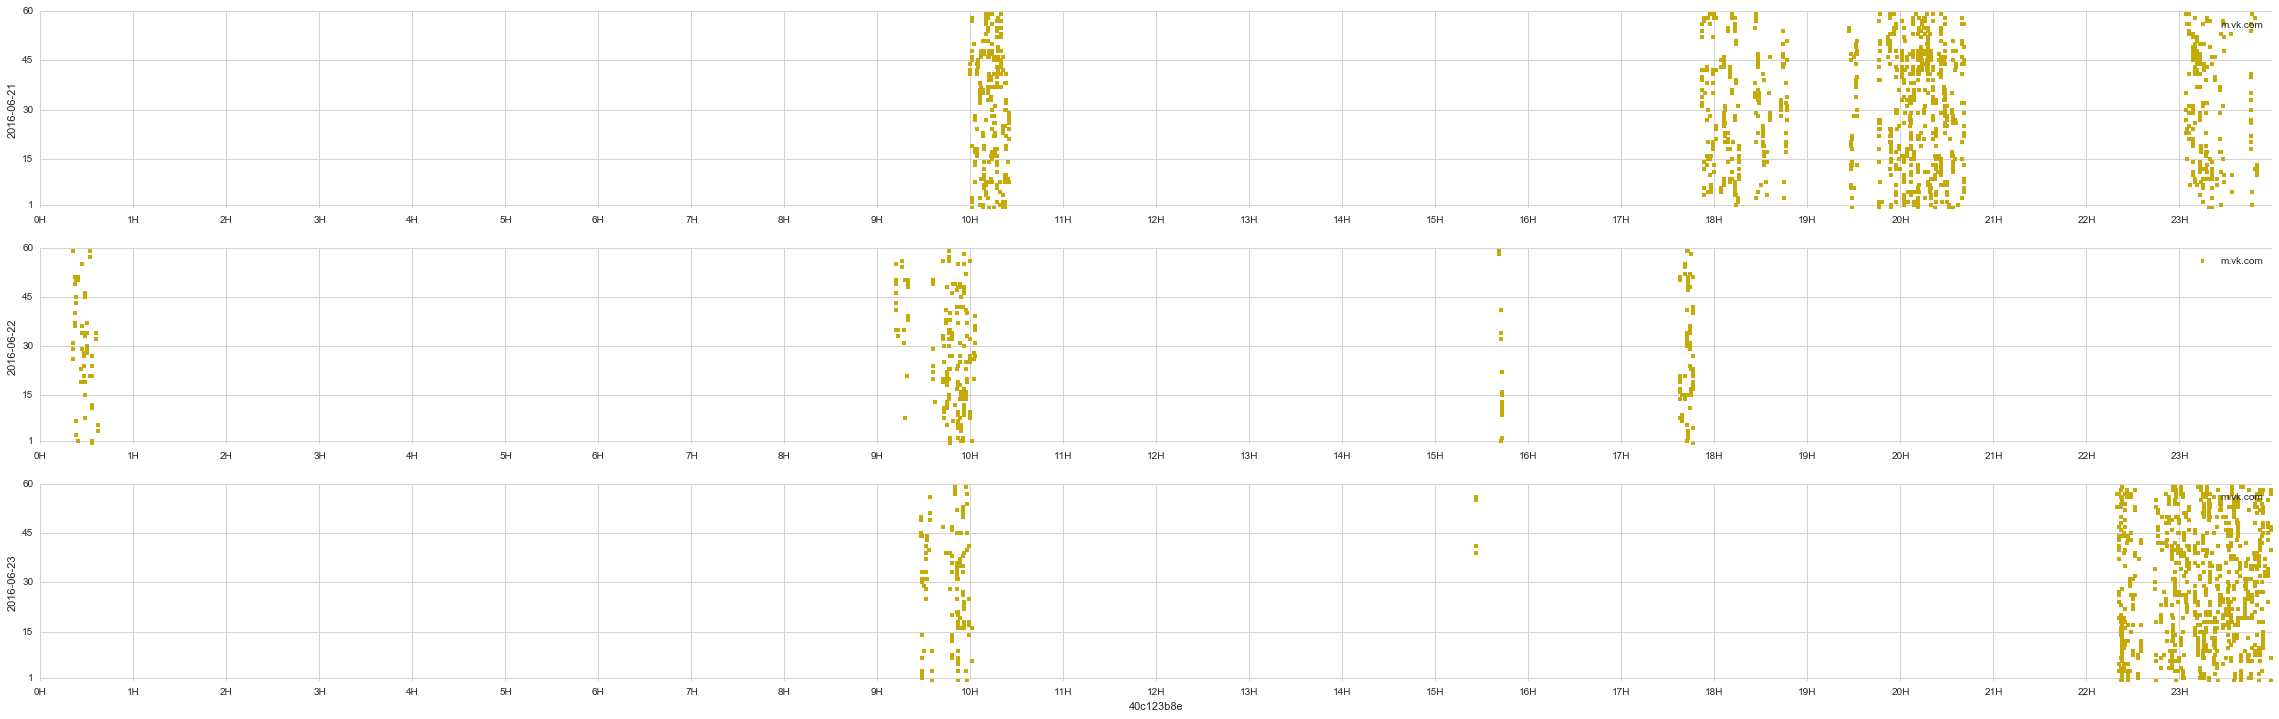

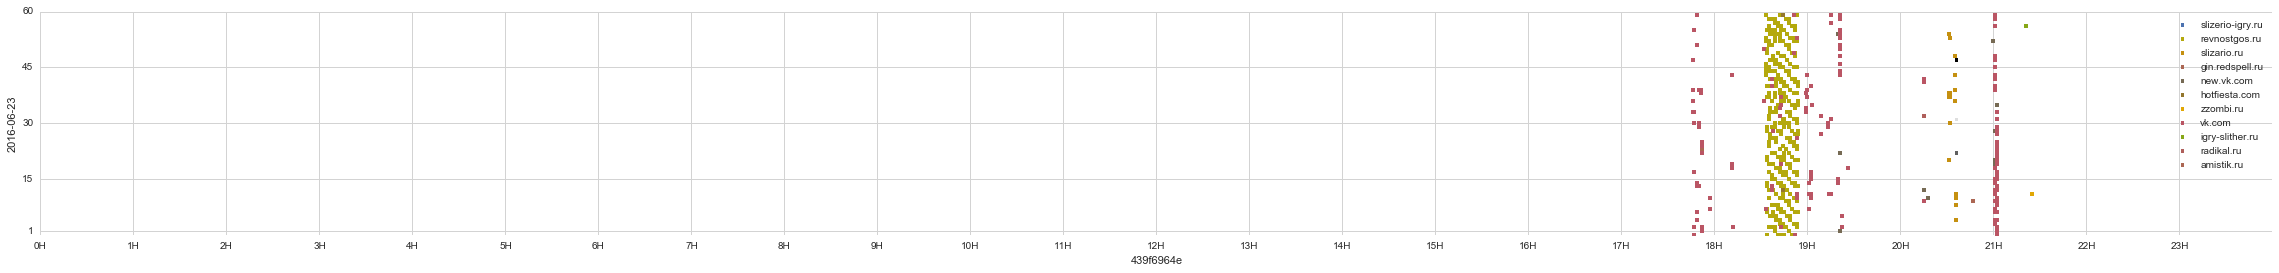

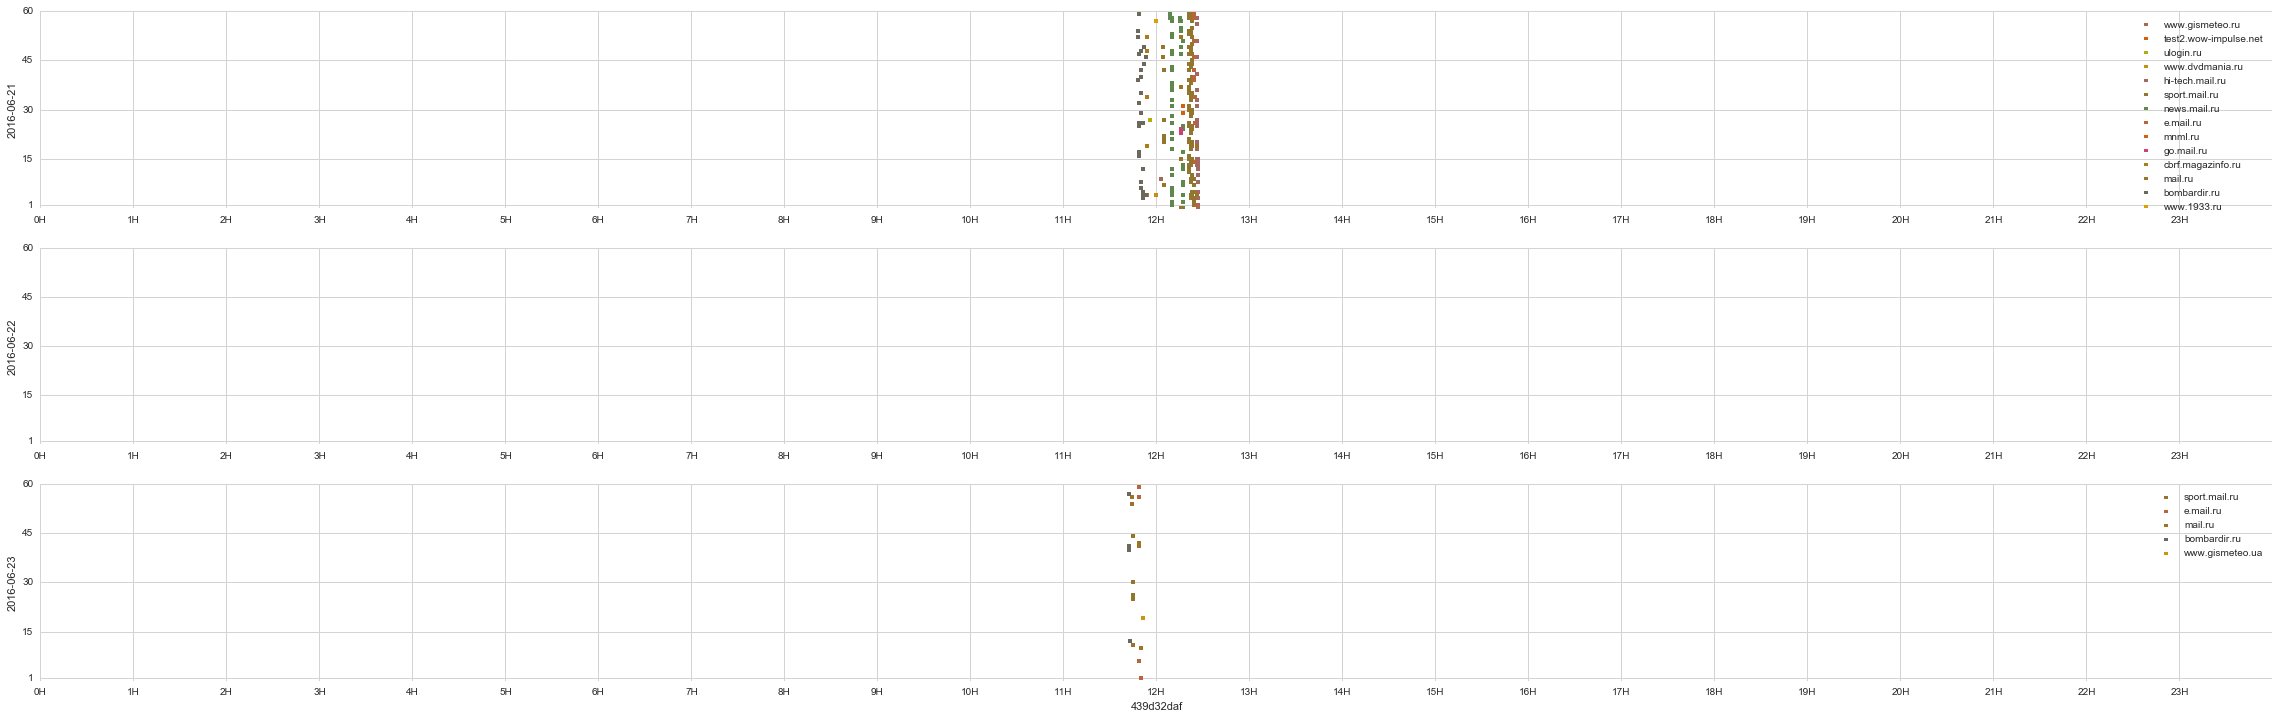

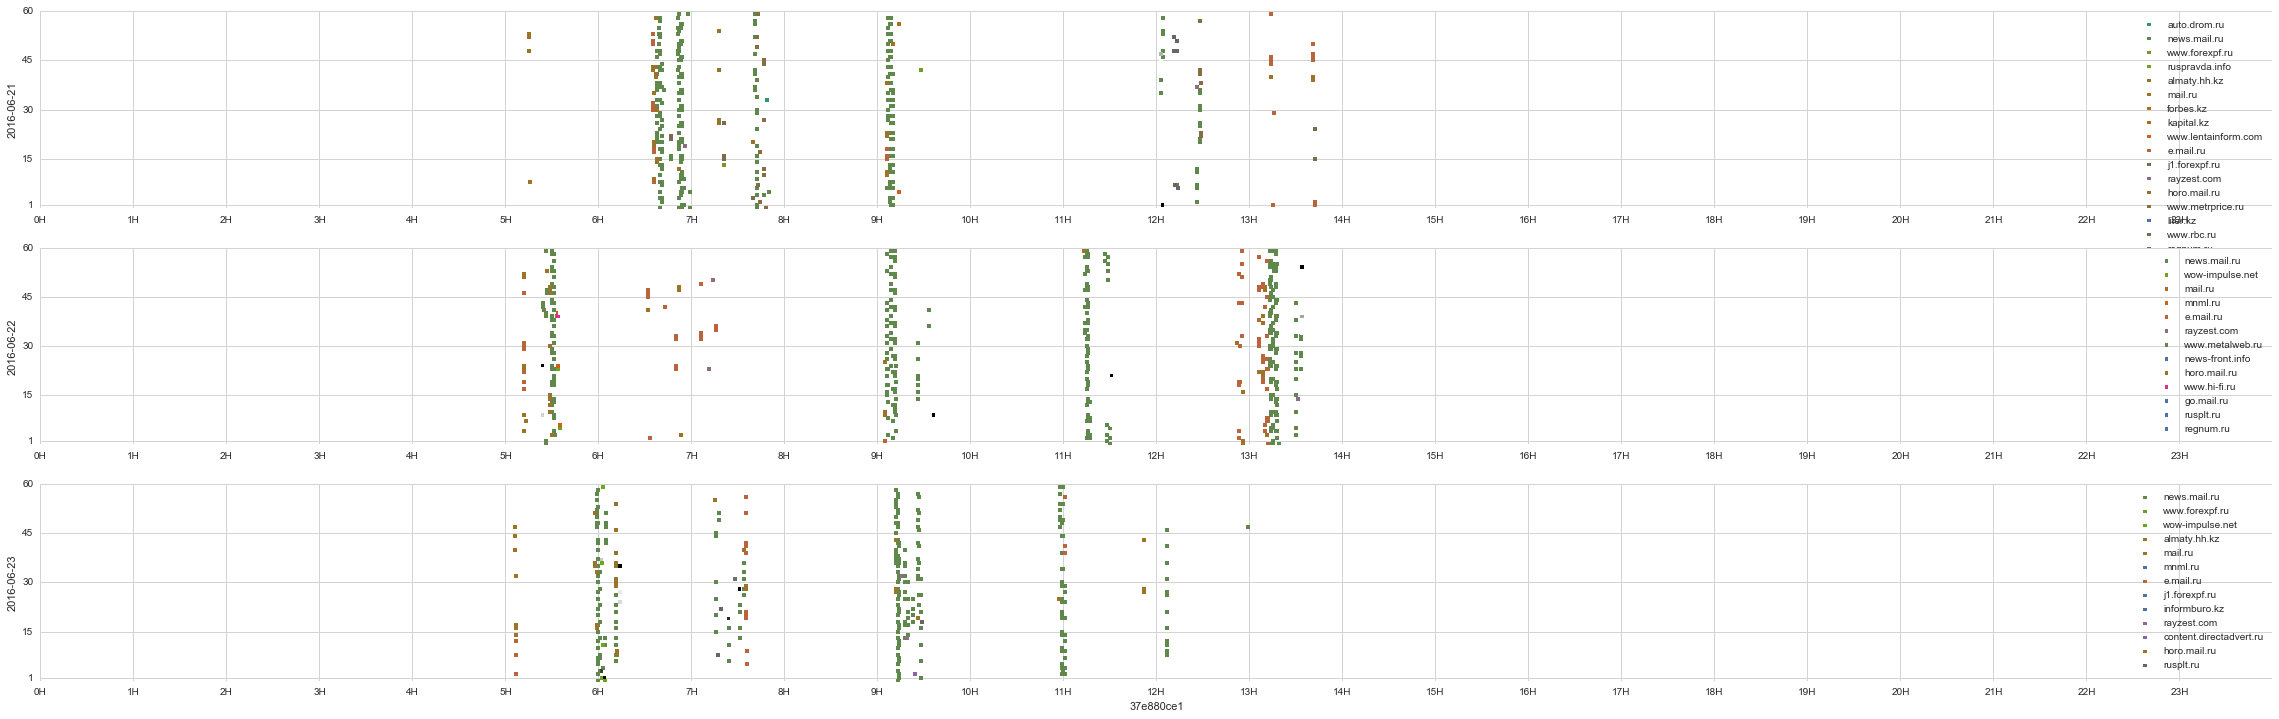

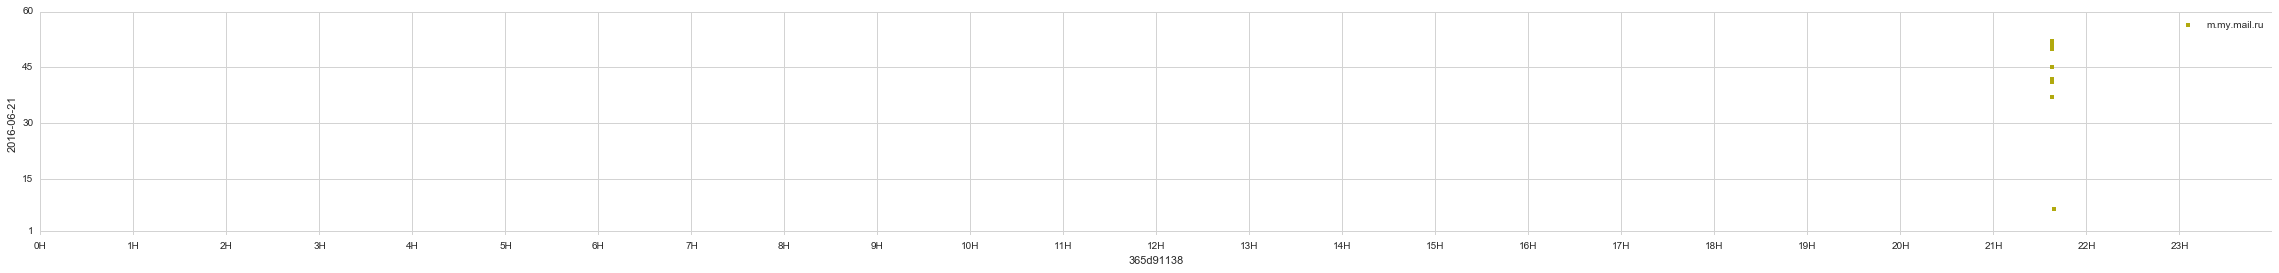

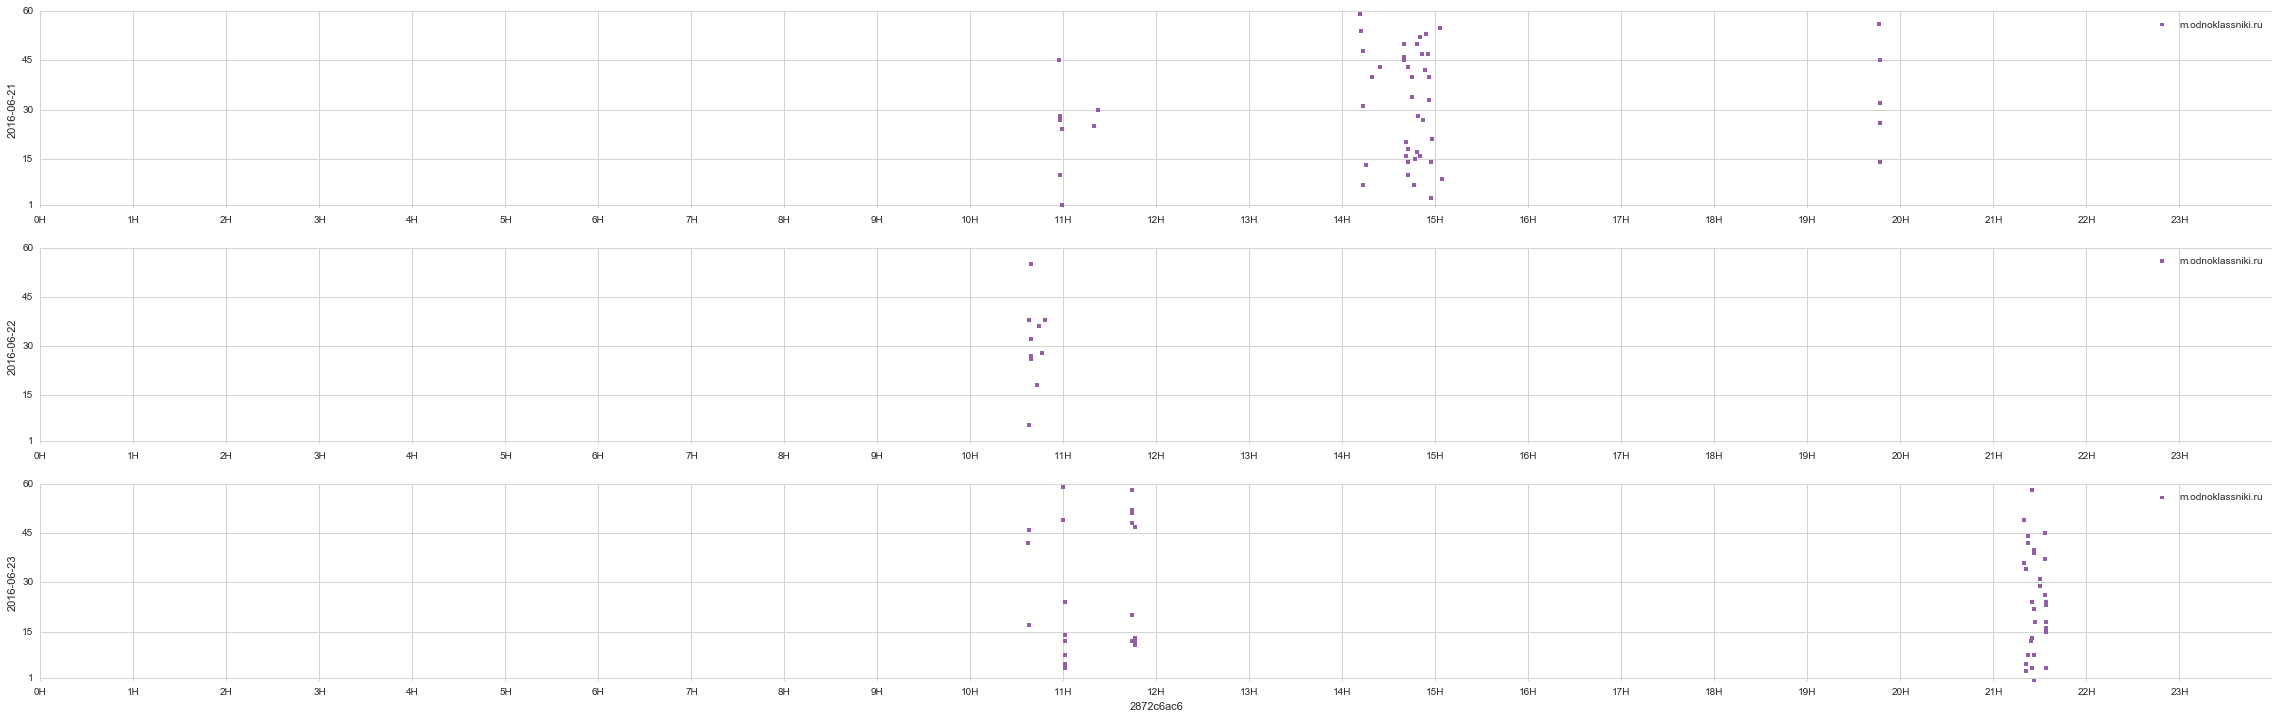

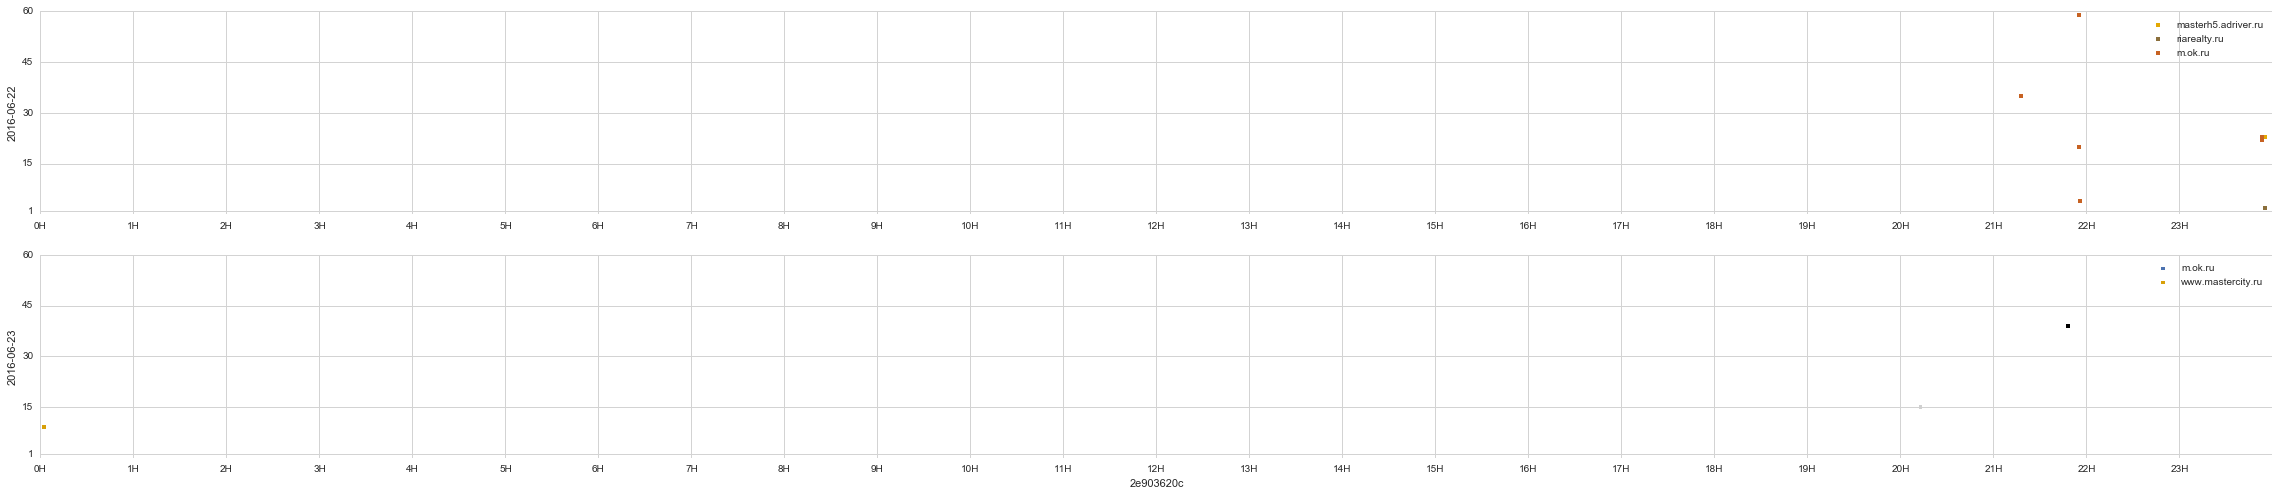

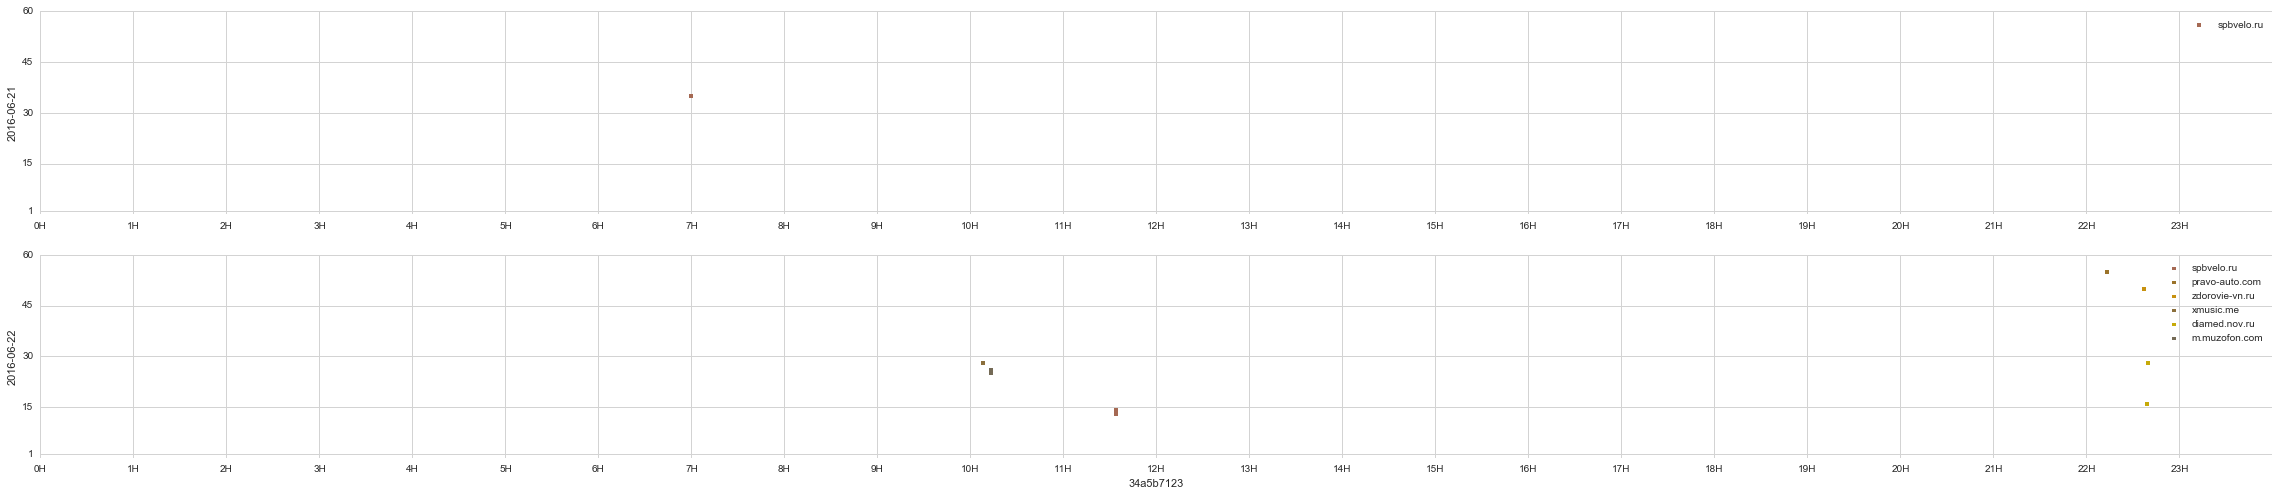

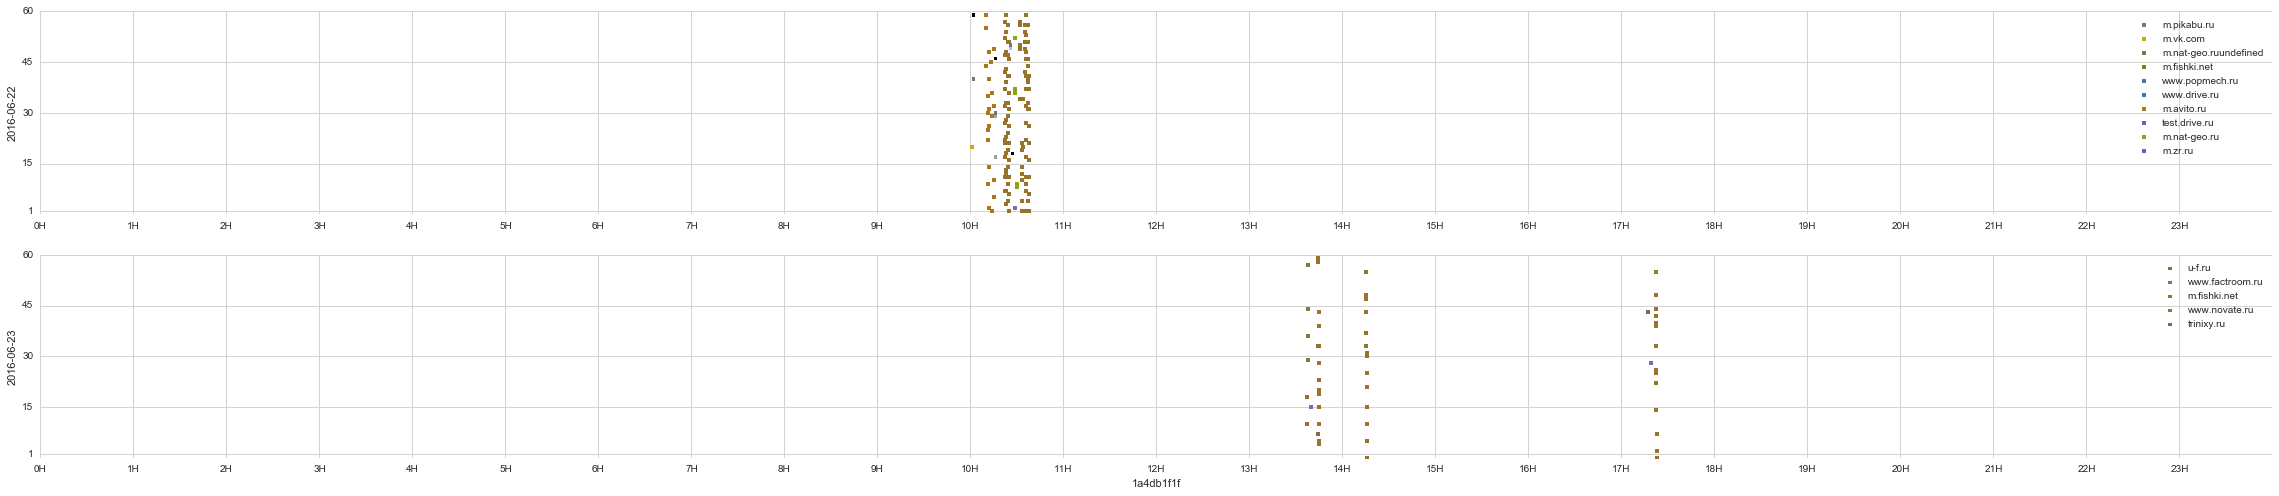

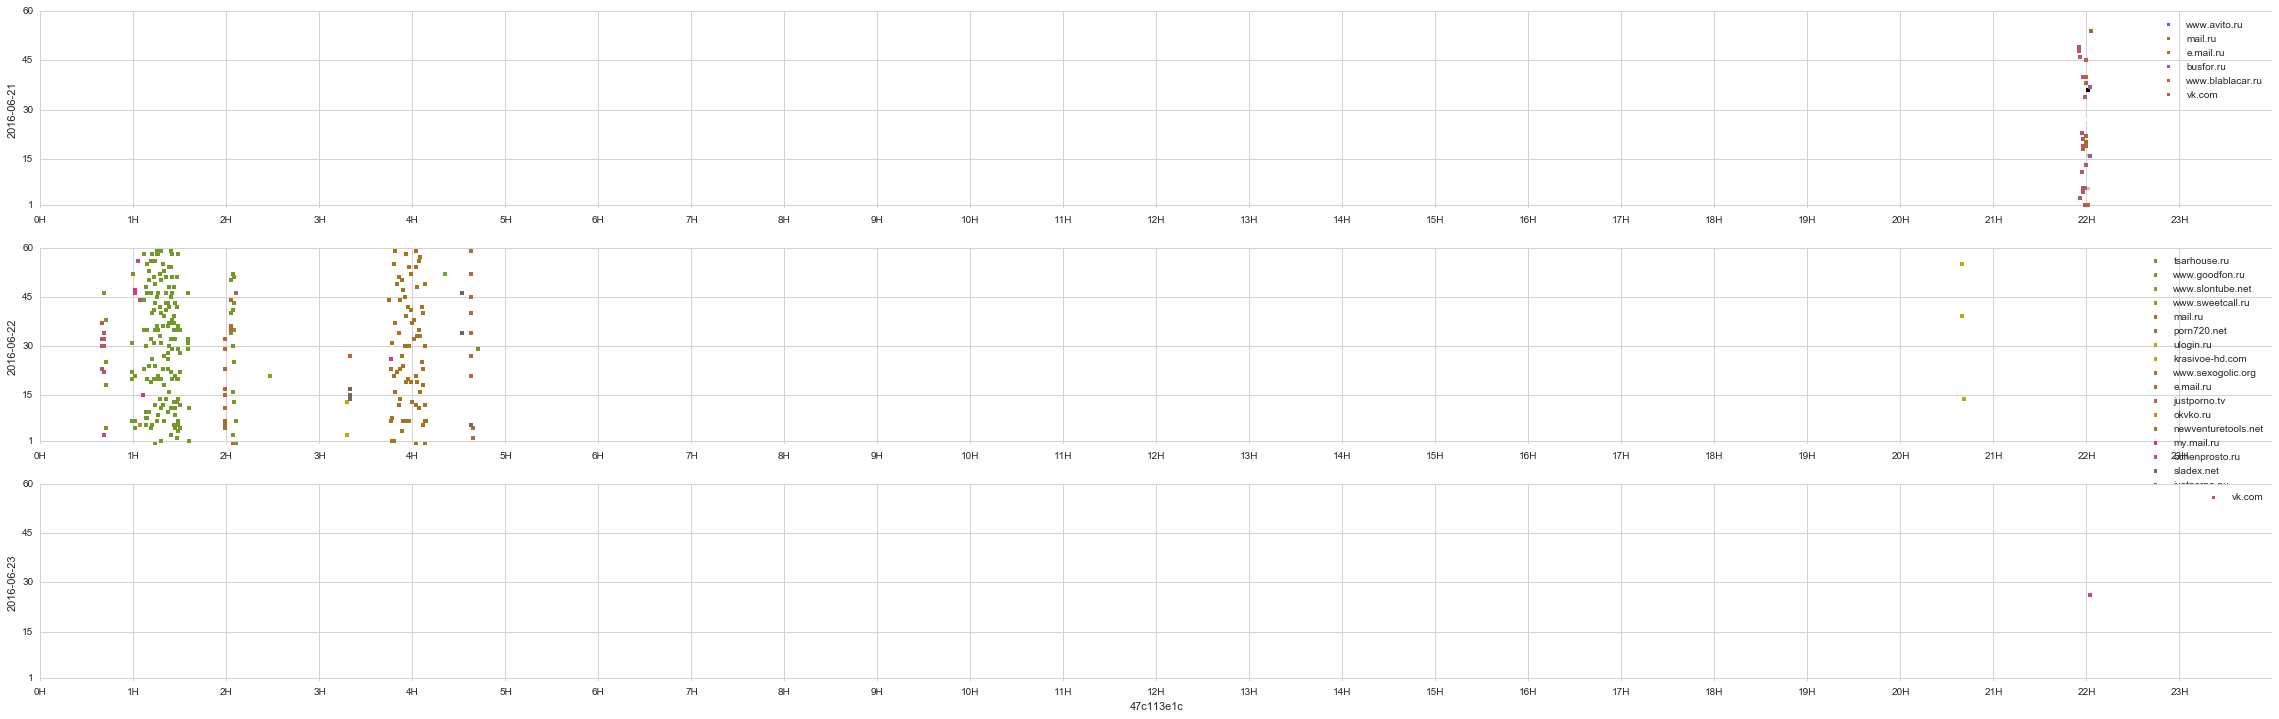

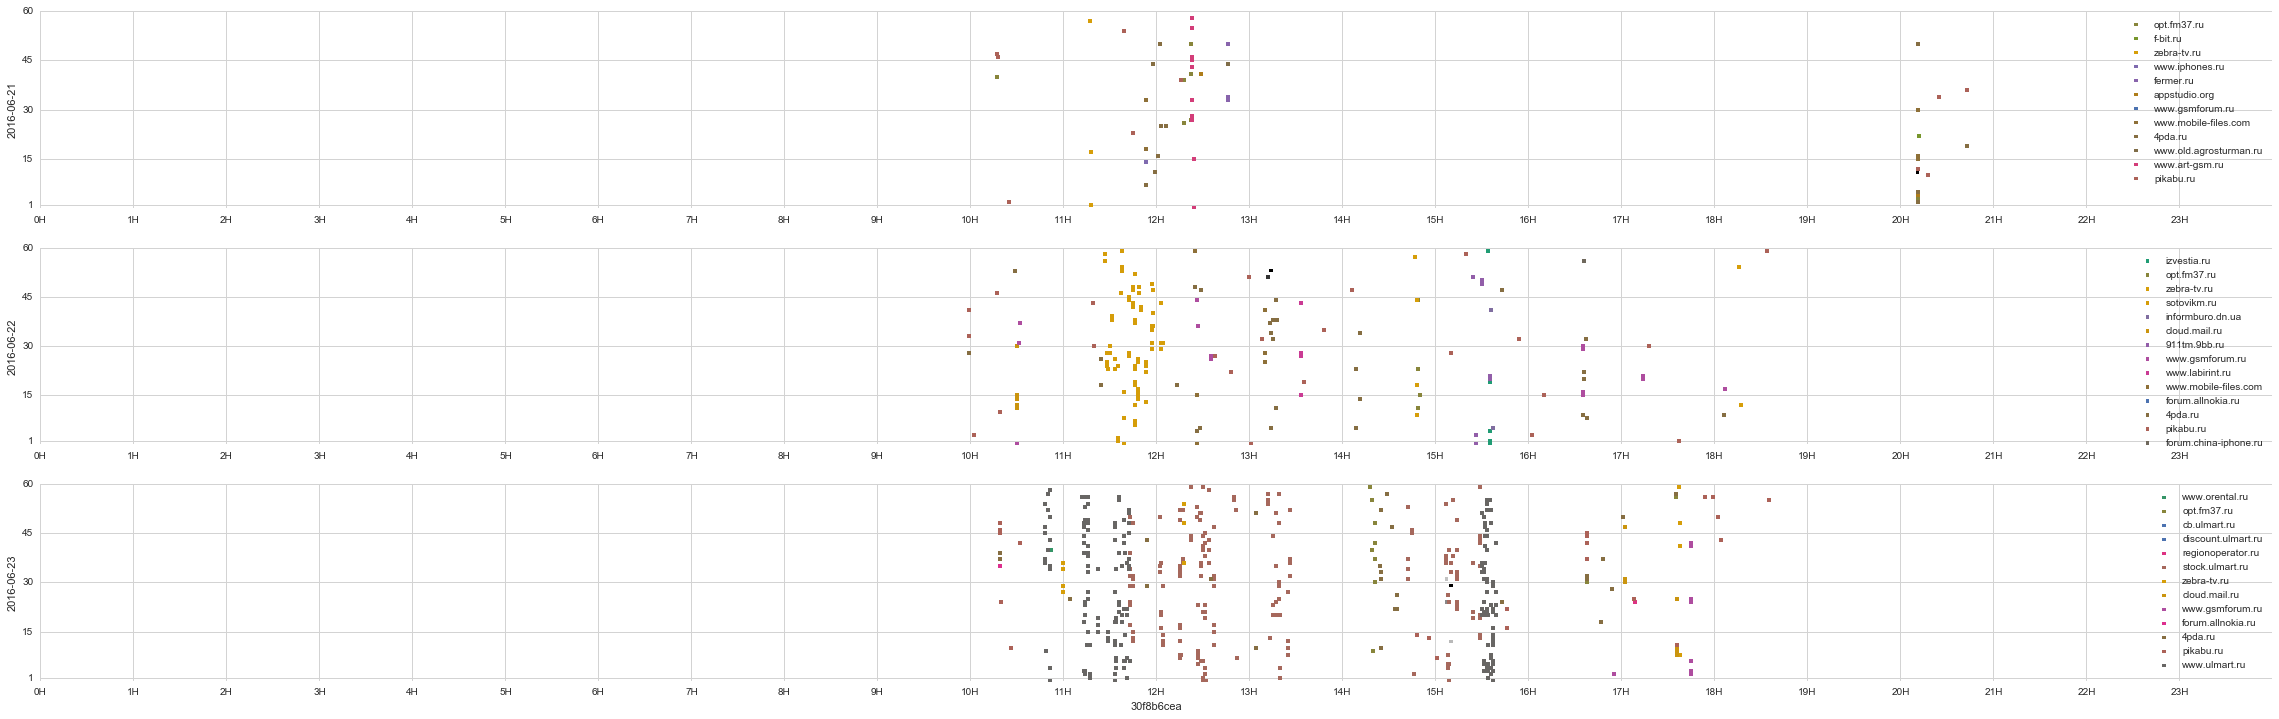

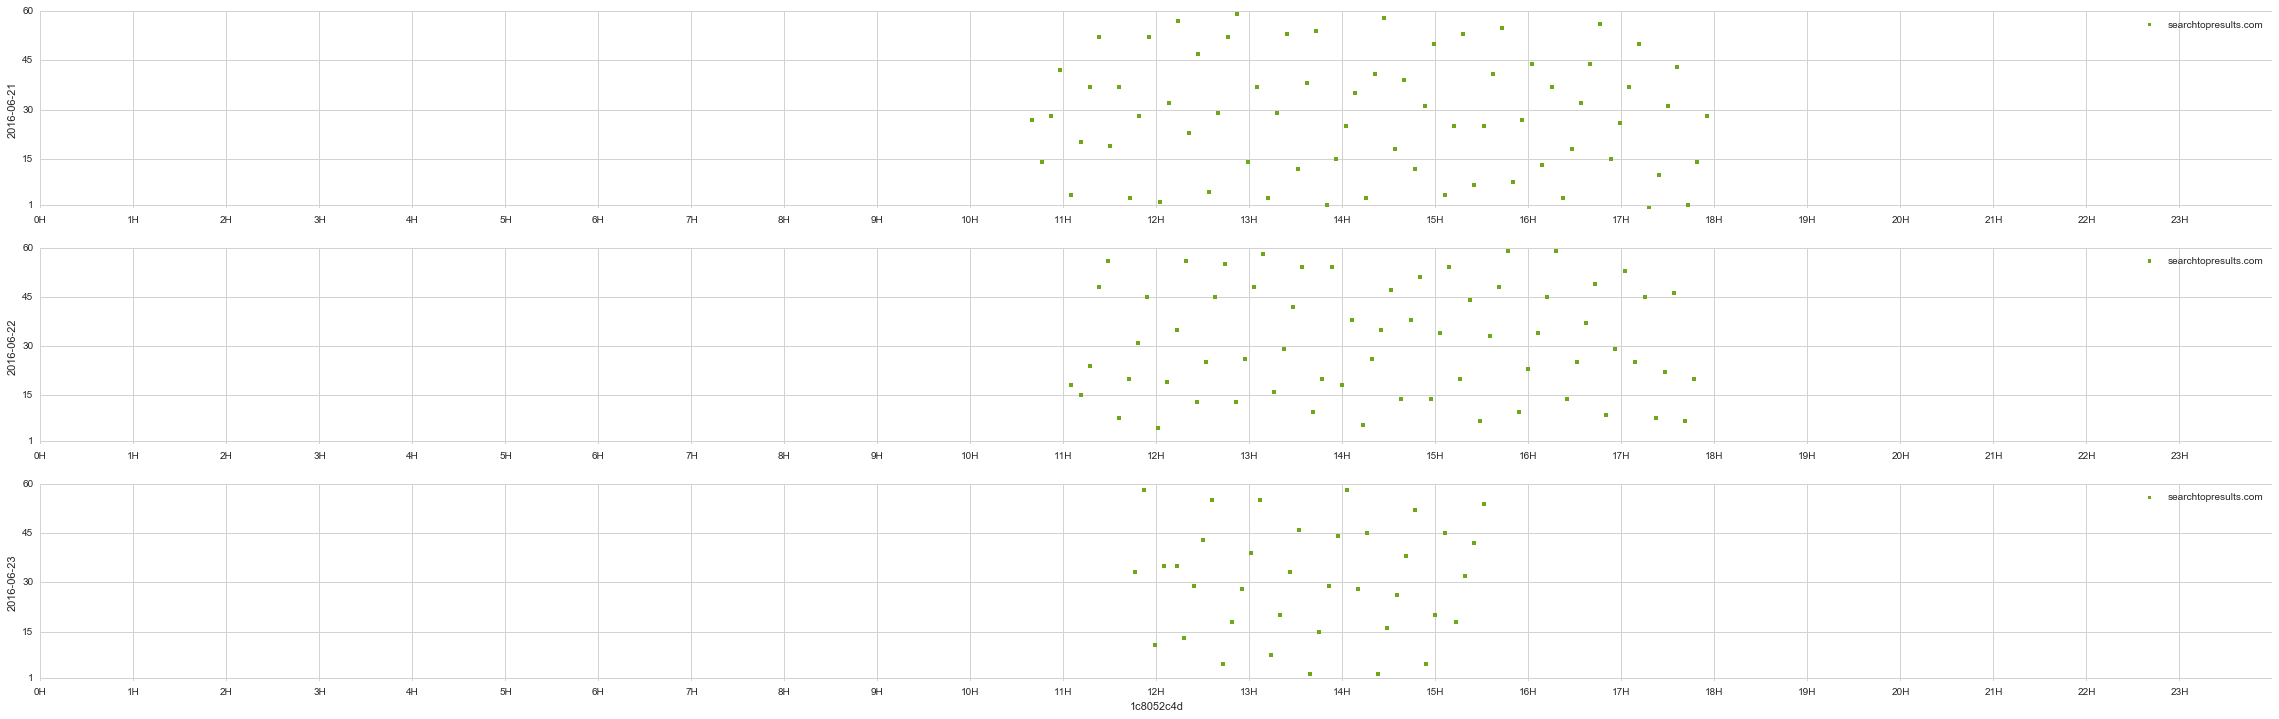

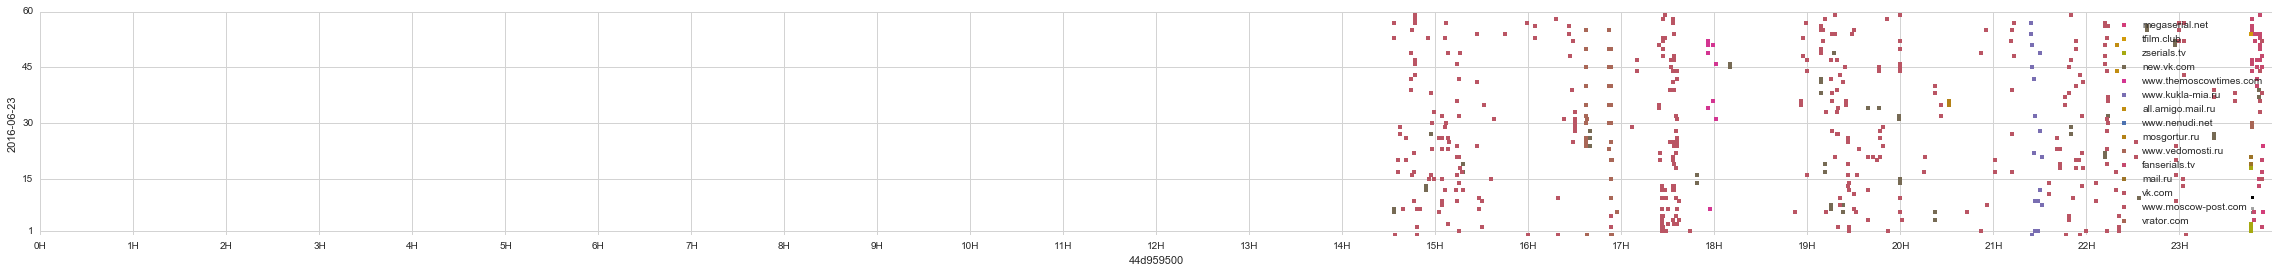

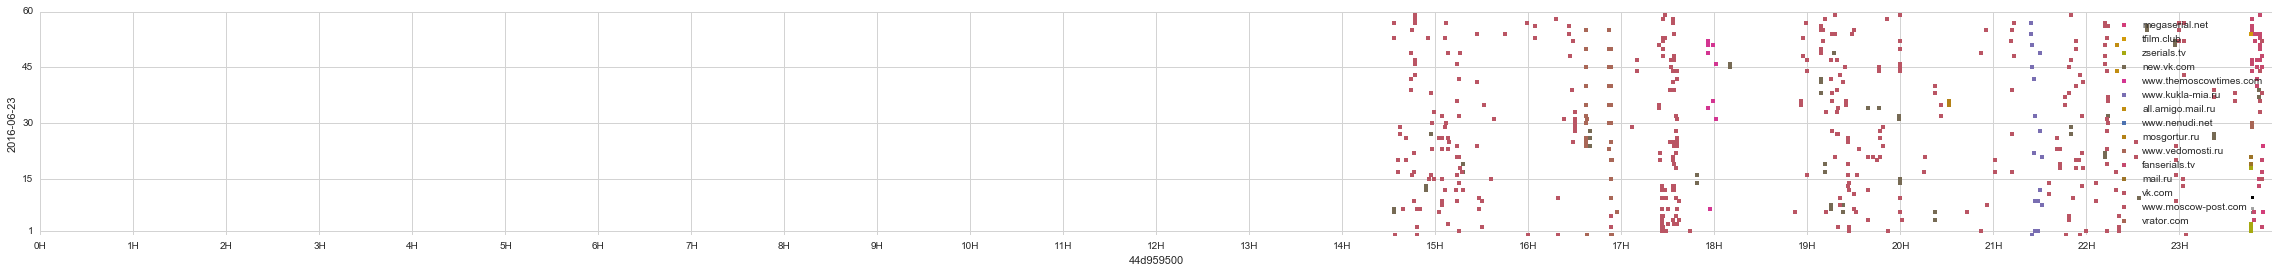

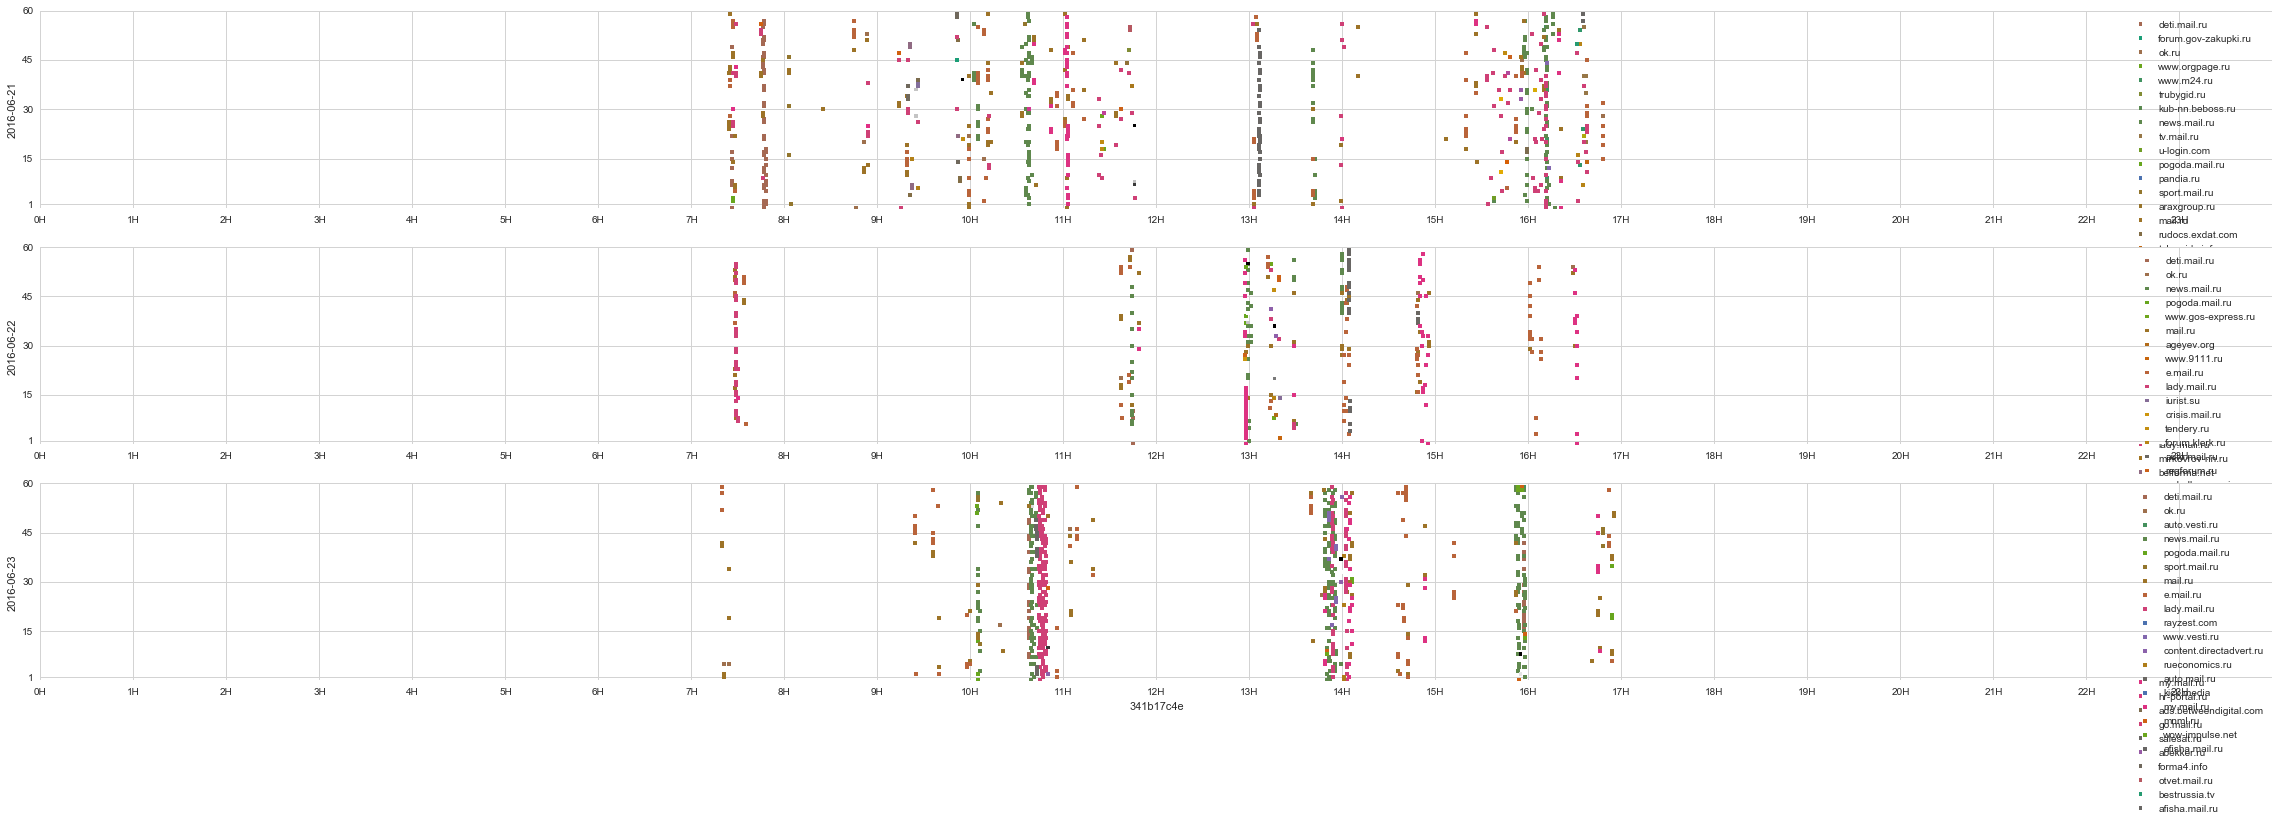

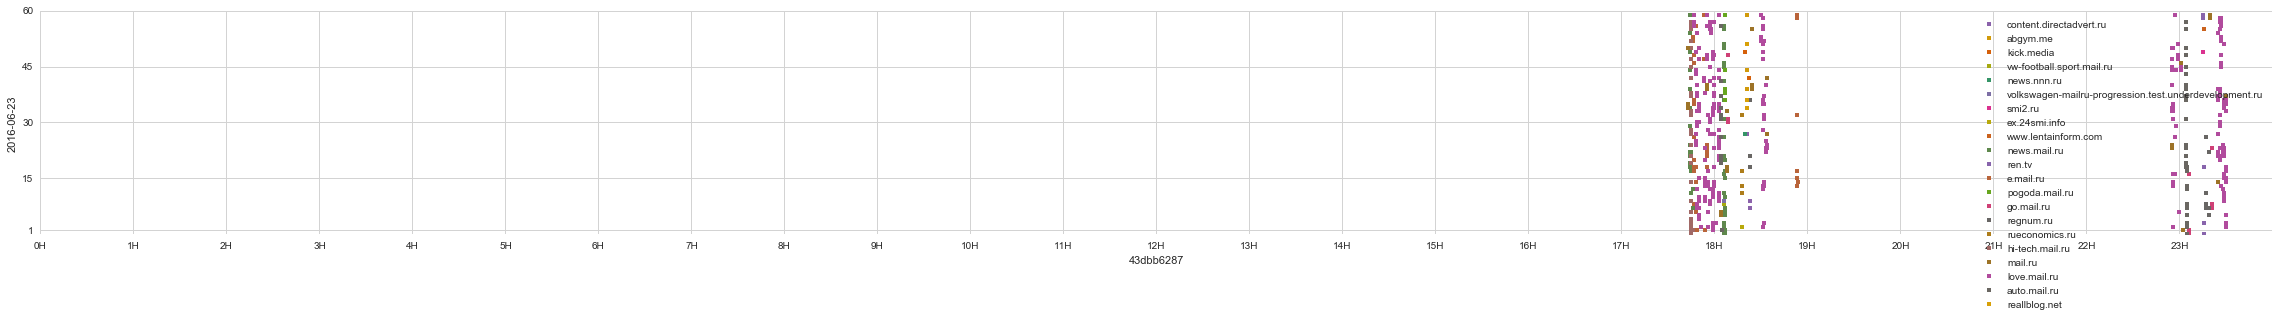

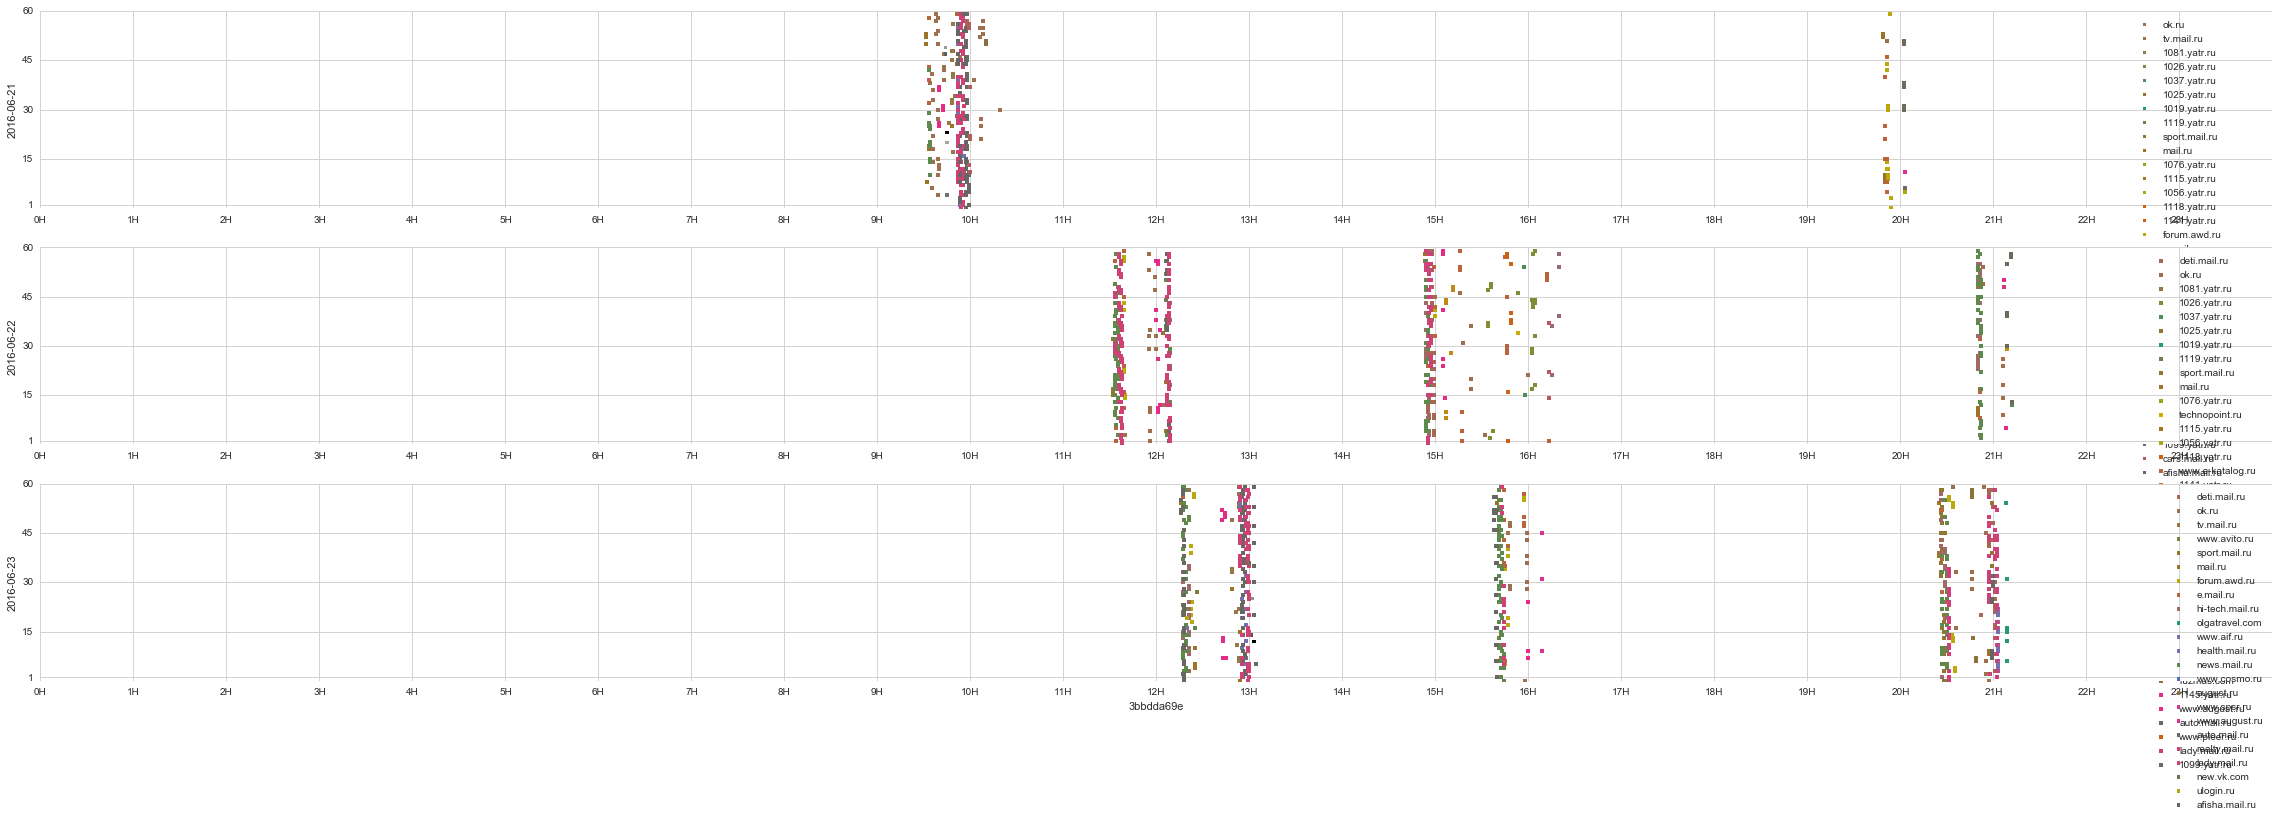

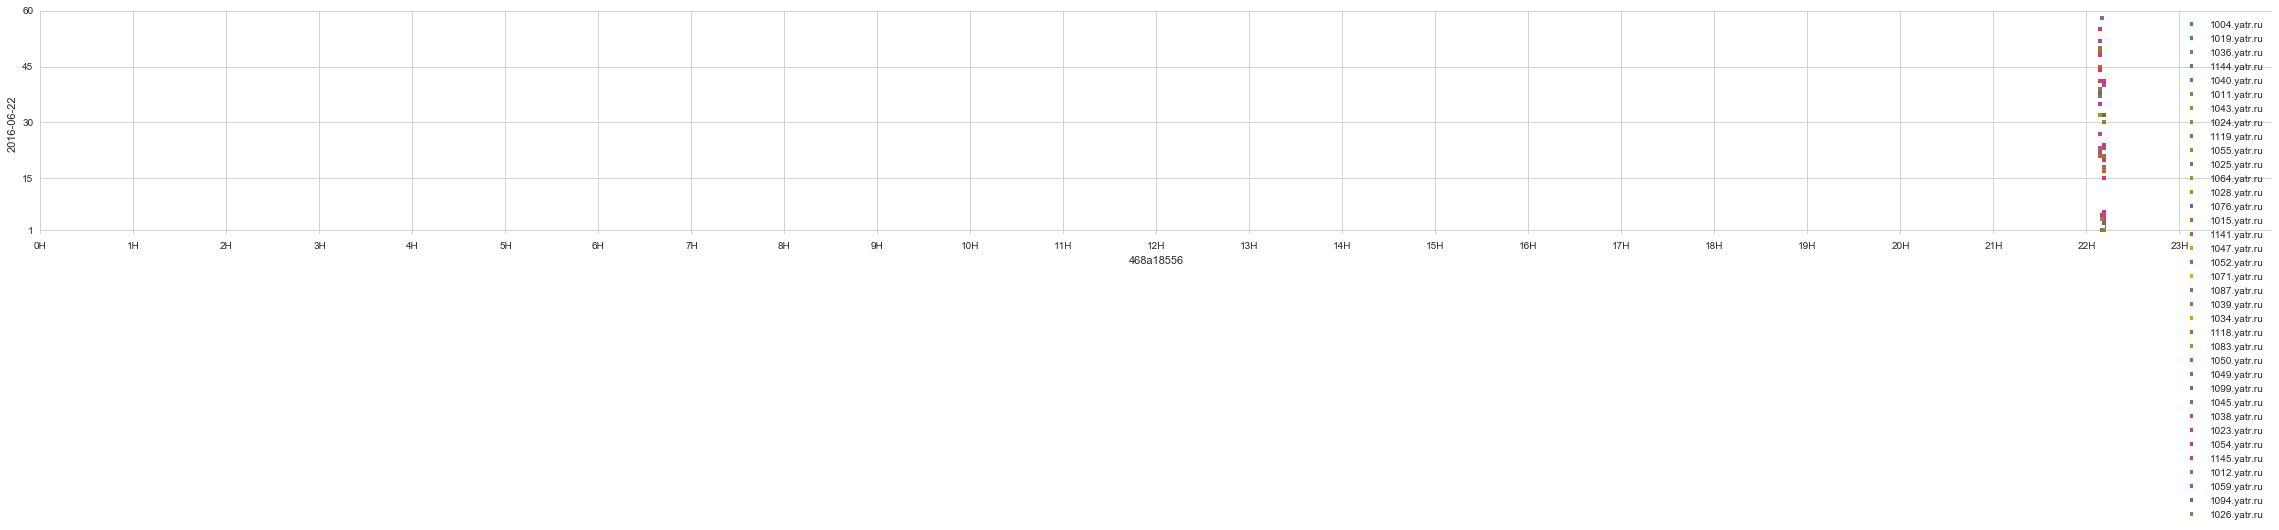

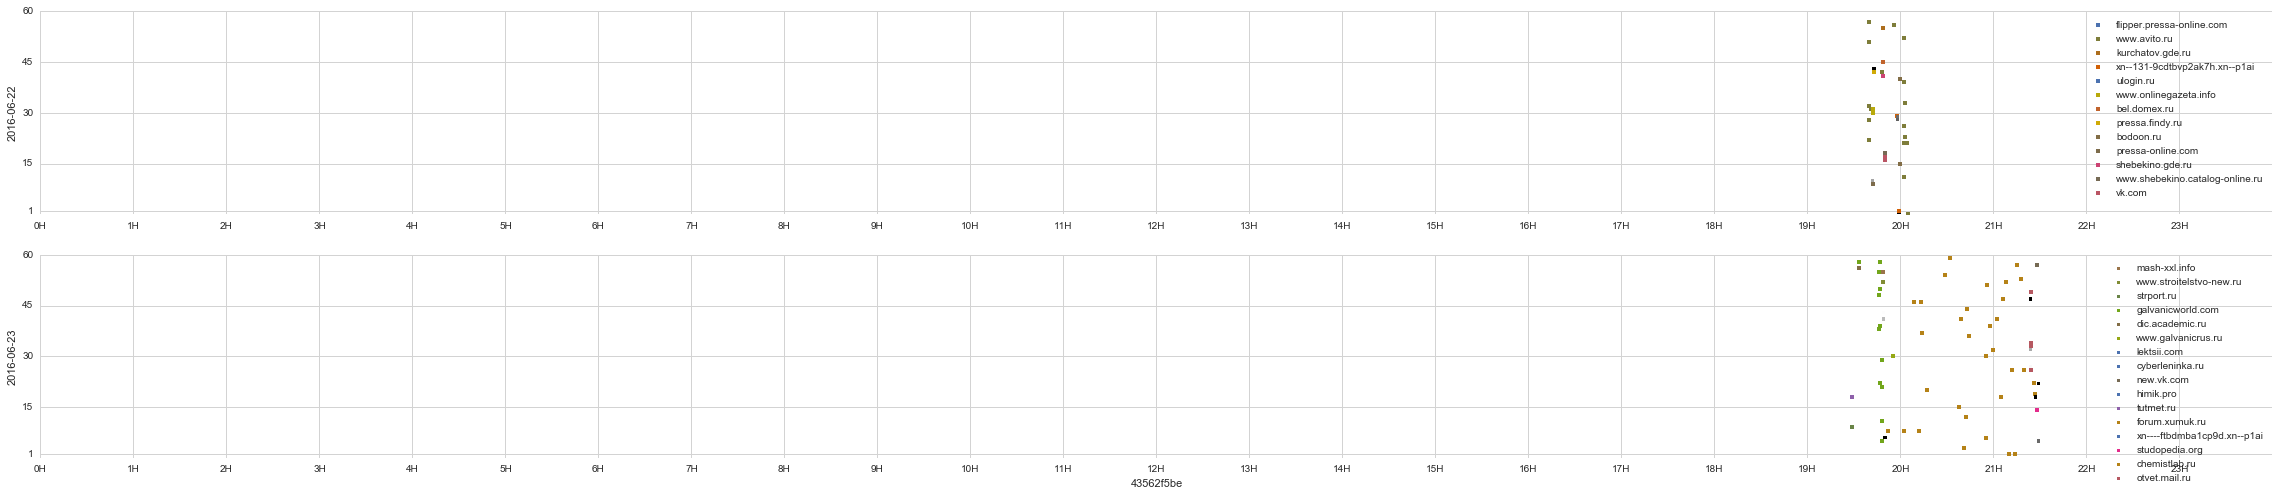

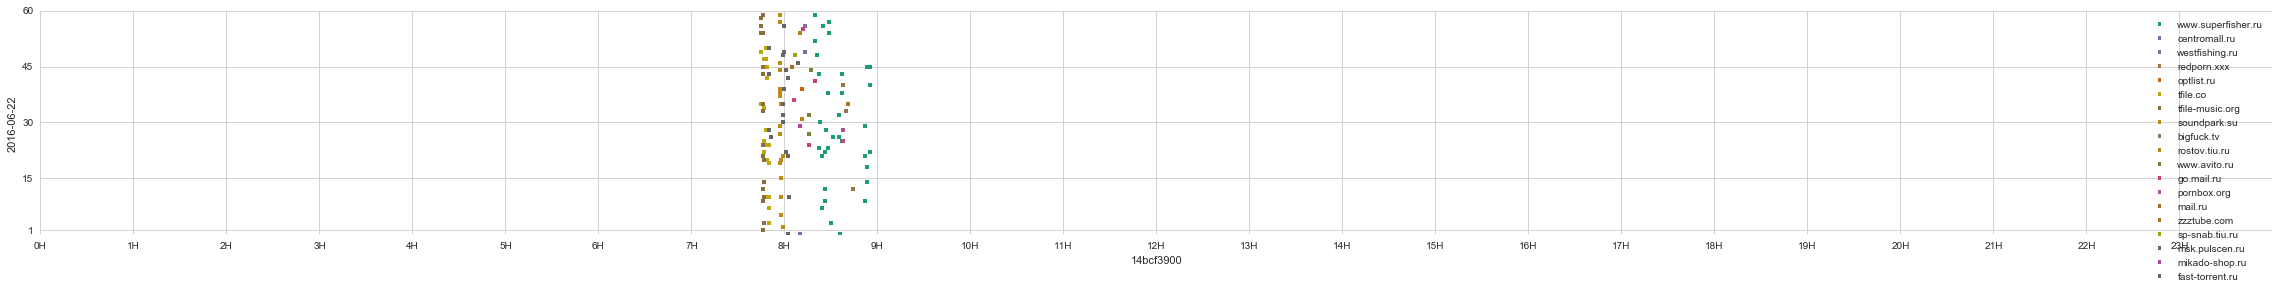

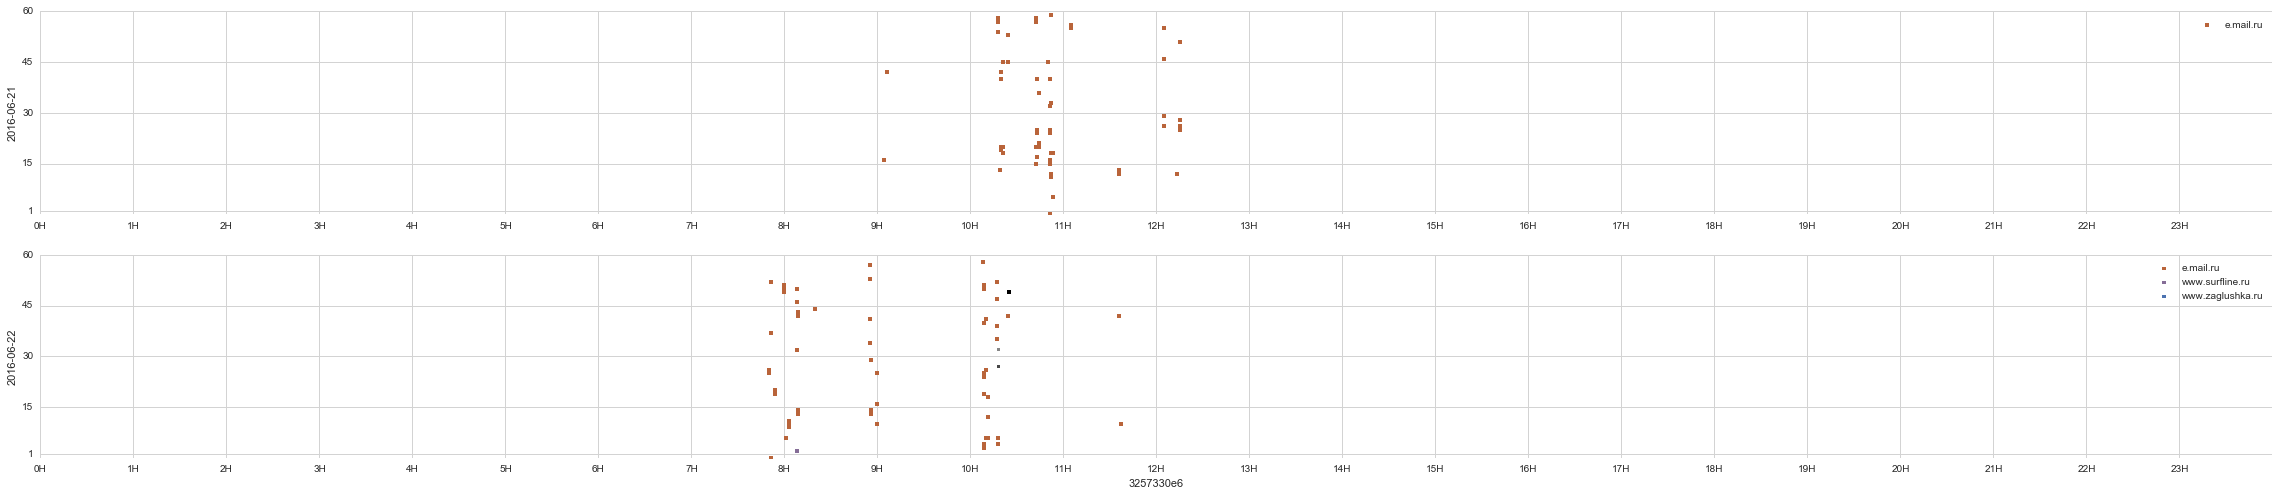

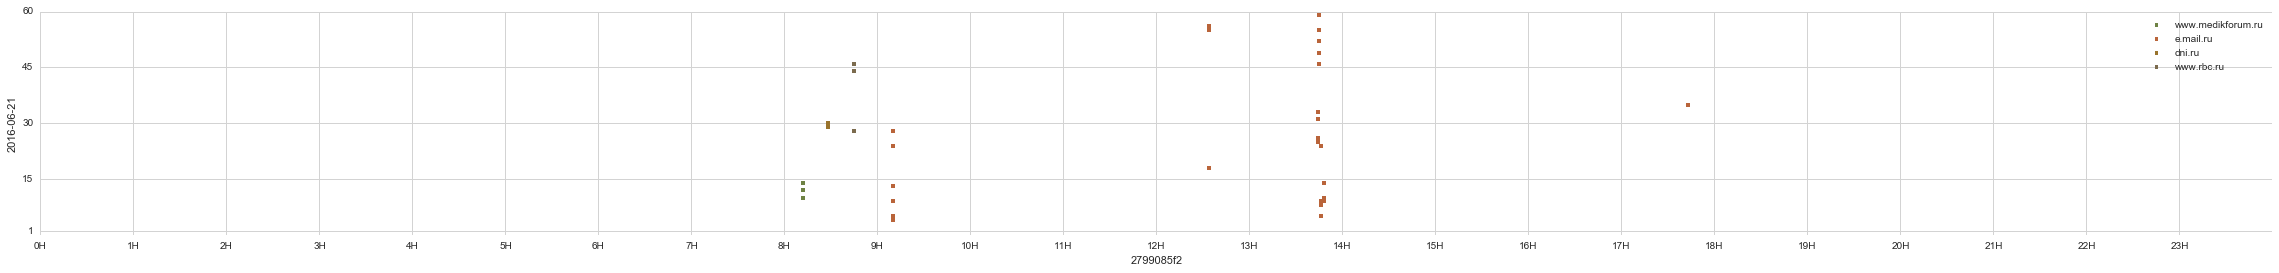

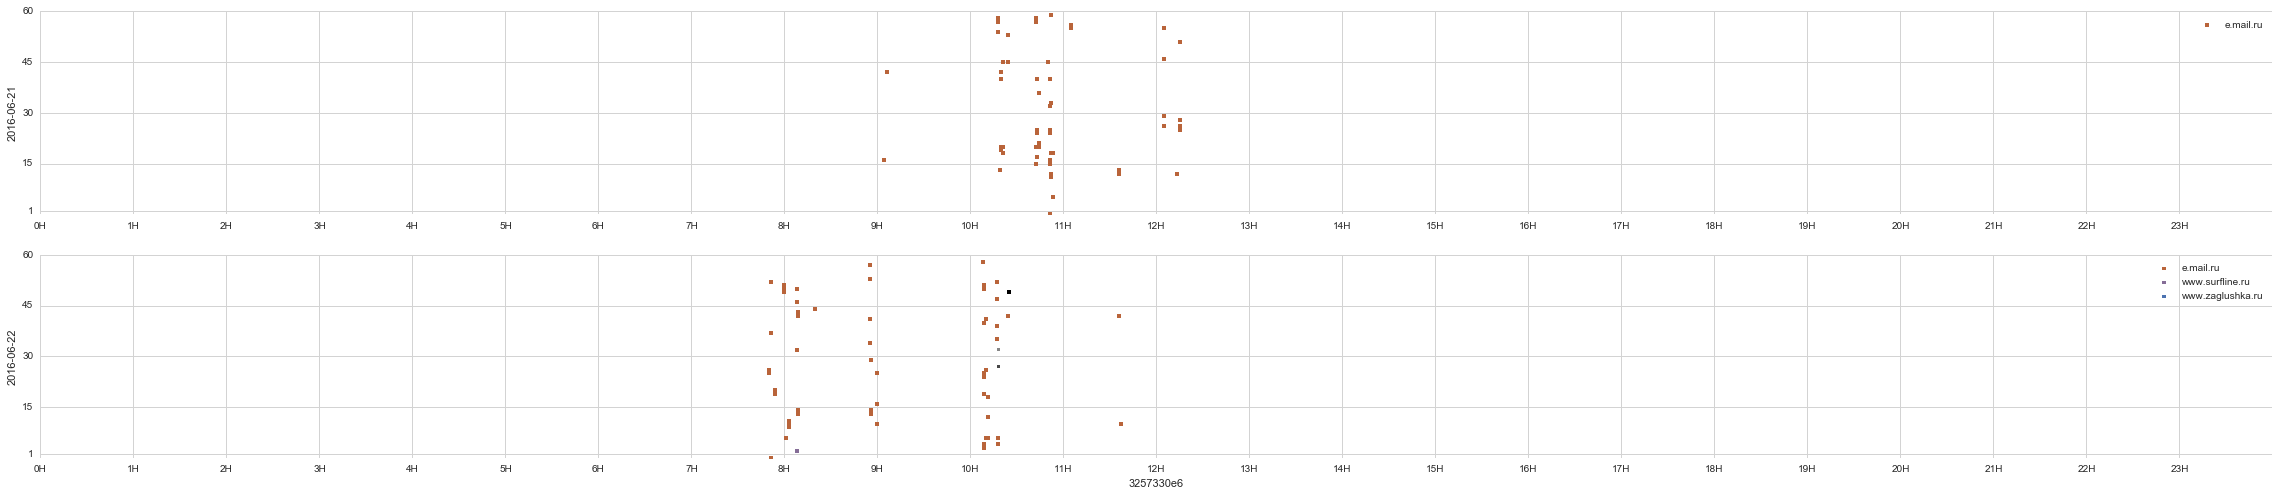

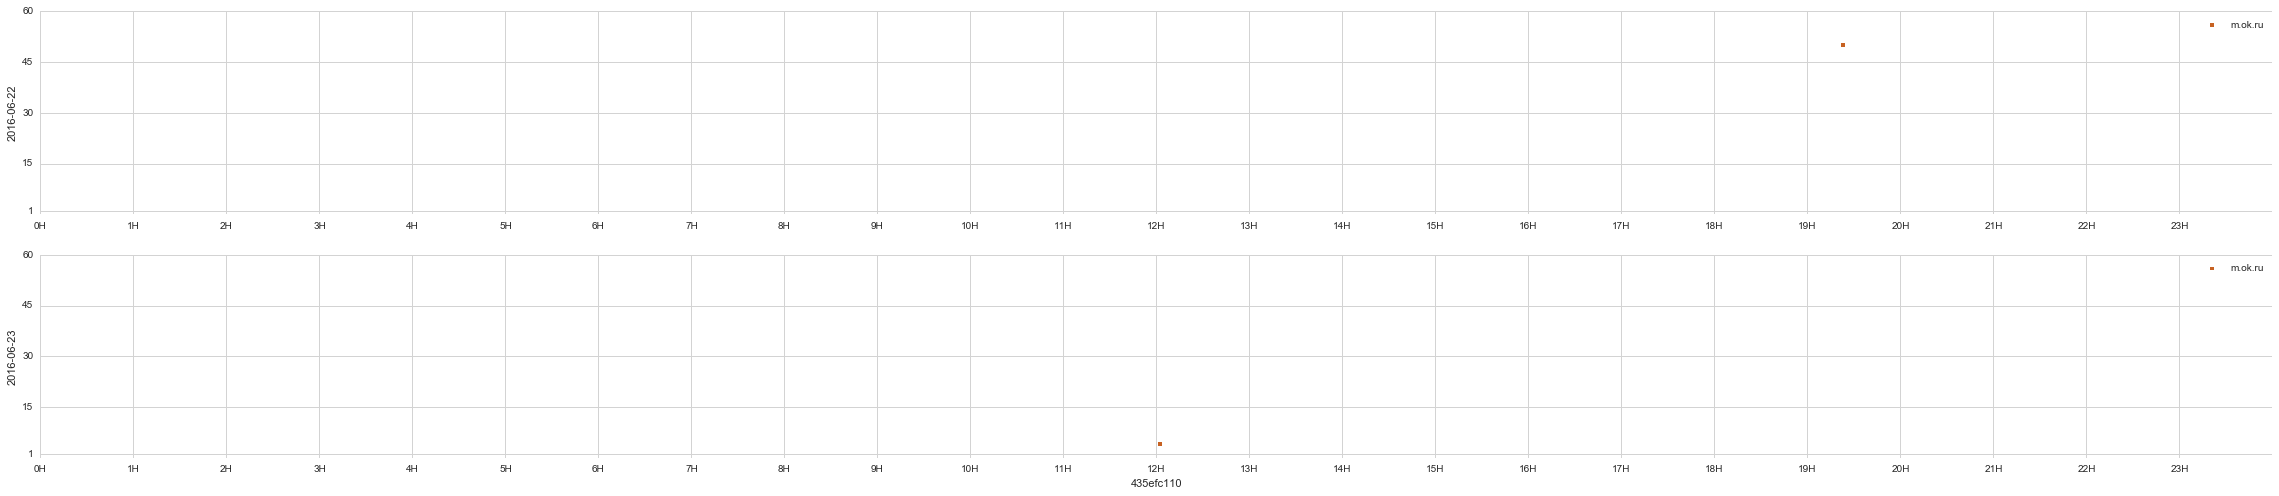

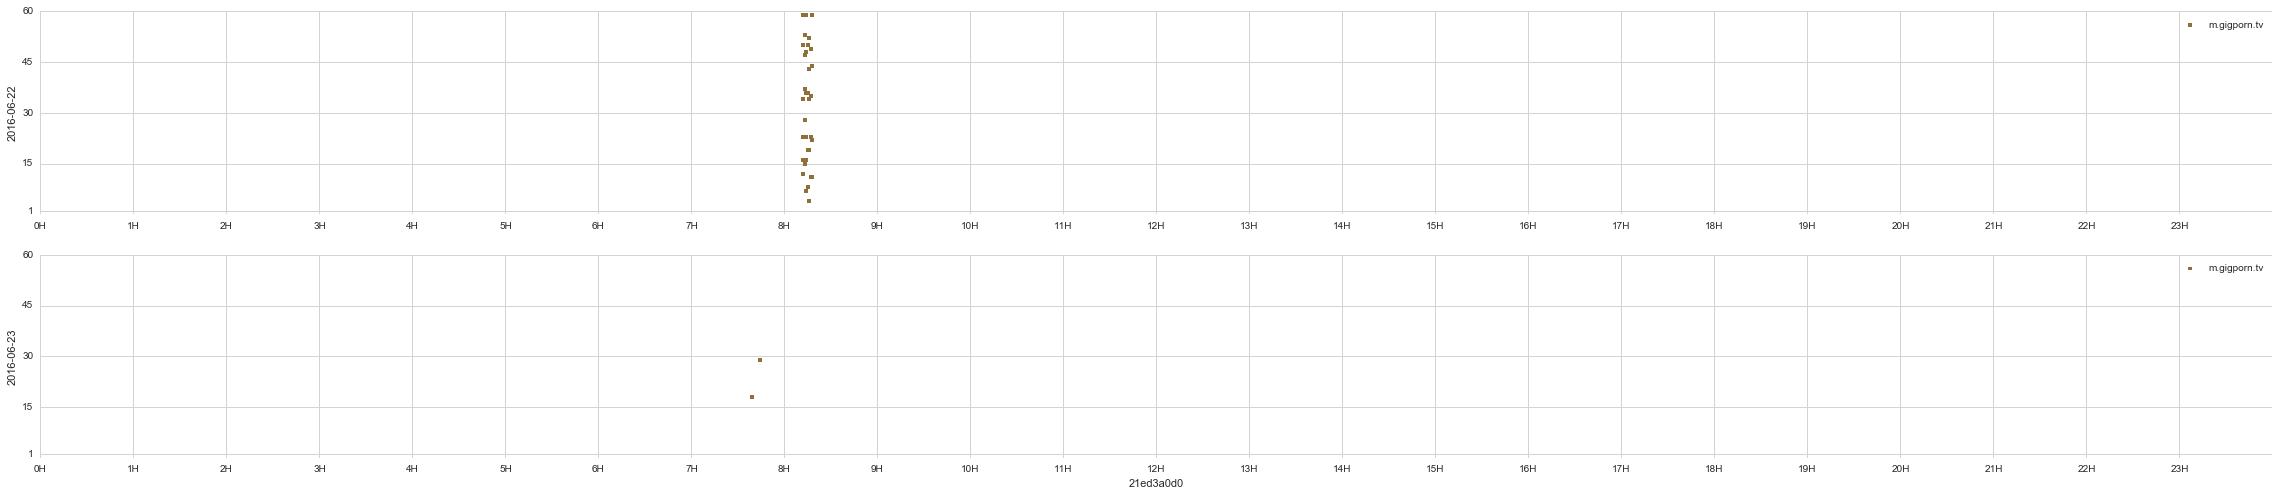

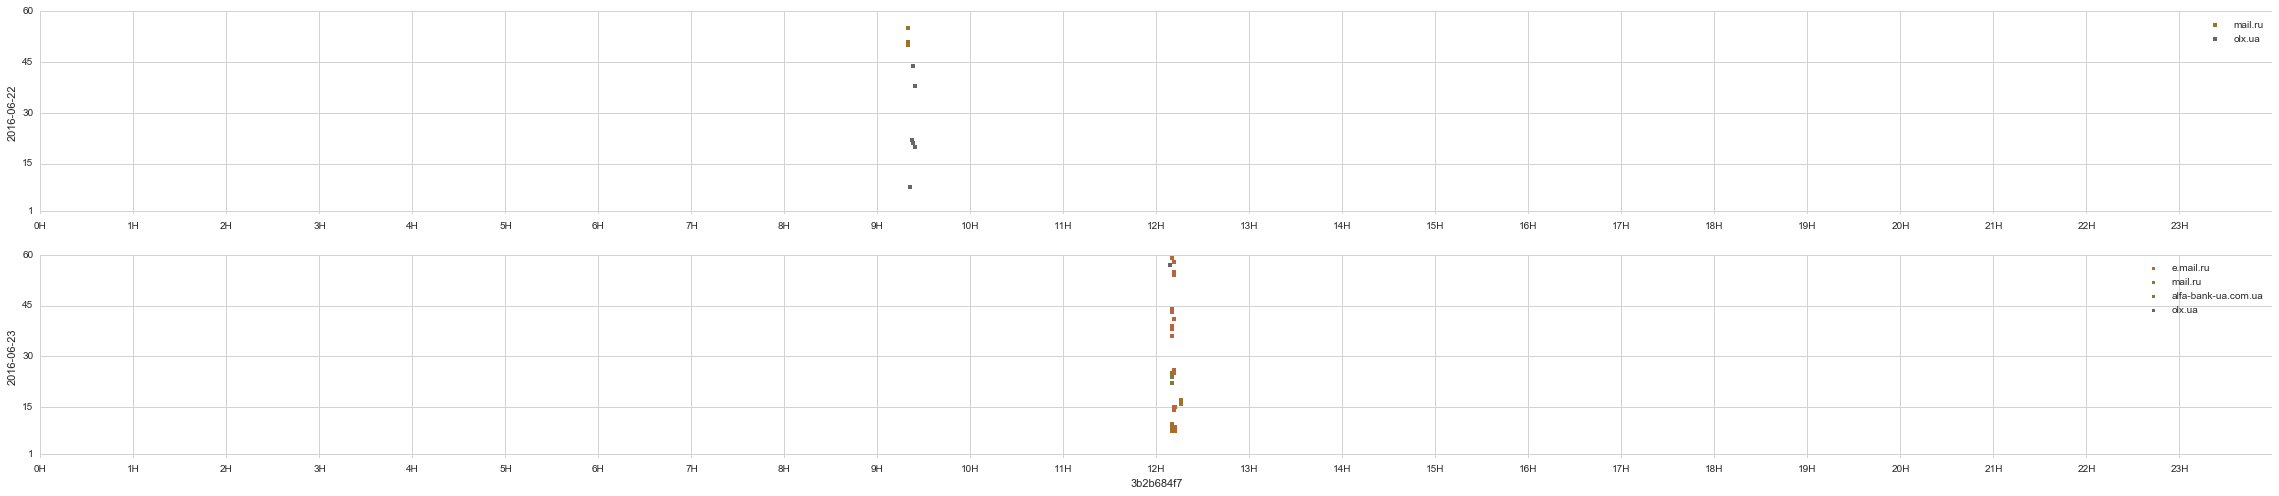

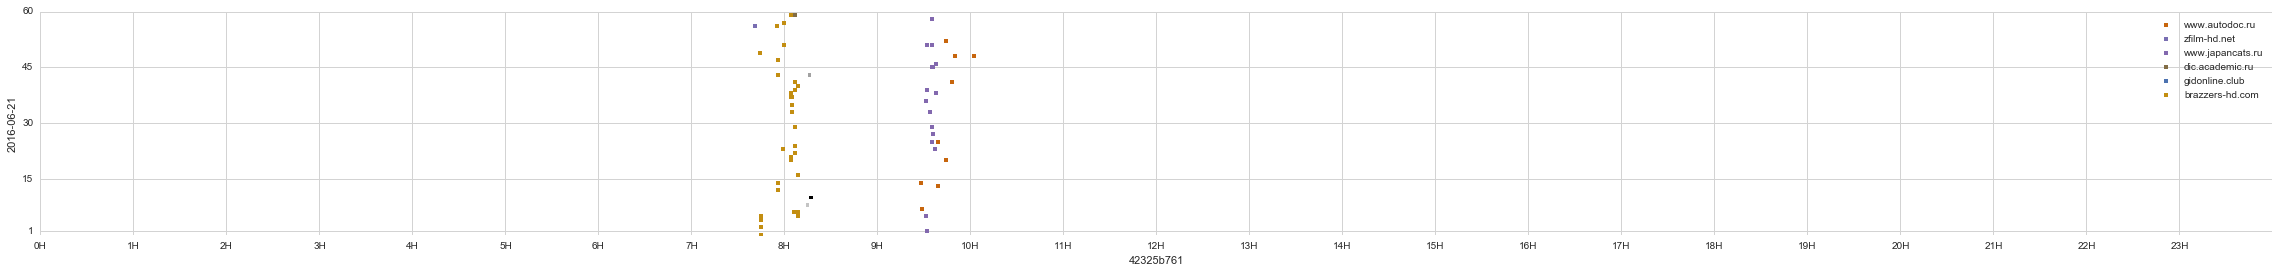

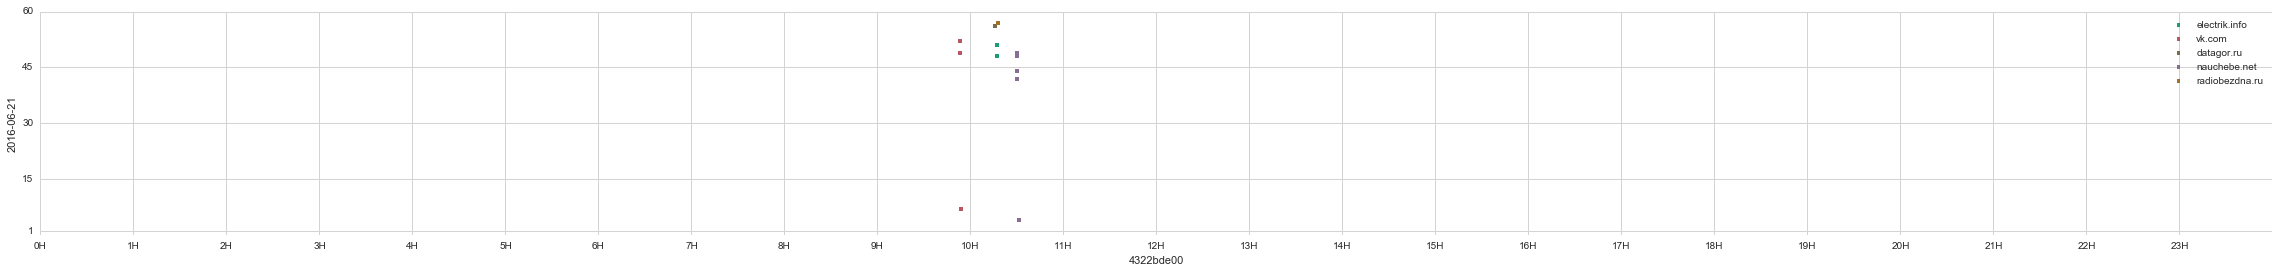

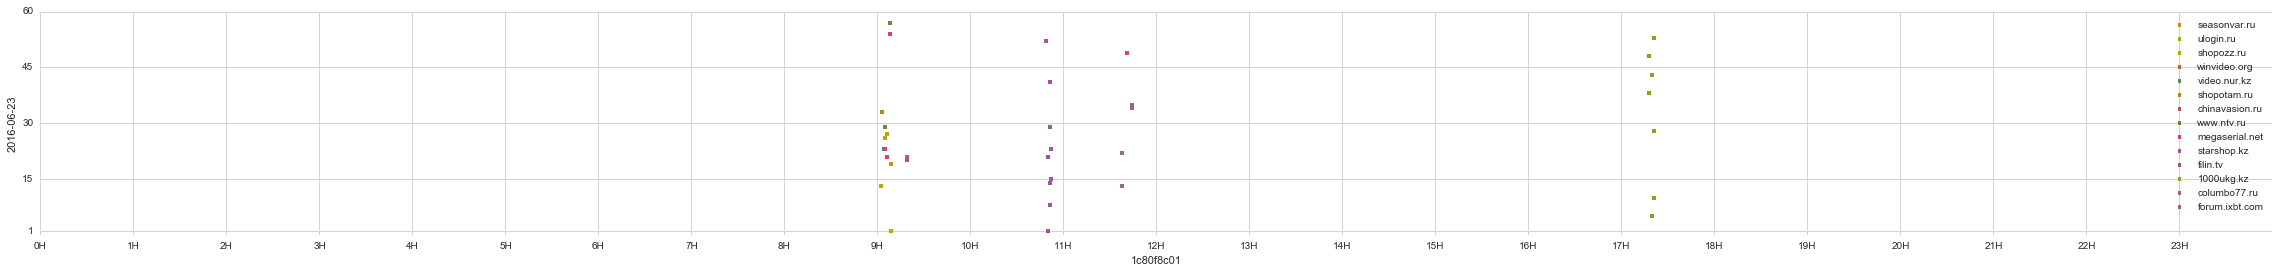

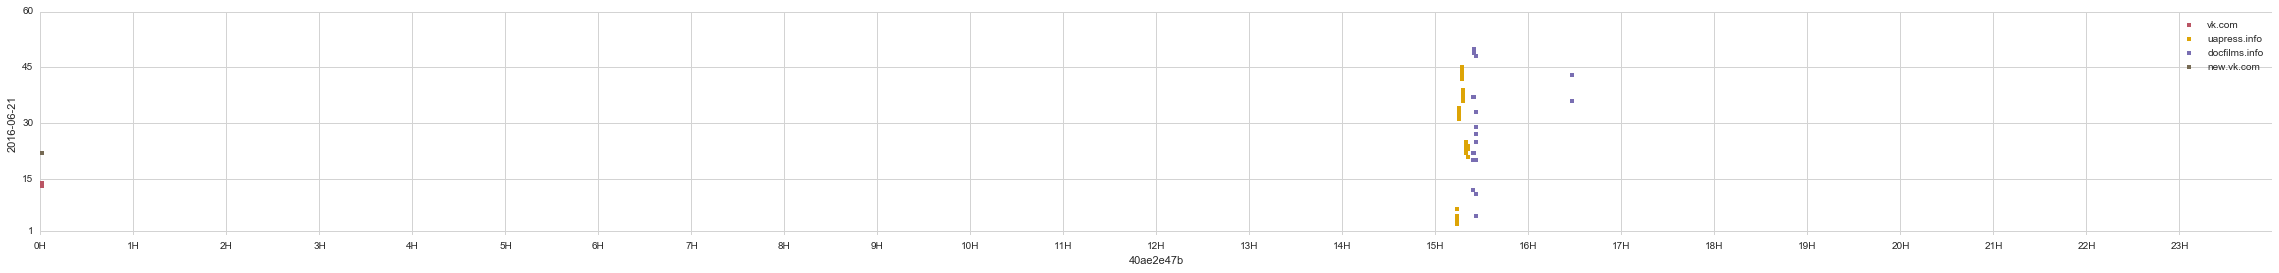

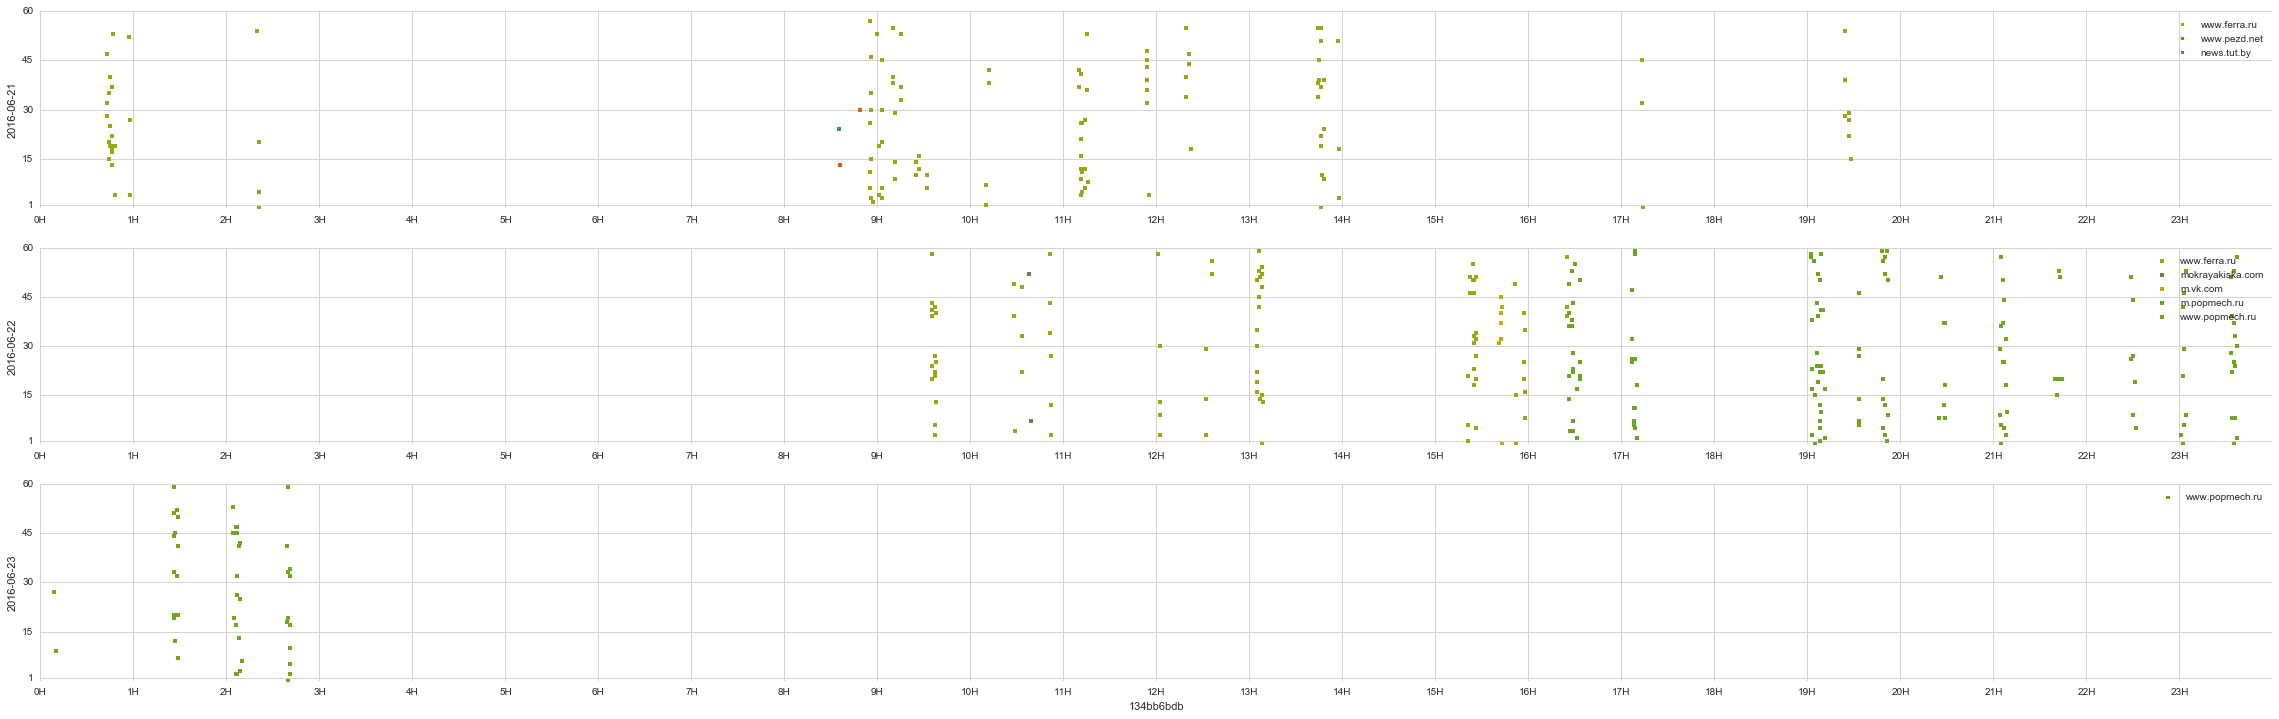

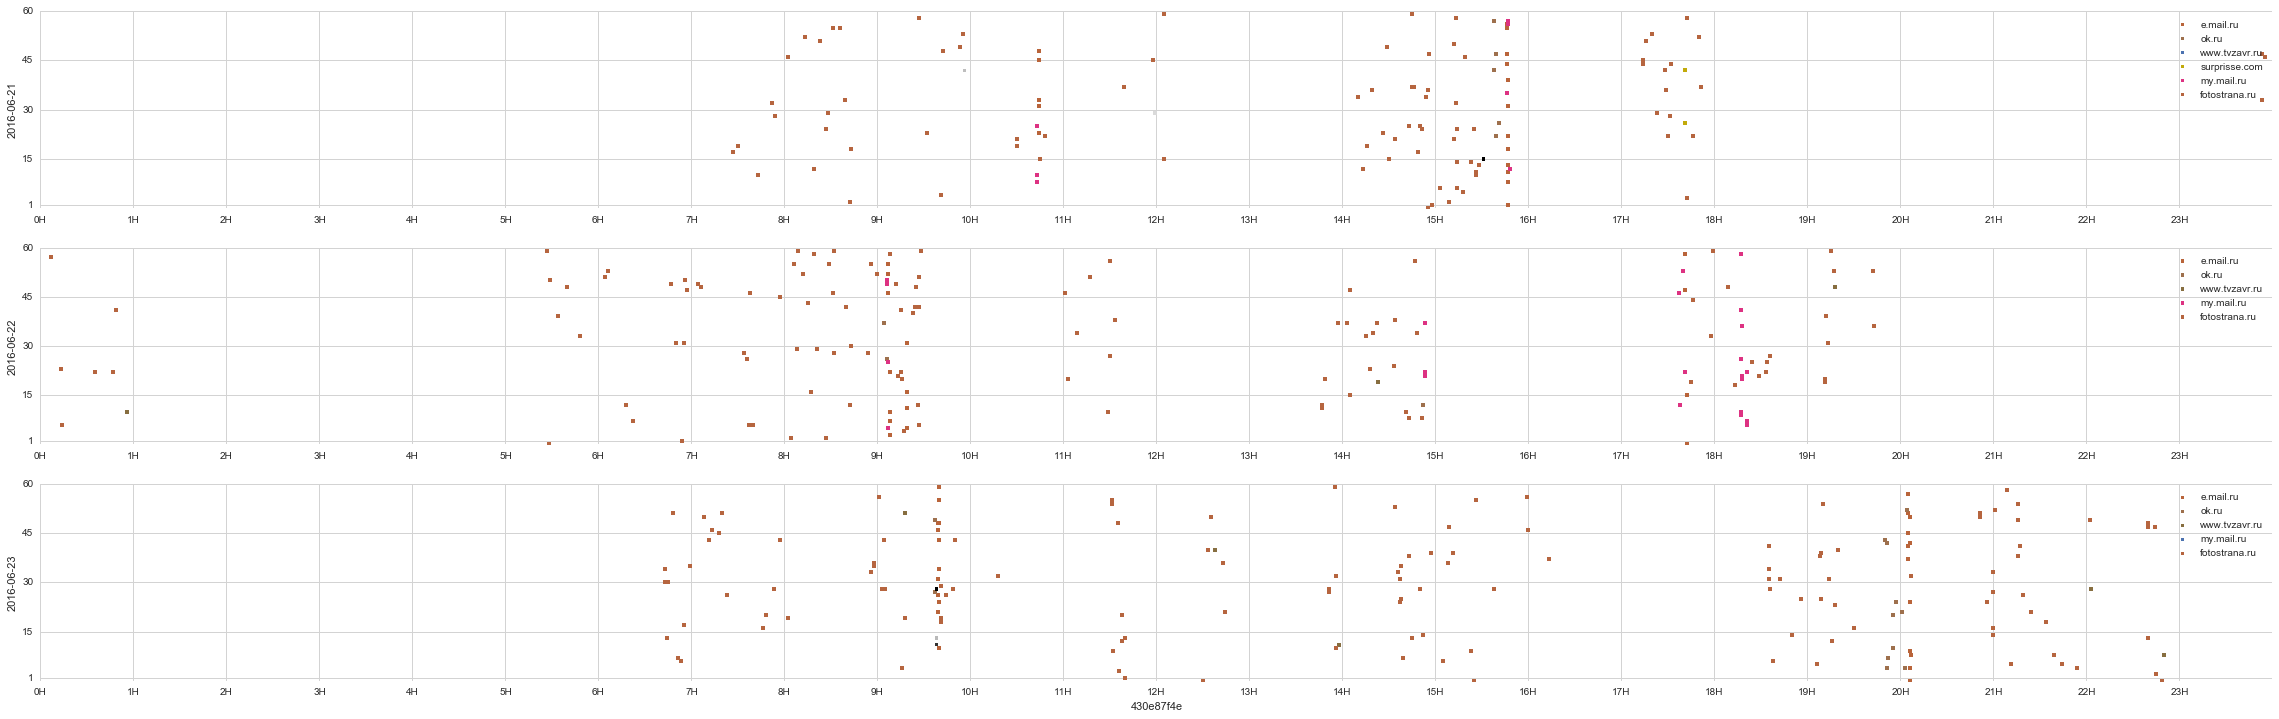

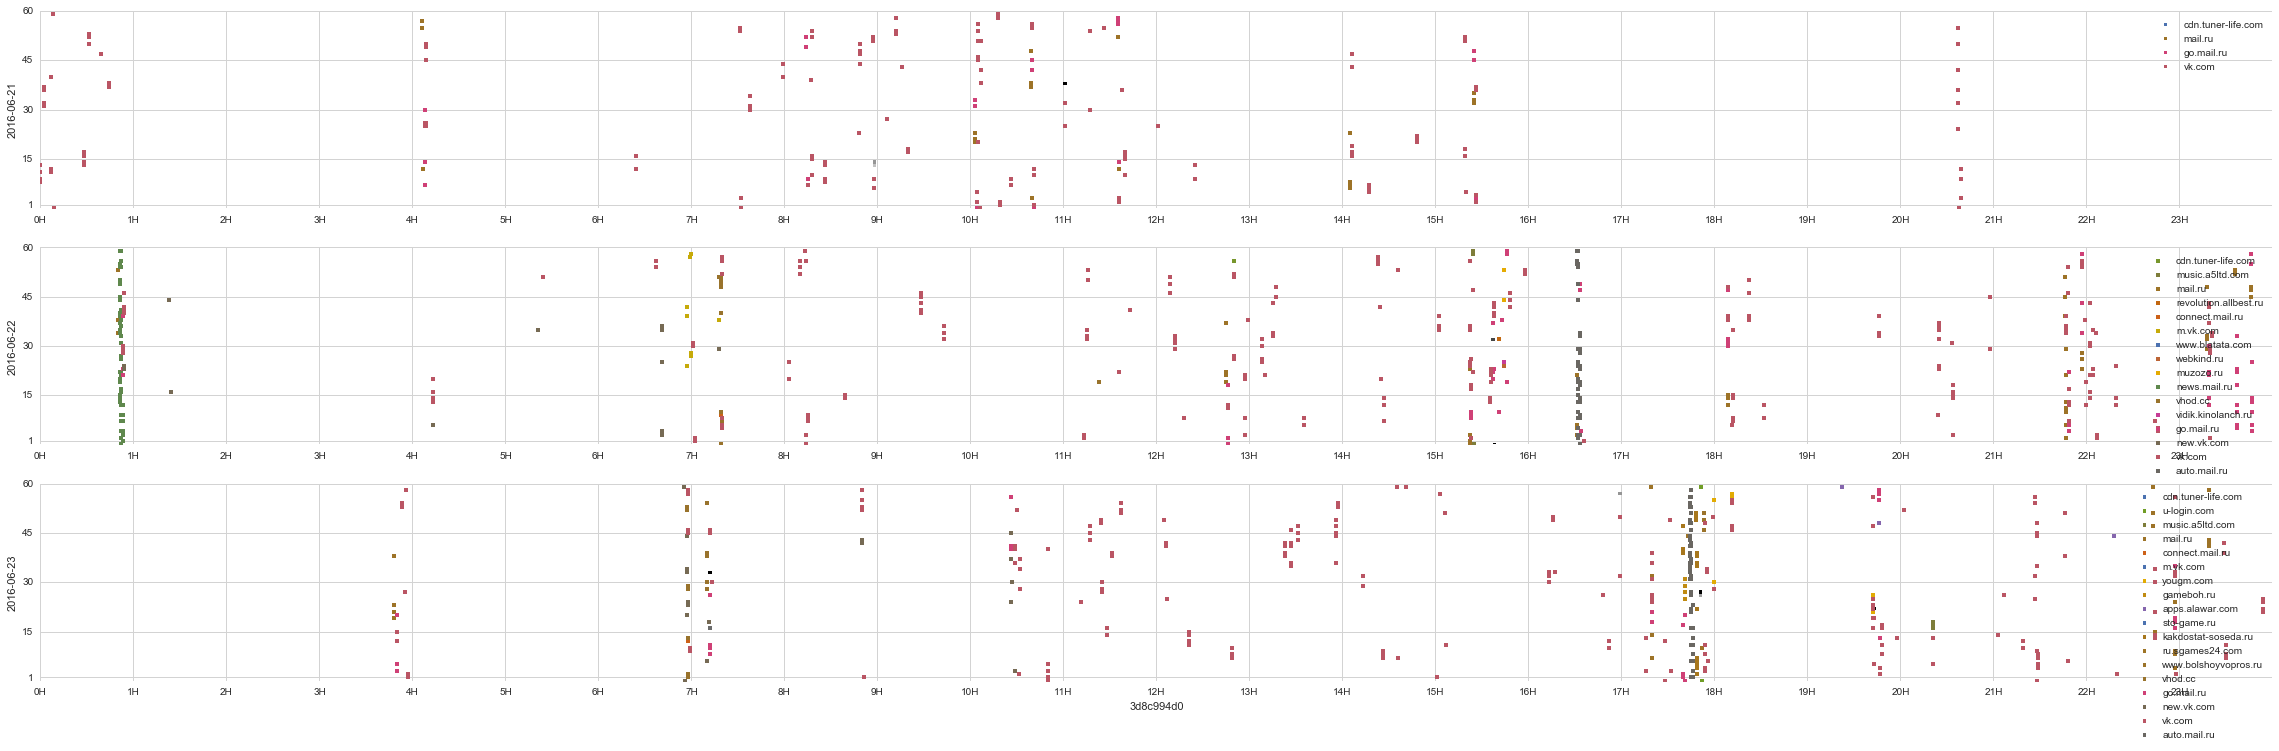

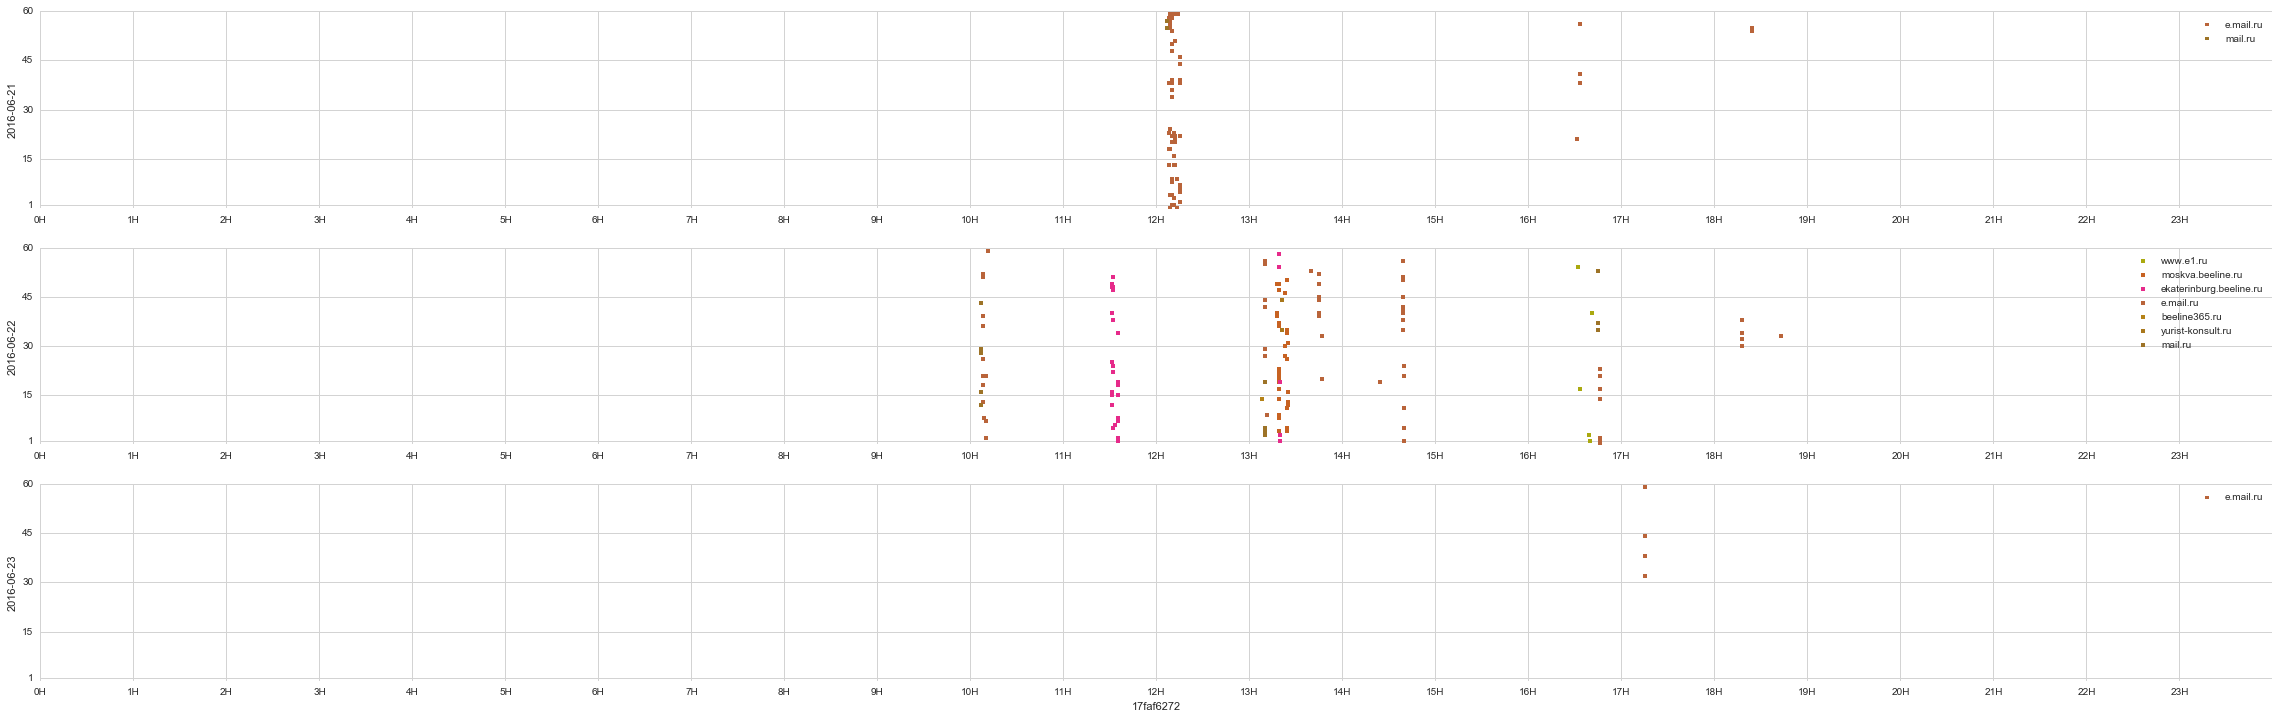

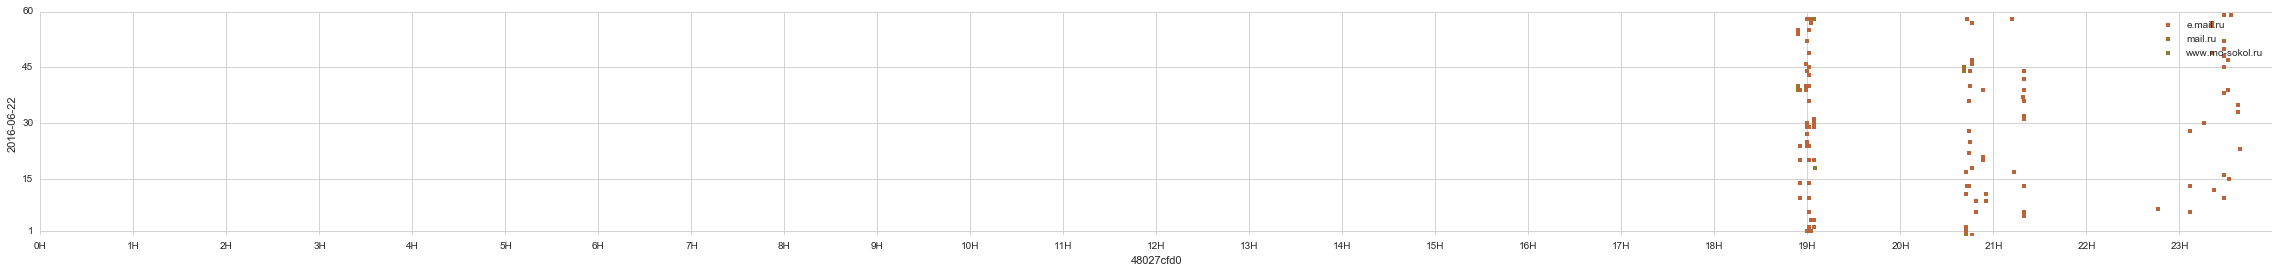

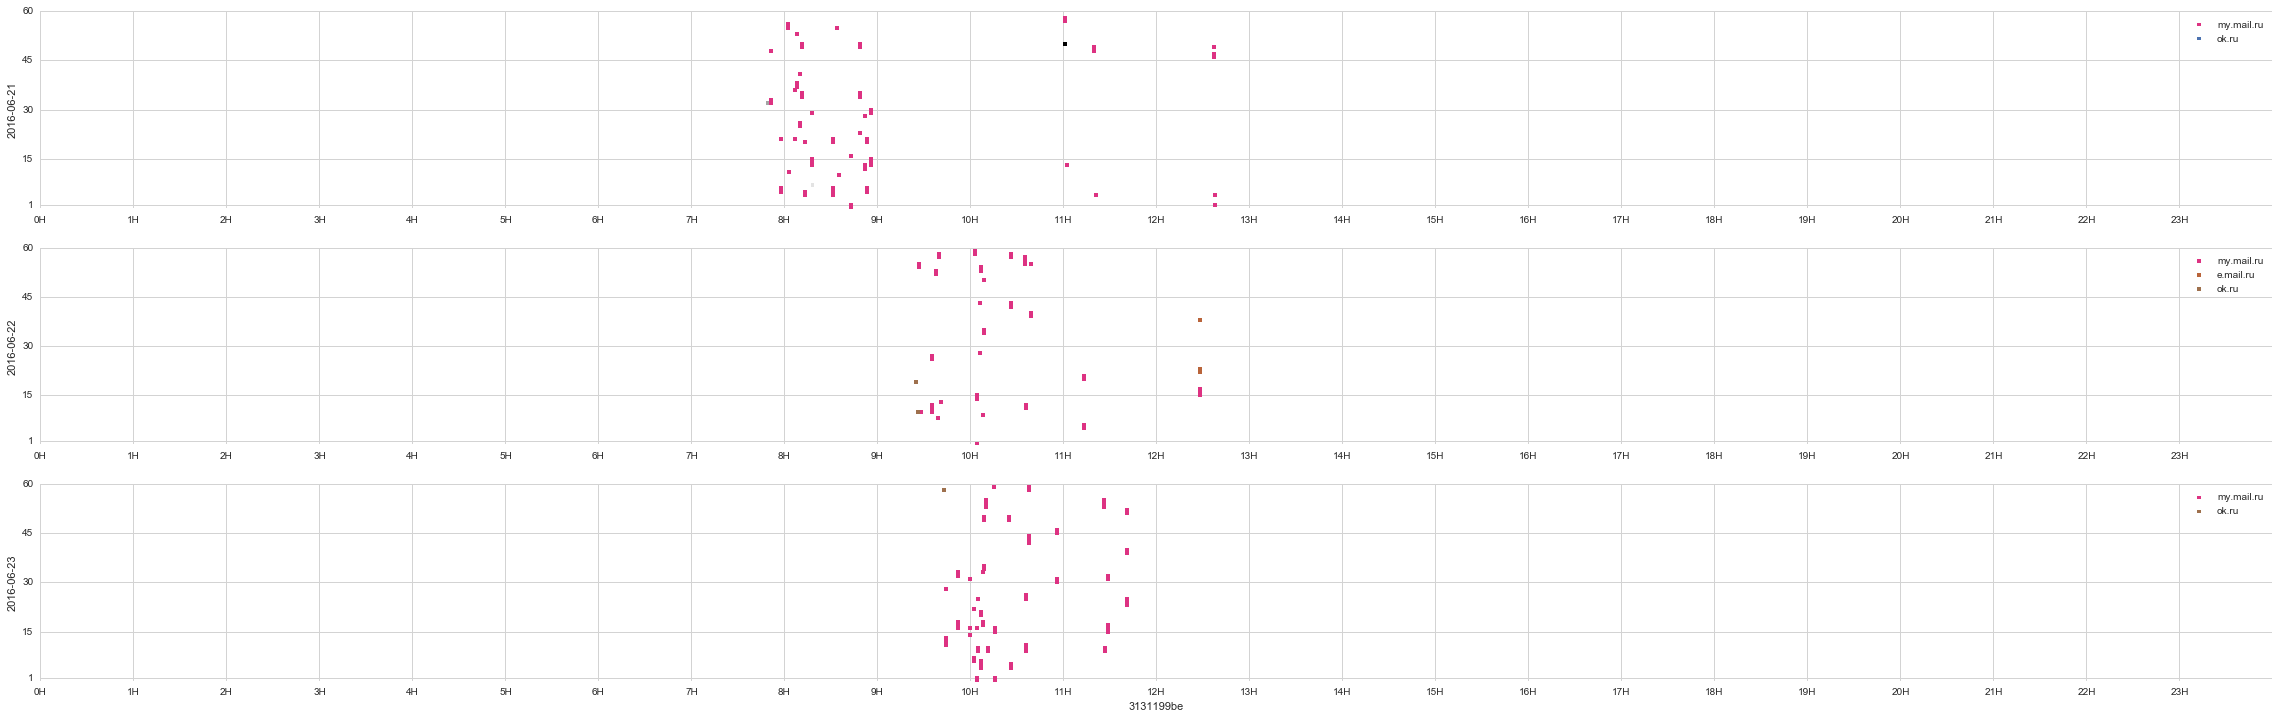

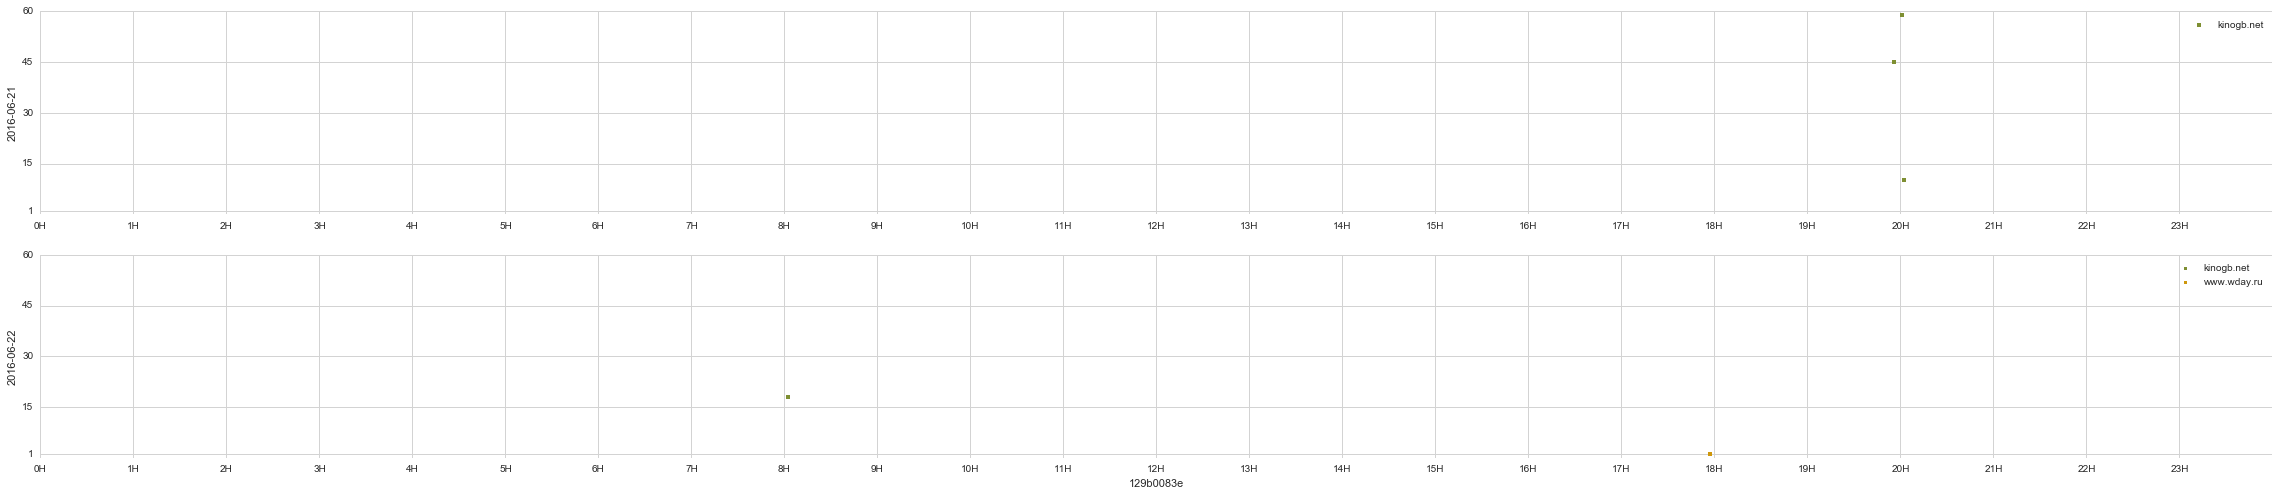

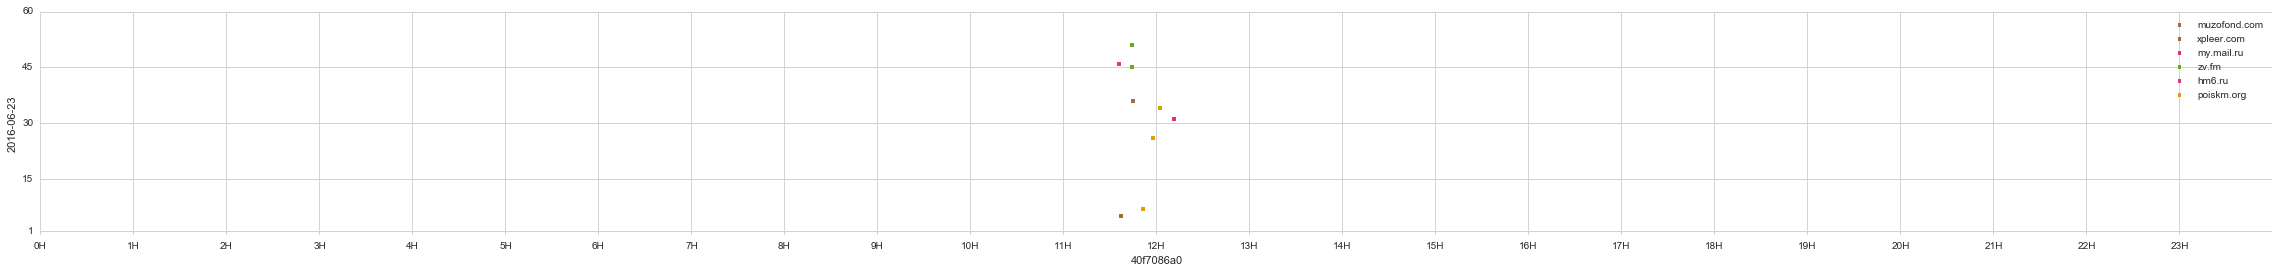

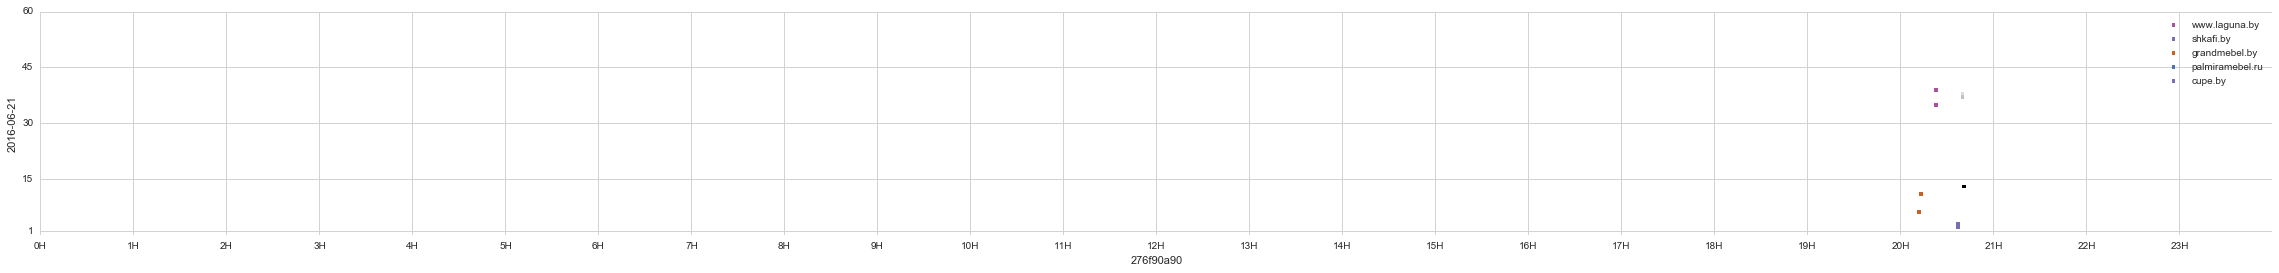

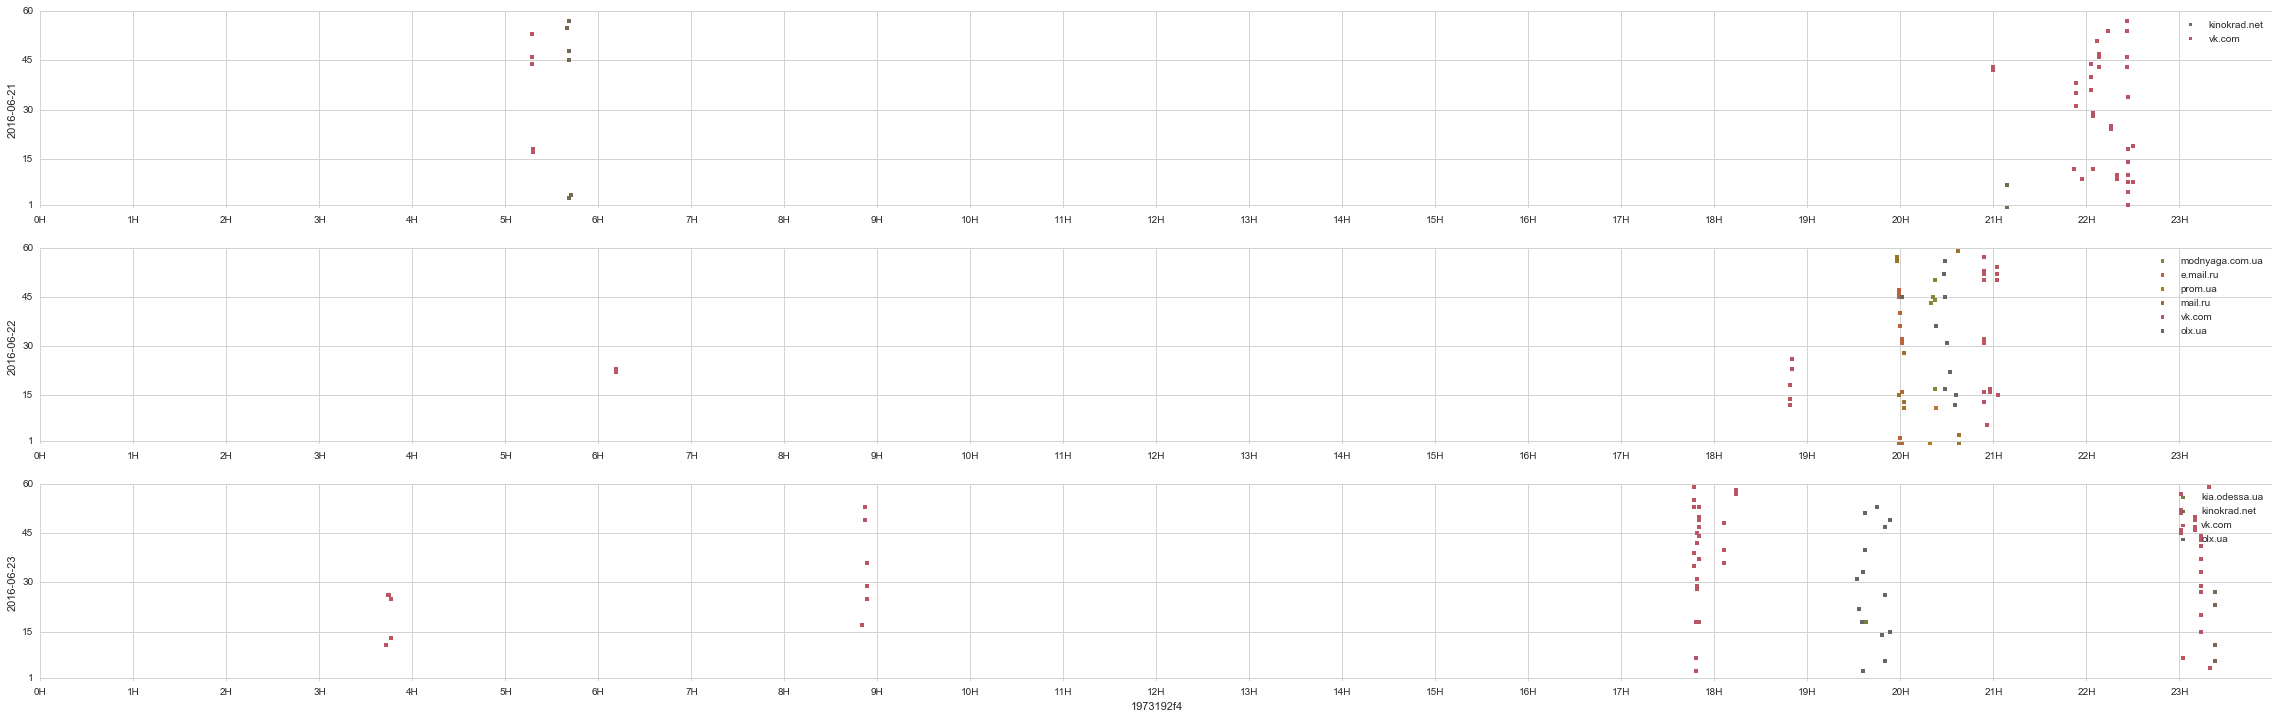

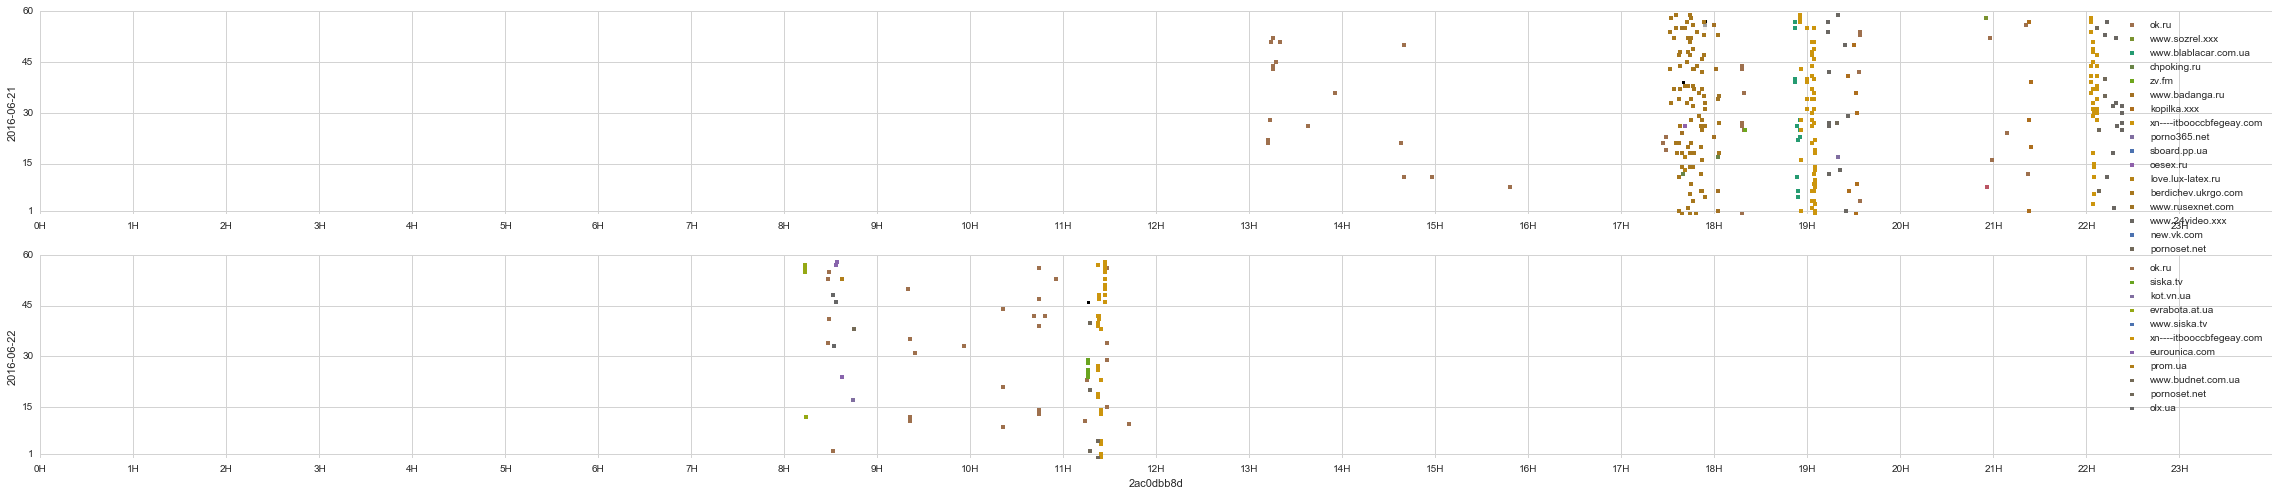

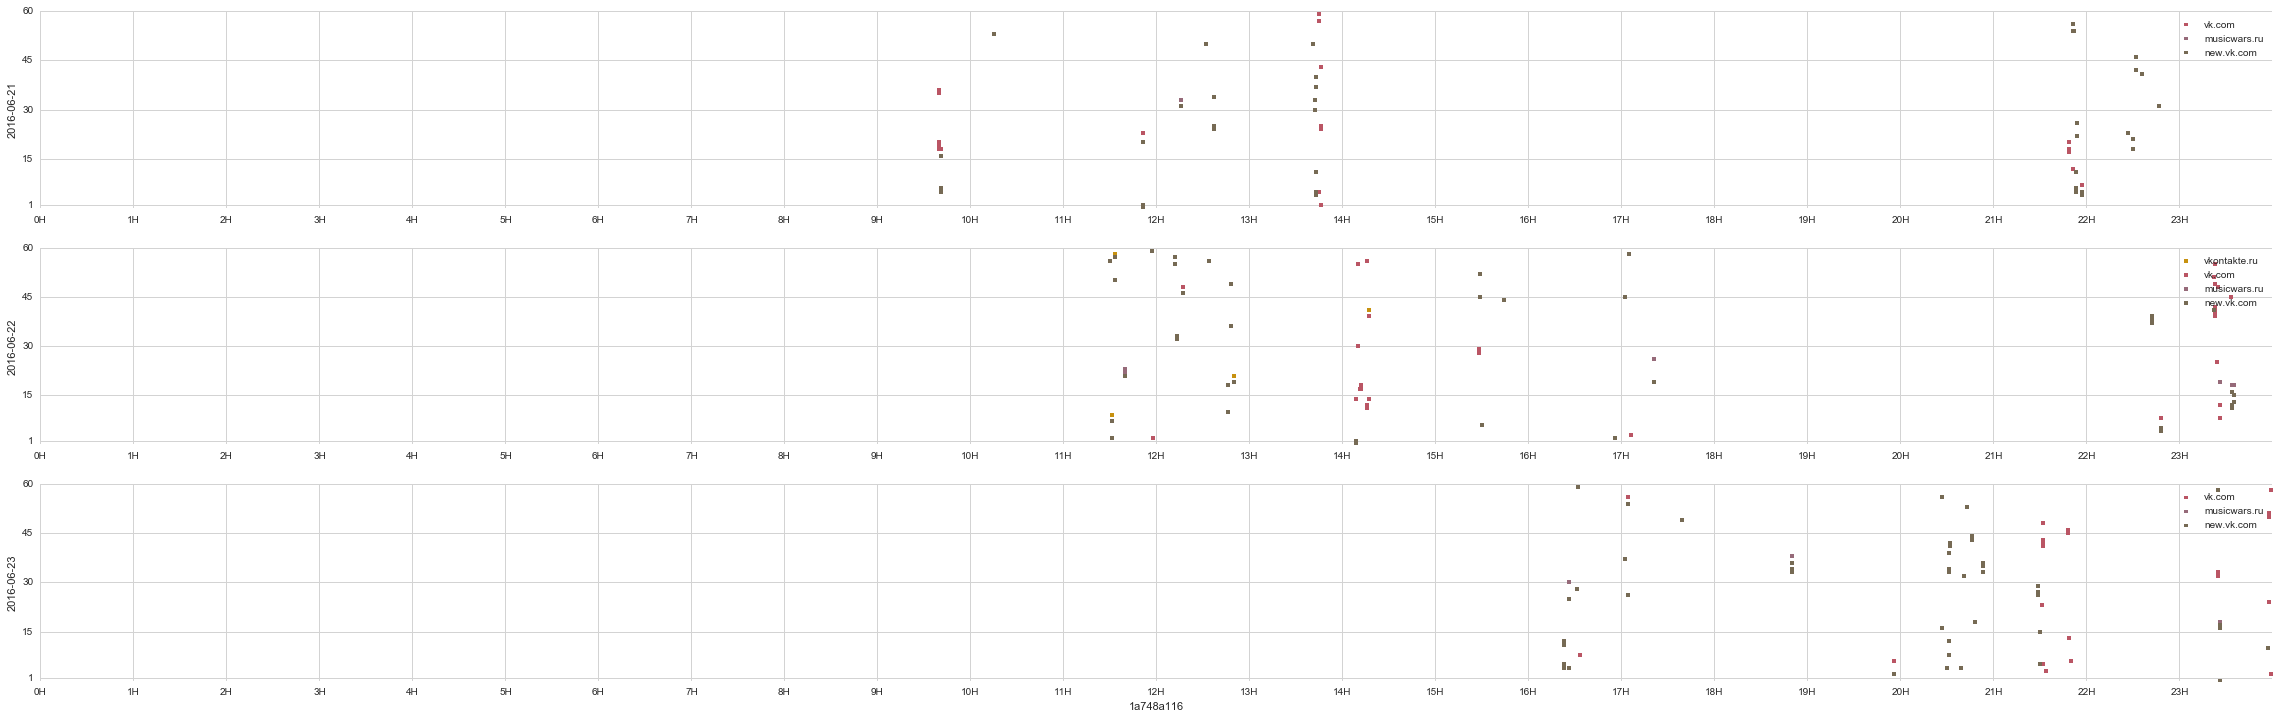

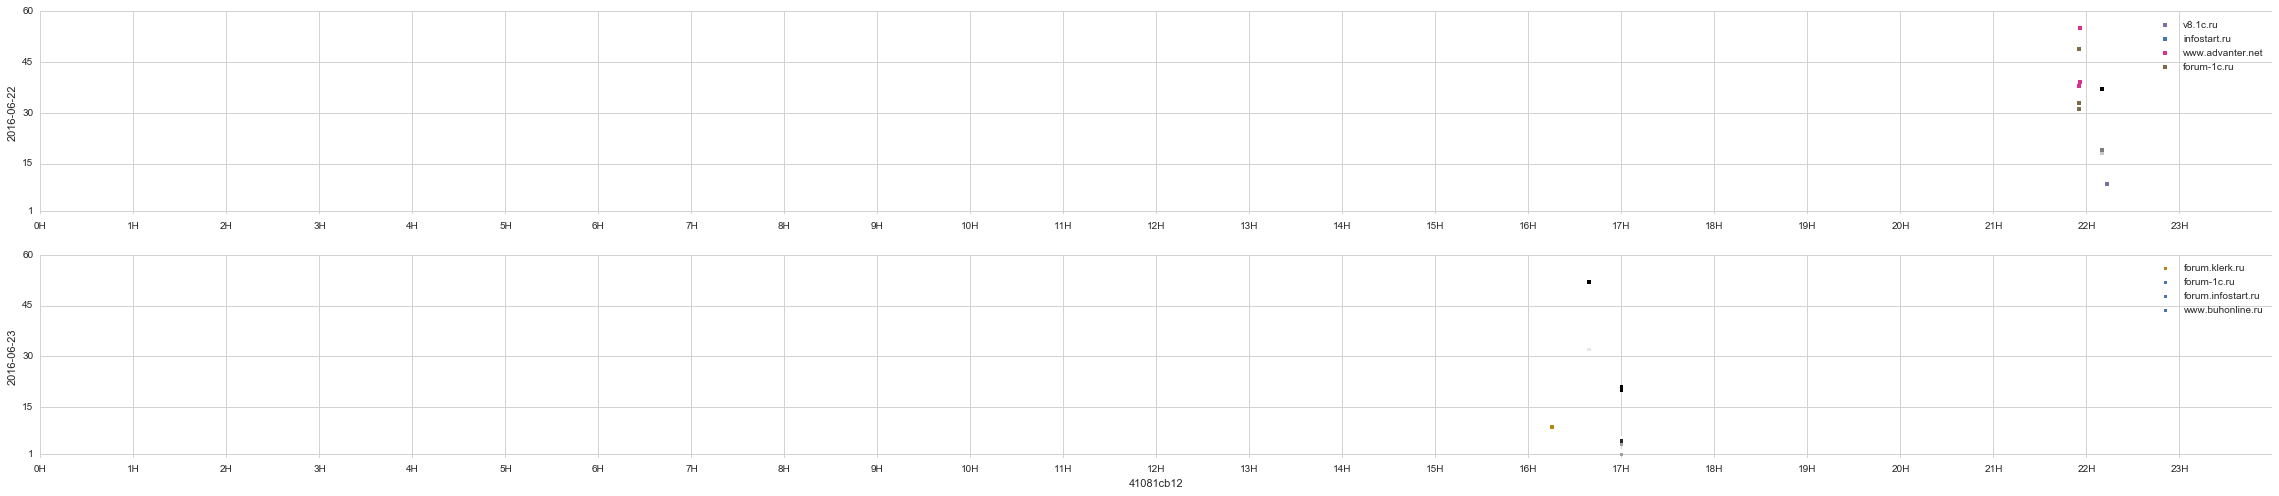

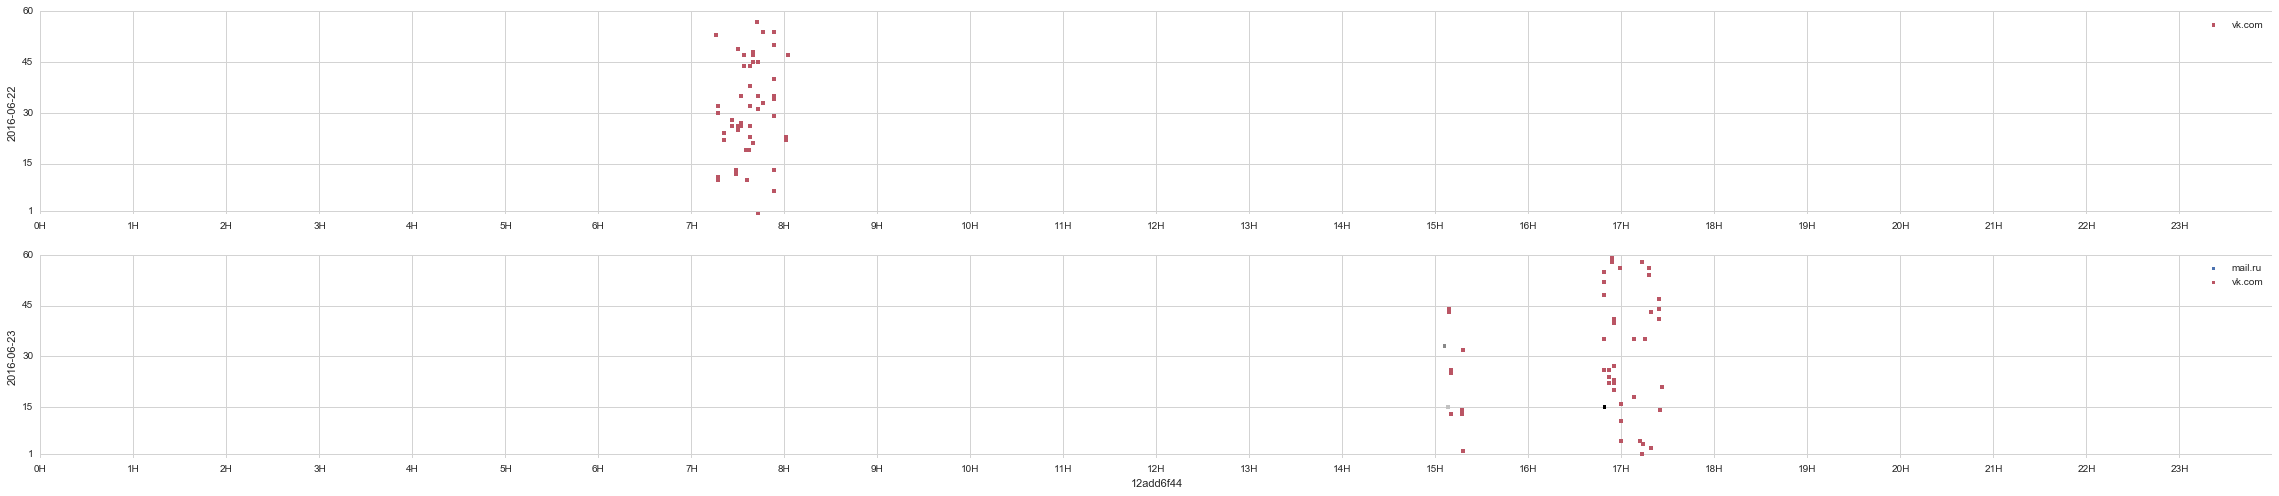

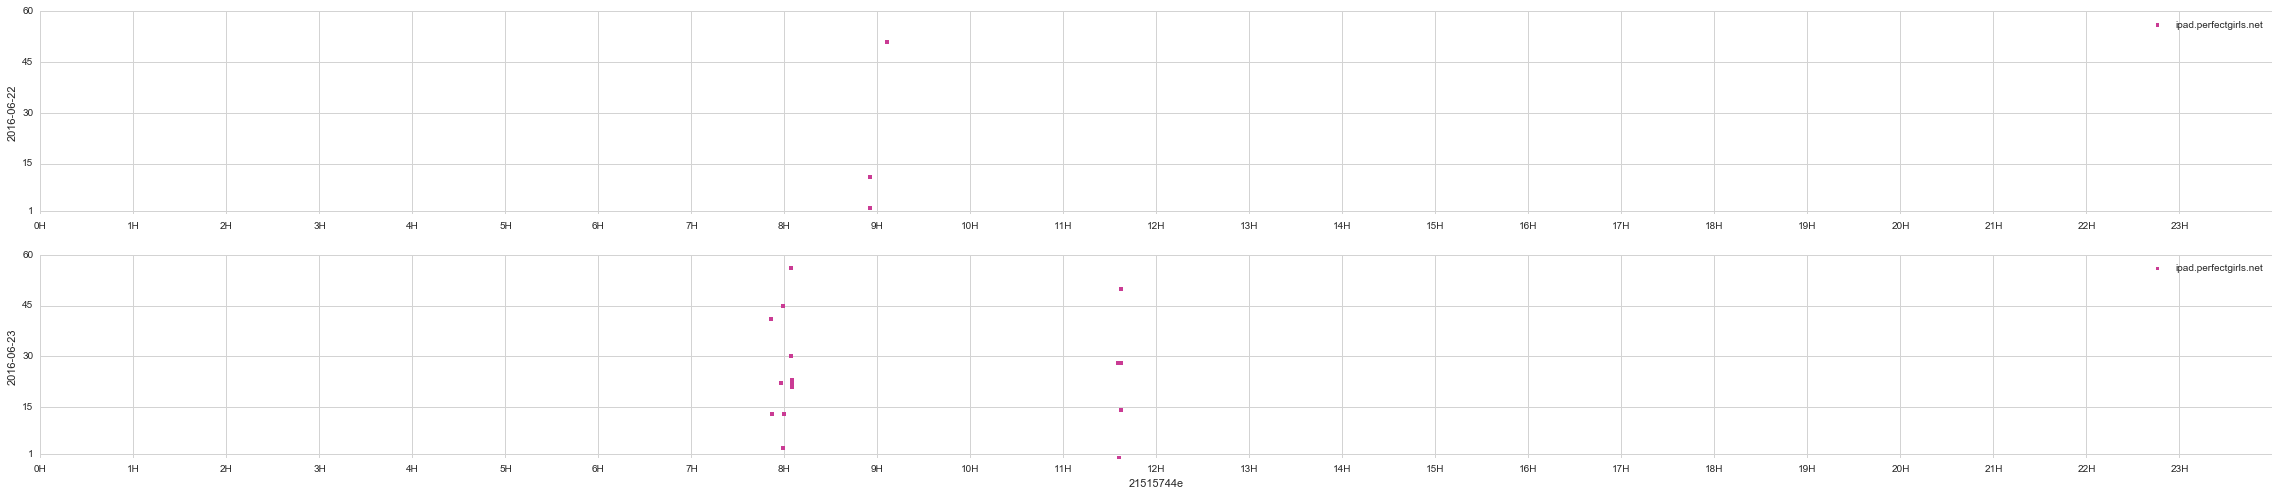

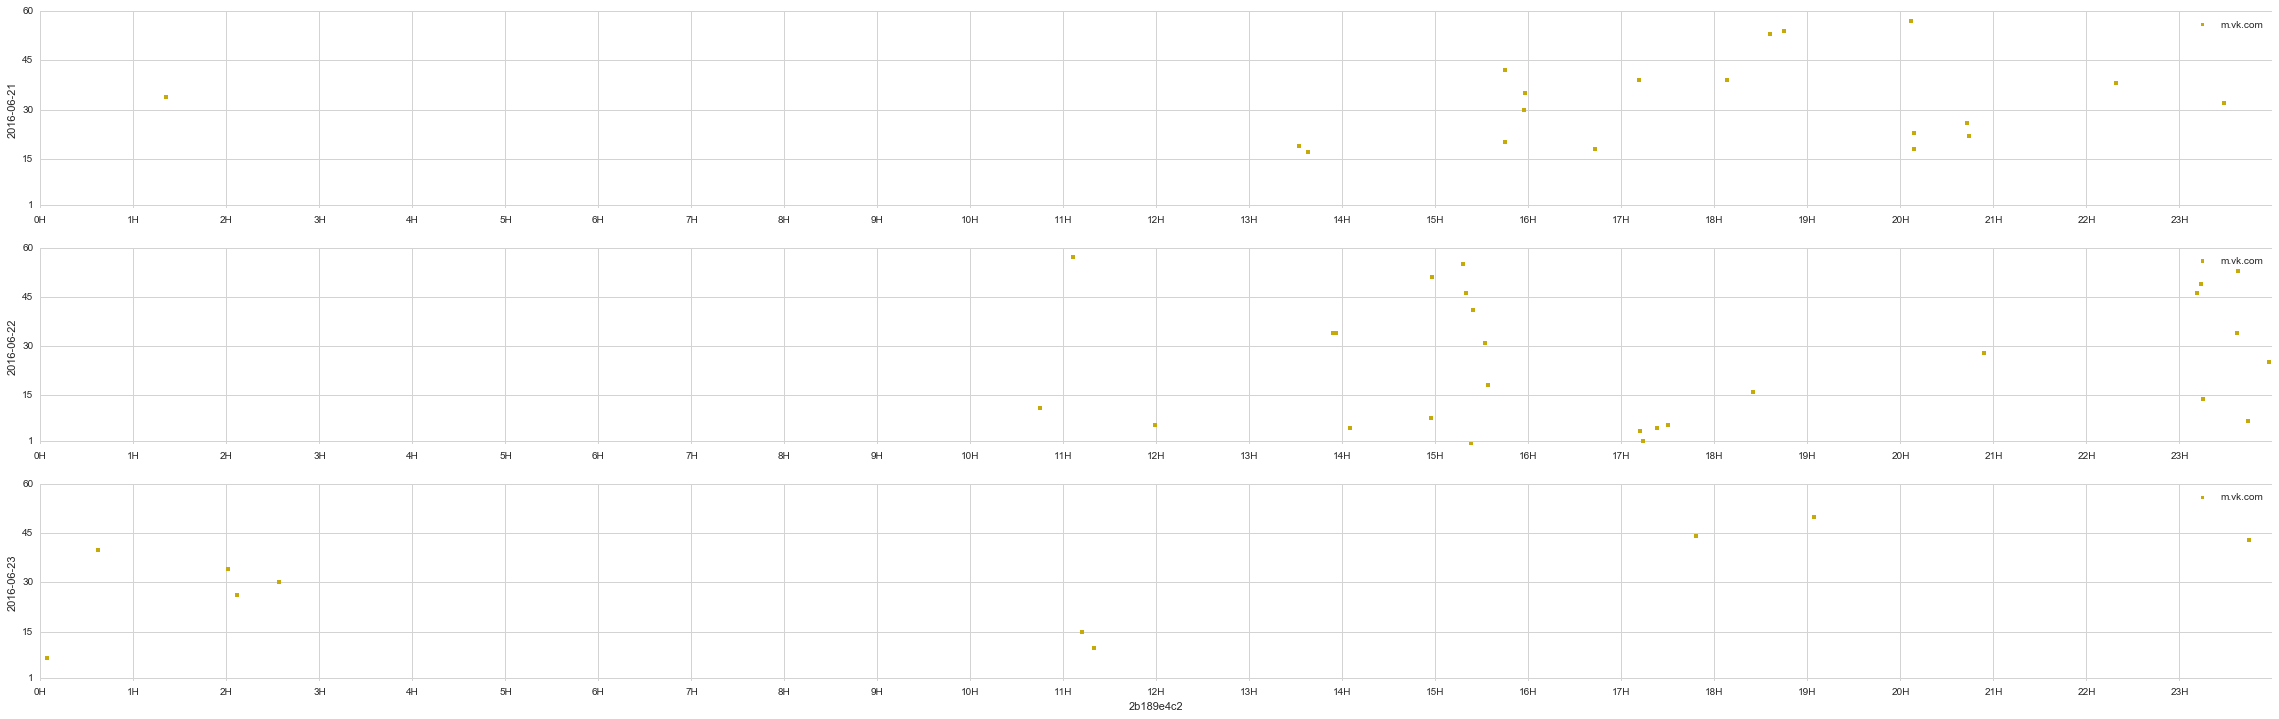

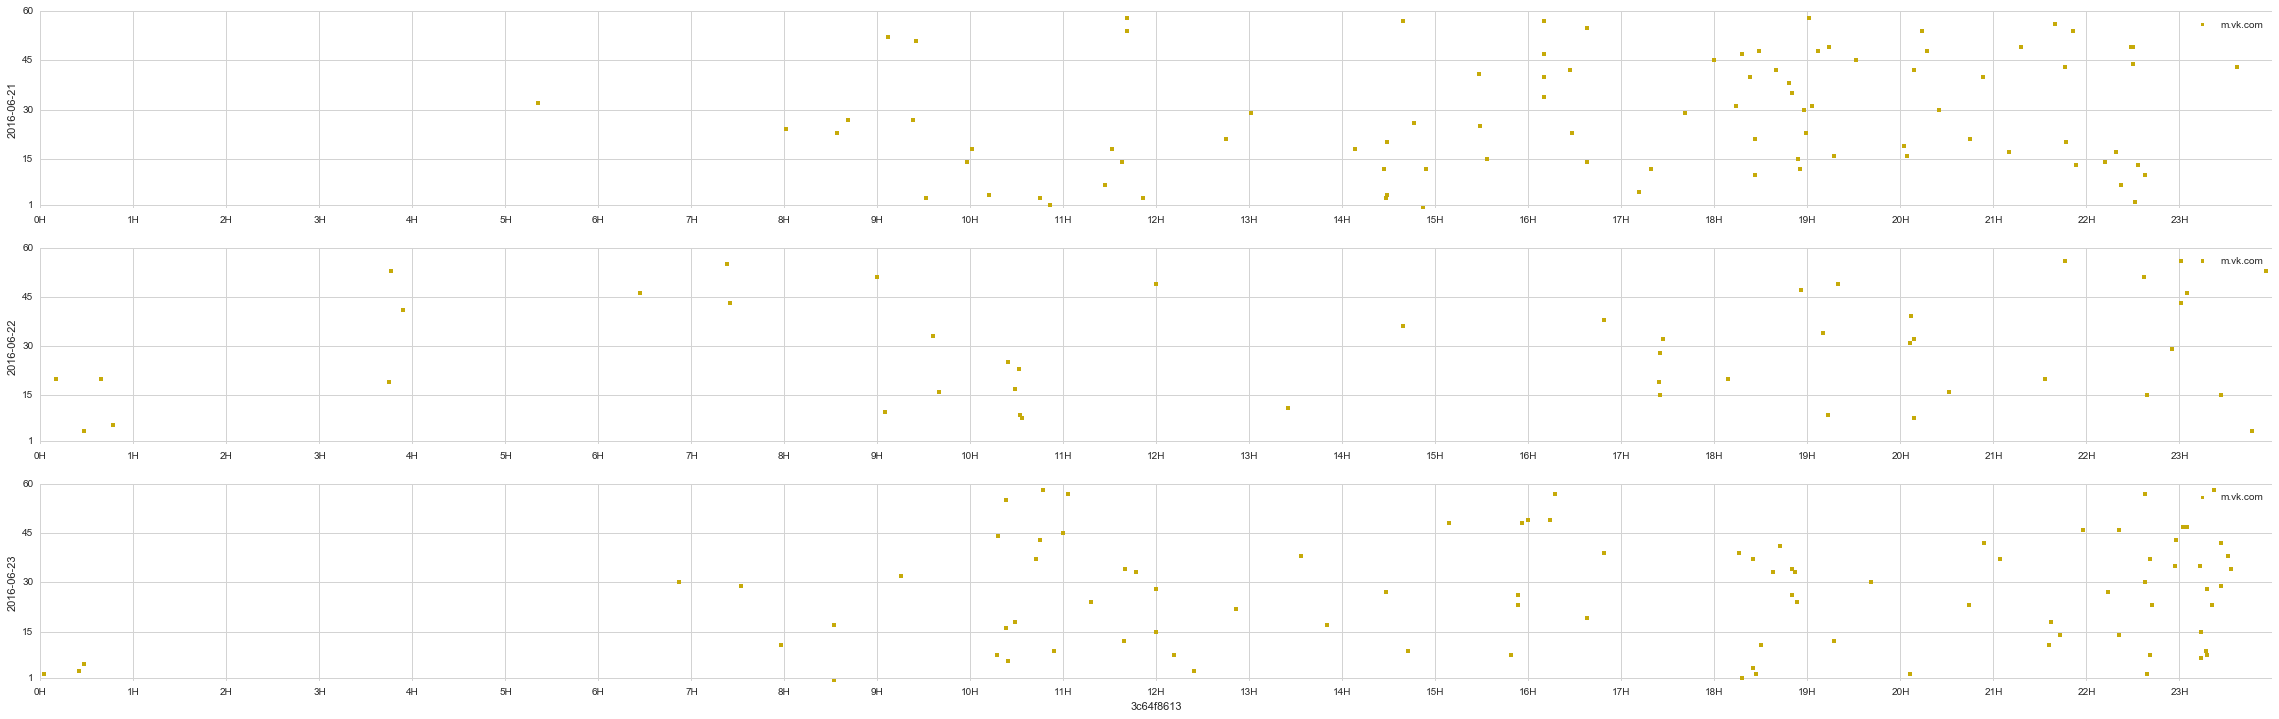

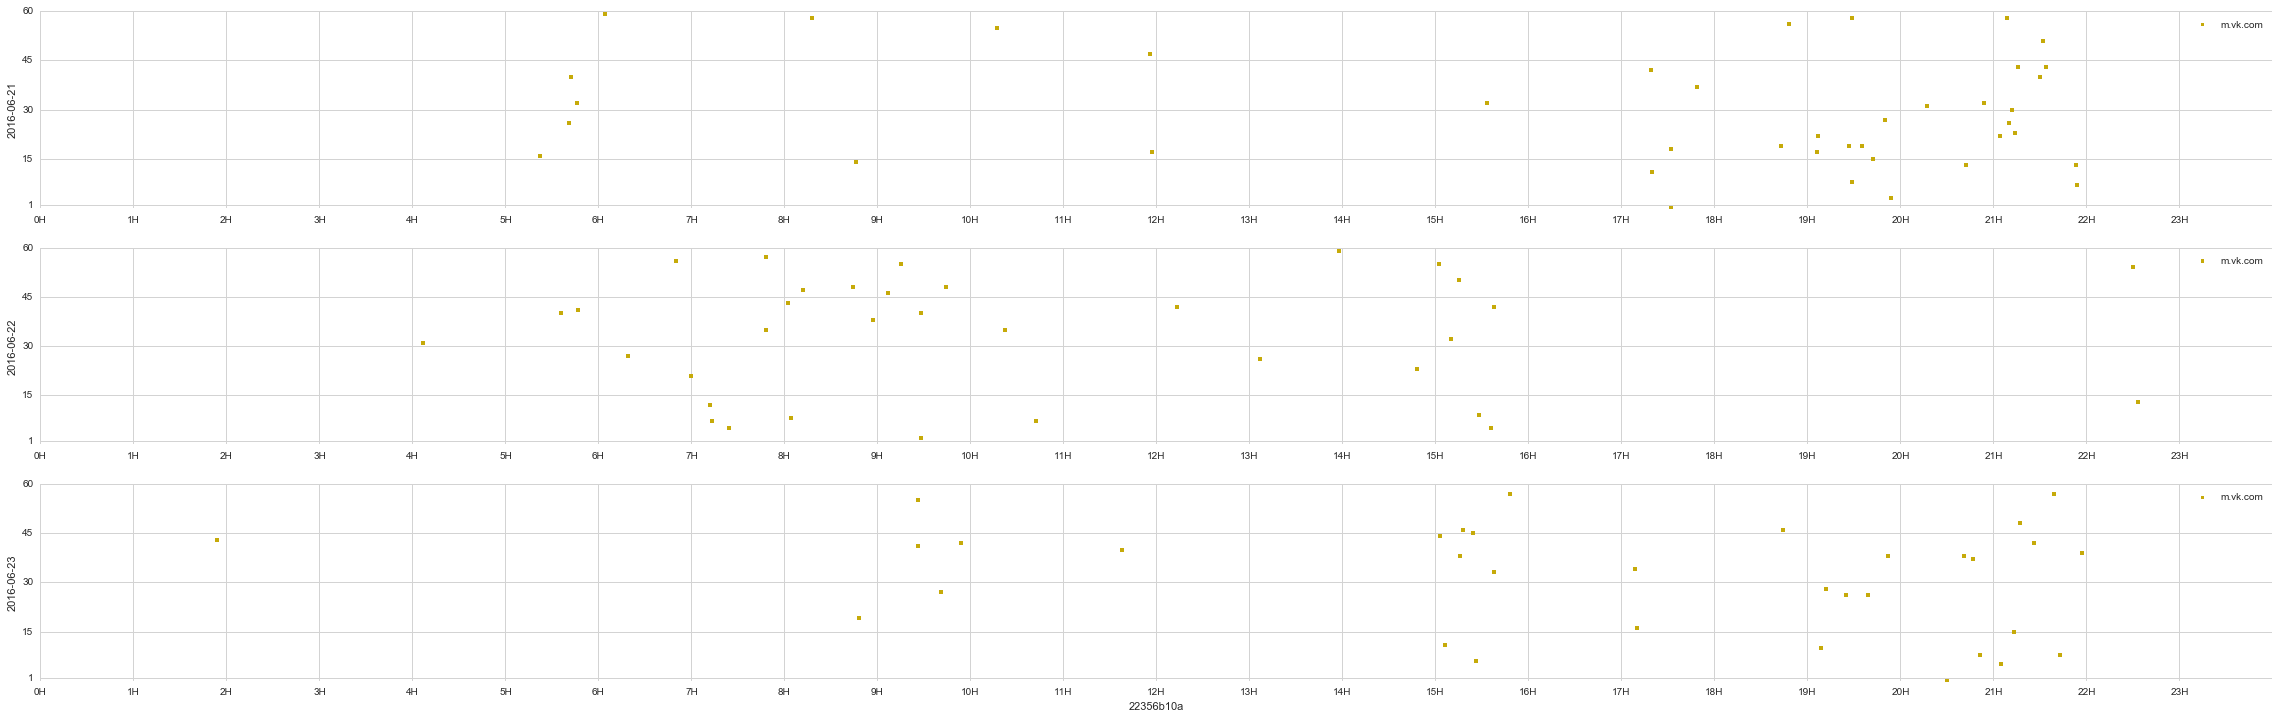

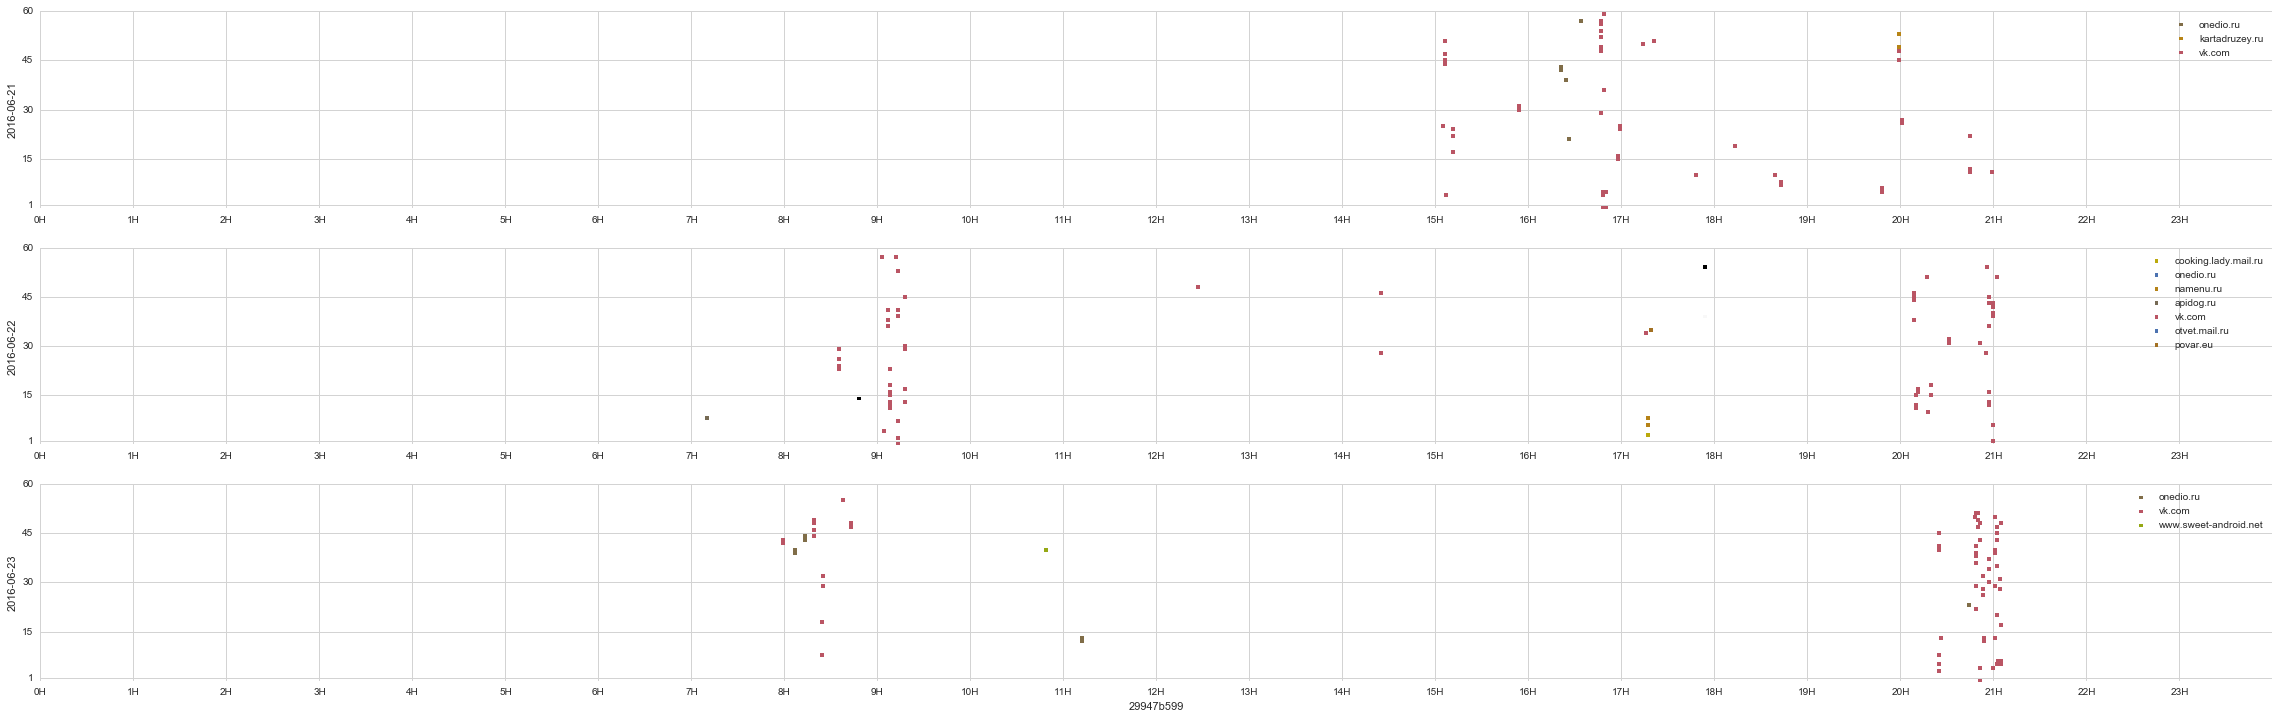

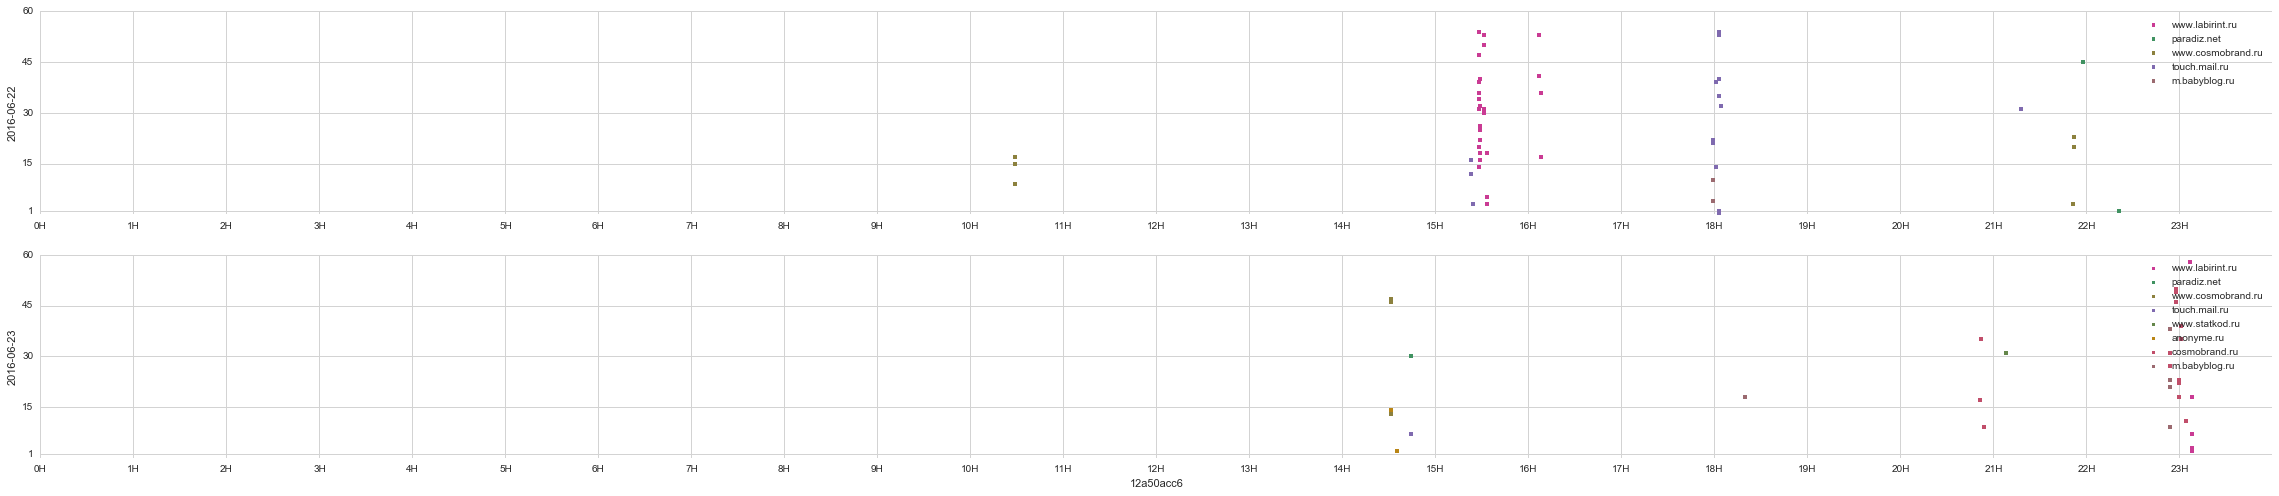

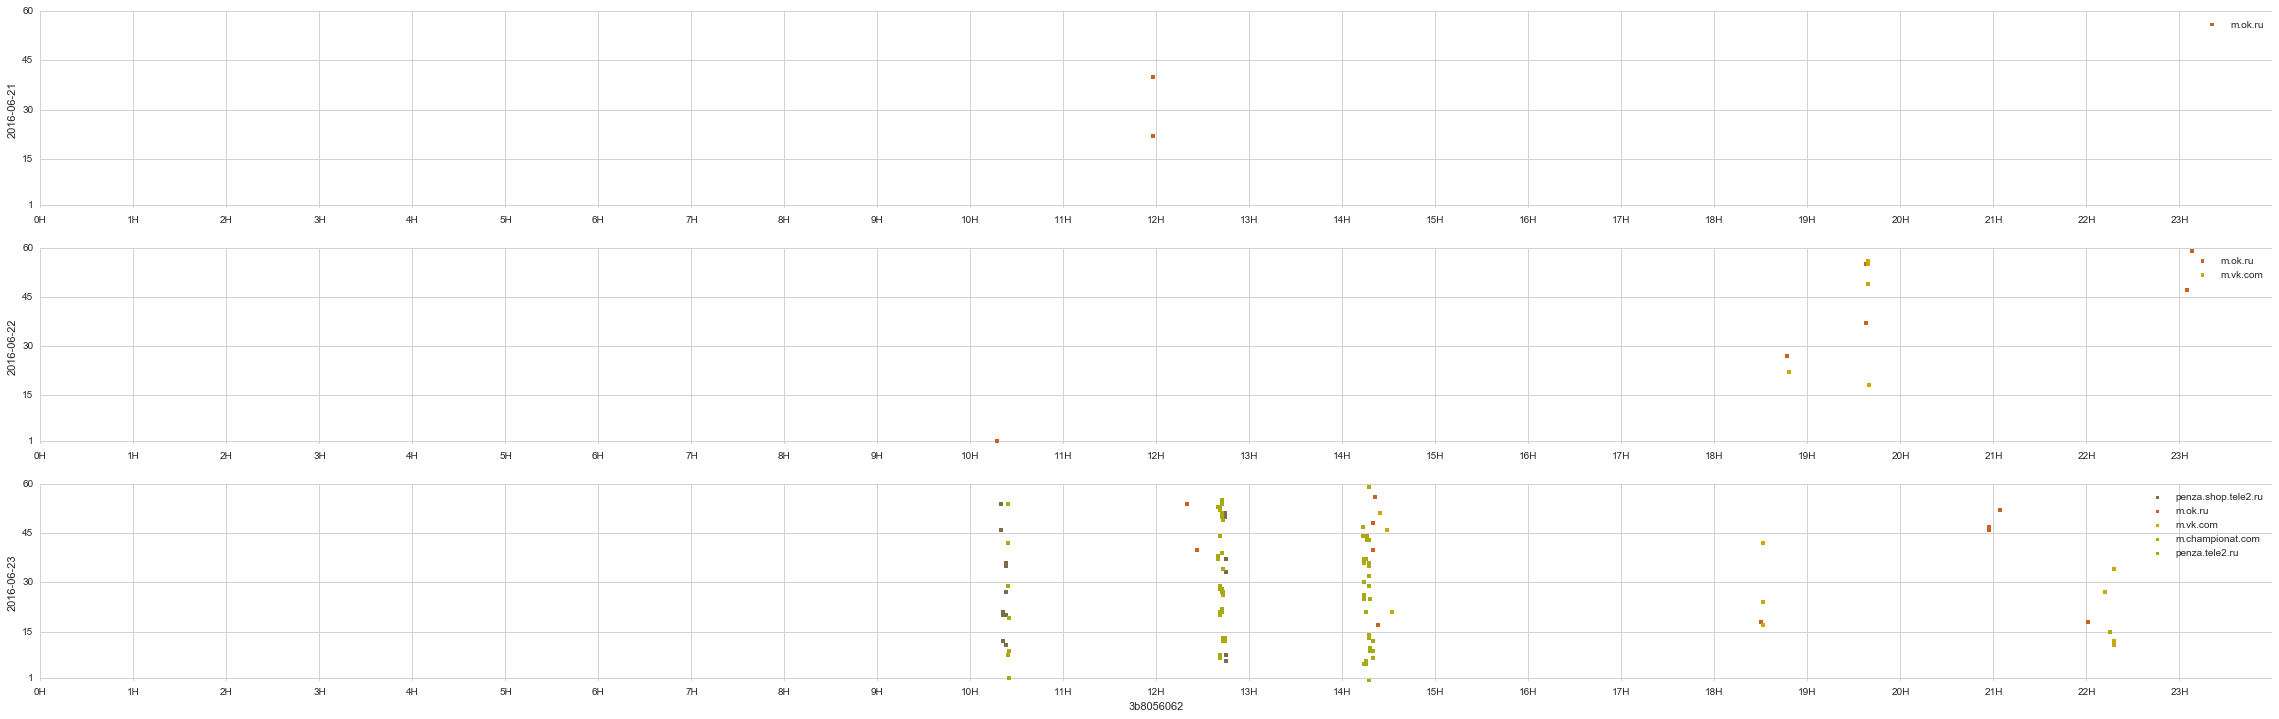

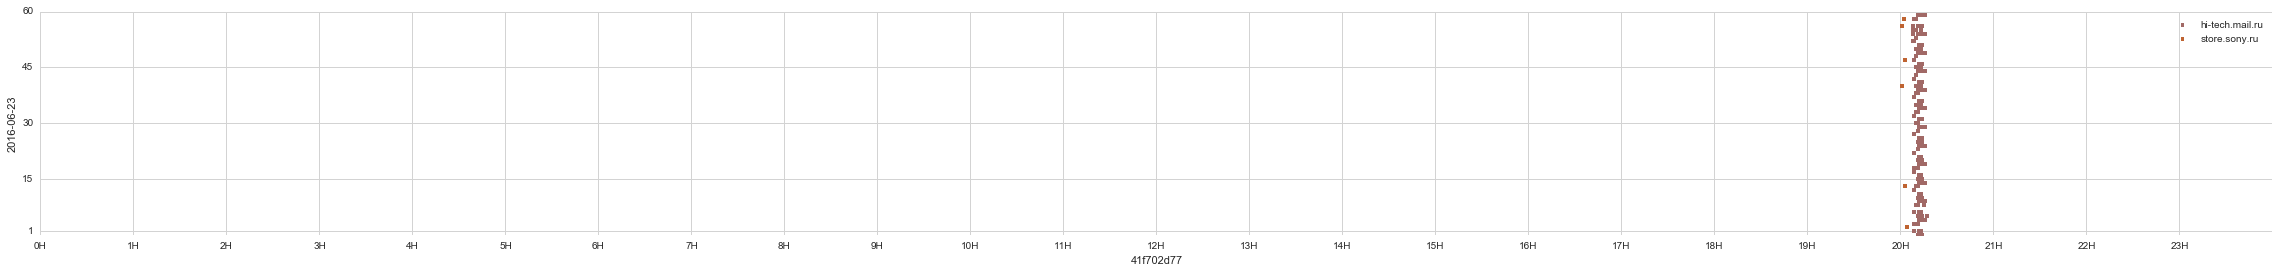

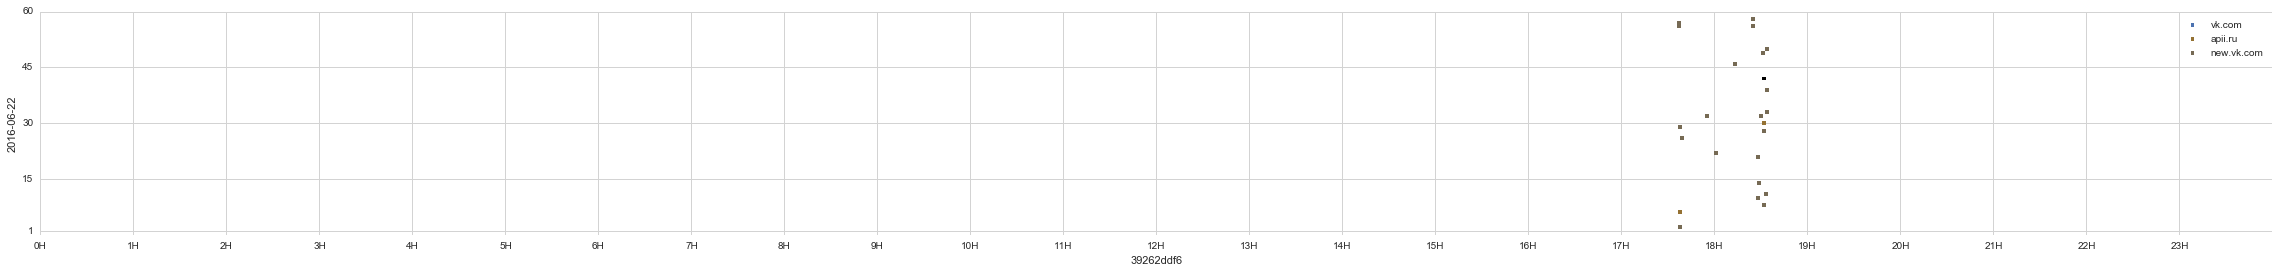

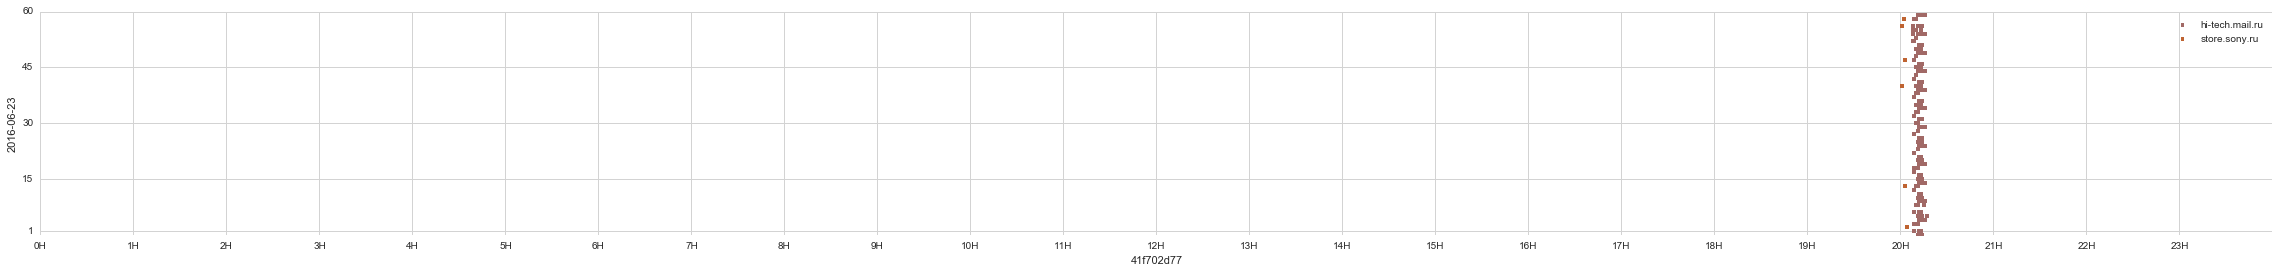

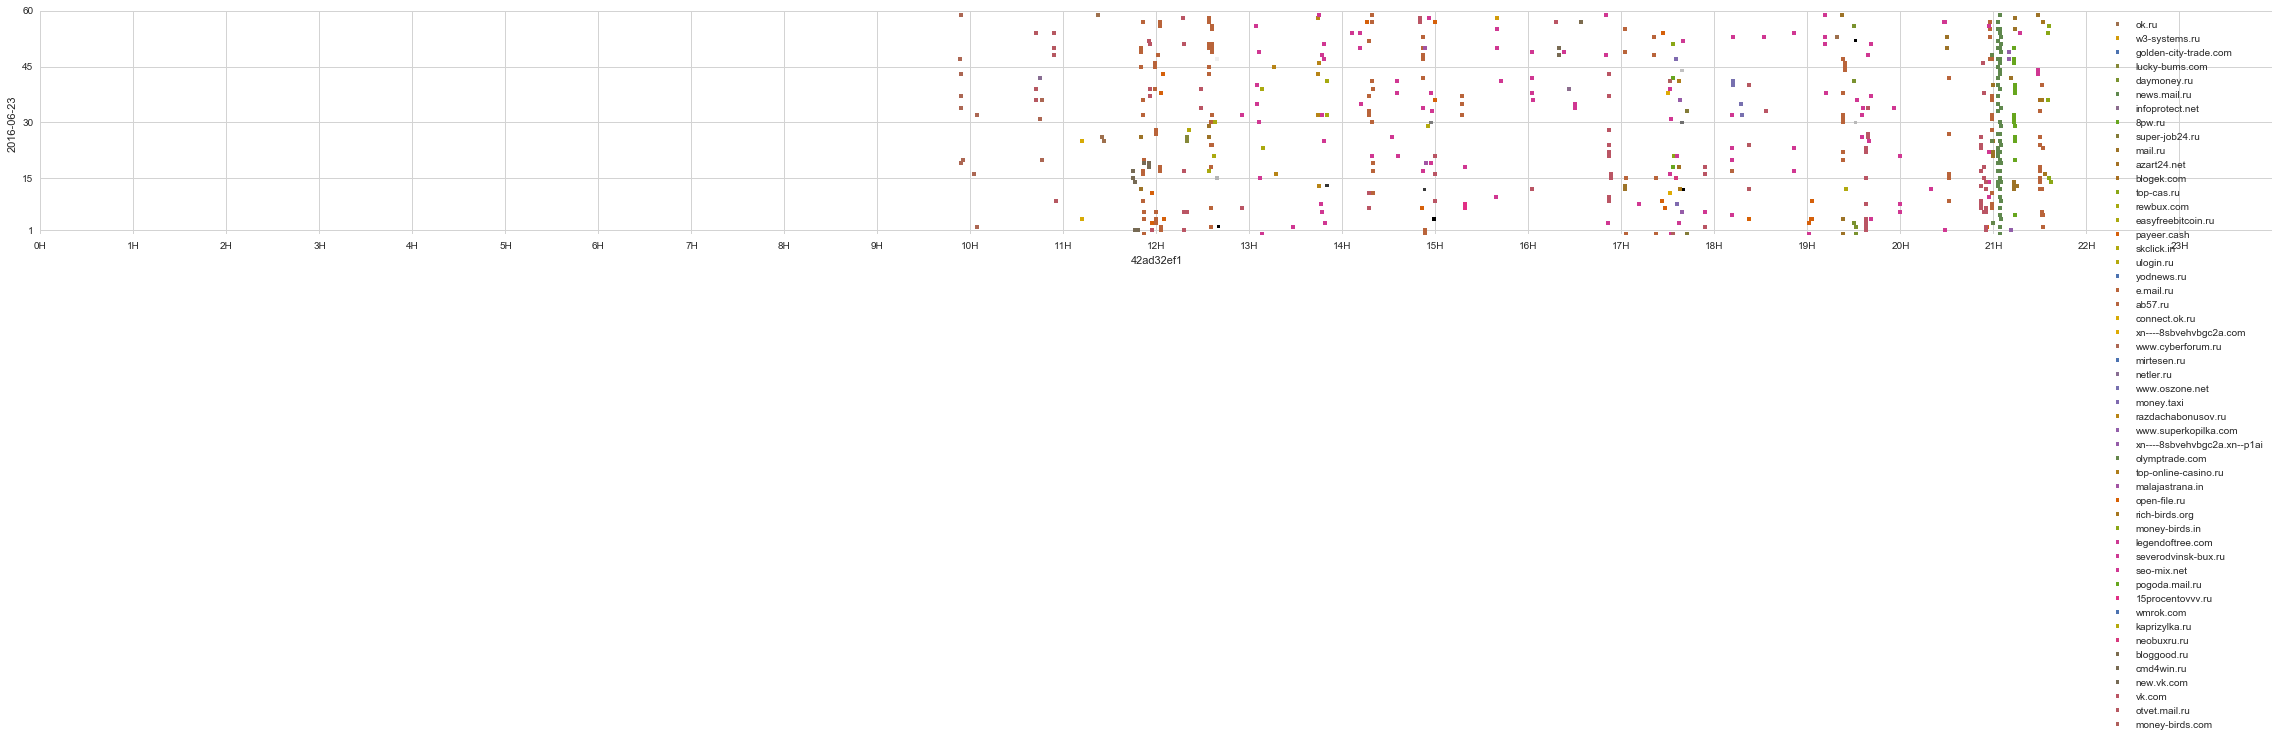

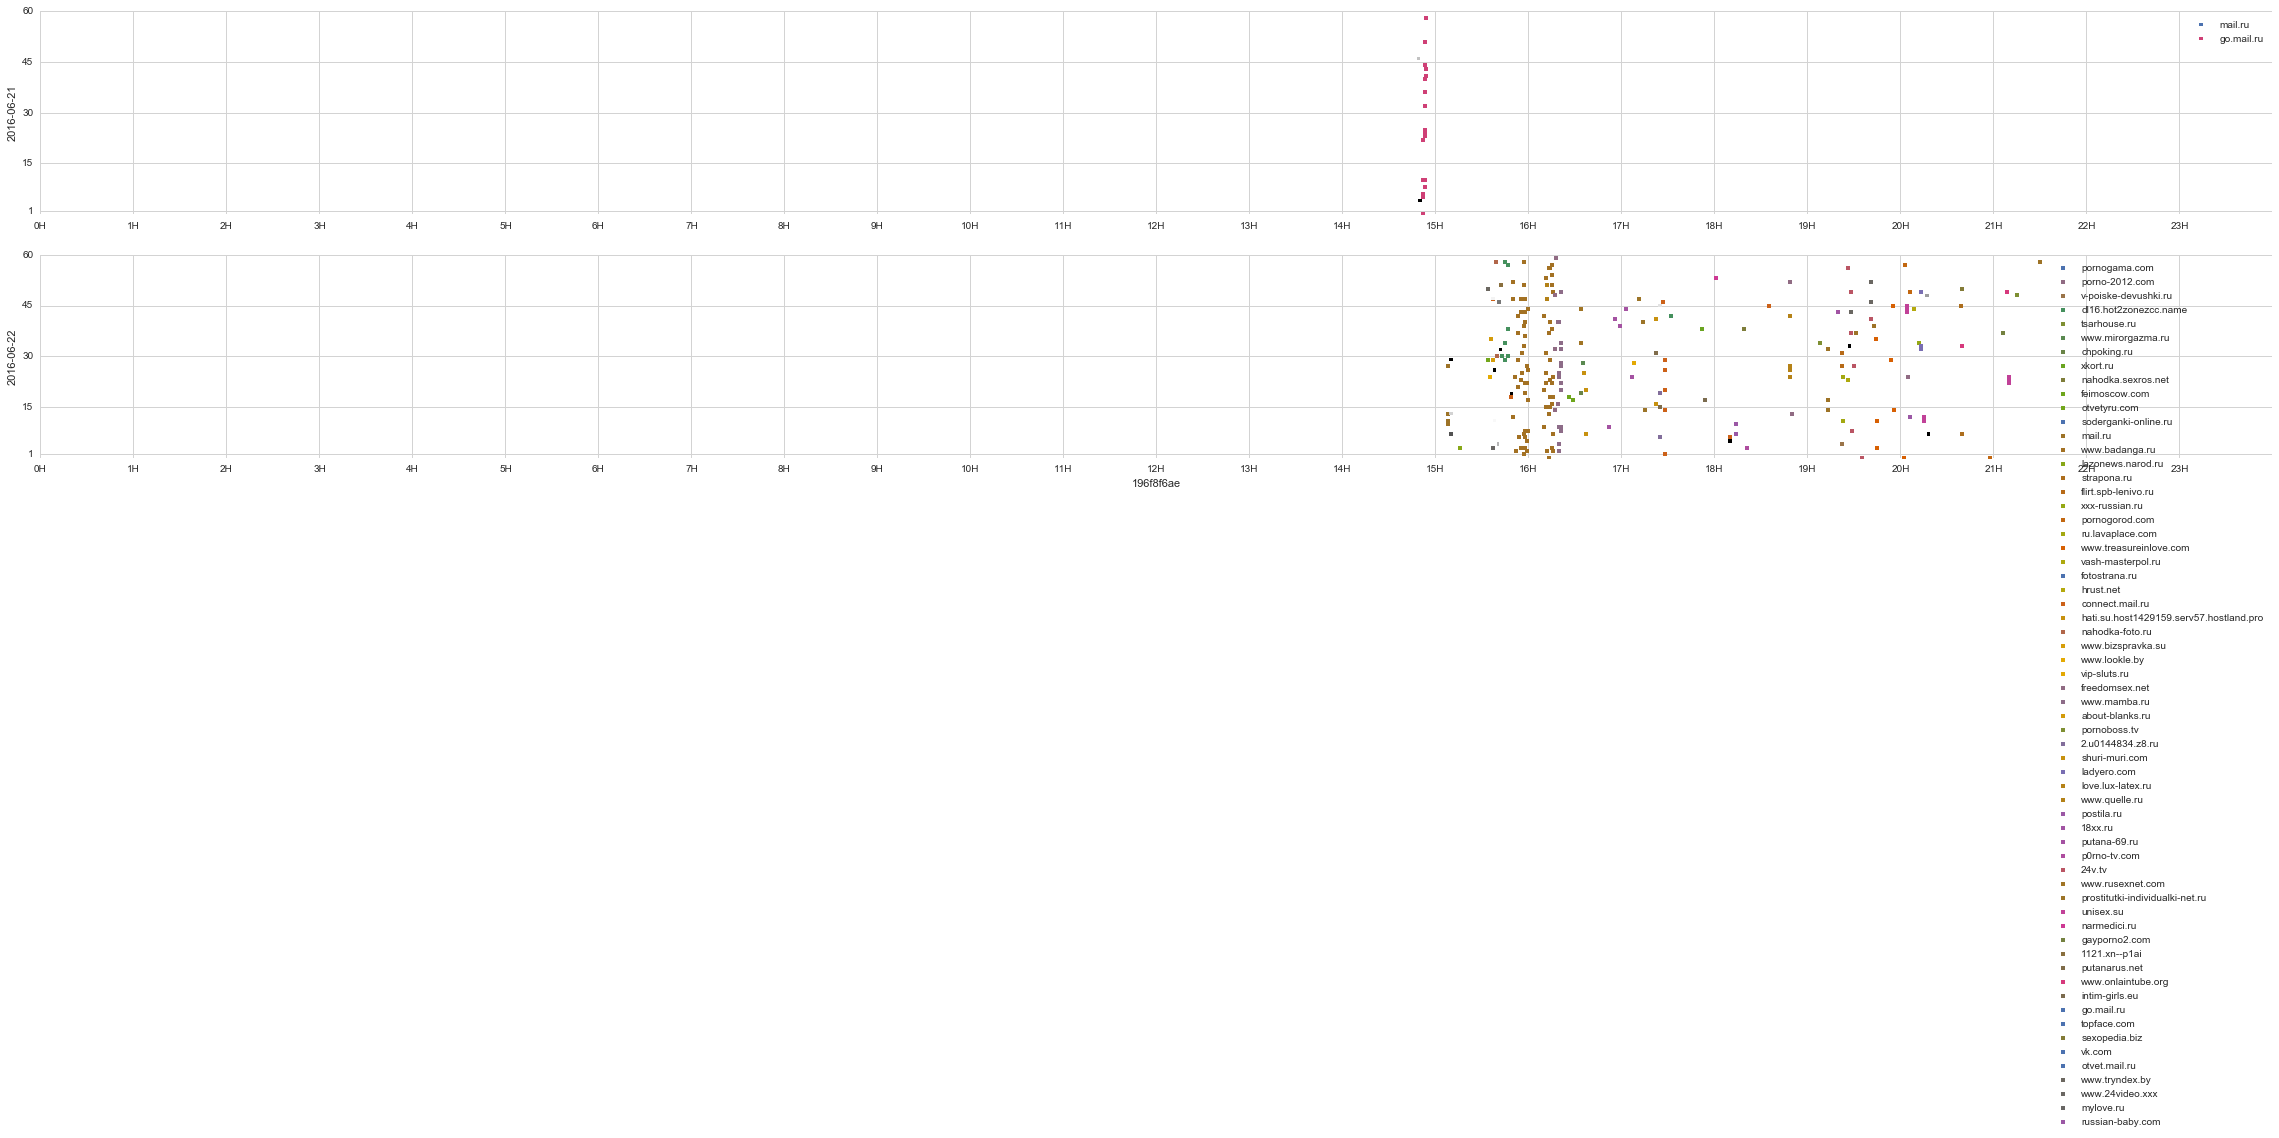

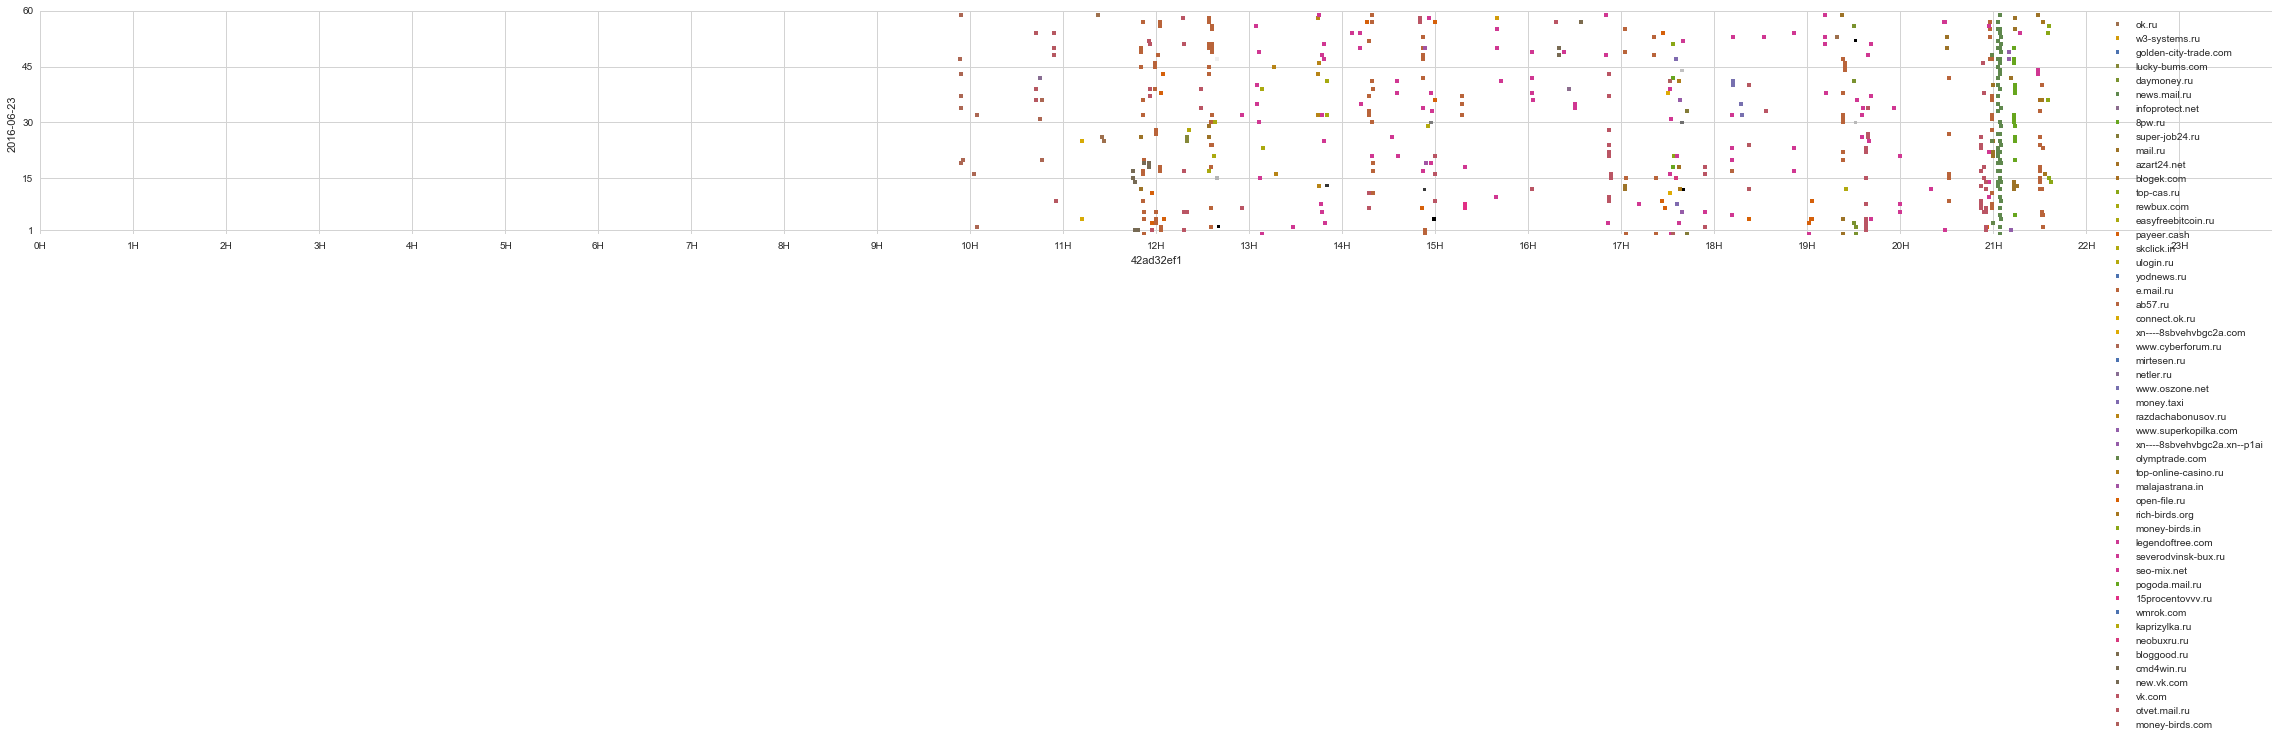

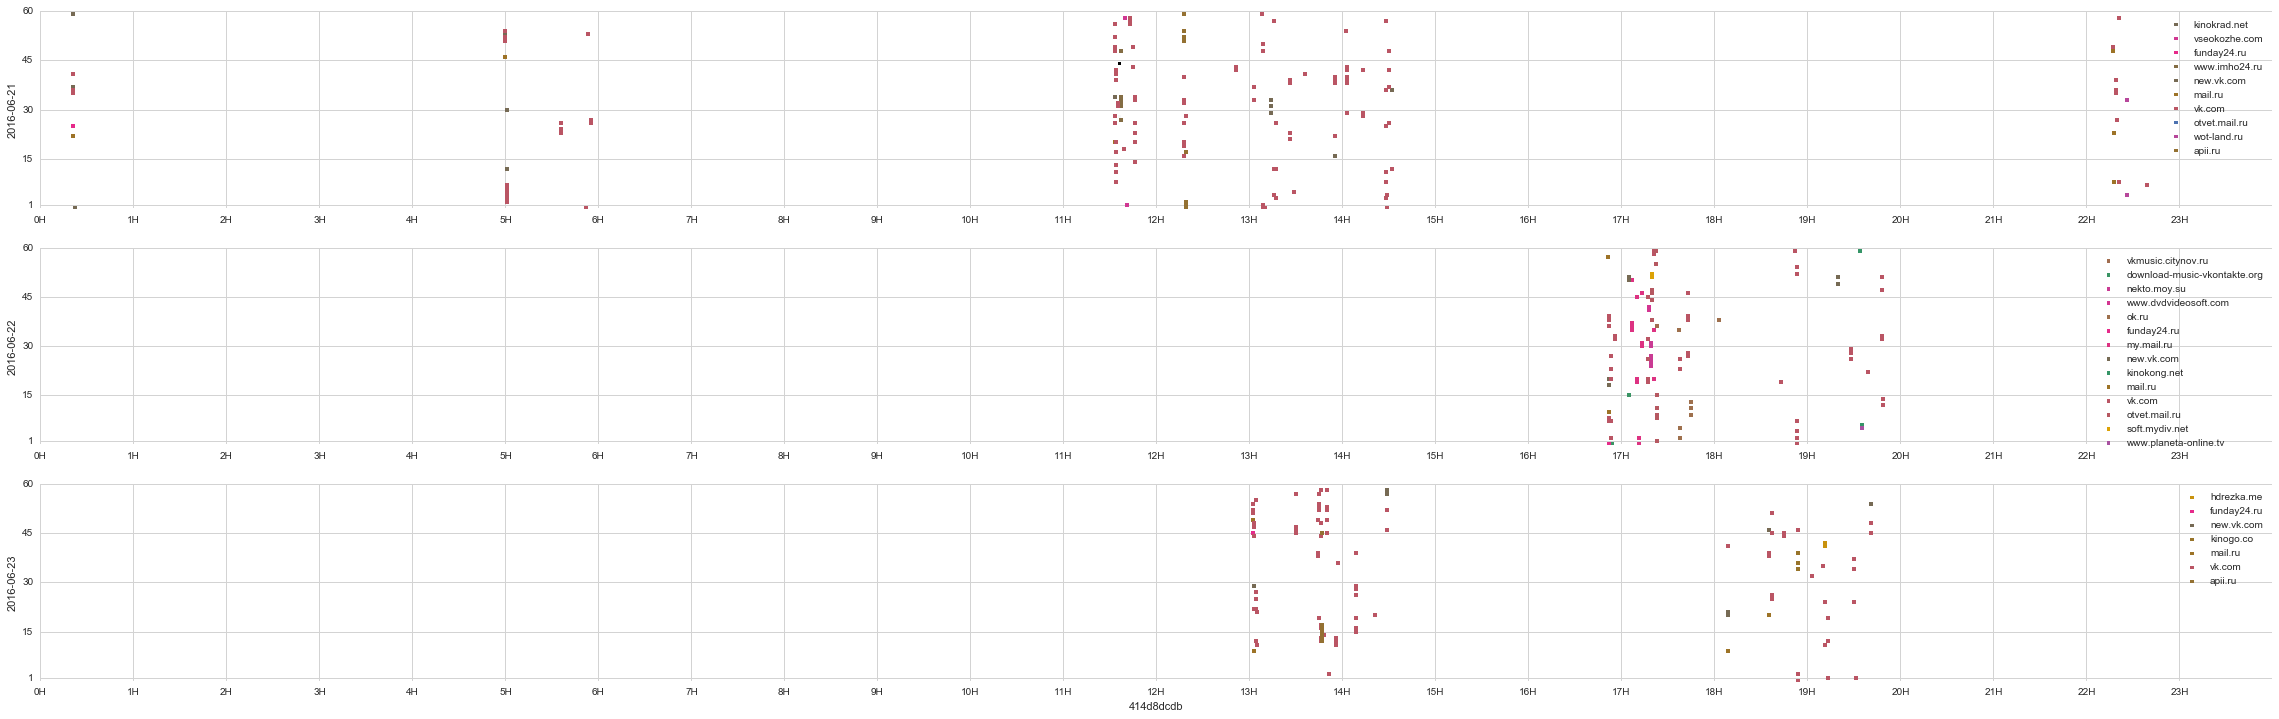

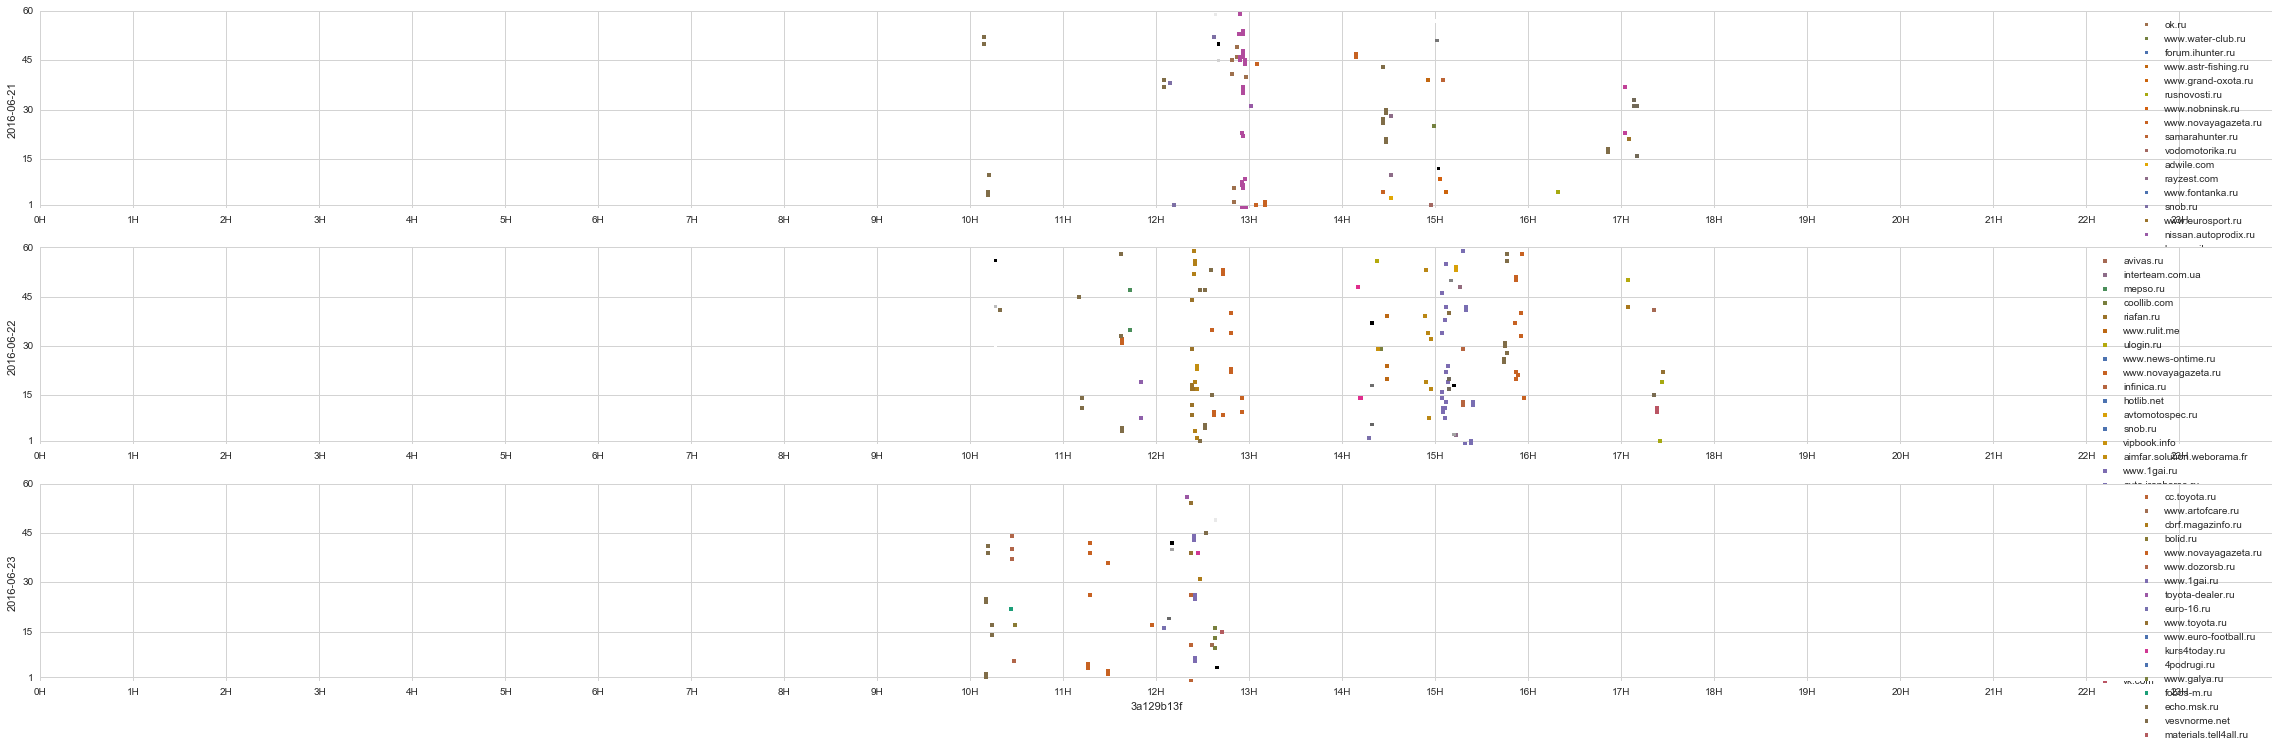

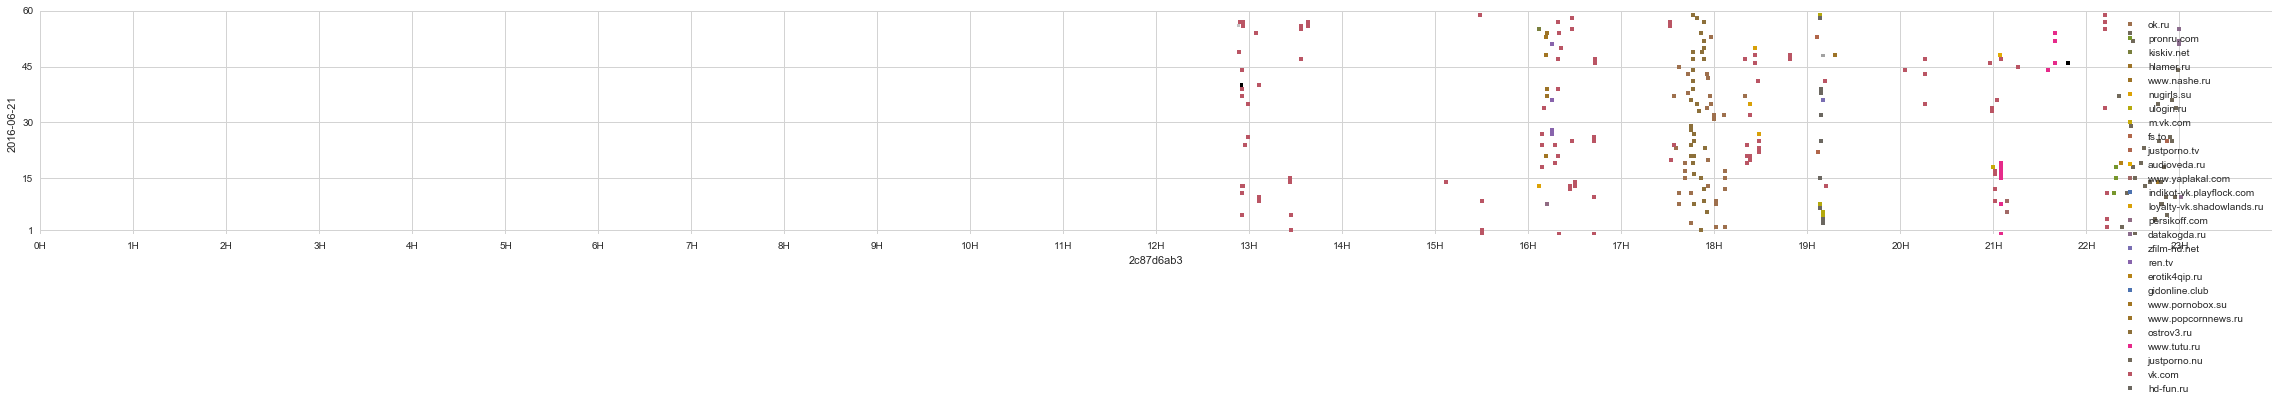

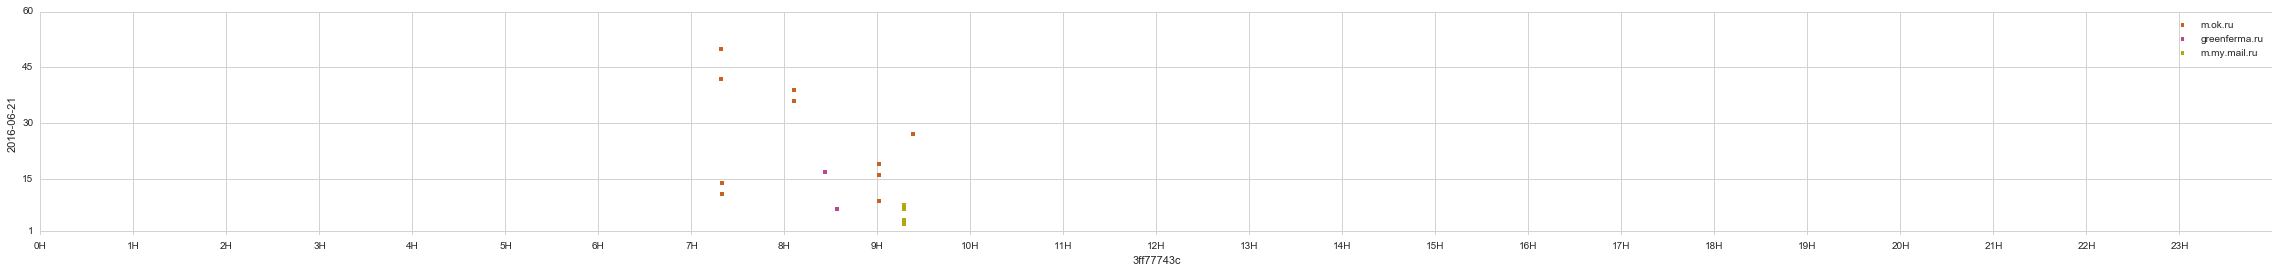

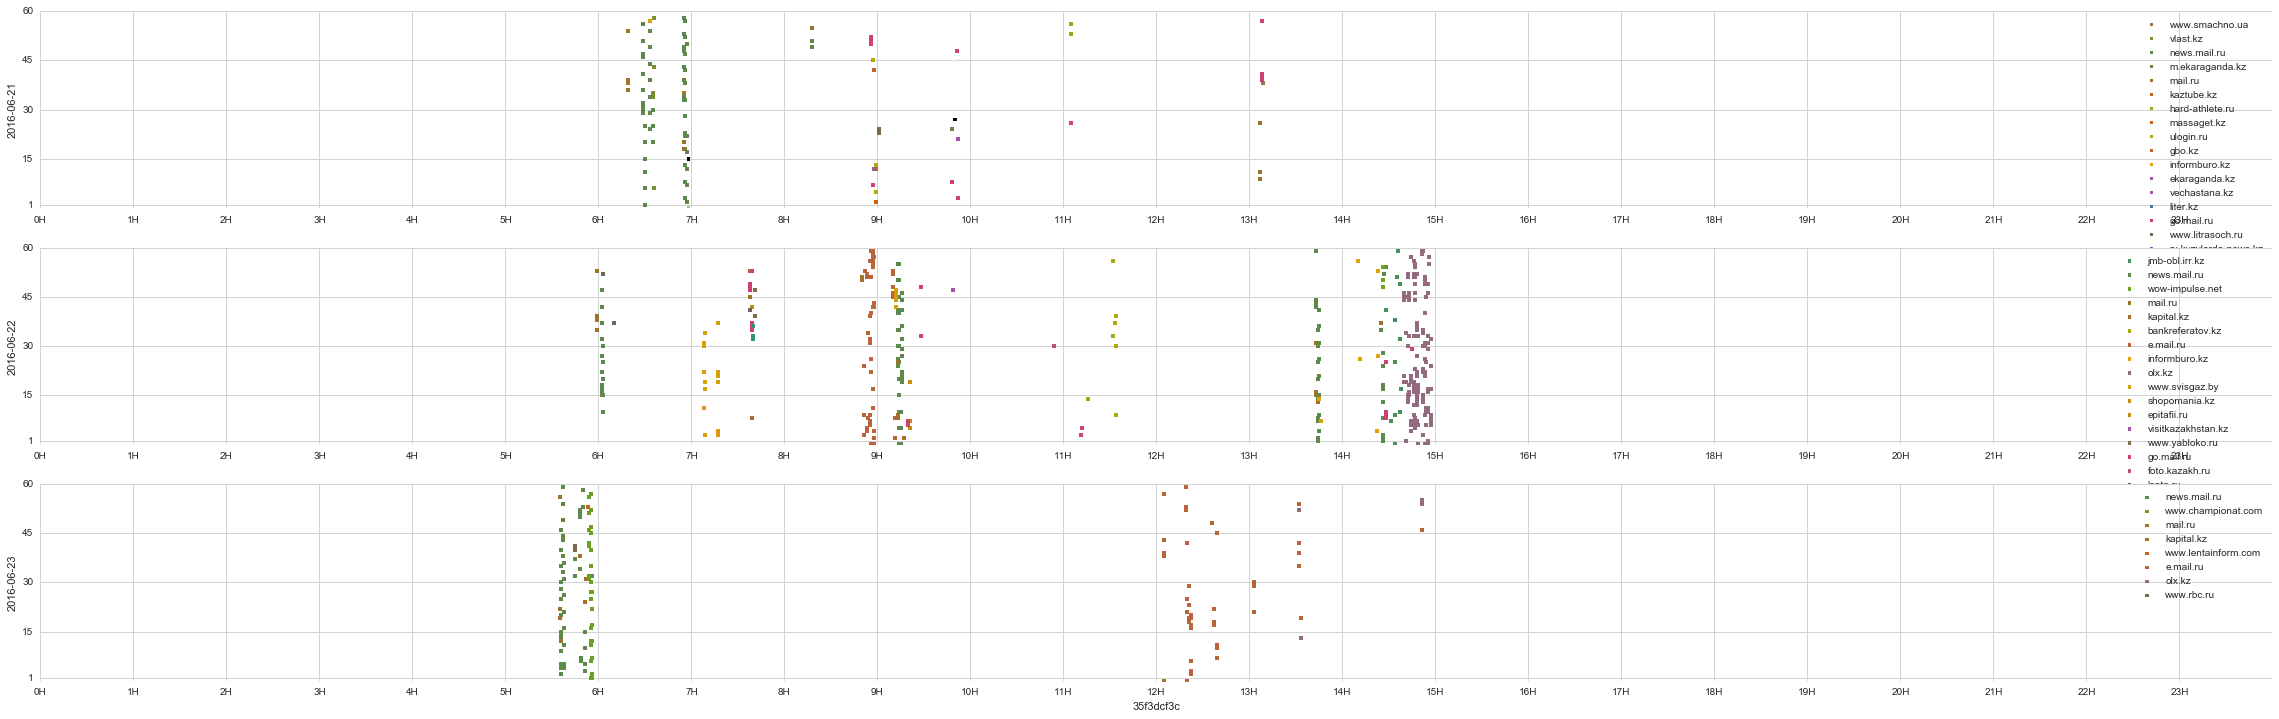

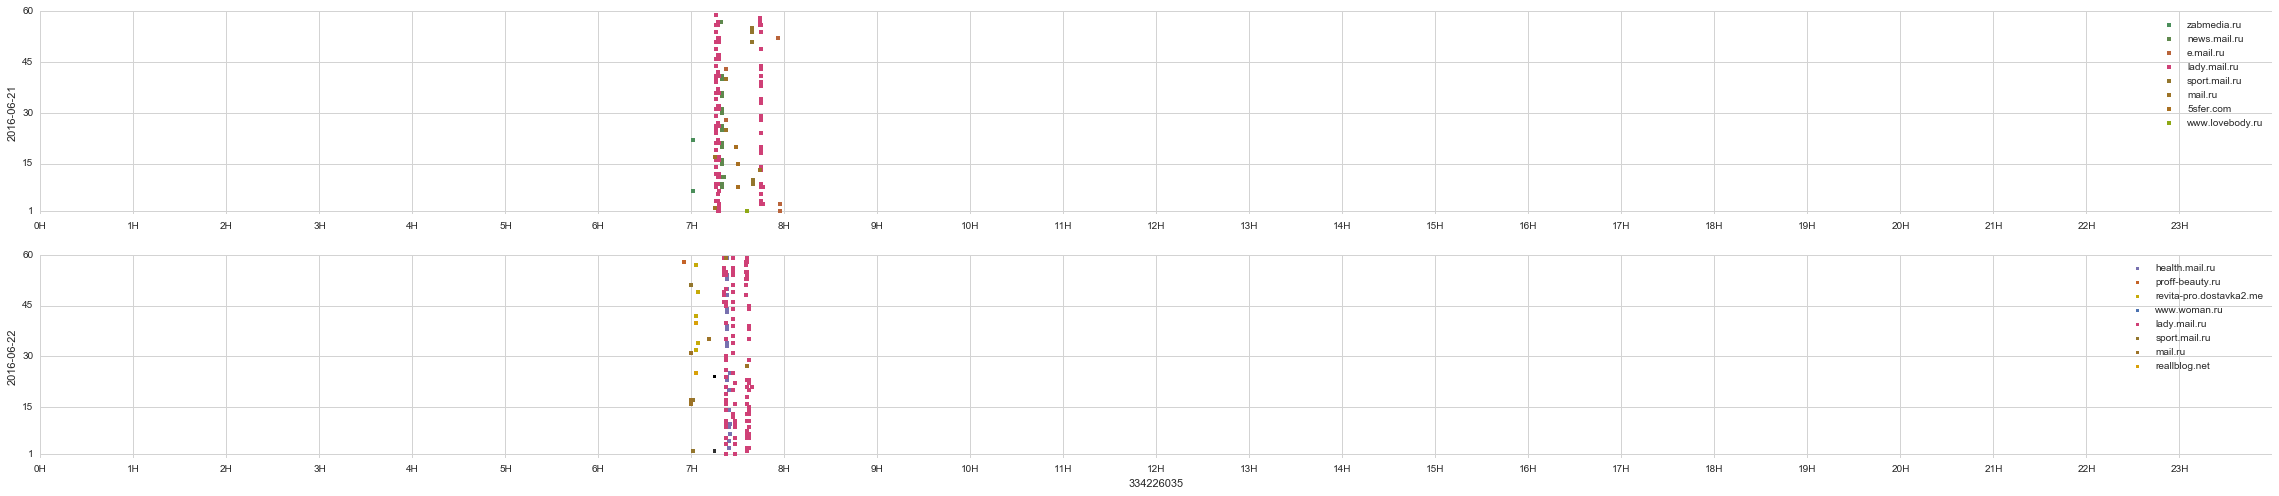

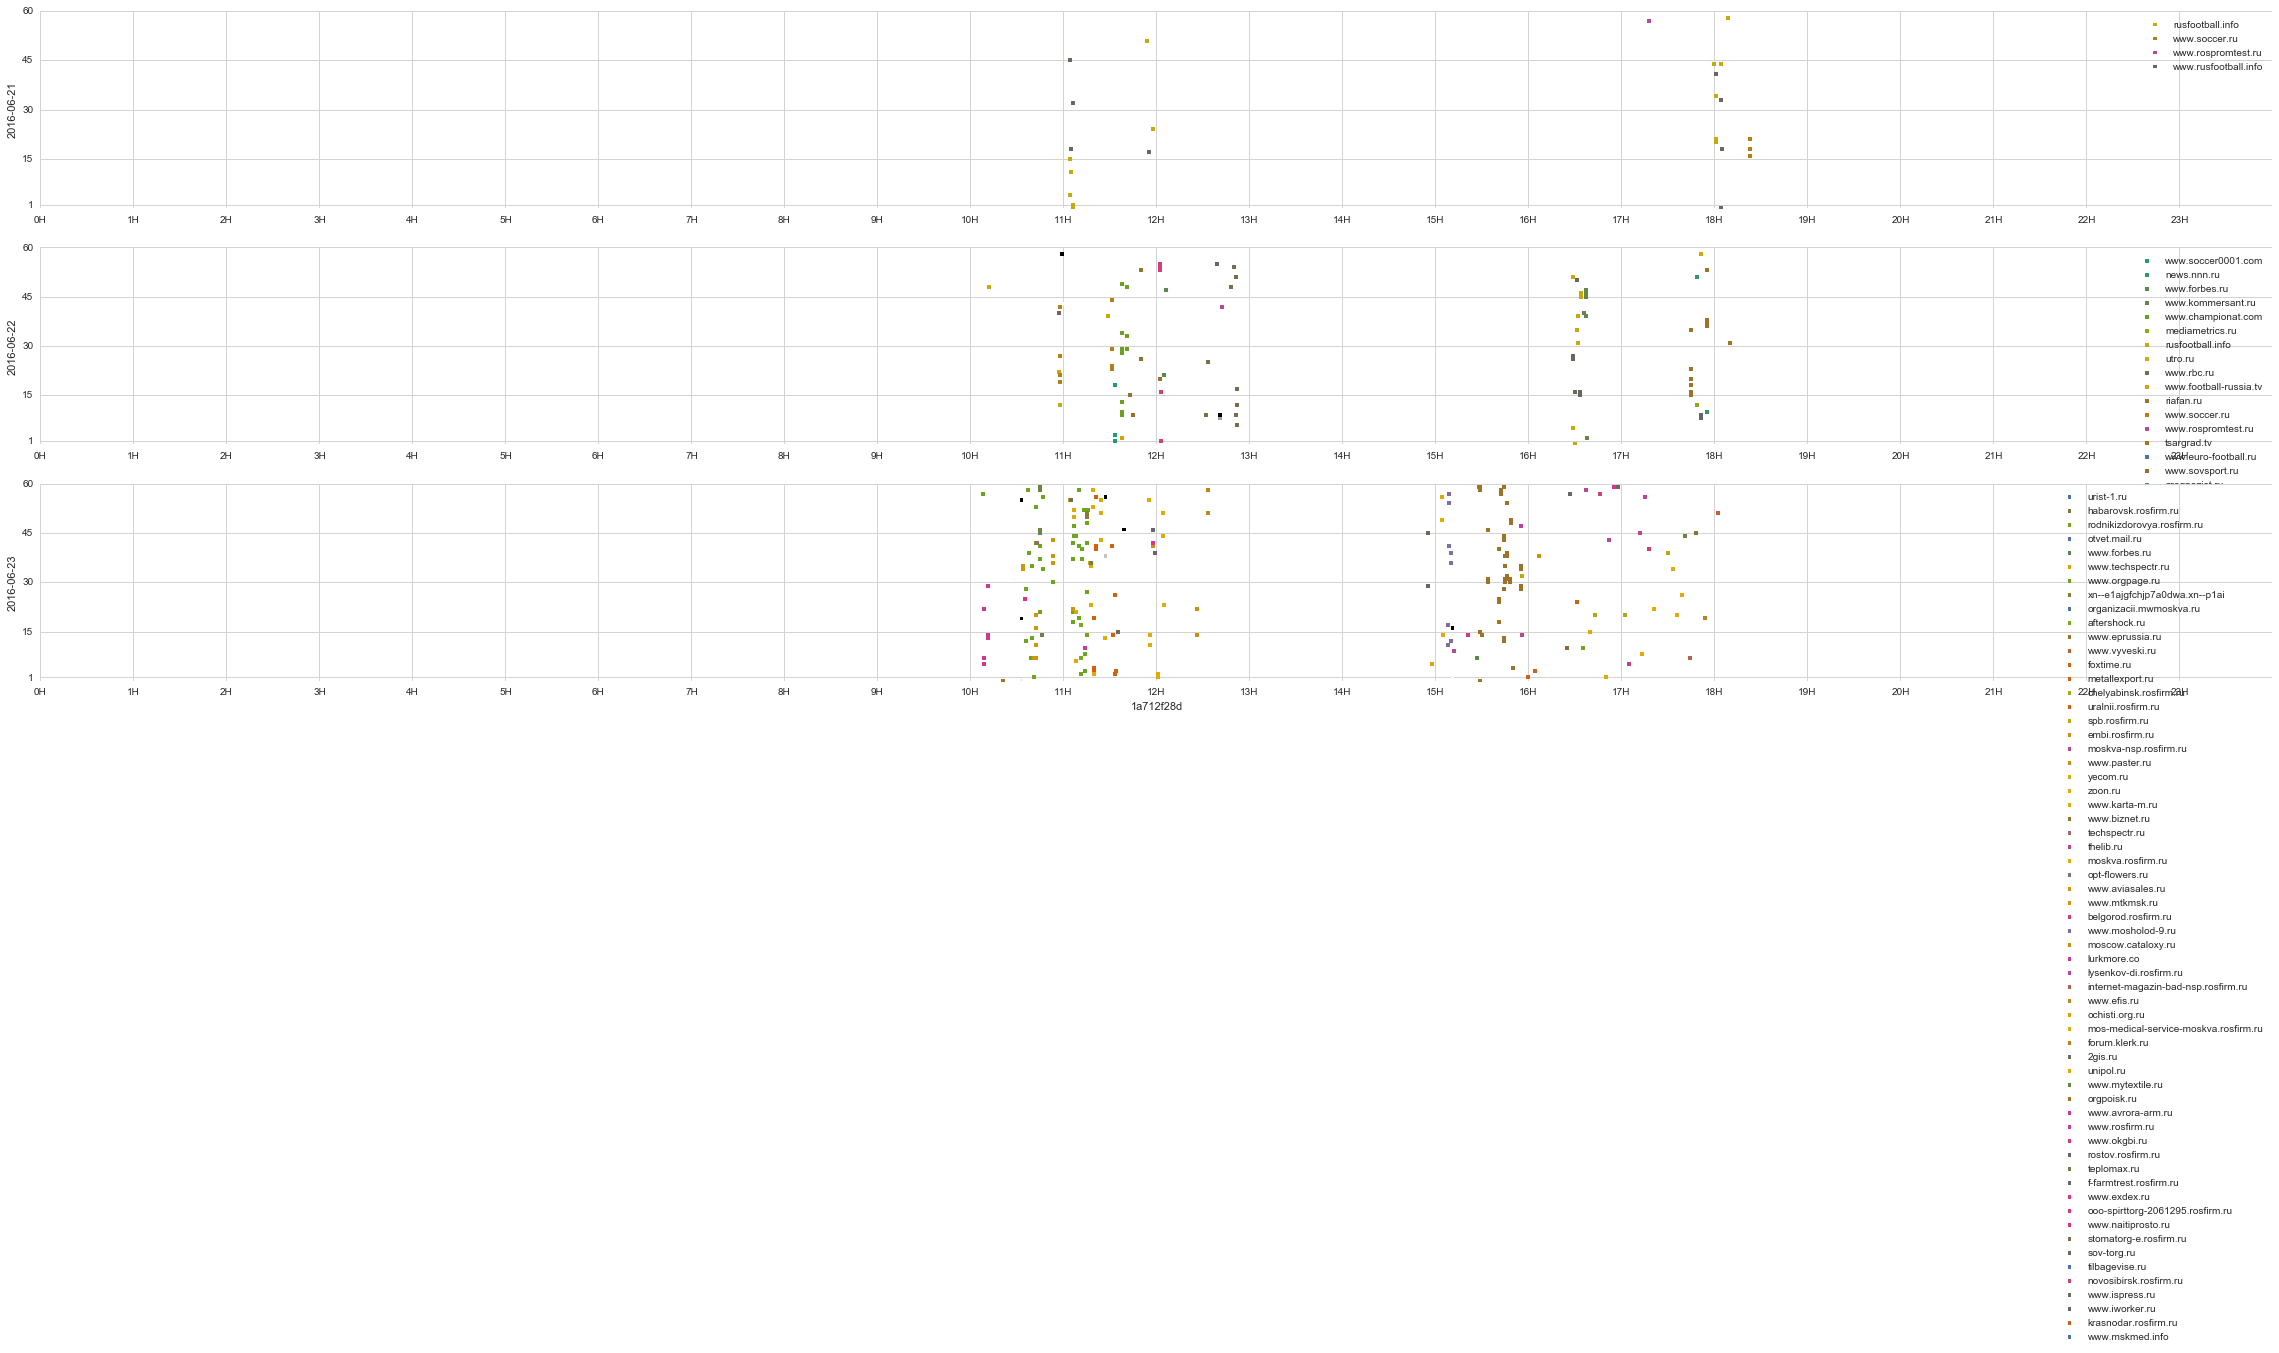

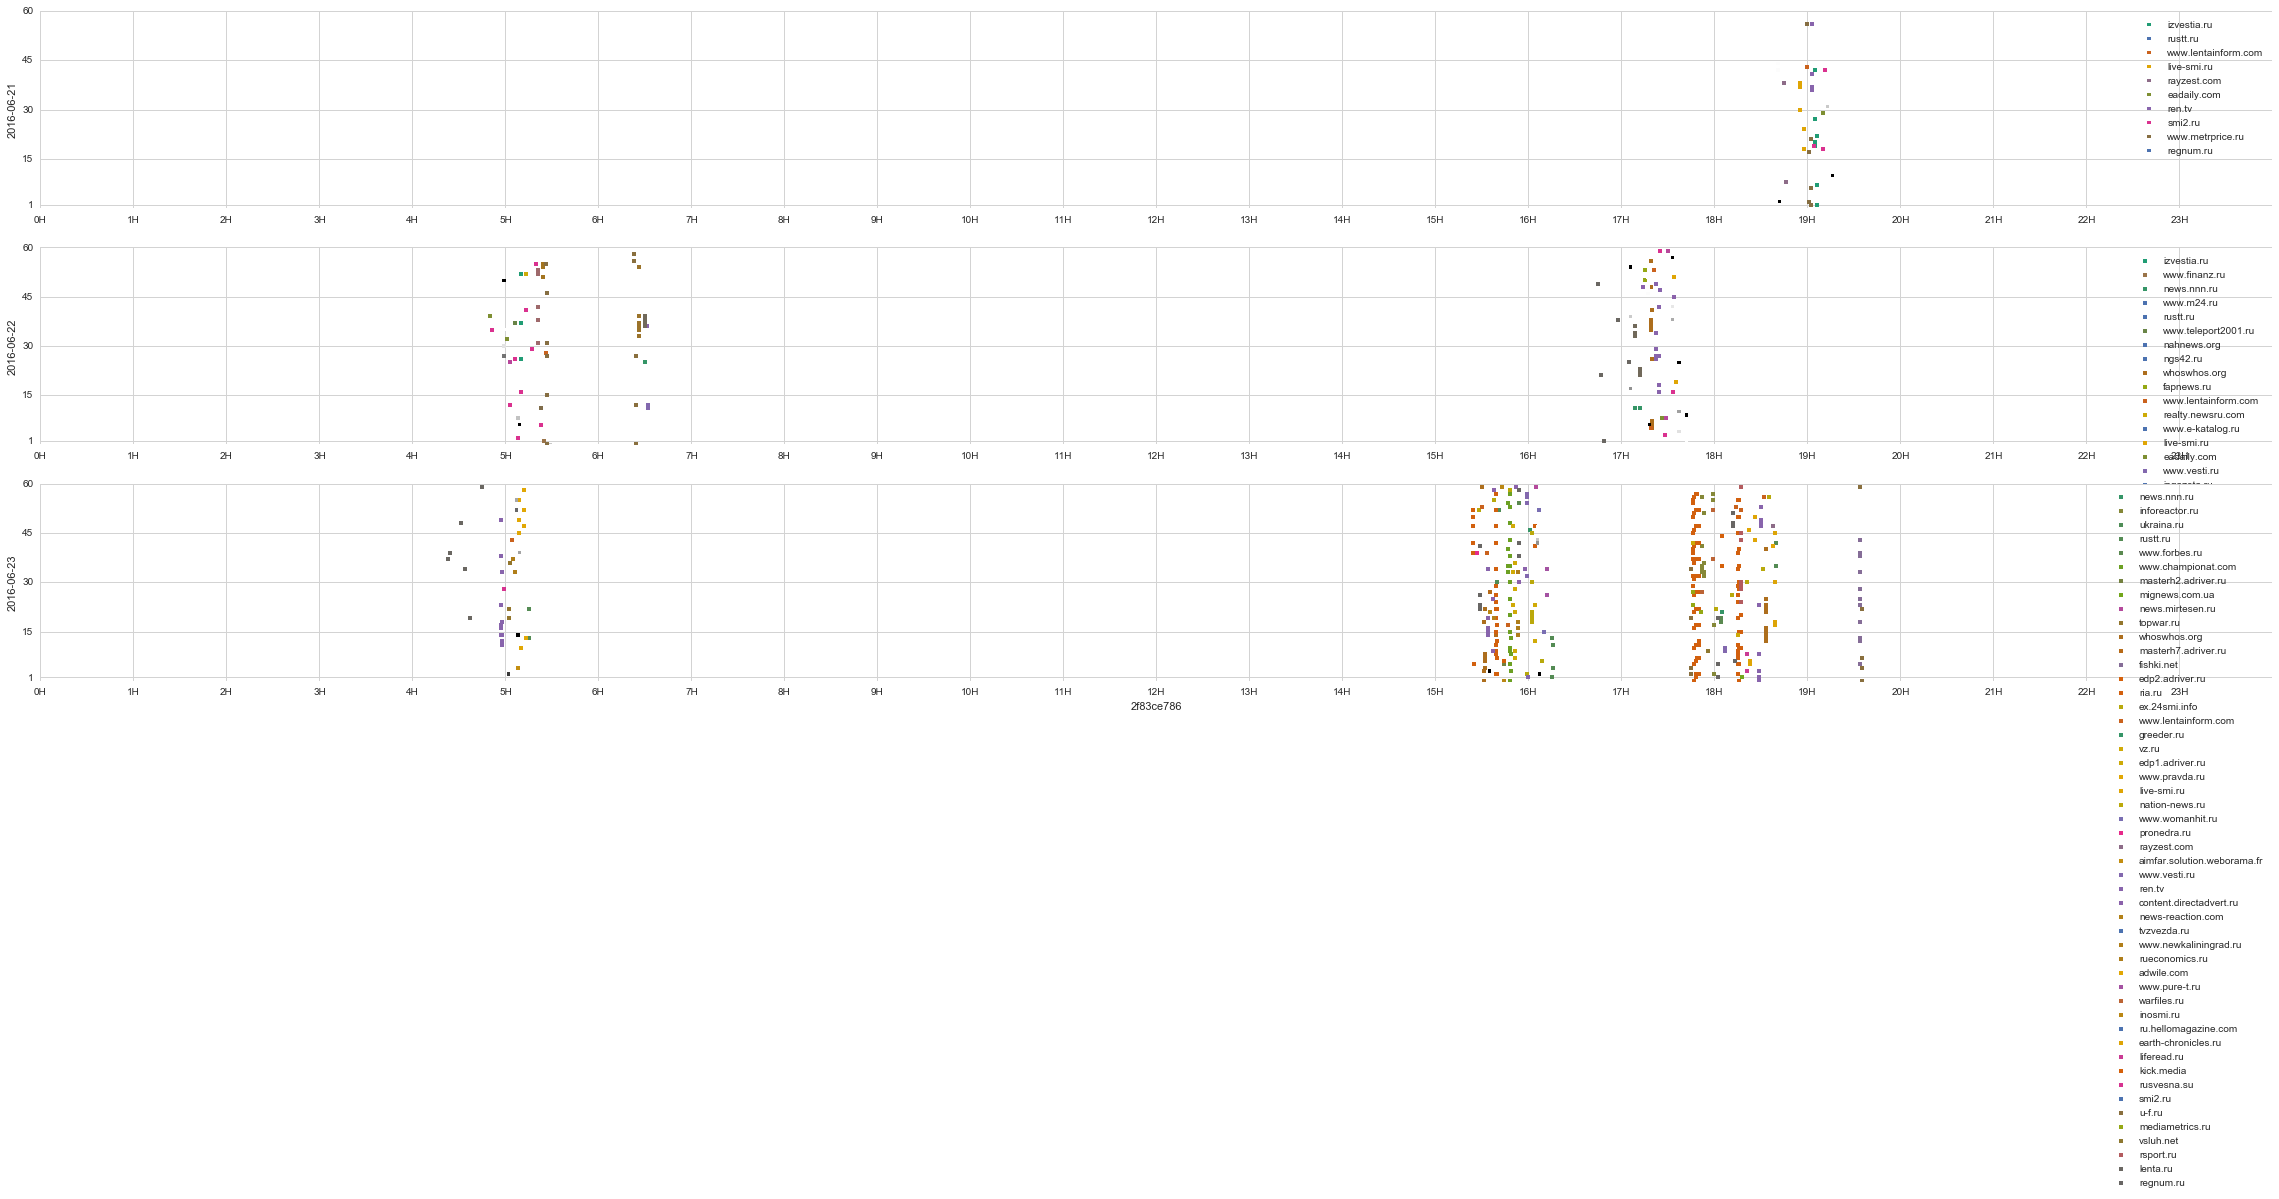

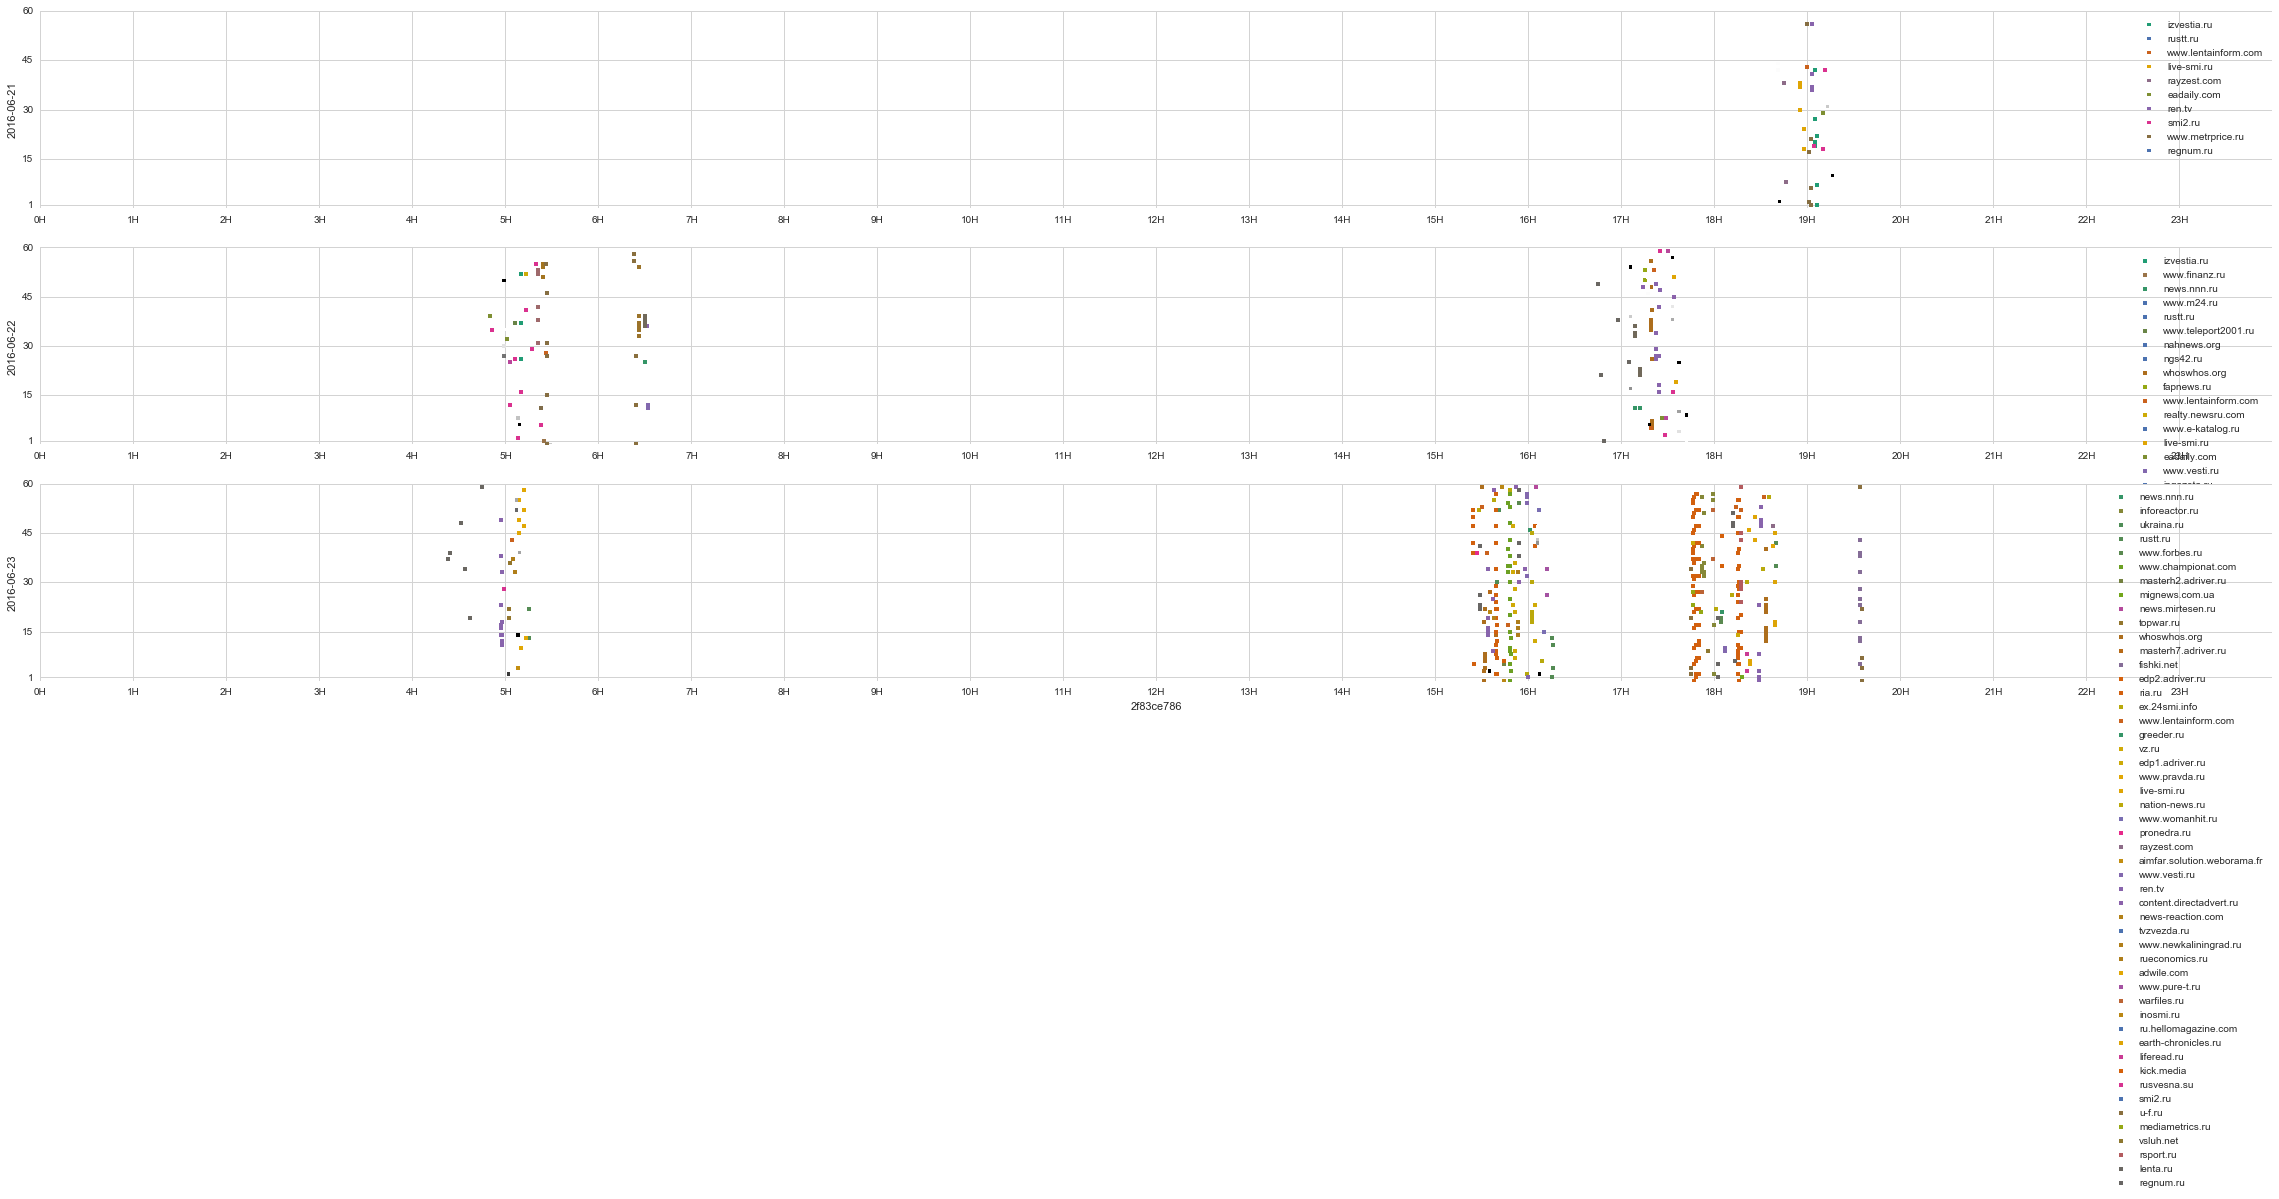

In [22]:
def plot_time_series(vid, vid_data, out_file=None):
    tss = [ts for ts in flatten([ts_list for d, ts_list in vid_data[vid].iteritems()])]
    
    min_date = dt.datetime.fromtimestamp(min(tss)).date() 
    max_date = dt.datetime.fromtimestamp(max(tss)).date()

    n_days = (max_date - min_date).days + 1

    pl.figure(figsize=(40, 4 * n_days))

    cm=pl.cm.Dark2

    for day in xrange(n_days):
        pl.subplot(n_days, 1, day + 1, axisbg='white')

        start_ts = int(time.mktime((min_date + dt.timedelta(days=day)).timetuple()))
        end_ts = int(time.mktime((min_date + dt.timedelta(days=day+1)).timetuple()))

        for d, ts_list in vid_data[vid].iteritems():
            ts_list_day = filter(lambda ts: start_ts < ts <= end_ts, ts_list)
            if ts_list_day:
                pl.scatter([ts / 60 for ts in ts_list_day], [ts % 60 for ts in ts_list_day], c=cm(hash(d) % 256), label=d, marker='s', s=12, lw=0)
                
        pl.ylabel(min_date + dt.timedelta(days=day))

        pl.legend()
        pl.grid(color='lightgray')
        pl.xlim(start_ts / 60, end_ts / 60)    
        pl.xticks(range(start_ts / 60, end_ts / 60, 60), ["%dH" % h for h in xrange(24)])
        pl.ylim(0,59)
        pl.yticks([1, 15, 30, 45, 60])
        
    pl.xlabel(vid)

    if out_file is None:
        pl.show()
    else:
        pl.savefig(out_file, format="png")

for c in tq.tqdm_notebook(xrange(n_clusters), total=n_clusters):
    for m in xrange(3):
        vid = df_activity_sample_cls[df_activity_sample_cls.cls == c].sample(1).index[0]
        if vid not in vid_data:
            continue
        plot_time_series(vid, vid_data, "/Users/anokhin/Desktop/ts/%d_%s.png" % (c, vid))

In [30]:
bots = ["418e9aab7", "1c8052c4d", "3d8c994d0", "42ad32ef1"]
print "bot:\t\t\t", bots

bot:			['418e9aab7', '1c8052c4d', '3d8c994d0', '42ad32ef1']


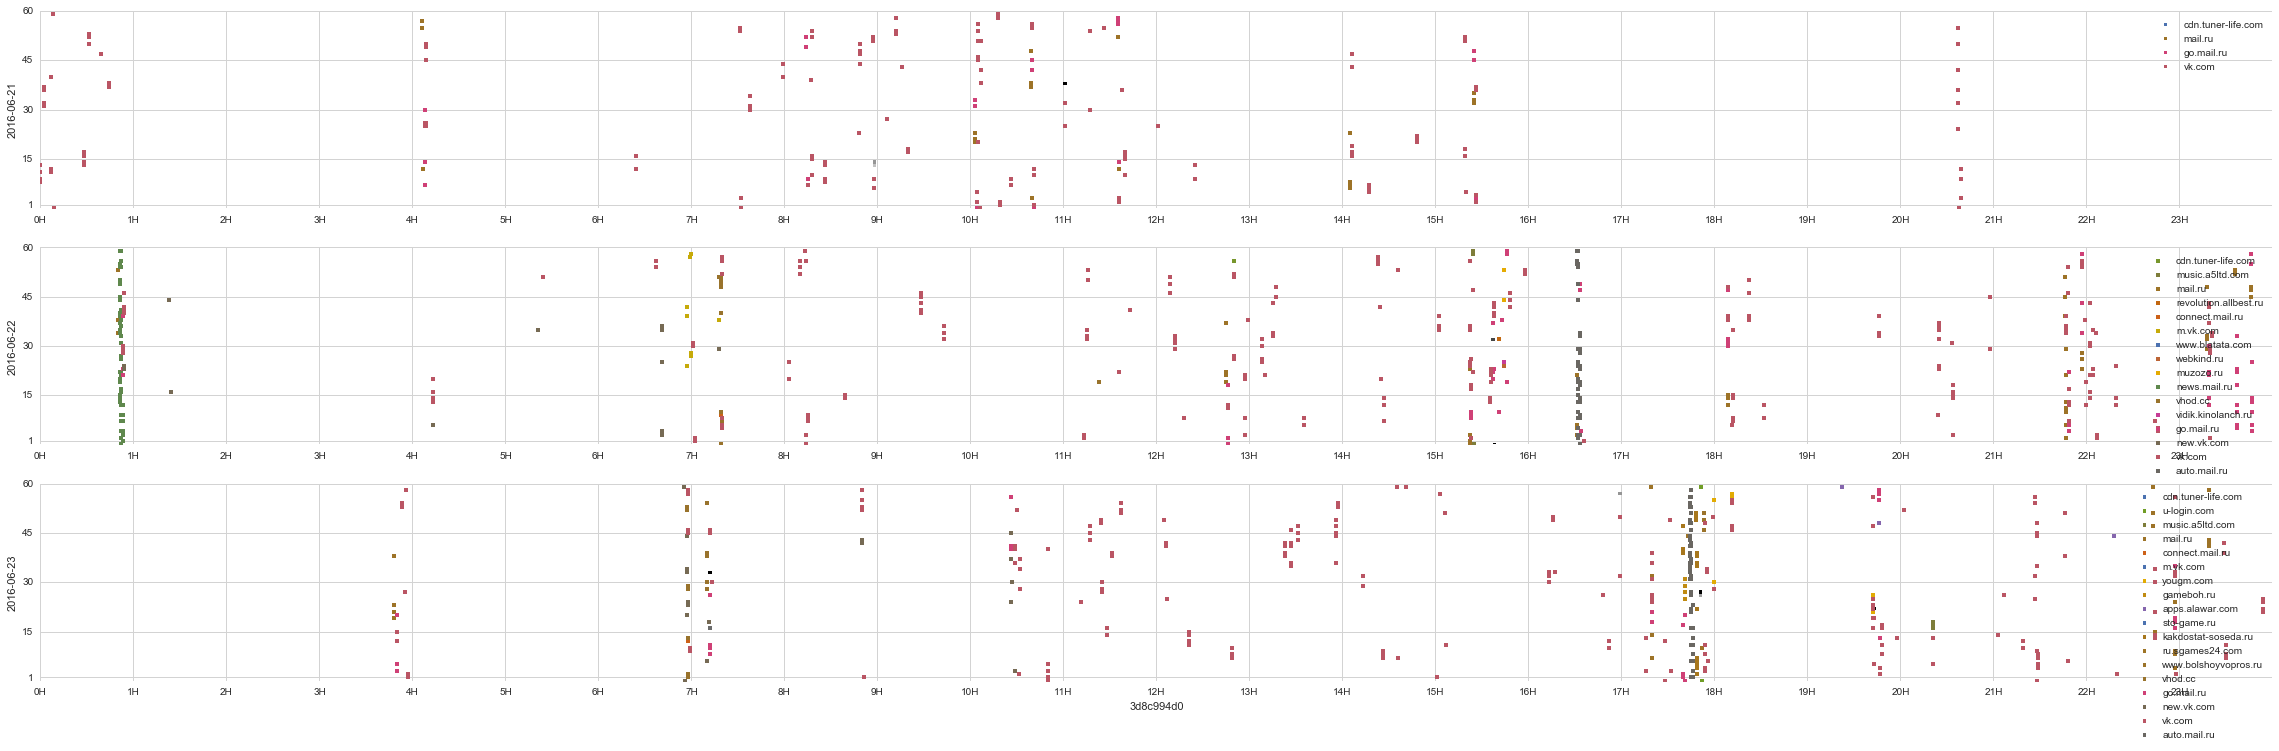

In [31]:
plot_time_series("3d8c994d0", vid_data)

## Nearest neighbours

In [32]:
df_activity_log = np.log1p(df_activity)
df_activity_log_norm = (df_activity_log - df_activity_log.mean()) / df_activity_log.std()
df_activity_log.fillna(0, inplace=True)
df_activity_log.describe()

n_sessions        n_hits        n_days  hits_per_session_mean  \
count  1.392128e+06  1.392128e+06  1.392128e+06           1.392128e+06   
mean   1.206776e+00  2.319096e+00  8.450564e-01           1.565306e+00   
std    8.627877e-01  1.729670e+00  4.214723e-01           1.033586e+00   
min    0.000000e+00  0.000000e+00  0.000000e+00           0.000000e+00   
25%    6.931472e-01  6.931472e-01  6.931472e-01           6.931472e-01   
50%    6.931472e-01  1.945910e+00  6.931472e-01           1.386294e+00   
75%    1.791759e+00  3.526361e+00  1.098612e+00           2.233557e+00   
max    4.912655e+00  1.581133e+01  1.609438e+00           1.581133e+01   

       hits_per_session_std  domains_per_session_mean  \
count          1.392128e+06              1.392128e+06   
mean           8.930769e-01              8.302355e-01   
std            1.205789e+00              4.501368e-01   
min            0.000000e+00              0.000000e+00   
25%            0.000000e+00              6.931472e-01   
50%            0.000000e+00              6.931472e-01   
75%            1.722052e+00              1.098612e+00   
max            8.975218e+00              1.090169e+01   

       domains_per_session_std  interval_between_hits_mean  \
count             1.392128e+06                1.392128e+06   
mean              2.665847e-01                2.851156e+00   
std               4.720289e-01                1.992115e+00   
min               0.000000e+00                0.000000e+00   
25%               0.000000e+00                0.000000e+00   
50%               0.000000e+00                3.478313e+00   
75%               4.555243e-01                4.398343e+00   
max               6.200805e+00                7.090910e+00   

       interval_between_hits_std  len_of_session_mean      ...       \
count               1.392128e+06         1.392128e+06      ...        
mean                2.697756e+00         3.930053e+00      ...        
std                 2.307331e+00         2.782398e+00      ...        
min                 0.000000e+00         0.000000e+00      ...        
25%                 0.000000e+00         0.000000e+00      ...        
50%                 3.275483e+00         4.795791e+00      ...        
75%                 4.924004e+00         6.299744e+00      ...        
max                 6.740511e+00         1.246534e+01      ...        

       interval_between_sessions_mean  interval_between_sessions_std  \
count                    1.392128e+06                   1.392128e+06   
mean                     4.832263e+00                   3.668034e+00   
std                      5.000125e+00                   4.799360e+00   
min                      0.000000e+00                   0.000000e+00   
25%                      0.000000e+00                   0.000000e+00   
50%                      0.000000e+00                   0.000000e+00   
75%                      9.926913e+00                   9.650922e+00   
max                      1.246375e+01                   1.209432e+01   

       sessions_per_day_mean  sessions_per_day_std  \
count           1.392128e+06          1.392128e+06   
mean            9.152916e-01          2.846762e-01   
std             5.353100e-01          4.856829e-01   
min             0.000000e+00          0.000000e+00   
25%             6.931472e-01          0.000000e+00   
50%             6.931472e-01          0.000000e+00   
75%             1.203873e+00          5.347374e-01   
max             3.828641e+00          3.045617e+00   

       displays_per_session_stats  clicks_per_session_stats         nVids  \
count                1.392128e+06              1.392128e+06  1.392128e+06   
mean                 2.344374e-01              3.753261e-03  5.309898e-01   
std                  6.347303e-01              4.762394e-02  8.521639e-01   
min                  0.000000e+00              0.000000e+00  0.000000e+00   
25%                  0.000000e+00              0.000000e+00  0.000000e+00   
50%                  0.000000e+